In [30]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu


In [2]:
new_model_ws = "dataworth"

In [3]:
m = flopy.modflow.Modflow.load("box.nam",model_ws=os.path.join("..","model"))

In [4]:
m.lpf.hk[0] = 2.5
m.rch.rech = 0.000025
m.model_ws = "temp"
m.write_input()


changing model workspace...
   temp


In [5]:
pp_props = [["lpf.hk",0]]
#pp_props = 
const_props = [["rch.rech",0],["rch.rech",1]]
bc_props = [["drn.cond",[0,1]],["riv.cond",[0,1]]]
hds_kperk = [[0,0],[1,0]]
pst_helper = pyemu.helpers.PstFromFlopyModel(model='box.nam',org_model_ws="temp",new_model_ws=new_model_ws,
                                            pp_props=pp_props,remove_existing=True,
                                            const_props=const_props,bc_props=bc_props,
                                            hds_kperk=hds_kperk,pp_space=8)


2017-12-04 14:51:19.638010 starting: loading flopy model
2017-12-04 14:51:19.698895 finished: loading flopy model took: 0:00:00.060885
2017-12-04 14:51:19.698993 starting: updating model attributes
2017-12-04 14:51:19.699048 finished: updating model attributes took: 0:00:00.000055

creating model workspace...
   dataworth

changing model workspace...
   dataworth
2017-12-04 14:51:19.699397 starting: writing new modflow input files
Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:model_top: resetting 'how' to external
Util2d:botm_layer_0: resetting 'how' to external
Util2d:ibound_layer_0: resetting 'how' to external
Util2d:strt_layer_0: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vk: resetting 'how' to external
Util2d:ss: resetting 'how' to external
Util2d:rech_1: resetting 'how' to external
Util2d:rech_2: resetting 'how' to external
2017-12-04 14:51:19.741932 finished: writing new modflow input files took: 0:00:00.04

/Users/jeremyw/Dev/pyemu/pyemu/utils/gw_utils.py:248: UserWarning: pp_file_to_dataframe has moved to pp_utils
  warnings.warn("pp_file_to_dataframe has moved to pp_utils")


arr_mlt/hk0.dat_pp 0.99999998488 1.0 1e-10
2017-12-04 14:51:42.128267 forward_run line:pyemu.helpers.apply_array_pars()

2017-12-04 14:51:42.128413 starting: processing obs type mflist water budget obs
run():inschek dataworth/flux.dat.ins dataworth/flux.dat
run():inschek dataworth/vol.dat.ins dataworth/vol.dat
run():inschek dataworth/flux.dat.ins dataworth/flux.dat
run():inschek dataworth/vol.dat.ins dataworth/vol.dat
2017-12-04 14:51:42.281056 forward_run line:pyemu.gw_utils.apply_mflist_budget_obs('box.list',flx_filename='flux.dat',vol_filename='vol.dat',start_datetime='1-1-1970')
2017-12-04 14:51:42.281266 finished: processing obs type mflist water budget obs took: 0:00:00.152853
2017-12-04 14:51:42.281392 starting: processing obs type hyd file
2017-12-04 14:51:42.281553 finished: processing obs type hyd file took: 0:00:00.000161
2017-12-04 14:51:42.281601 starting: processing obs type external obs-sim smp files
2017-12-04 14:51:42.281651 finished: processing obs type external obs-s

/Users/jeremyw/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jeremyw/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
pst = pst_helper.pst

df = pd.read_csv(os.path.join("..","model","_setup_box.hds.csv"))
df.index = df.obsnme
obs = pst.observation_data
obs.loc[:,"weight"] = 0.0
obs.loc[df.obsnme,"weight"] = df.weight
obs.loc[df.obsnme,"obsval"] = df.obsval

df = pd.read_csv(os.path.join("..","model","_setup_box.list.csv"))
obs.loc[obs.obgnme=="flx_river_l","obsval"] = df.loc[:,"river_leakage"].values
obs.loc[obs.obgnme=="flx_drains","obsval"] = df.loc[:,"drains"].values

pst.nnz_obs
forecasts = []
forecasts.append(obs.loc[obs.obgnme=="flx_river_l","obsnme"][-1])
forecasts.append(obs.loc[obs.obgnme=="flx_drains","obsnme"][-1])
forecasts.append("hds_00_080_060_001")
forecasts.append("hds_00_050_050_001")

pst.pestpp_options["forecasts"] = ','.join(forecasts)
pst.control_data.noptmax = 0
pst.write(os.path.join(new_model_ws,"box.pst"))
pyemu.helpers.run("pestpp box.pst",cwd=new_model_ws)

run():pestpp box.pst


In [8]:
pst = pyemu.Pst(os.path.join(new_model_ws,"box.pst"))

In [9]:
pst.res.loc[pst.nnz_obs_names,:]

name   group  measured  modelled  residual  \
name                                                                           
hds_00_020_030_000  hds_00_020_030_000  obgnme -0.018876 -4.520337  4.501461   
hds_00_020_060_000  hds_00_020_060_000  obgnme  0.223111 -4.357847  4.580958   
hds_00_040_030_000  hds_00_040_030_000  obgnme -1.118615 -5.184079  4.065464   
hds_00_040_060_000  hds_00_040_060_000  obgnme -0.422204 -4.844365  4.422161   
hds_00_060_030_000  hds_00_060_030_000  obgnme -2.323823 -6.266079  3.942256   
hds_00_060_060_000  hds_00_060_060_000  obgnme -1.637360 -5.558151  3.920791   
hds_00_080_030_000  hds_00_080_030_000  obgnme -4.534806 -7.168790  2.633984   
hds_00_080_060_000  hds_00_080_060_000  obgnme -3.497677 -6.391021  2.893344   

                    weight  
name                        
hds_00_020_030_000     2.0  
hds_00_020_060_000     2.0  
hds_00_040_030_000     2.0  
hds_00_040_060_000     2.0  
hds_00_060_030_000     2.0  
hds_00_060_060_000     2.0  
hds_00_080_030_000     2.0  
hds_00_080_060_000     2.0

In [10]:
pst.control_data.noptmax = -1
pst.write(os.path.join(new_model_ws,"box.pst"))
pyemu.helpers.start_slaves(new_model_ws,exe_rel_path="pestpp",pst_rel_path="box.pst",num_slaves=15,master_dir="master")

master:pestpp box.pst /h :4004 in master
slave:pestpp box.pst /h localhost:4004 in ../slave_0
slave:pestpp box.pst /h localhost:4004 in ../slave_1
slave:pestpp box.pst /h localhost:4004 in ../slave_2
slave:pestpp box.pst /h localhost:4004 in ../slave_3
slave:pestpp box.pst /h localhost:4004 in ../slave_4
slave:pestpp box.pst /h localhost:4004 in ../slave_5
slave:pestpp box.pst /h localhost:4004 in ../slave_6
slave:pestpp box.pst /h localhost:4004 in ../slave_7
slave:pestpp box.pst /h localhost:4004 in ../slave_8
slave:pestpp box.pst /h localhost:4004 in ../slave_9
slave:pestpp box.pst /h localhost:4004 in ../slave_10
slave:pestpp box.pst /h localhost:4004 in ../slave_11
slave:pestpp box.pst /h localhost:4004 in ../slave_12
slave:pestpp box.pst /h localhost:4004 in ../slave_13
slave:pestpp box.pst /h localhost:4004 in ../slave_14


In [18]:
cov = pyemu.Cov.from_ascii(os.path.join("master","box_pest.pst.prior.cov"))
sc = pyemu.Schur(jco=os.path.join("master","box.jcb"),parcov=cov,verbose=True)

2017-12-04 15:01:03.428906 starting: pre-loading base components
2017-12-04 15:01:03.429224 starting: loading jco: master/box.jcb
2017-12-04 15:01:03.518550 finished: loading jco: master/box.jcb took: 0:00:00.089326
2017-12-04 15:01:03.518652 starting: loading pst: master/box.pst
2017-12-04 15:01:03.586167 finished: loading pst: master/box.pst took: 0:00:00.067515
2017-12-04 15:01:03.586280 starting: loading obscov
2017-12-04 15:01:04.529738 finished: loading obscov took: 0:00:00.943458
2017-12-04 15:01:04.529872 starting: loading forecasts
2017-12-04 15:01:04.570222 finished: loading forecasts took: 0:00:00.040350
2017-12-04 15:01:04.570326 forecast names: flx_river_l_19700412,flx_drains_19700412,hds_00_080_060_001,hds_00_050_050_001
2017-12-04 15:01:04.570349 finished: pre-loading base components took: 0:00:01.141443
2017-12-04 15:01:04.570371 starting: dropping prior information
2017-12-04 15:01:04.570877 starting: removing 0 prior info from jco, pst, and obs cov
2017-12-04 15:01:04

In [20]:
plt.imshow(sc.parcov.x)

/Users/jeremyw/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


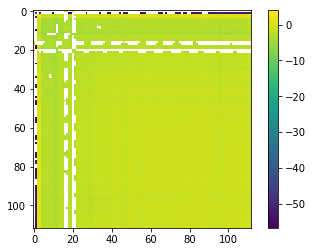

In [32]:
p = plt.imshow(np.log10(sc.xtqx.x))
plt.colorbar(p)

In [33]:
plt.imshow(sc.posterior_parameter.x)

2017-12-04 15:03:49.665713 starting: Schur's complement
2017-12-04 15:03:49.668446 finished: Schur's complement took: 0:00:00.002733


In [38]:
sc.get_forecast_summary()

2017-12-04 15:04:42.317043 starting: propagating prior to predictions
2017-12-04 15:04:42.324916 finished: propagating prior to predictions took: 0:00:00.007873
2017-12-04 15:04:42.325047 starting: propagating posterior to predictions
2017-12-04 15:04:42.326714 finished: propagating posterior to predictions took: 0:00:00.001667


percent_reduction      post_var     prior_var
flx_river_l_19700412          14.380552  28795.546514  33632.016128
flx_drains_19700412           36.302700  13331.514003  20929.480606
hds_00_080_060_001            97.065690      0.080586      2.746336
hds_00_050_050_001            98.160010      0.052124      2.832826

In [39]:
obs = sc.pst.observation_data

In [43]:
pot_heads = obs.loc[obs.apply(lambda x : x.obsnme.startswith("hds") and x.obsnme.endswith("000") and x.weight==0.0,axis=1),"obsnme"]

In [45]:
pot_heads = list(pot_heads)

In [46]:
pot_heads = dict(zip(pot_heads,pot_heads))

In [82]:
df = sc.get_added_obs_importance(obslist_dict=pot_heads,base_obslist=pst.nnz_obs_names,reset_zero_weight=1.0)

2017-12-04 15:50:43.716366 starting: loading obscov
2017-12-04 15:50:44.632704 finished: loading obscov took: 0:00:00.916338
2017-12-04 15:50:44.632825 resetting zero weights to 1.0
2017-12-04 15:50:53.554298 starting: resetting zero weight obs in base_obslist
2017-12-04 15:50:53.600421 finished: resetting zero weight obs in base_obslist took: 0:00:00.046123
2017-12-04 15:50:53.600517 starting: resetting zero weight obs in hds_00_000_000_000
2017-12-04 15:50:53.637929 finished: resetting zero weight obs in hds_00_000_000_000 took: 0:00:00.037412
2017-12-04 15:50:53.638019 starting: resetting zero weight obs in hds_00_000_001_000
2017-12-04 15:50:53.735727 finished: resetting zero weight obs in hds_00_000_001_000 took: 0:00:00.097708
2017-12-04 15:50:53.735833 starting: resetting zero weight obs in hds_00_000_002_000
2017-12-04 15:50:53.771371 finished: resetting zero weight obs in hds_00_000_002_000 took: 0:00:00.035538
2017-12-04 15:50:53.771457 starting: resetting zero weight obs in 

2017-12-04 15:50:55.810616 finished: resetting zero weight obs in hds_00_000_044_000 took: 0:00:00.091114
2017-12-04 15:50:55.810752 starting: resetting zero weight obs in hds_00_000_045_000
2017-12-04 15:50:55.857529 finished: resetting zero weight obs in hds_00_000_045_000 took: 0:00:00.046777
2017-12-04 15:50:55.857631 starting: resetting zero weight obs in hds_00_000_046_000
2017-12-04 15:50:55.894581 finished: resetting zero weight obs in hds_00_000_046_000 took: 0:00:00.036950
2017-12-04 15:50:55.894670 starting: resetting zero weight obs in hds_00_000_047_000
2017-12-04 15:50:55.931984 finished: resetting zero weight obs in hds_00_000_047_000 took: 0:00:00.037314
2017-12-04 15:50:55.932097 starting: resetting zero weight obs in hds_00_000_048_000
2017-12-04 15:50:55.969185 finished: resetting zero weight obs in hds_00_000_048_000 took: 0:00:00.037088
2017-12-04 15:50:55.969281 starting: resetting zero weight obs in hds_00_000_049_000
2017-12-04 15:50:56.003147 finished: resettin

2017-12-04 15:50:58.002365 finished: resetting zero weight obs in hds_00_001_013_000 took: 0:00:00.036655
2017-12-04 15:50:58.002469 starting: resetting zero weight obs in hds_00_001_014_000
2017-12-04 15:50:58.041546 finished: resetting zero weight obs in hds_00_001_014_000 took: 0:00:00.039077
2017-12-04 15:50:58.041716 starting: resetting zero weight obs in hds_00_001_015_000
2017-12-04 15:50:58.079033 finished: resetting zero weight obs in hds_00_001_015_000 took: 0:00:00.037317
2017-12-04 15:50:58.079144 starting: resetting zero weight obs in hds_00_001_016_000
2017-12-04 15:50:58.115007 finished: resetting zero weight obs in hds_00_001_016_000 took: 0:00:00.035863
2017-12-04 15:50:58.115105 starting: resetting zero weight obs in hds_00_001_017_000
2017-12-04 15:50:58.204220 finished: resetting zero weight obs in hds_00_001_017_000 took: 0:00:00.089115
2017-12-04 15:50:58.204367 starting: resetting zero weight obs in hds_00_001_018_000
2017-12-04 15:50:58.250117 finished: resettin

2017-12-04 15:51:00.066966 finished: resetting zero weight obs in hds_00_001_056_000 took: 0:00:00.088903
2017-12-04 15:51:00.067083 starting: resetting zero weight obs in hds_00_001_057_000
2017-12-04 15:51:00.111872 finished: resetting zero weight obs in hds_00_001_057_000 took: 0:00:00.044789
2017-12-04 15:51:00.111967 starting: resetting zero weight obs in hds_00_001_058_000
2017-12-04 15:51:00.147695 finished: resetting zero weight obs in hds_00_001_058_000 took: 0:00:00.035728
2017-12-04 15:51:00.147786 starting: resetting zero weight obs in hds_00_001_059_000
2017-12-04 15:51:00.180112 finished: resetting zero weight obs in hds_00_001_059_000 took: 0:00:00.032326
2017-12-04 15:51:00.180212 starting: resetting zero weight obs in hds_00_001_060_000
2017-12-04 15:51:00.270091 finished: resetting zero weight obs in hds_00_001_060_000 took: 0:00:00.089879
2017-12-04 15:51:00.270199 starting: resetting zero weight obs in hds_00_001_061_000
2017-12-04 15:51:00.307207 finished: resettin

2017-12-04 15:51:02.252397 finished: resetting zero weight obs in hds_00_002_027_000 took: 0:00:00.095300
2017-12-04 15:51:02.252526 starting: resetting zero weight obs in hds_00_002_028_000
2017-12-04 15:51:02.296821 finished: resetting zero weight obs in hds_00_002_028_000 took: 0:00:00.044295
2017-12-04 15:51:02.296927 starting: resetting zero weight obs in hds_00_002_029_000
2017-12-04 15:51:02.333698 finished: resetting zero weight obs in hds_00_002_029_000 took: 0:00:00.036771
2017-12-04 15:51:02.333787 starting: resetting zero weight obs in hds_00_002_030_000
2017-12-04 15:51:02.371908 finished: resetting zero weight obs in hds_00_002_030_000 took: 0:00:00.038121
2017-12-04 15:51:02.372007 starting: resetting zero weight obs in hds_00_002_031_000
2017-12-04 15:51:02.410242 finished: resetting zero weight obs in hds_00_002_031_000 took: 0:00:00.038235
2017-12-04 15:51:02.410345 starting: resetting zero weight obs in hds_00_002_032_000
2017-12-04 15:51:02.503843 finished: resettin

2017-12-04 15:51:04.401575 finished: resetting zero weight obs in hds_00_002_070_000 took: 0:00:00.037402
2017-12-04 15:51:04.401677 starting: resetting zero weight obs in hds_00_002_071_000
2017-12-04 15:51:04.490170 finished: resetting zero weight obs in hds_00_002_071_000 took: 0:00:00.088493
2017-12-04 15:51:04.490288 starting: resetting zero weight obs in hds_00_002_072_000
2017-12-04 15:51:04.535508 finished: resetting zero weight obs in hds_00_002_072_000 took: 0:00:00.045220
2017-12-04 15:51:04.535596 starting: resetting zero weight obs in hds_00_002_073_000
2017-12-04 15:51:04.570986 finished: resetting zero weight obs in hds_00_002_073_000 took: 0:00:00.035390
2017-12-04 15:51:04.571069 starting: resetting zero weight obs in hds_00_002_074_000
2017-12-04 15:51:04.606056 finished: resetting zero weight obs in hds_00_002_074_000 took: 0:00:00.034987
2017-12-04 15:51:04.606155 starting: resetting zero weight obs in hds_00_003_000_000
2017-12-04 15:51:04.645603 finished: resettin

2017-12-04 15:51:06.801275 starting: resetting zero weight obs in hds_00_003_043_000
2017-12-04 15:51:06.886346 finished: resetting zero weight obs in hds_00_003_043_000 took: 0:00:00.085071
2017-12-04 15:51:06.886474 starting: resetting zero weight obs in hds_00_003_044_000
2017-12-04 15:51:06.930581 finished: resetting zero weight obs in hds_00_003_044_000 took: 0:00:00.044107
2017-12-04 15:51:06.930676 starting: resetting zero weight obs in hds_00_003_045_000
2017-12-04 15:51:06.967273 finished: resetting zero weight obs in hds_00_003_045_000 took: 0:00:00.036597
2017-12-04 15:51:06.967362 starting: resetting zero weight obs in hds_00_003_046_000
2017-12-04 15:51:07.003726 finished: resetting zero weight obs in hds_00_003_046_000 took: 0:00:00.036364
2017-12-04 15:51:07.003819 starting: resetting zero weight obs in hds_00_003_047_000
2017-12-04 15:51:07.040011 finished: resetting zero weight obs in hds_00_003_047_000 took: 0:00:00.036192
2017-12-04 15:51:07.040106 starting: resettin

2017-12-04 15:51:08.879182 starting: resetting zero weight obs in hds_00_004_011_000
2017-12-04 15:51:08.916216 finished: resetting zero weight obs in hds_00_004_011_000 took: 0:00:00.037034
2017-12-04 15:51:08.916310 starting: resetting zero weight obs in hds_00_004_012_000
2017-12-04 15:51:08.954531 finished: resetting zero weight obs in hds_00_004_012_000 took: 0:00:00.038221
2017-12-04 15:51:08.954641 starting: resetting zero weight obs in hds_00_004_013_000
2017-12-04 15:51:08.991312 finished: resetting zero weight obs in hds_00_004_013_000 took: 0:00:00.036671
2017-12-04 15:51:08.991413 starting: resetting zero weight obs in hds_00_004_014_000
2017-12-04 15:51:09.080477 finished: resetting zero weight obs in hds_00_004_014_000 took: 0:00:00.089064
2017-12-04 15:51:09.080603 starting: resetting zero weight obs in hds_00_004_015_000
2017-12-04 15:51:09.125571 finished: resetting zero weight obs in hds_00_004_015_000 took: 0:00:00.044968
2017-12-04 15:51:09.125667 starting: resettin

2017-12-04 15:51:11.167052 finished: resetting zero weight obs in hds_00_004_057_000 took: 0:00:00.034035
2017-12-04 15:51:11.167172 starting: resetting zero weight obs in hds_00_004_058_000
2017-12-04 15:51:11.204470 finished: resetting zero weight obs in hds_00_004_058_000 took: 0:00:00.037298
2017-12-04 15:51:11.204557 starting: resetting zero weight obs in hds_00_004_059_000
2017-12-04 15:51:11.238065 finished: resetting zero weight obs in hds_00_004_059_000 took: 0:00:00.033508
2017-12-04 15:51:11.238164 starting: resetting zero weight obs in hds_00_004_060_000
2017-12-04 15:51:11.325069 finished: resetting zero weight obs in hds_00_004_060_000 took: 0:00:00.086905
2017-12-04 15:51:11.325215 starting: resetting zero weight obs in hds_00_004_061_000
2017-12-04 15:51:11.369598 finished: resetting zero weight obs in hds_00_004_061_000 took: 0:00:00.044383
2017-12-04 15:51:11.369691 starting: resetting zero weight obs in hds_00_004_062_000
2017-12-04 15:51:11.406128 finished: resettin

2017-12-04 15:51:13.347353 finished: resetting zero weight obs in hds_00_005_029_000 took: 0:00:00.084604
2017-12-04 15:51:13.347479 starting: resetting zero weight obs in hds_00_005_030_000
2017-12-04 15:51:13.393168 finished: resetting zero weight obs in hds_00_005_030_000 took: 0:00:00.045689
2017-12-04 15:51:13.393321 starting: resetting zero weight obs in hds_00_005_031_000
2017-12-04 15:51:13.428745 finished: resetting zero weight obs in hds_00_005_031_000 took: 0:00:00.035424
2017-12-04 15:51:13.428829 starting: resetting zero weight obs in hds_00_005_032_000
2017-12-04 15:51:13.460360 finished: resetting zero weight obs in hds_00_005_032_000 took: 0:00:00.031531
2017-12-04 15:51:13.460472 starting: resetting zero weight obs in hds_00_005_033_000
2017-12-04 15:51:13.492300 finished: resetting zero weight obs in hds_00_005_033_000 took: 0:00:00.031828
2017-12-04 15:51:13.492396 starting: resetting zero weight obs in hds_00_005_034_000
2017-12-04 15:51:13.526570 finished: resettin

2017-12-04 15:51:15.552359 finished: resetting zero weight obs in hds_00_006_001_000 took: 0:00:00.081645
2017-12-04 15:51:15.552501 starting: resetting zero weight obs in hds_00_006_002_000
2017-12-04 15:51:15.598443 finished: resetting zero weight obs in hds_00_006_002_000 took: 0:00:00.045942
2017-12-04 15:51:15.598534 starting: resetting zero weight obs in hds_00_006_003_000
2017-12-04 15:51:15.634792 finished: resetting zero weight obs in hds_00_006_003_000 took: 0:00:00.036258
2017-12-04 15:51:15.634873 starting: resetting zero weight obs in hds_00_006_004_000
2017-12-04 15:51:15.666743 finished: resetting zero weight obs in hds_00_006_004_000 took: 0:00:00.031870
2017-12-04 15:51:15.666840 starting: resetting zero weight obs in hds_00_006_005_000
2017-12-04 15:51:15.698088 finished: resetting zero weight obs in hds_00_006_005_000 took: 0:00:00.031248
2017-12-04 15:51:15.698166 starting: resetting zero weight obs in hds_00_006_006_000
2017-12-04 15:51:15.728802 finished: resettin

2017-12-04 15:51:17.574780 starting: resetting zero weight obs in hds_00_006_048_000
2017-12-04 15:51:17.617696 finished: resetting zero weight obs in hds_00_006_048_000 took: 0:00:00.042916
2017-12-04 15:51:17.617797 starting: resetting zero weight obs in hds_00_006_049_000
2017-12-04 15:51:17.654152 finished: resetting zero weight obs in hds_00_006_049_000 took: 0:00:00.036355
2017-12-04 15:51:17.654244 starting: resetting zero weight obs in hds_00_006_050_000
2017-12-04 15:51:17.687675 finished: resetting zero weight obs in hds_00_006_050_000 took: 0:00:00.033431
2017-12-04 15:51:17.687752 starting: resetting zero weight obs in hds_00_006_051_000
2017-12-04 15:51:17.779674 finished: resetting zero weight obs in hds_00_006_051_000 took: 0:00:00.091922
2017-12-04 15:51:17.779771 starting: resetting zero weight obs in hds_00_006_052_000
2017-12-04 15:51:17.817558 finished: resetting zero weight obs in hds_00_006_052_000 took: 0:00:00.037787
2017-12-04 15:51:17.817644 starting: resettin

2017-12-04 15:51:19.674809 finished: resetting zero weight obs in hds_00_007_018_000 took: 0:00:00.084720
2017-12-04 15:51:19.674932 starting: resetting zero weight obs in hds_00_007_019_000
2017-12-04 15:51:19.721173 finished: resetting zero weight obs in hds_00_007_019_000 took: 0:00:00.046241
2017-12-04 15:51:19.721291 starting: resetting zero weight obs in hds_00_007_020_000
2017-12-04 15:51:19.756139 finished: resetting zero weight obs in hds_00_007_020_000 took: 0:00:00.034848
2017-12-04 15:51:19.756229 starting: resetting zero weight obs in hds_00_007_021_000
2017-12-04 15:51:19.788568 finished: resetting zero weight obs in hds_00_007_021_000 took: 0:00:00.032339
2017-12-04 15:51:19.788649 starting: resetting zero weight obs in hds_00_007_022_000
2017-12-04 15:51:19.820255 finished: resetting zero weight obs in hds_00_007_022_000 took: 0:00:00.031606
2017-12-04 15:51:19.820421 starting: resetting zero weight obs in hds_00_007_023_000
2017-12-04 15:51:19.902295 finished: resettin

2017-12-04 15:51:21.695849 finished: resetting zero weight obs in hds_00_007_062_000 took: 0:00:00.085494
2017-12-04 15:51:21.695996 starting: resetting zero weight obs in hds_00_007_063_000
2017-12-04 15:51:21.742477 finished: resetting zero weight obs in hds_00_007_063_000 took: 0:00:00.046481
2017-12-04 15:51:21.742571 starting: resetting zero weight obs in hds_00_007_064_000
2017-12-04 15:51:21.777558 finished: resetting zero weight obs in hds_00_007_064_000 took: 0:00:00.034987
2017-12-04 15:51:21.777642 starting: resetting zero weight obs in hds_00_007_065_000
2017-12-04 15:51:21.809291 finished: resetting zero weight obs in hds_00_007_065_000 took: 0:00:00.031649
2017-12-04 15:51:21.809376 starting: resetting zero weight obs in hds_00_007_066_000
2017-12-04 15:51:21.842778 finished: resetting zero weight obs in hds_00_007_066_000 took: 0:00:00.033402
2017-12-04 15:51:21.842871 starting: resetting zero weight obs in hds_00_007_067_000
2017-12-04 15:51:21.874954 finished: resettin

2017-12-04 15:51:23.931415 starting: resetting zero weight obs in hds_00_008_036_000
2017-12-04 15:51:23.965978 finished: resetting zero weight obs in hds_00_008_036_000 took: 0:00:00.034563
2017-12-04 15:51:23.966072 starting: resetting zero weight obs in hds_00_008_037_000
2017-12-04 15:51:24.001134 finished: resetting zero weight obs in hds_00_008_037_000 took: 0:00:00.035062
2017-12-04 15:51:24.001217 starting: resetting zero weight obs in hds_00_008_038_000
2017-12-04 15:51:24.032393 finished: resetting zero weight obs in hds_00_008_038_000 took: 0:00:00.031176
2017-12-04 15:51:24.032487 starting: resetting zero weight obs in hds_00_008_039_000
2017-12-04 15:51:24.063288 finished: resetting zero weight obs in hds_00_008_039_000 took: 0:00:00.030801
2017-12-04 15:51:24.063400 starting: resetting zero weight obs in hds_00_008_040_000
2017-12-04 15:51:24.094757 finished: resetting zero weight obs in hds_00_008_040_000 took: 0:00:00.031357
2017-12-04 15:51:24.094840 starting: resettin

2017-12-04 15:51:25.922785 starting: resetting zero weight obs in hds_00_009_006_000
2017-12-04 15:51:25.966926 finished: resetting zero weight obs in hds_00_009_006_000 took: 0:00:00.044141
2017-12-04 15:51:25.967027 starting: resetting zero weight obs in hds_00_009_007_000
2017-12-04 15:51:26.003750 finished: resetting zero weight obs in hds_00_009_007_000 took: 0:00:00.036723
2017-12-04 15:51:26.003831 starting: resetting zero weight obs in hds_00_009_008_000
2017-12-04 15:51:26.037416 finished: resetting zero weight obs in hds_00_009_008_000 took: 0:00:00.033585
2017-12-04 15:51:26.037494 starting: resetting zero weight obs in hds_00_009_009_000
2017-12-04 15:51:26.131072 finished: resetting zero weight obs in hds_00_009_009_000 took: 0:00:00.093578
2017-12-04 15:51:26.131176 starting: resetting zero weight obs in hds_00_009_010_000
2017-12-04 15:51:26.166472 finished: resetting zero weight obs in hds_00_009_010_000 took: 0:00:00.035296
2017-12-04 15:51:26.166549 starting: resettin

2017-12-04 15:51:28.031852 finished: resetting zero weight obs in hds_00_009_051_000 took: 0:00:00.082587
2017-12-04 15:51:28.031978 starting: resetting zero weight obs in hds_00_009_052_000
2017-12-04 15:51:28.078909 finished: resetting zero weight obs in hds_00_009_052_000 took: 0:00:00.046931
2017-12-04 15:51:28.079001 starting: resetting zero weight obs in hds_00_009_053_000
2017-12-04 15:51:28.114138 finished: resetting zero weight obs in hds_00_009_053_000 took: 0:00:00.035137
2017-12-04 15:51:28.114220 starting: resetting zero weight obs in hds_00_009_054_000
2017-12-04 15:51:28.145265 finished: resetting zero weight obs in hds_00_009_054_000 took: 0:00:00.031045
2017-12-04 15:51:28.145353 starting: resetting zero weight obs in hds_00_009_055_000
2017-12-04 15:51:28.176459 finished: resetting zero weight obs in hds_00_009_055_000 took: 0:00:00.031106
2017-12-04 15:51:28.176530 starting: resetting zero weight obs in hds_00_009_056_000
2017-12-04 15:51:28.261179 finished: resettin

2017-12-04 15:51:30.002771 starting: resetting zero weight obs in hds_00_010_020_000
2017-12-04 15:51:30.087710 finished: resetting zero weight obs in hds_00_010_020_000 took: 0:00:00.084939
2017-12-04 15:51:30.087904 starting: resetting zero weight obs in hds_00_010_021_000
2017-12-04 15:51:30.134960 finished: resetting zero weight obs in hds_00_010_021_000 took: 0:00:00.047056
2017-12-04 15:51:30.135069 starting: resetting zero weight obs in hds_00_010_022_000
2017-12-04 15:51:30.173074 finished: resetting zero weight obs in hds_00_010_022_000 took: 0:00:00.038005
2017-12-04 15:51:30.173170 starting: resetting zero weight obs in hds_00_010_023_000
2017-12-04 15:51:30.209490 finished: resetting zero weight obs in hds_00_010_023_000 took: 0:00:00.036320
2017-12-04 15:51:30.209583 starting: resetting zero weight obs in hds_00_010_024_000
2017-12-04 15:51:30.245874 finished: resetting zero weight obs in hds_00_010_024_000 took: 0:00:00.036291
2017-12-04 15:51:30.245960 starting: resettin

2017-12-04 15:51:32.352277 starting: resetting zero weight obs in hds_00_010_067_000
2017-12-04 15:51:32.440734 finished: resetting zero weight obs in hds_00_010_067_000 took: 0:00:00.088457
2017-12-04 15:51:32.440873 starting: resetting zero weight obs in hds_00_010_068_000
2017-12-04 15:51:32.487056 finished: resetting zero weight obs in hds_00_010_068_000 took: 0:00:00.046183
2017-12-04 15:51:32.487157 starting: resetting zero weight obs in hds_00_010_069_000
2017-12-04 15:51:32.524036 finished: resetting zero weight obs in hds_00_010_069_000 took: 0:00:00.036879
2017-12-04 15:51:32.524132 starting: resetting zero weight obs in hds_00_010_070_000
2017-12-04 15:51:32.563054 finished: resetting zero weight obs in hds_00_010_070_000 took: 0:00:00.038922
2017-12-04 15:51:32.563179 starting: resetting zero weight obs in hds_00_010_071_000
2017-12-04 15:51:32.602892 finished: resetting zero weight obs in hds_00_010_071_000 took: 0:00:00.039713
2017-12-04 15:51:32.602989 starting: resettin

2017-12-04 15:51:34.684885 finished: resetting zero weight obs in hds_00_011_038_000 took: 0:00:00.088978
2017-12-04 15:51:34.685016 starting: resetting zero weight obs in hds_00_011_039_000
2017-12-04 15:51:34.732361 finished: resetting zero weight obs in hds_00_011_039_000 took: 0:00:00.047345
2017-12-04 15:51:34.732477 starting: resetting zero weight obs in hds_00_011_040_000
2017-12-04 15:51:34.774018 finished: resetting zero weight obs in hds_00_011_040_000 took: 0:00:00.041541
2017-12-04 15:51:34.774114 starting: resetting zero weight obs in hds_00_011_041_000
2017-12-04 15:51:34.811036 finished: resetting zero weight obs in hds_00_011_041_000 took: 0:00:00.036922
2017-12-04 15:51:34.811130 starting: resetting zero weight obs in hds_00_011_042_000
2017-12-04 15:51:34.907592 finished: resetting zero weight obs in hds_00_011_042_000 took: 0:00:00.096462
2017-12-04 15:51:34.907719 starting: resetting zero weight obs in hds_00_011_043_000
2017-12-04 15:51:34.959425 finished: resettin

2017-12-04 15:51:37.021553 finished: resetting zero weight obs in hds_00_012_009_000 took: 0:00:00.089389
2017-12-04 15:51:37.021725 starting: resetting zero weight obs in hds_00_012_010_000
2017-12-04 15:51:37.066919 finished: resetting zero weight obs in hds_00_012_010_000 took: 0:00:00.045194
2017-12-04 15:51:37.067017 starting: resetting zero weight obs in hds_00_012_011_000
2017-12-04 15:51:37.105459 finished: resetting zero weight obs in hds_00_012_011_000 took: 0:00:00.038442
2017-12-04 15:51:37.105555 starting: resetting zero weight obs in hds_00_012_012_000
2017-12-04 15:51:37.140764 finished: resetting zero weight obs in hds_00_012_012_000 took: 0:00:00.035209
2017-12-04 15:51:37.140875 starting: resetting zero weight obs in hds_00_012_013_000
2017-12-04 15:51:37.176277 finished: resetting zero weight obs in hds_00_012_013_000 took: 0:00:00.035402
2017-12-04 15:51:37.176366 starting: resetting zero weight obs in hds_00_012_014_000
2017-12-04 15:51:37.265414 finished: resettin

2017-12-04 15:51:39.242126 finished: resetting zero weight obs in hds_00_012_053_000 took: 0:00:00.082536
2017-12-04 15:51:39.242261 starting: resetting zero weight obs in hds_00_012_054_000
2017-12-04 15:51:39.288169 finished: resetting zero weight obs in hds_00_012_054_000 took: 0:00:00.045908
2017-12-04 15:51:39.288262 starting: resetting zero weight obs in hds_00_012_055_000
2017-12-04 15:51:39.323159 finished: resetting zero weight obs in hds_00_012_055_000 took: 0:00:00.034897
2017-12-04 15:51:39.323245 starting: resetting zero weight obs in hds_00_012_056_000
2017-12-04 15:51:39.355444 finished: resetting zero weight obs in hds_00_012_056_000 took: 0:00:00.032199
2017-12-04 15:51:39.355538 starting: resetting zero weight obs in hds_00_012_057_000
2017-12-04 15:51:39.386580 finished: resetting zero weight obs in hds_00_012_057_000 took: 0:00:00.031042
2017-12-04 15:51:39.386672 starting: resetting zero weight obs in hds_00_012_058_000
2017-12-04 15:51:39.417523 finished: resettin

2017-12-04 15:51:41.456248 starting: resetting zero weight obs in hds_00_013_026_000
2017-12-04 15:51:41.499126 finished: resetting zero weight obs in hds_00_013_026_000 took: 0:00:00.042878
2017-12-04 15:51:41.499228 starting: resetting zero weight obs in hds_00_013_027_000
2017-12-04 15:51:41.537232 finished: resetting zero weight obs in hds_00_013_027_000 took: 0:00:00.038004
2017-12-04 15:51:41.537320 starting: resetting zero weight obs in hds_00_013_028_000
2017-12-04 15:51:41.571463 finished: resetting zero weight obs in hds_00_013_028_000 took: 0:00:00.034143
2017-12-04 15:51:41.571545 starting: resetting zero weight obs in hds_00_013_029_000
2017-12-04 15:51:41.602582 finished: resetting zero weight obs in hds_00_013_029_000 took: 0:00:00.031037
2017-12-04 15:51:41.602674 starting: resetting zero weight obs in hds_00_013_030_000
2017-12-04 15:51:41.633494 finished: resetting zero weight obs in hds_00_013_030_000 took: 0:00:00.030820
2017-12-04 15:51:41.633585 starting: resettin

2017-12-04 15:51:43.738671 finished: resetting zero weight obs in hds_00_013_072_000 took: 0:00:00.048875
2017-12-04 15:51:43.738776 starting: resetting zero weight obs in hds_00_013_073_000
2017-12-04 15:51:43.777888 finished: resetting zero weight obs in hds_00_013_073_000 took: 0:00:00.039112
2017-12-04 15:51:43.777986 starting: resetting zero weight obs in hds_00_013_074_000
2017-12-04 15:51:43.816541 finished: resetting zero weight obs in hds_00_013_074_000 took: 0:00:00.038555
2017-12-04 15:51:43.816637 starting: resetting zero weight obs in hds_00_014_000_000
2017-12-04 15:51:43.909324 finished: resetting zero weight obs in hds_00_014_000_000 took: 0:00:00.092687
2017-12-04 15:51:43.909437 starting: resetting zero weight obs in hds_00_014_001_000
2017-12-04 15:51:43.955981 finished: resetting zero weight obs in hds_00_014_001_000 took: 0:00:00.046544
2017-12-04 15:51:43.956089 starting: resetting zero weight obs in hds_00_014_002_000
2017-12-04 15:51:43.996068 finished: resettin

2017-12-04 15:51:45.987923 finished: resetting zero weight obs in hds_00_014_042_000 took: 0:00:00.091122
2017-12-04 15:51:45.988047 starting: resetting zero weight obs in hds_00_014_043_000
2017-12-04 15:51:46.033682 finished: resetting zero weight obs in hds_00_014_043_000 took: 0:00:00.045635
2017-12-04 15:51:46.033782 starting: resetting zero weight obs in hds_00_014_044_000
2017-12-04 15:51:46.071839 finished: resetting zero weight obs in hds_00_014_044_000 took: 0:00:00.038057
2017-12-04 15:51:46.071936 starting: resetting zero weight obs in hds_00_014_045_000
2017-12-04 15:51:46.109854 finished: resetting zero weight obs in hds_00_014_045_000 took: 0:00:00.037918
2017-12-04 15:51:46.109992 starting: resetting zero weight obs in hds_00_014_046_000
2017-12-04 15:51:46.149824 finished: resetting zero weight obs in hds_00_014_046_000 took: 0:00:00.039832
2017-12-04 15:51:46.149977 starting: resetting zero weight obs in hds_00_014_047_000
2017-12-04 15:51:46.244073 finished: resettin

2017-12-04 15:51:48.229323 finished: resetting zero weight obs in hds_00_015_012_000 took: 0:00:00.039286
2017-12-04 15:51:48.229437 starting: resetting zero weight obs in hds_00_015_013_000
2017-12-04 15:51:48.265719 finished: resetting zero weight obs in hds_00_015_013_000 took: 0:00:00.036282
2017-12-04 15:51:48.265806 starting: resetting zero weight obs in hds_00_015_014_000
2017-12-04 15:51:48.298981 finished: resetting zero weight obs in hds_00_015_014_000 took: 0:00:00.033175
2017-12-04 15:51:48.299057 starting: resetting zero weight obs in hds_00_015_015_000
2017-12-04 15:51:48.329991 finished: resetting zero weight obs in hds_00_015_015_000 took: 0:00:00.030934
2017-12-04 15:51:48.330083 starting: resetting zero weight obs in hds_00_015_016_000
2017-12-04 15:51:48.361241 finished: resetting zero weight obs in hds_00_015_016_000 took: 0:00:00.031158
2017-12-04 15:51:48.361321 starting: resetting zero weight obs in hds_00_015_017_000
2017-12-04 15:51:48.444707 finished: resettin

2017-12-04 15:51:50.371939 finished: resetting zero weight obs in hds_00_015_058_000 took: 0:00:00.081446
2017-12-04 15:51:50.372074 starting: resetting zero weight obs in hds_00_015_059_000
2017-12-04 15:51:50.417616 finished: resetting zero weight obs in hds_00_015_059_000 took: 0:00:00.045542
2017-12-04 15:51:50.417725 starting: resetting zero weight obs in hds_00_015_060_000
2017-12-04 15:51:50.455461 finished: resetting zero weight obs in hds_00_015_060_000 took: 0:00:00.037736
2017-12-04 15:51:50.455544 starting: resetting zero weight obs in hds_00_015_061_000
2017-12-04 15:51:50.487324 finished: resetting zero weight obs in hds_00_015_061_000 took: 0:00:00.031780
2017-12-04 15:51:50.487410 starting: resetting zero weight obs in hds_00_015_062_000
2017-12-04 15:51:50.518121 finished: resetting zero weight obs in hds_00_015_062_000 took: 0:00:00.030711
2017-12-04 15:51:50.518215 starting: resetting zero weight obs in hds_00_015_063_000
2017-12-04 15:51:50.549186 finished: resettin

2017-12-04 15:51:52.533235 finished: resetting zero weight obs in hds_00_016_029_000 took: 0:00:00.093387
2017-12-04 15:51:52.533347 starting: resetting zero weight obs in hds_00_016_030_000
2017-12-04 15:51:52.579286 finished: resetting zero weight obs in hds_00_016_030_000 took: 0:00:00.045939
2017-12-04 15:51:52.579404 starting: resetting zero weight obs in hds_00_016_031_000
2017-12-04 15:51:52.618272 finished: resetting zero weight obs in hds_00_016_031_000 took: 0:00:00.038868
2017-12-04 15:51:52.618375 starting: resetting zero weight obs in hds_00_016_032_000
2017-12-04 15:51:52.656908 finished: resetting zero weight obs in hds_00_016_032_000 took: 0:00:00.038533
2017-12-04 15:51:52.657012 starting: resetting zero weight obs in hds_00_016_033_000
2017-12-04 15:51:52.751843 finished: resetting zero weight obs in hds_00_016_033_000 took: 0:00:00.094831
2017-12-04 15:51:52.752035 starting: resetting zero weight obs in hds_00_016_034_000
2017-12-04 15:51:52.798095 finished: resettin

2017-12-04 15:51:54.817028 finished: resetting zero weight obs in hds_00_017_000_000 took: 0:00:00.092668
2017-12-04 15:51:54.817159 starting: resetting zero weight obs in hds_00_017_001_000
2017-12-04 15:51:54.863440 finished: resetting zero weight obs in hds_00_017_001_000 took: 0:00:00.046281
2017-12-04 15:51:54.863530 starting: resetting zero weight obs in hds_00_017_002_000
2017-12-04 15:51:54.899019 finished: resetting zero weight obs in hds_00_017_002_000 took: 0:00:00.035489
2017-12-04 15:51:54.899107 starting: resetting zero weight obs in hds_00_017_003_000
2017-12-04 15:51:54.937681 finished: resetting zero weight obs in hds_00_017_003_000 took: 0:00:00.038574
2017-12-04 15:51:54.937772 starting: resetting zero weight obs in hds_00_017_004_000
2017-12-04 15:51:54.973839 finished: resetting zero weight obs in hds_00_017_004_000 took: 0:00:00.036067
2017-12-04 15:51:54.973939 starting: resetting zero weight obs in hds_00_017_005_000
2017-12-04 15:51:55.061495 finished: resettin

2017-12-04 15:51:56.876634 starting: resetting zero weight obs in hds_00_017_044_000
2017-12-04 15:51:56.965265 finished: resetting zero weight obs in hds_00_017_044_000 took: 0:00:00.088631
2017-12-04 15:51:56.965393 starting: resetting zero weight obs in hds_00_017_045_000
2017-12-04 15:51:57.007271 finished: resetting zero weight obs in hds_00_017_045_000 took: 0:00:00.041878
2017-12-04 15:51:57.007357 starting: resetting zero weight obs in hds_00_017_046_000
2017-12-04 15:51:57.041791 finished: resetting zero weight obs in hds_00_017_046_000 took: 0:00:00.034434
2017-12-04 15:51:57.041888 starting: resetting zero weight obs in hds_00_017_047_000
2017-12-04 15:51:57.073839 finished: resetting zero weight obs in hds_00_017_047_000 took: 0:00:00.031951
2017-12-04 15:51:57.073936 starting: resetting zero weight obs in hds_00_017_048_000
2017-12-04 15:51:57.111033 finished: resetting zero weight obs in hds_00_017_048_000 took: 0:00:00.037097
2017-12-04 15:51:57.111123 starting: resettin

2017-12-04 15:51:59.309667 finished: resetting zero weight obs in hds_00_018_016_000 took: 0:00:00.081566
2017-12-04 15:51:59.309796 starting: resetting zero weight obs in hds_00_018_017_000
2017-12-04 15:51:59.354602 finished: resetting zero weight obs in hds_00_018_017_000 took: 0:00:00.044806
2017-12-04 15:51:59.354694 starting: resetting zero weight obs in hds_00_018_018_000
2017-12-04 15:51:59.390013 finished: resetting zero weight obs in hds_00_018_018_000 took: 0:00:00.035319
2017-12-04 15:51:59.390097 starting: resetting zero weight obs in hds_00_018_019_000
2017-12-04 15:51:59.421650 finished: resetting zero weight obs in hds_00_018_019_000 took: 0:00:00.031553
2017-12-04 15:51:59.421739 starting: resetting zero weight obs in hds_00_018_020_000
2017-12-04 15:51:59.452569 finished: resetting zero weight obs in hds_00_018_020_000 took: 0:00:00.030830
2017-12-04 15:51:59.452661 starting: resetting zero weight obs in hds_00_018_021_000
2017-12-04 15:51:59.484894 finished: resettin

2017-12-04 15:52:01.400297 starting: resetting zero weight obs in hds_00_018_064_000
2017-12-04 15:52:01.436161 finished: resetting zero weight obs in hds_00_018_064_000 took: 0:00:00.035864
2017-12-04 15:52:01.436255 starting: resetting zero weight obs in hds_00_018_065_000
2017-12-04 15:52:01.470507 finished: resetting zero weight obs in hds_00_018_065_000 took: 0:00:00.034252
2017-12-04 15:52:01.470585 starting: resetting zero weight obs in hds_00_018_066_000
2017-12-04 15:52:01.554836 finished: resetting zero weight obs in hds_00_018_066_000 took: 0:00:00.084251
2017-12-04 15:52:01.554961 starting: resetting zero weight obs in hds_00_018_067_000
2017-12-04 15:52:01.597186 finished: resetting zero weight obs in hds_00_018_067_000 took: 0:00:00.042225
2017-12-04 15:52:01.597264 starting: resetting zero weight obs in hds_00_018_068_000
2017-12-04 15:52:01.631156 finished: resetting zero weight obs in hds_00_018_068_000 took: 0:00:00.033892
2017-12-04 15:52:01.631248 starting: resettin

2017-12-04 15:52:03.452777 finished: resetting zero weight obs in hds_00_019_033_000 took: 0:00:00.088253
2017-12-04 15:52:03.452920 starting: resetting zero weight obs in hds_00_019_034_000
2017-12-04 15:52:03.499472 finished: resetting zero weight obs in hds_00_019_034_000 took: 0:00:00.046552
2017-12-04 15:52:03.499571 starting: resetting zero weight obs in hds_00_019_035_000
2017-12-04 15:52:03.537520 finished: resetting zero weight obs in hds_00_019_035_000 took: 0:00:00.037949
2017-12-04 15:52:03.537608 starting: resetting zero weight obs in hds_00_019_036_000
2017-12-04 15:52:03.569247 finished: resetting zero weight obs in hds_00_019_036_000 took: 0:00:00.031639
2017-12-04 15:52:03.569340 starting: resetting zero weight obs in hds_00_019_037_000
2017-12-04 15:52:03.600780 finished: resetting zero weight obs in hds_00_019_037_000 took: 0:00:00.031440
2017-12-04 15:52:03.600880 starting: resetting zero weight obs in hds_00_019_038_000
2017-12-04 15:52:03.684813 finished: resettin

2017-12-04 15:52:05.402696 starting: resetting zero weight obs in hds_00_020_002_000
2017-12-04 15:52:05.486863 finished: resetting zero weight obs in hds_00_020_002_000 took: 0:00:00.084167
2017-12-04 15:52:05.487004 starting: resetting zero weight obs in hds_00_020_003_000
2017-12-04 15:52:05.531361 finished: resetting zero weight obs in hds_00_020_003_000 took: 0:00:00.044357
2017-12-04 15:52:05.531449 starting: resetting zero weight obs in hds_00_020_004_000
2017-12-04 15:52:05.565400 finished: resetting zero weight obs in hds_00_020_004_000 took: 0:00:00.033951
2017-12-04 15:52:05.565477 starting: resetting zero weight obs in hds_00_020_005_000
2017-12-04 15:52:05.596161 finished: resetting zero weight obs in hds_00_020_005_000 took: 0:00:00.030684
2017-12-04 15:52:05.596247 starting: resetting zero weight obs in hds_00_020_006_000
2017-12-04 15:52:05.626786 finished: resetting zero weight obs in hds_00_020_006_000 took: 0:00:00.030539
2017-12-04 15:52:05.626873 starting: resettin

2017-12-04 15:52:07.486620 finished: resetting zero weight obs in hds_00_020_046_000 took: 0:00:00.089068
2017-12-04 15:52:07.486767 starting: resetting zero weight obs in hds_00_020_047_000
2017-12-04 15:52:07.535698 finished: resetting zero weight obs in hds_00_020_047_000 took: 0:00:00.048931
2017-12-04 15:52:07.535795 starting: resetting zero weight obs in hds_00_020_048_000
2017-12-04 15:52:07.571001 finished: resetting zero weight obs in hds_00_020_048_000 took: 0:00:00.035206
2017-12-04 15:52:07.571089 starting: resetting zero weight obs in hds_00_020_049_000
2017-12-04 15:52:07.606901 finished: resetting zero weight obs in hds_00_020_049_000 took: 0:00:00.035812
2017-12-04 15:52:07.607025 starting: resetting zero weight obs in hds_00_020_050_000
2017-12-04 15:52:07.692182 finished: resetting zero weight obs in hds_00_020_050_000 took: 0:00:00.085157
2017-12-04 15:52:07.692302 starting: resetting zero weight obs in hds_00_020_051_000
2017-12-04 15:52:07.735444 finished: resettin

2017-12-04 15:52:09.473249 finished: resetting zero weight obs in hds_00_021_017_000 took: 0:00:00.083878
2017-12-04 15:52:09.473387 starting: resetting zero weight obs in hds_00_021_018_000
2017-12-04 15:52:09.519866 finished: resetting zero weight obs in hds_00_021_018_000 took: 0:00:00.046479
2017-12-04 15:52:09.520001 starting: resetting zero weight obs in hds_00_021_019_000
2017-12-04 15:52:09.556339 finished: resetting zero weight obs in hds_00_021_019_000 took: 0:00:00.036338
2017-12-04 15:52:09.556425 starting: resetting zero weight obs in hds_00_021_020_000
2017-12-04 15:52:09.587702 finished: resetting zero weight obs in hds_00_021_020_000 took: 0:00:00.031277
2017-12-04 15:52:09.587793 starting: resetting zero weight obs in hds_00_021_021_000
2017-12-04 15:52:09.618800 finished: resetting zero weight obs in hds_00_021_021_000 took: 0:00:00.031007
2017-12-04 15:52:09.618878 starting: resetting zero weight obs in hds_00_021_022_000
2017-12-04 15:52:09.701639 finished: resettin

2017-12-04 15:52:11.584026 finished: resetting zero weight obs in hds_00_021_063_000 took: 0:00:00.085402
2017-12-04 15:52:11.584156 starting: resetting zero weight obs in hds_00_021_064_000
2017-12-04 15:52:11.630120 finished: resetting zero weight obs in hds_00_021_064_000 took: 0:00:00.045964
2017-12-04 15:52:11.630218 starting: resetting zero weight obs in hds_00_021_065_000
2017-12-04 15:52:11.664915 finished: resetting zero weight obs in hds_00_021_065_000 took: 0:00:00.034697
2017-12-04 15:52:11.665003 starting: resetting zero weight obs in hds_00_021_066_000
2017-12-04 15:52:11.696840 finished: resetting zero weight obs in hds_00_021_066_000 took: 0:00:00.031837
2017-12-04 15:52:11.696960 starting: resetting zero weight obs in hds_00_021_067_000
2017-12-04 15:52:11.727849 finished: resetting zero weight obs in hds_00_021_067_000 took: 0:00:00.030889
2017-12-04 15:52:11.727921 starting: resetting zero weight obs in hds_00_021_068_000
2017-12-04 15:52:11.811537 finished: resettin

2017-12-04 15:52:13.588671 starting: resetting zero weight obs in hds_00_022_032_000
2017-12-04 15:52:13.623558 finished: resetting zero weight obs in hds_00_022_032_000 took: 0:00:00.034887
2017-12-04 15:52:13.623674 starting: resetting zero weight obs in hds_00_022_033_000
2017-12-04 15:52:13.659256 finished: resetting zero weight obs in hds_00_022_033_000 took: 0:00:00.035582
2017-12-04 15:52:13.659341 starting: resetting zero weight obs in hds_00_022_034_000
2017-12-04 15:52:13.691032 finished: resetting zero weight obs in hds_00_022_034_000 took: 0:00:00.031691
2017-12-04 15:52:13.691127 starting: resetting zero weight obs in hds_00_022_035_000
2017-12-04 15:52:13.721801 finished: resetting zero weight obs in hds_00_022_035_000 took: 0:00:00.030674
2017-12-04 15:52:13.721874 starting: resetting zero weight obs in hds_00_022_036_000
2017-12-04 15:52:13.752279 finished: resetting zero weight obs in hds_00_022_036_000 took: 0:00:00.030405
2017-12-04 15:52:13.752368 starting: resettin

2017-12-04 15:52:15.736654 starting: resetting zero weight obs in hds_00_023_005_000
2017-12-04 15:52:15.819216 finished: resetting zero weight obs in hds_00_023_005_000 took: 0:00:00.082562
2017-12-04 15:52:15.819351 starting: resetting zero weight obs in hds_00_023_006_000
2017-12-04 15:52:15.861932 finished: resetting zero weight obs in hds_00_023_006_000 took: 0:00:00.042581
2017-12-04 15:52:15.862012 starting: resetting zero weight obs in hds_00_023_007_000
2017-12-04 15:52:15.895967 finished: resetting zero weight obs in hds_00_023_007_000 took: 0:00:00.033955
2017-12-04 15:52:15.896061 starting: resetting zero weight obs in hds_00_023_008_000
2017-12-04 15:52:15.927144 finished: resetting zero weight obs in hds_00_023_008_000 took: 0:00:00.031083
2017-12-04 15:52:15.927248 starting: resetting zero weight obs in hds_00_023_009_000
2017-12-04 15:52:16.015741 finished: resetting zero weight obs in hds_00_023_009_000 took: 0:00:00.088493
2017-12-04 15:52:16.015885 starting: resettin

2017-12-04 15:52:17.839278 finished: resetting zero weight obs in hds_00_023_050_000 took: 0:00:00.088740
2017-12-04 15:52:17.839416 starting: resetting zero weight obs in hds_00_023_051_000
2017-12-04 15:52:17.885103 finished: resetting zero weight obs in hds_00_023_051_000 took: 0:00:00.045687
2017-12-04 15:52:17.885196 starting: resetting zero weight obs in hds_00_023_052_000
2017-12-04 15:52:17.919822 finished: resetting zero weight obs in hds_00_023_052_000 took: 0:00:00.034626
2017-12-04 15:52:17.919907 starting: resetting zero weight obs in hds_00_023_053_000
2017-12-04 15:52:17.951479 finished: resetting zero weight obs in hds_00_023_053_000 took: 0:00:00.031572
2017-12-04 15:52:17.951606 starting: resetting zero weight obs in hds_00_023_054_000
2017-12-04 15:52:17.982518 finished: resetting zero weight obs in hds_00_023_054_000 took: 0:00:00.030912
2017-12-04 15:52:17.982627 starting: resetting zero weight obs in hds_00_023_055_000
2017-12-04 15:52:18.063460 finished: resettin

2017-12-04 15:52:20.062922 starting: resetting zero weight obs in hds_00_024_023_000
2017-12-04 15:52:20.100106 finished: resetting zero weight obs in hds_00_024_023_000 took: 0:00:00.037184
2017-12-04 15:52:20.100203 starting: resetting zero weight obs in hds_00_024_024_000
2017-12-04 15:52:20.137004 finished: resetting zero weight obs in hds_00_024_024_000 took: 0:00:00.036801
2017-12-04 15:52:20.137097 starting: resetting zero weight obs in hds_00_024_025_000
2017-12-04 15:52:20.172854 finished: resetting zero weight obs in hds_00_024_025_000 took: 0:00:00.035757
2017-12-04 15:52:20.172942 starting: resetting zero weight obs in hds_00_024_026_000
2017-12-04 15:52:20.264123 finished: resetting zero weight obs in hds_00_024_026_000 took: 0:00:00.091181
2017-12-04 15:52:20.264289 starting: resetting zero weight obs in hds_00_024_027_000
2017-12-04 15:52:20.309378 finished: resetting zero weight obs in hds_00_024_027_000 took: 0:00:00.045089
2017-12-04 15:52:20.309472 starting: resettin

2017-12-04 15:52:22.356814 starting: resetting zero weight obs in hds_00_024_069_000
2017-12-04 15:52:22.393614 finished: resetting zero weight obs in hds_00_024_069_000 took: 0:00:00.036800
2017-12-04 15:52:22.393732 starting: resetting zero weight obs in hds_00_024_070_000
2017-12-04 15:52:22.481471 finished: resetting zero weight obs in hds_00_024_070_000 took: 0:00:00.087739
2017-12-04 15:52:22.481608 starting: resetting zero weight obs in hds_00_024_071_000
2017-12-04 15:52:22.524995 finished: resetting zero weight obs in hds_00_024_071_000 took: 0:00:00.043387
2017-12-04 15:52:22.525082 starting: resetting zero weight obs in hds_00_024_072_000
2017-12-04 15:52:22.560704 finished: resetting zero weight obs in hds_00_024_072_000 took: 0:00:00.035622
2017-12-04 15:52:22.560796 starting: resetting zero weight obs in hds_00_024_073_000
2017-12-04 15:52:22.597029 finished: resetting zero weight obs in hds_00_024_073_000 took: 0:00:00.036233
2017-12-04 15:52:22.597124 starting: resettin

2017-12-04 15:52:24.768863 finished: resetting zero weight obs in hds_00_025_040_000 took: 0:00:00.037220
2017-12-04 15:52:24.768955 starting: resetting zero weight obs in hds_00_025_041_000
2017-12-04 15:52:24.807595 finished: resetting zero weight obs in hds_00_025_041_000 took: 0:00:00.038640
2017-12-04 15:52:24.807696 starting: resetting zero weight obs in hds_00_025_042_000
2017-12-04 15:52:24.898739 finished: resetting zero weight obs in hds_00_025_042_000 took: 0:00:00.091043
2017-12-04 15:52:24.898882 starting: resetting zero weight obs in hds_00_025_043_000
2017-12-04 15:52:24.950942 finished: resetting zero weight obs in hds_00_025_043_000 took: 0:00:00.052060
2017-12-04 15:52:24.951047 starting: resetting zero weight obs in hds_00_025_044_000
2017-12-04 15:52:24.991198 finished: resetting zero weight obs in hds_00_025_044_000 took: 0:00:00.040151
2017-12-04 15:52:24.991306 starting: resetting zero weight obs in hds_00_025_045_000
2017-12-04 15:52:25.028563 finished: resettin

2017-12-04 15:52:26.936238 finished: resetting zero weight obs in hds_00_026_008_000 took: 0:00:00.088554
2017-12-04 15:52:26.936401 starting: resetting zero weight obs in hds_00_026_009_000
2017-12-04 15:52:26.985685 finished: resetting zero weight obs in hds_00_026_009_000 took: 0:00:00.049284
2017-12-04 15:52:26.985777 starting: resetting zero weight obs in hds_00_026_010_000
2017-12-04 15:52:27.021126 finished: resetting zero weight obs in hds_00_026_010_000 took: 0:00:00.035349
2017-12-04 15:52:27.021222 starting: resetting zero weight obs in hds_00_026_011_000
2017-12-04 15:52:27.058014 finished: resetting zero weight obs in hds_00_026_011_000 took: 0:00:00.036792
2017-12-04 15:52:27.058104 starting: resetting zero weight obs in hds_00_026_012_000
2017-12-04 15:52:27.091286 finished: resetting zero weight obs in hds_00_026_012_000 took: 0:00:00.033182
2017-12-04 15:52:27.091370 starting: resetting zero weight obs in hds_00_026_013_000
2017-12-04 15:52:27.181008 finished: resettin

2017-12-04 15:52:29.087355 finished: resetting zero weight obs in hds_00_026_054_000 took: 0:00:00.087029
2017-12-04 15:52:29.087466 starting: resetting zero weight obs in hds_00_026_055_000
2017-12-04 15:52:29.132398 finished: resetting zero weight obs in hds_00_026_055_000 took: 0:00:00.044932
2017-12-04 15:52:29.132493 starting: resetting zero weight obs in hds_00_026_056_000
2017-12-04 15:52:29.168858 finished: resetting zero weight obs in hds_00_026_056_000 took: 0:00:00.036365
2017-12-04 15:52:29.168950 starting: resetting zero weight obs in hds_00_026_057_000
2017-12-04 15:52:29.205967 finished: resetting zero weight obs in hds_00_026_057_000 took: 0:00:00.037017
2017-12-04 15:52:29.206062 starting: resetting zero weight obs in hds_00_026_058_000
2017-12-04 15:52:29.237303 finished: resetting zero weight obs in hds_00_026_058_000 took: 0:00:00.031241
2017-12-04 15:52:29.237395 starting: resetting zero weight obs in hds_00_026_059_000
2017-12-04 15:52:29.320165 finished: resettin

2017-12-04 15:52:31.129702 starting: resetting zero weight obs in hds_00_027_023_000
2017-12-04 15:52:31.165204 finished: resetting zero weight obs in hds_00_027_023_000 took: 0:00:00.035502
2017-12-04 15:52:31.165299 starting: resetting zero weight obs in hds_00_027_024_000
2017-12-04 15:52:31.201154 finished: resetting zero weight obs in hds_00_027_024_000 took: 0:00:00.035855
2017-12-04 15:52:31.201241 starting: resetting zero weight obs in hds_00_027_025_000
2017-12-04 15:52:31.233465 finished: resetting zero weight obs in hds_00_027_025_000 took: 0:00:00.032224
2017-12-04 15:52:31.233559 starting: resetting zero weight obs in hds_00_027_026_000
2017-12-04 15:52:31.265045 finished: resetting zero weight obs in hds_00_027_026_000 took: 0:00:00.031486
2017-12-04 15:52:31.265129 starting: resetting zero weight obs in hds_00_027_027_000
2017-12-04 15:52:31.296016 finished: resetting zero weight obs in hds_00_027_027_000 took: 0:00:00.030887
2017-12-04 15:52:31.296110 starting: resettin

2017-12-04 15:52:33.122337 starting: resetting zero weight obs in hds_00_027_068_000
2017-12-04 15:52:33.214257 finished: resetting zero weight obs in hds_00_027_068_000 took: 0:00:00.091920
2017-12-04 15:52:33.214366 starting: resetting zero weight obs in hds_00_027_069_000
2017-12-04 15:52:33.252025 finished: resetting zero weight obs in hds_00_027_069_000 took: 0:00:00.037659
2017-12-04 15:52:33.252106 starting: resetting zero weight obs in hds_00_027_070_000
2017-12-04 15:52:33.285973 finished: resetting zero weight obs in hds_00_027_070_000 took: 0:00:00.033867
2017-12-04 15:52:33.286068 starting: resetting zero weight obs in hds_00_027_071_000
2017-12-04 15:52:33.368491 finished: resetting zero weight obs in hds_00_027_071_000 took: 0:00:00.082423
2017-12-04 15:52:33.368633 starting: resetting zero weight obs in hds_00_027_072_000
2017-12-04 15:52:33.412130 finished: resetting zero weight obs in hds_00_027_072_000 took: 0:00:00.043497
2017-12-04 15:52:33.412213 starting: resettin

2017-12-04 15:52:35.187495 finished: resetting zero weight obs in hds_00_028_036_000 took: 0:00:00.093014
2017-12-04 15:52:35.187619 starting: resetting zero weight obs in hds_00_028_037_000
2017-12-04 15:52:35.236797 finished: resetting zero weight obs in hds_00_028_037_000 took: 0:00:00.049178
2017-12-04 15:52:35.236928 starting: resetting zero weight obs in hds_00_028_038_000
2017-12-04 15:52:35.277709 finished: resetting zero weight obs in hds_00_028_038_000 took: 0:00:00.040781
2017-12-04 15:52:35.277820 starting: resetting zero weight obs in hds_00_028_039_000
2017-12-04 15:52:35.315732 finished: resetting zero weight obs in hds_00_028_039_000 took: 0:00:00.037912
2017-12-04 15:52:35.315823 starting: resetting zero weight obs in hds_00_028_040_000
2017-12-04 15:52:35.353253 finished: resetting zero weight obs in hds_00_028_040_000 took: 0:00:00.037430
2017-12-04 15:52:35.353396 starting: resetting zero weight obs in hds_00_028_041_000
2017-12-04 15:52:35.449327 finished: resettin

2017-12-04 15:52:37.323741 finished: resetting zero weight obs in hds_00_029_006_000 took: 0:00:00.087526
2017-12-04 15:52:37.323877 starting: resetting zero weight obs in hds_00_029_007_000
2017-12-04 15:52:37.372361 finished: resetting zero weight obs in hds_00_029_007_000 took: 0:00:00.048484
2017-12-04 15:52:37.372457 starting: resetting zero weight obs in hds_00_029_008_000
2017-12-04 15:52:37.408106 finished: resetting zero weight obs in hds_00_029_008_000 took: 0:00:00.035649
2017-12-04 15:52:37.408191 starting: resetting zero weight obs in hds_00_029_009_000
2017-12-04 15:52:37.441335 finished: resetting zero weight obs in hds_00_029_009_000 took: 0:00:00.033144
2017-12-04 15:52:37.441473 starting: resetting zero weight obs in hds_00_029_010_000
2017-12-04 15:52:37.472185 finished: resetting zero weight obs in hds_00_029_010_000 took: 0:00:00.030712
2017-12-04 15:52:37.472273 starting: resetting zero weight obs in hds_00_029_011_000
2017-12-04 15:52:37.506851 finished: resettin

2017-12-04 15:52:39.384796 starting: resetting zero weight obs in hds_00_029_051_000
2017-12-04 15:52:39.417549 finished: resetting zero weight obs in hds_00_029_051_000 took: 0:00:00.032753
2017-12-04 15:52:39.417659 starting: resetting zero weight obs in hds_00_029_052_000
2017-12-04 15:52:39.452412 finished: resetting zero weight obs in hds_00_029_052_000 took: 0:00:00.034753
2017-12-04 15:52:39.452493 starting: resetting zero weight obs in hds_00_029_053_000
2017-12-04 15:52:39.483682 finished: resetting zero weight obs in hds_00_029_053_000 took: 0:00:00.031189
2017-12-04 15:52:39.483760 starting: resetting zero weight obs in hds_00_029_054_000
2017-12-04 15:52:39.564696 finished: resetting zero weight obs in hds_00_029_054_000 took: 0:00:00.080936
2017-12-04 15:52:39.564840 starting: resetting zero weight obs in hds_00_029_055_000
2017-12-04 15:52:39.607462 finished: resetting zero weight obs in hds_00_029_055_000 took: 0:00:00.042622
2017-12-04 15:52:39.607545 starting: resettin

2017-12-04 15:52:41.369922 starting: resetting zero weight obs in hds_00_030_021_000
2017-12-04 15:52:41.402582 finished: resetting zero weight obs in hds_00_030_021_000 took: 0:00:00.032660
2017-12-04 15:52:41.402702 starting: resetting zero weight obs in hds_00_030_022_000
2017-12-04 15:52:41.491594 finished: resetting zero weight obs in hds_00_030_022_000 took: 0:00:00.088892
2017-12-04 15:52:41.491717 starting: resetting zero weight obs in hds_00_030_023_000
2017-12-04 15:52:41.535253 finished: resetting zero weight obs in hds_00_030_023_000 took: 0:00:00.043536
2017-12-04 15:52:41.535340 starting: resetting zero weight obs in hds_00_030_024_000
2017-12-04 15:52:41.569385 finished: resetting zero weight obs in hds_00_030_024_000 took: 0:00:00.034045
2017-12-04 15:52:41.569470 starting: resetting zero weight obs in hds_00_030_025_000
2017-12-04 15:52:41.600290 finished: resetting zero weight obs in hds_00_030_025_000 took: 0:00:00.030820
2017-12-04 15:52:41.600379 starting: resettin

2017-12-04 15:52:43.388527 finished: resetting zero weight obs in hds_00_030_064_000 took: 0:00:00.082277
2017-12-04 15:52:43.388654 starting: resetting zero weight obs in hds_00_030_065_000
2017-12-04 15:52:43.434582 finished: resetting zero weight obs in hds_00_030_065_000 took: 0:00:00.045928
2017-12-04 15:52:43.434677 starting: resetting zero weight obs in hds_00_030_066_000
2017-12-04 15:52:43.470192 finished: resetting zero weight obs in hds_00_030_066_000 took: 0:00:00.035515
2017-12-04 15:52:43.470288 starting: resetting zero weight obs in hds_00_030_067_000
2017-12-04 15:52:43.505138 finished: resetting zero weight obs in hds_00_030_067_000 took: 0:00:00.034850
2017-12-04 15:52:43.505259 starting: resetting zero weight obs in hds_00_030_068_000
2017-12-04 15:52:43.538655 finished: resetting zero weight obs in hds_00_030_068_000 took: 0:00:00.033396
2017-12-04 15:52:43.538752 starting: resetting zero weight obs in hds_00_030_069_000
2017-12-04 15:52:43.624007 finished: resettin

2017-12-04 15:52:45.451027 finished: resetting zero weight obs in hds_00_031_033_000 took: 0:00:00.086149
2017-12-04 15:52:45.451151 starting: resetting zero weight obs in hds_00_031_034_000
2017-12-04 15:52:45.497780 finished: resetting zero weight obs in hds_00_031_034_000 took: 0:00:00.046629
2017-12-04 15:52:45.497874 starting: resetting zero weight obs in hds_00_031_035_000
2017-12-04 15:52:45.532595 finished: resetting zero weight obs in hds_00_031_035_000 took: 0:00:00.034721
2017-12-04 15:52:45.532678 starting: resetting zero weight obs in hds_00_031_036_000
2017-12-04 15:52:45.564056 finished: resetting zero weight obs in hds_00_031_036_000 took: 0:00:00.031378
2017-12-04 15:52:45.564144 starting: resetting zero weight obs in hds_00_031_037_000
2017-12-04 15:52:45.595494 finished: resetting zero weight obs in hds_00_031_037_000 took: 0:00:00.031350
2017-12-04 15:52:45.595593 starting: resetting zero weight obs in hds_00_031_038_000
2017-12-04 15:52:45.626951 finished: resettin

2017-12-04 15:52:47.460725 finished: resetting zero weight obs in hds_00_032_001_000 took: 0:00:00.087402
2017-12-04 15:52:47.460857 starting: resetting zero weight obs in hds_00_032_002_000
2017-12-04 15:52:47.507522 finished: resetting zero weight obs in hds_00_032_002_000 took: 0:00:00.046665
2017-12-04 15:52:47.507621 starting: resetting zero weight obs in hds_00_032_003_000
2017-12-04 15:52:47.543005 finished: resetting zero weight obs in hds_00_032_003_000 took: 0:00:00.035384
2017-12-04 15:52:47.543093 starting: resetting zero weight obs in hds_00_032_004_000
2017-12-04 15:52:47.575099 finished: resetting zero weight obs in hds_00_032_004_000 took: 0:00:00.032006
2017-12-04 15:52:47.575175 starting: resetting zero weight obs in hds_00_032_005_000
2017-12-04 15:52:47.663517 finished: resetting zero weight obs in hds_00_032_005_000 took: 0:00:00.088342
2017-12-04 15:52:47.663661 starting: resetting zero weight obs in hds_00_032_006_000
2017-12-04 15:52:47.708507 finished: resettin

2017-12-04 15:52:49.453322 finished: resetting zero weight obs in hds_00_032_046_000 took: 0:00:00.085911
2017-12-04 15:52:49.453449 starting: resetting zero weight obs in hds_00_032_047_000
2017-12-04 15:52:49.498935 finished: resetting zero weight obs in hds_00_032_047_000 took: 0:00:00.045486
2017-12-04 15:52:49.499030 starting: resetting zero weight obs in hds_00_032_048_000
2017-12-04 15:52:49.533584 finished: resetting zero weight obs in hds_00_032_048_000 took: 0:00:00.034554
2017-12-04 15:52:49.533665 starting: resetting zero weight obs in hds_00_032_049_000
2017-12-04 15:52:49.565218 finished: resetting zero weight obs in hds_00_032_049_000 took: 0:00:00.031553
2017-12-04 15:52:49.565303 starting: resetting zero weight obs in hds_00_032_050_000
2017-12-04 15:52:49.596809 finished: resetting zero weight obs in hds_00_032_050_000 took: 0:00:00.031506
2017-12-04 15:52:49.596899 starting: resetting zero weight obs in hds_00_032_051_000
2017-12-04 15:52:49.683244 finished: resettin

2017-12-04 15:52:51.549766 finished: resetting zero weight obs in hds_00_033_017_000 took: 0:00:00.082899
2017-12-04 15:52:51.549914 starting: resetting zero weight obs in hds_00_033_018_000
2017-12-04 15:52:51.595200 finished: resetting zero weight obs in hds_00_033_018_000 took: 0:00:00.045286
2017-12-04 15:52:51.595293 starting: resetting zero weight obs in hds_00_033_019_000
2017-12-04 15:52:51.630464 finished: resetting zero weight obs in hds_00_033_019_000 took: 0:00:00.035171
2017-12-04 15:52:51.630550 starting: resetting zero weight obs in hds_00_033_020_000
2017-12-04 15:52:51.663686 finished: resetting zero weight obs in hds_00_033_020_000 took: 0:00:00.033136
2017-12-04 15:52:51.663784 starting: resetting zero weight obs in hds_00_033_021_000
2017-12-04 15:52:51.694611 finished: resetting zero weight obs in hds_00_033_021_000 took: 0:00:00.030827
2017-12-04 15:52:51.694686 starting: resetting zero weight obs in hds_00_033_022_000
2017-12-04 15:52:51.781235 finished: resettin

2017-12-04 15:52:53.605676 finished: resetting zero weight obs in hds_00_033_061_000 took: 0:00:00.034462
2017-12-04 15:52:53.605798 starting: resetting zero weight obs in hds_00_033_062_000
2017-12-04 15:52:53.642848 finished: resetting zero weight obs in hds_00_033_062_000 took: 0:00:00.037050
2017-12-04 15:52:53.642939 starting: resetting zero weight obs in hds_00_033_063_000
2017-12-04 15:52:53.678909 finished: resetting zero weight obs in hds_00_033_063_000 took: 0:00:00.035970
2017-12-04 15:52:53.679000 starting: resetting zero weight obs in hds_00_033_064_000
2017-12-04 15:52:53.709897 finished: resetting zero weight obs in hds_00_033_064_000 took: 0:00:00.030897
2017-12-04 15:52:53.709987 starting: resetting zero weight obs in hds_00_033_065_000
2017-12-04 15:52:53.740697 finished: resetting zero weight obs in hds_00_033_065_000 took: 0:00:00.030710
2017-12-04 15:52:53.740792 starting: resetting zero weight obs in hds_00_033_066_000
2017-12-04 15:52:53.821726 finished: resettin

2017-12-04 15:52:55.737069 starting: resetting zero weight obs in hds_00_034_034_000
2017-12-04 15:52:55.822233 finished: resetting zero weight obs in hds_00_034_034_000 took: 0:00:00.085164
2017-12-04 15:52:55.822376 starting: resetting zero weight obs in hds_00_034_035_000
2017-12-04 15:52:55.865335 finished: resetting zero weight obs in hds_00_034_035_000 took: 0:00:00.042959
2017-12-04 15:52:55.865418 starting: resetting zero weight obs in hds_00_034_036_000
2017-12-04 15:52:55.900015 finished: resetting zero weight obs in hds_00_034_036_000 took: 0:00:00.034597
2017-12-04 15:52:55.900097 starting: resetting zero weight obs in hds_00_034_037_000
2017-12-04 15:52:55.930967 finished: resetting zero weight obs in hds_00_034_037_000 took: 0:00:00.030870
2017-12-04 15:52:55.931057 starting: resetting zero weight obs in hds_00_034_038_000
2017-12-04 15:52:56.013407 finished: resetting zero weight obs in hds_00_034_038_000 took: 0:00:00.082350
2017-12-04 15:52:56.013530 starting: resettin

2017-12-04 15:52:57.809818 starting: resetting zero weight obs in hds_00_035_005_000
2017-12-04 15:52:57.862191 finished: resetting zero weight obs in hds_00_035_005_000 took: 0:00:00.052373
2017-12-04 15:52:57.862334 starting: resetting zero weight obs in hds_00_035_006_000
2017-12-04 15:52:57.908885 finished: resetting zero weight obs in hds_00_035_006_000 took: 0:00:00.046551
2017-12-04 15:52:57.908973 starting: resetting zero weight obs in hds_00_035_007_000
2017-12-04 15:52:57.943402 finished: resetting zero weight obs in hds_00_035_007_000 took: 0:00:00.034429
2017-12-04 15:52:57.943482 starting: resetting zero weight obs in hds_00_035_008_000
2017-12-04 15:52:57.974828 finished: resetting zero weight obs in hds_00_035_008_000 took: 0:00:00.031346
2017-12-04 15:52:57.974959 starting: resetting zero weight obs in hds_00_035_009_000
2017-12-04 15:52:58.058663 finished: resetting zero weight obs in hds_00_035_009_000 took: 0:00:00.083704
2017-12-04 15:52:58.058797 starting: resettin

2017-12-04 15:52:59.917772 finished: resetting zero weight obs in hds_00_035_050_000 took: 0:00:00.083121
2017-12-04 15:52:59.917898 starting: resetting zero weight obs in hds_00_035_051_000
2017-12-04 15:52:59.964489 finished: resetting zero weight obs in hds_00_035_051_000 took: 0:00:00.046591
2017-12-04 15:52:59.964579 starting: resetting zero weight obs in hds_00_035_052_000
2017-12-04 15:52:59.999437 finished: resetting zero weight obs in hds_00_035_052_000 took: 0:00:00.034858
2017-12-04 15:52:59.999526 starting: resetting zero weight obs in hds_00_035_053_000
2017-12-04 15:53:00.037972 finished: resetting zero weight obs in hds_00_035_053_000 took: 0:00:00.038446
2017-12-04 15:53:00.038071 starting: resetting zero weight obs in hds_00_035_054_000
2017-12-04 15:53:00.070085 finished: resetting zero weight obs in hds_00_035_054_000 took: 0:00:00.032014
2017-12-04 15:53:00.070158 starting: resetting zero weight obs in hds_00_035_055_000
2017-12-04 15:53:00.152728 finished: resettin

2017-12-04 15:53:02.194029 finished: resetting zero weight obs in hds_00_036_024_000 took: 0:00:00.083587
2017-12-04 15:53:02.194150 starting: resetting zero weight obs in hds_00_036_025_000
2017-12-04 15:53:02.239678 finished: resetting zero weight obs in hds_00_036_025_000 took: 0:00:00.045528
2017-12-04 15:53:02.239775 starting: resetting zero weight obs in hds_00_036_026_000
2017-12-04 15:53:02.275040 finished: resetting zero weight obs in hds_00_036_026_000 took: 0:00:00.035265
2017-12-04 15:53:02.275130 starting: resetting zero weight obs in hds_00_036_027_000
2017-12-04 15:53:02.306493 finished: resetting zero weight obs in hds_00_036_027_000 took: 0:00:00.031363
2017-12-04 15:53:02.306582 starting: resetting zero weight obs in hds_00_036_028_000
2017-12-04 15:53:02.337788 finished: resetting zero weight obs in hds_00_036_028_000 took: 0:00:00.031206
2017-12-04 15:53:02.337865 starting: resetting zero weight obs in hds_00_036_029_000
2017-12-04 15:53:02.368835 finished: resettin

2017-12-04 15:53:04.241727 finished: resetting zero weight obs in hds_00_036_068_000 took: 0:00:00.043975
2017-12-04 15:53:04.241836 starting: resetting zero weight obs in hds_00_036_069_000
2017-12-04 15:53:04.280109 finished: resetting zero weight obs in hds_00_036_069_000 took: 0:00:00.038273
2017-12-04 15:53:04.280198 starting: resetting zero weight obs in hds_00_036_070_000
2017-12-04 15:53:04.313835 finished: resetting zero weight obs in hds_00_036_070_000 took: 0:00:00.033637
2017-12-04 15:53:04.313924 starting: resetting zero weight obs in hds_00_036_071_000
2017-12-04 15:53:04.402906 finished: resetting zero weight obs in hds_00_036_071_000 took: 0:00:00.088982
2017-12-04 15:53:04.403058 starting: resetting zero weight obs in hds_00_036_072_000
2017-12-04 15:53:04.447081 finished: resetting zero weight obs in hds_00_036_072_000 took: 0:00:00.044023
2017-12-04 15:53:04.447165 starting: resetting zero weight obs in hds_00_036_073_000
2017-12-04 15:53:04.483318 finished: resettin

2017-12-04 15:53:06.226903 finished: resetting zero weight obs in hds_00_037_037_000 took: 0:00:00.082845
2017-12-04 15:53:06.227032 starting: resetting zero weight obs in hds_00_037_038_000
2017-12-04 15:53:06.273071 finished: resetting zero weight obs in hds_00_037_038_000 took: 0:00:00.046039
2017-12-04 15:53:06.273164 starting: resetting zero weight obs in hds_00_037_039_000
2017-12-04 15:53:06.308023 finished: resetting zero weight obs in hds_00_037_039_000 took: 0:00:00.034859
2017-12-04 15:53:06.308108 starting: resetting zero weight obs in hds_00_037_040_000
2017-12-04 15:53:06.340076 finished: resetting zero weight obs in hds_00_037_040_000 took: 0:00:00.031968
2017-12-04 15:53:06.340156 starting: resetting zero weight obs in hds_00_037_041_000
2017-12-04 15:53:06.372133 finished: resetting zero weight obs in hds_00_037_041_000 took: 0:00:00.031977
2017-12-04 15:53:06.372217 starting: resetting zero weight obs in hds_00_037_042_000
2017-12-04 15:53:06.461165 finished: resettin

2017-12-04 15:53:08.326502 finished: resetting zero weight obs in hds_00_038_008_000 took: 0:00:00.089571
2017-12-04 15:53:08.326667 starting: resetting zero weight obs in hds_00_038_009_000
2017-12-04 15:53:08.373956 finished: resetting zero weight obs in hds_00_038_009_000 took: 0:00:00.047289
2017-12-04 15:53:08.374054 starting: resetting zero weight obs in hds_00_038_010_000
2017-12-04 15:53:08.409239 finished: resetting zero weight obs in hds_00_038_010_000 took: 0:00:00.035185
2017-12-04 15:53:08.409328 starting: resetting zero weight obs in hds_00_038_011_000
2017-12-04 15:53:08.441508 finished: resetting zero weight obs in hds_00_038_011_000 took: 0:00:00.032180
2017-12-04 15:53:08.441603 starting: resetting zero weight obs in hds_00_038_012_000
2017-12-04 15:53:08.473248 finished: resetting zero weight obs in hds_00_038_012_000 took: 0:00:00.031645
2017-12-04 15:53:08.473357 starting: resetting zero weight obs in hds_00_038_013_000
2017-12-04 15:53:08.561510 finished: resettin

2017-12-04 15:53:10.536167 finished: resetting zero weight obs in hds_00_038_056_000 took: 0:00:00.033420
2017-12-04 15:53:10.536285 starting: resetting zero weight obs in hds_00_038_057_000
2017-12-04 15:53:10.623317 finished: resetting zero weight obs in hds_00_038_057_000 took: 0:00:00.087032
2017-12-04 15:53:10.623448 starting: resetting zero weight obs in hds_00_038_058_000
2017-12-04 15:53:10.666295 finished: resetting zero weight obs in hds_00_038_058_000 took: 0:00:00.042847
2017-12-04 15:53:10.666381 starting: resetting zero weight obs in hds_00_038_059_000
2017-12-04 15:53:10.700812 finished: resetting zero weight obs in hds_00_038_059_000 took: 0:00:00.034431
2017-12-04 15:53:10.700908 starting: resetting zero weight obs in hds_00_038_060_000
2017-12-04 15:53:10.731694 finished: resetting zero weight obs in hds_00_038_060_000 took: 0:00:00.030786
2017-12-04 15:53:10.731787 starting: resetting zero weight obs in hds_00_038_061_000
2017-12-04 15:53:10.764560 finished: resettin

2017-12-04 15:53:12.726096 finished: resetting zero weight obs in hds_00_039_027_000 took: 0:00:00.035770
2017-12-04 15:53:12.726190 starting: resetting zero weight obs in hds_00_039_028_000
2017-12-04 15:53:12.763822 finished: resetting zero weight obs in hds_00_039_028_000 took: 0:00:00.037632
2017-12-04 15:53:12.763904 starting: resetting zero weight obs in hds_00_039_029_000
2017-12-04 15:53:12.847648 finished: resetting zero weight obs in hds_00_039_029_000 took: 0:00:00.083744
2017-12-04 15:53:12.847770 starting: resetting zero weight obs in hds_00_039_030_000
2017-12-04 15:53:12.890057 finished: resetting zero weight obs in hds_00_039_030_000 took: 0:00:00.042287
2017-12-04 15:53:12.890135 starting: resetting zero weight obs in hds_00_039_031_000
2017-12-04 15:53:12.924475 finished: resetting zero weight obs in hds_00_039_031_000 took: 0:00:00.034340
2017-12-04 15:53:12.924558 starting: resetting zero weight obs in hds_00_039_032_000
2017-12-04 15:53:12.955660 finished: resettin

2017-12-04 15:53:14.663656 finished: resetting zero weight obs in hds_00_039_070_000 took: 0:00:00.089180
2017-12-04 15:53:14.663804 starting: resetting zero weight obs in hds_00_039_071_000
2017-12-04 15:53:14.711527 finished: resetting zero weight obs in hds_00_039_071_000 took: 0:00:00.047723
2017-12-04 15:53:14.711622 starting: resetting zero weight obs in hds_00_039_072_000
2017-12-04 15:53:14.746707 finished: resetting zero weight obs in hds_00_039_072_000 took: 0:00:00.035085
2017-12-04 15:53:14.746791 starting: resetting zero weight obs in hds_00_039_073_000
2017-12-04 15:53:14.779207 finished: resetting zero weight obs in hds_00_039_073_000 took: 0:00:00.032416
2017-12-04 15:53:14.779299 starting: resetting zero weight obs in hds_00_039_074_000
2017-12-04 15:53:14.811136 finished: resetting zero weight obs in hds_00_039_074_000 took: 0:00:00.031837
2017-12-04 15:53:14.811209 starting: resetting zero weight obs in hds_00_040_000_000
2017-12-04 15:53:14.901982 finished: resettin

2017-12-04 15:53:16.775883 finished: resetting zero weight obs in hds_00_040_042_000 took: 0:00:00.088417
2017-12-04 15:53:16.776025 starting: resetting zero weight obs in hds_00_040_043_000
2017-12-04 15:53:16.822441 finished: resetting zero weight obs in hds_00_040_043_000 took: 0:00:00.046416
2017-12-04 15:53:16.822535 starting: resetting zero weight obs in hds_00_040_044_000
2017-12-04 15:53:16.857646 finished: resetting zero weight obs in hds_00_040_044_000 took: 0:00:00.035111
2017-12-04 15:53:16.857728 starting: resetting zero weight obs in hds_00_040_045_000
2017-12-04 15:53:16.889134 finished: resetting zero weight obs in hds_00_040_045_000 took: 0:00:00.031406
2017-12-04 15:53:16.889210 starting: resetting zero weight obs in hds_00_040_046_000
2017-12-04 15:53:16.920073 finished: resetting zero weight obs in hds_00_040_046_000 took: 0:00:00.030863
2017-12-04 15:53:16.920149 starting: resetting zero weight obs in hds_00_040_047_000
2017-12-04 15:53:17.004157 finished: resettin

2017-12-04 15:53:18.833959 finished: resetting zero weight obs in hds_00_041_012_000 took: 0:00:00.034662
2017-12-04 15:53:18.834072 starting: resetting zero weight obs in hds_00_041_013_000
2017-12-04 15:53:18.870052 finished: resetting zero weight obs in hds_00_041_013_000 took: 0:00:00.035980
2017-12-04 15:53:18.870136 starting: resetting zero weight obs in hds_00_041_014_000
2017-12-04 15:53:18.903235 finished: resetting zero weight obs in hds_00_041_014_000 took: 0:00:00.033099
2017-12-04 15:53:18.903329 starting: resetting zero weight obs in hds_00_041_015_000
2017-12-04 15:53:18.934002 finished: resetting zero weight obs in hds_00_041_015_000 took: 0:00:00.030673
2017-12-04 15:53:18.934096 starting: resetting zero weight obs in hds_00_041_016_000
2017-12-04 15:53:18.964610 finished: resetting zero weight obs in hds_00_041_016_000 took: 0:00:00.030514
2017-12-04 15:53:18.964711 starting: resetting zero weight obs in hds_00_041_017_000
2017-12-04 15:53:19.047631 finished: resettin

2017-12-04 15:53:20.830439 finished: resetting zero weight obs in hds_00_041_056_000 took: 0:00:00.031973
2017-12-04 15:53:20.830544 starting: resetting zero weight obs in hds_00_041_057_000
2017-12-04 15:53:20.923211 finished: resetting zero weight obs in hds_00_041_057_000 took: 0:00:00.092667
2017-12-04 15:53:20.923311 starting: resetting zero weight obs in hds_00_041_058_000
2017-12-04 15:53:20.959478 finished: resetting zero weight obs in hds_00_041_058_000 took: 0:00:00.036167
2017-12-04 15:53:20.959562 starting: resetting zero weight obs in hds_00_041_059_000
2017-12-04 15:53:20.992796 finished: resetting zero weight obs in hds_00_041_059_000 took: 0:00:00.033234
2017-12-04 15:53:20.992892 starting: resetting zero weight obs in hds_00_041_060_000
2017-12-04 15:53:21.075254 finished: resetting zero weight obs in hds_00_041_060_000 took: 0:00:00.082362
2017-12-04 15:53:21.075388 starting: resetting zero weight obs in hds_00_041_061_000
2017-12-04 15:53:21.119928 finished: resettin

2017-12-04 15:53:22.851517 finished: resetting zero weight obs in hds_00_042_025_000 took: 0:00:00.086053
2017-12-04 15:53:22.851651 starting: resetting zero weight obs in hds_00_042_026_000
2017-12-04 15:53:22.897566 finished: resetting zero weight obs in hds_00_042_026_000 took: 0:00:00.045915
2017-12-04 15:53:22.897661 starting: resetting zero weight obs in hds_00_042_027_000
2017-12-04 15:53:22.932398 finished: resetting zero weight obs in hds_00_042_027_000 took: 0:00:00.034737
2017-12-04 15:53:22.932476 starting: resetting zero weight obs in hds_00_042_028_000
2017-12-04 15:53:22.963842 finished: resetting zero weight obs in hds_00_042_028_000 took: 0:00:00.031366
2017-12-04 15:53:22.963935 starting: resetting zero weight obs in hds_00_042_029_000
2017-12-04 15:53:22.995141 finished: resetting zero weight obs in hds_00_042_029_000 took: 0:00:00.031206
2017-12-04 15:53:22.995241 starting: resetting zero weight obs in hds_00_042_030_000
2017-12-04 15:53:23.081363 finished: resettin

2017-12-04 15:53:24.918549 finished: resetting zero weight obs in hds_00_042_070_000 took: 0:00:00.089110
2017-12-04 15:53:24.918685 starting: resetting zero weight obs in hds_00_042_071_000
2017-12-04 15:53:24.965459 finished: resetting zero weight obs in hds_00_042_071_000 took: 0:00:00.046774
2017-12-04 15:53:24.965560 starting: resetting zero weight obs in hds_00_042_072_000
2017-12-04 15:53:25.000317 finished: resetting zero weight obs in hds_00_042_072_000 took: 0:00:00.034757
2017-12-04 15:53:25.000401 starting: resetting zero weight obs in hds_00_042_073_000
2017-12-04 15:53:25.032831 finished: resetting zero weight obs in hds_00_042_073_000 took: 0:00:00.032430
2017-12-04 15:53:25.032924 starting: resetting zero weight obs in hds_00_042_074_000
2017-12-04 15:53:25.063991 finished: resetting zero weight obs in hds_00_042_074_000 took: 0:00:00.031067
2017-12-04 15:53:25.064083 starting: resetting zero weight obs in hds_00_043_000_000
2017-12-04 15:53:25.094883 finished: resettin

2017-12-04 15:53:26.976676 starting: resetting zero weight obs in hds_00_043_040_000
2017-12-04 15:53:27.009459 finished: resetting zero weight obs in hds_00_043_040_000 took: 0:00:00.032783
2017-12-04 15:53:27.009597 starting: resetting zero weight obs in hds_00_043_041_000
2017-12-04 15:53:27.044037 finished: resetting zero weight obs in hds_00_043_041_000 took: 0:00:00.034440
2017-12-04 15:53:27.044125 starting: resetting zero weight obs in hds_00_043_042_000
2017-12-04 15:53:27.076574 finished: resetting zero weight obs in hds_00_043_042_000 took: 0:00:00.032449
2017-12-04 15:53:27.076653 starting: resetting zero weight obs in hds_00_043_043_000
2017-12-04 15:53:27.160406 finished: resetting zero weight obs in hds_00_043_043_000 took: 0:00:00.083753
2017-12-04 15:53:27.160532 starting: resetting zero weight obs in hds_00_043_044_000
2017-12-04 15:53:27.203179 finished: resetting zero weight obs in hds_00_043_044_000 took: 0:00:00.042647
2017-12-04 15:53:27.203265 starting: resettin

2017-12-04 15:53:29.150122 starting: resetting zero weight obs in hds_00_044_012_000
2017-12-04 15:53:29.195560 finished: resetting zero weight obs in hds_00_044_012_000 took: 0:00:00.045438
2017-12-04 15:53:29.195670 starting: resetting zero weight obs in hds_00_044_013_000
2017-12-04 15:53:29.232485 finished: resetting zero weight obs in hds_00_044_013_000 took: 0:00:00.036815
2017-12-04 15:53:29.232568 starting: resetting zero weight obs in hds_00_044_014_000
2017-12-04 15:53:29.266392 finished: resetting zero weight obs in hds_00_044_014_000 took: 0:00:00.033824
2017-12-04 15:53:29.266487 starting: resetting zero weight obs in hds_00_044_015_000
2017-12-04 15:53:29.358783 finished: resetting zero weight obs in hds_00_044_015_000 took: 0:00:00.092296
2017-12-04 15:53:29.358883 starting: resetting zero weight obs in hds_00_044_016_000
2017-12-04 15:53:29.394409 finished: resetting zero weight obs in hds_00_044_016_000 took: 0:00:00.035526
2017-12-04 15:53:29.394492 starting: resettin

2017-12-04 15:53:31.289154 finished: resetting zero weight obs in hds_00_044_058_000 took: 0:00:00.091273
2017-12-04 15:53:31.289304 starting: resetting zero weight obs in hds_00_044_059_000
2017-12-04 15:53:31.335447 finished: resetting zero weight obs in hds_00_044_059_000 took: 0:00:00.046143
2017-12-04 15:53:31.335540 starting: resetting zero weight obs in hds_00_044_060_000
2017-12-04 15:53:31.371165 finished: resetting zero weight obs in hds_00_044_060_000 took: 0:00:00.035625
2017-12-04 15:53:31.371252 starting: resetting zero weight obs in hds_00_044_061_000
2017-12-04 15:53:31.402420 finished: resetting zero weight obs in hds_00_044_061_000 took: 0:00:00.031168
2017-12-04 15:53:31.402512 starting: resetting zero weight obs in hds_00_044_062_000
2017-12-04 15:53:31.433476 finished: resetting zero weight obs in hds_00_044_062_000 took: 0:00:00.030964
2017-12-04 15:53:31.433569 starting: resetting zero weight obs in hds_00_044_063_000
2017-12-04 15:53:31.517009 finished: resettin

2017-12-04 15:53:33.354883 finished: resetting zero weight obs in hds_00_045_028_000 took: 0:00:00.082588
2017-12-04 15:53:33.355010 starting: resetting zero weight obs in hds_00_045_029_000
2017-12-04 15:53:33.400529 finished: resetting zero weight obs in hds_00_045_029_000 took: 0:00:00.045519
2017-12-04 15:53:33.400626 starting: resetting zero weight obs in hds_00_045_030_000
2017-12-04 15:53:33.435651 finished: resetting zero weight obs in hds_00_045_030_000 took: 0:00:00.035025
2017-12-04 15:53:33.435735 starting: resetting zero weight obs in hds_00_045_031_000
2017-12-04 15:53:33.467076 finished: resetting zero weight obs in hds_00_045_031_000 took: 0:00:00.031341
2017-12-04 15:53:33.467168 starting: resetting zero weight obs in hds_00_045_032_000
2017-12-04 15:53:33.498911 finished: resetting zero weight obs in hds_00_045_032_000 took: 0:00:00.031743
2017-12-04 15:53:33.498995 starting: resetting zero weight obs in hds_00_045_033_000
2017-12-04 15:53:33.530189 finished: resettin

2017-12-04 15:53:35.513336 starting: resetting zero weight obs in hds_00_046_001_000
2017-12-04 15:53:35.598725 finished: resetting zero weight obs in hds_00_046_001_000 took: 0:00:00.085389
2017-12-04 15:53:35.598868 starting: resetting zero weight obs in hds_00_046_002_000
2017-12-04 15:53:35.641899 finished: resetting zero weight obs in hds_00_046_002_000 took: 0:00:00.043031
2017-12-04 15:53:35.641979 starting: resetting zero weight obs in hds_00_046_003_000
2017-12-04 15:53:35.676060 finished: resetting zero weight obs in hds_00_046_003_000 took: 0:00:00.034081
2017-12-04 15:53:35.676143 starting: resetting zero weight obs in hds_00_046_004_000
2017-12-04 15:53:35.706972 finished: resetting zero weight obs in hds_00_046_004_000 took: 0:00:00.030829
2017-12-04 15:53:35.707066 starting: resetting zero weight obs in hds_00_046_005_000
2017-12-04 15:53:35.738343 finished: resetting zero weight obs in hds_00_046_005_000 took: 0:00:00.031277
2017-12-04 15:53:35.738422 starting: resettin

2017-12-04 15:53:37.649424 finished: resetting zero weight obs in hds_00_046_047_000 took: 0:00:00.036482
2017-12-04 15:53:37.649919 starting: resetting zero weight obs in hds_00_046_048_000
2017-12-04 15:53:37.745358 finished: resetting zero weight obs in hds_00_046_048_000 took: 0:00:00.095439
2017-12-04 15:53:37.745459 starting: resetting zero weight obs in hds_00_046_049_000
2017-12-04 15:53:37.782954 finished: resetting zero weight obs in hds_00_046_049_000 took: 0:00:00.037495
2017-12-04 15:53:37.783047 starting: resetting zero weight obs in hds_00_046_050_000
2017-12-04 15:53:37.819079 finished: resetting zero weight obs in hds_00_046_050_000 took: 0:00:00.036032
2017-12-04 15:53:37.819167 starting: resetting zero weight obs in hds_00_046_051_000
2017-12-04 15:53:37.908073 finished: resetting zero weight obs in hds_00_046_051_000 took: 0:00:00.088906
2017-12-04 15:53:37.908207 starting: resetting zero weight obs in hds_00_046_052_000
2017-12-04 15:53:37.954041 finished: resettin

2017-12-04 15:53:39.720304 starting: resetting zero weight obs in hds_00_047_018_000
2017-12-04 15:53:39.758022 finished: resetting zero weight obs in hds_00_047_018_000 took: 0:00:00.037718
2017-12-04 15:53:39.758238 starting: resetting zero weight obs in hds_00_047_019_000
2017-12-04 15:53:39.794038 finished: resetting zero weight obs in hds_00_047_019_000 took: 0:00:00.035800
2017-12-04 15:53:39.794126 starting: resetting zero weight obs in hds_00_047_020_000
2017-12-04 15:53:39.827060 finished: resetting zero weight obs in hds_00_047_020_000 took: 0:00:00.032934
2017-12-04 15:53:39.827136 starting: resetting zero weight obs in hds_00_047_021_000
2017-12-04 15:53:39.910686 finished: resetting zero weight obs in hds_00_047_021_000 took: 0:00:00.083550
2017-12-04 15:53:39.910824 starting: resetting zero weight obs in hds_00_047_022_000
2017-12-04 15:53:39.953310 finished: resetting zero weight obs in hds_00_047_022_000 took: 0:00:00.042486
2017-12-04 15:53:39.953393 starting: resettin

2017-12-04 15:53:41.763311 finished: resetting zero weight obs in hds_00_047_061_000 took: 0:00:00.081934
2017-12-04 15:53:41.763428 starting: resetting zero weight obs in hds_00_047_062_000
2017-12-04 15:53:41.809046 finished: resetting zero weight obs in hds_00_047_062_000 took: 0:00:00.045618
2017-12-04 15:53:41.809140 starting: resetting zero weight obs in hds_00_047_063_000
2017-12-04 15:53:41.843928 finished: resetting zero weight obs in hds_00_047_063_000 took: 0:00:00.034788
2017-12-04 15:53:41.844013 starting: resetting zero weight obs in hds_00_047_064_000
2017-12-04 15:53:41.876715 finished: resetting zero weight obs in hds_00_047_064_000 took: 0:00:00.032702
2017-12-04 15:53:41.876798 starting: resetting zero weight obs in hds_00_047_065_000
2017-12-04 15:53:41.907828 finished: resetting zero weight obs in hds_00_047_065_000 took: 0:00:00.031030
2017-12-04 15:53:41.907922 starting: resetting zero weight obs in hds_00_047_066_000
2017-12-04 15:53:41.938946 finished: resettin

2017-12-04 15:53:44.001488 finished: resetting zero weight obs in hds_00_048_034_000 took: 0:00:00.087920
2017-12-04 15:53:44.001631 starting: resetting zero weight obs in hds_00_048_035_000
2017-12-04 15:53:44.047969 finished: resetting zero weight obs in hds_00_048_035_000 took: 0:00:00.046338
2017-12-04 15:53:44.048072 starting: resetting zero weight obs in hds_00_048_036_000
2017-12-04 15:53:44.082669 finished: resetting zero weight obs in hds_00_048_036_000 took: 0:00:00.034597
2017-12-04 15:53:44.082757 starting: resetting zero weight obs in hds_00_048_037_000
2017-12-04 15:53:44.115386 finished: resetting zero weight obs in hds_00_048_037_000 took: 0:00:00.032629
2017-12-04 15:53:44.115484 starting: resetting zero weight obs in hds_00_048_038_000
2017-12-04 15:53:44.146177 finished: resetting zero weight obs in hds_00_048_038_000 took: 0:00:00.030693
2017-12-04 15:53:44.146267 starting: resetting zero weight obs in hds_00_048_039_000
2017-12-04 15:53:44.177069 finished: resettin

2017-12-04 15:53:46.064017 finished: resetting zero weight obs in hds_00_049_005_000 took: 0:00:00.031921
2017-12-04 15:53:46.064228 starting: resetting zero weight obs in hds_00_049_006_000
2017-12-04 15:53:46.158707 finished: resetting zero weight obs in hds_00_049_006_000 took: 0:00:00.094479
2017-12-04 15:53:46.158808 starting: resetting zero weight obs in hds_00_049_007_000
2017-12-04 15:53:46.196470 finished: resetting zero weight obs in hds_00_049_007_000 took: 0:00:00.037662
2017-12-04 15:53:46.196557 starting: resetting zero weight obs in hds_00_049_008_000
2017-12-04 15:53:46.229347 finished: resetting zero weight obs in hds_00_049_008_000 took: 0:00:00.032790
2017-12-04 15:53:46.229440 starting: resetting zero weight obs in hds_00_049_009_000
2017-12-04 15:53:46.312050 finished: resetting zero weight obs in hds_00_049_009_000 took: 0:00:00.082610
2017-12-04 15:53:46.312185 starting: resetting zero weight obs in hds_00_049_010_000
2017-12-04 15:53:46.355350 finished: resettin

2017-12-04 15:53:48.104038 finished: resetting zero weight obs in hds_00_049_049_000 took: 0:00:00.084196
2017-12-04 15:53:48.104166 starting: resetting zero weight obs in hds_00_049_050_000
2017-12-04 15:53:48.149965 finished: resetting zero weight obs in hds_00_049_050_000 took: 0:00:00.045799
2017-12-04 15:53:48.150056 starting: resetting zero weight obs in hds_00_049_051_000
2017-12-04 15:53:48.185645 finished: resetting zero weight obs in hds_00_049_051_000 took: 0:00:00.035589
2017-12-04 15:53:48.185728 starting: resetting zero weight obs in hds_00_049_052_000
2017-12-04 15:53:48.218007 finished: resetting zero weight obs in hds_00_049_052_000 took: 0:00:00.032279
2017-12-04 15:53:48.218137 starting: resetting zero weight obs in hds_00_049_053_000
2017-12-04 15:53:48.250232 finished: resetting zero weight obs in hds_00_049_053_000 took: 0:00:00.032095
2017-12-04 15:53:48.250333 starting: resetting zero weight obs in hds_00_049_054_000
2017-12-04 15:53:48.332690 finished: resettin

2017-12-04 15:53:50.181954 finished: resetting zero weight obs in hds_00_050_019_000 took: 0:00:00.082580
2017-12-04 15:53:50.182081 starting: resetting zero weight obs in hds_00_050_020_000
2017-12-04 15:53:50.227777 finished: resetting zero weight obs in hds_00_050_020_000 took: 0:00:00.045696
2017-12-04 15:53:50.227868 starting: resetting zero weight obs in hds_00_050_021_000
2017-12-04 15:53:50.263286 finished: resetting zero weight obs in hds_00_050_021_000 took: 0:00:00.035418
2017-12-04 15:53:50.263374 starting: resetting zero weight obs in hds_00_050_022_000
2017-12-04 15:53:50.295527 finished: resetting zero weight obs in hds_00_050_022_000 took: 0:00:00.032153
2017-12-04 15:53:50.295630 starting: resetting zero weight obs in hds_00_050_023_000
2017-12-04 15:53:50.327159 finished: resetting zero weight obs in hds_00_050_023_000 took: 0:00:00.031529
2017-12-04 15:53:50.327255 starting: resetting zero weight obs in hds_00_050_024_000
2017-12-04 15:53:50.359085 finished: resettin

2017-12-04 15:53:52.196487 starting: resetting zero weight obs in hds_00_050_063_000
2017-12-04 15:53:52.229454 finished: resetting zero weight obs in hds_00_050_063_000 took: 0:00:00.032967
2017-12-04 15:53:52.229562 starting: resetting zero weight obs in hds_00_050_064_000
2017-12-04 15:53:52.266042 finished: resetting zero weight obs in hds_00_050_064_000 took: 0:00:00.036480
2017-12-04 15:53:52.266130 starting: resetting zero weight obs in hds_00_050_065_000
2017-12-04 15:53:52.297674 finished: resetting zero weight obs in hds_00_050_065_000 took: 0:00:00.031544
2017-12-04 15:53:52.297752 starting: resetting zero weight obs in hds_00_050_066_000
2017-12-04 15:53:52.328949 finished: resetting zero weight obs in hds_00_050_066_000 took: 0:00:00.031197
2017-12-04 15:53:52.329024 starting: resetting zero weight obs in hds_00_050_067_000
2017-12-04 15:53:52.416259 finished: resetting zero weight obs in hds_00_050_067_000 took: 0:00:00.087235
2017-12-04 15:53:52.416400 starting: resettin

2017-12-04 15:53:54.270493 finished: resetting zero weight obs in hds_00_051_034_000 took: 0:00:00.031771
2017-12-04 15:53:54.270607 starting: resetting zero weight obs in hds_00_051_035_000
2017-12-04 15:53:54.357349 finished: resetting zero weight obs in hds_00_051_035_000 took: 0:00:00.086742
2017-12-04 15:53:54.357472 starting: resetting zero weight obs in hds_00_051_036_000
2017-12-04 15:53:54.400289 finished: resetting zero weight obs in hds_00_051_036_000 took: 0:00:00.042817
2017-12-04 15:53:54.400375 starting: resetting zero weight obs in hds_00_051_037_000
2017-12-04 15:53:54.435055 finished: resetting zero weight obs in hds_00_051_037_000 took: 0:00:00.034680
2017-12-04 15:53:54.435147 starting: resetting zero weight obs in hds_00_051_038_000
2017-12-04 15:53:54.466572 finished: resetting zero weight obs in hds_00_051_038_000 took: 0:00:00.031425
2017-12-04 15:53:54.466647 starting: resetting zero weight obs in hds_00_051_039_000
2017-12-04 15:53:54.559801 finished: resettin

2017-12-04 15:53:56.316862 finished: resetting zero weight obs in hds_00_052_003_000 took: 0:00:00.045206
2017-12-04 15:53:56.316970 starting: resetting zero weight obs in hds_00_052_004_000
2017-12-04 15:53:56.356596 finished: resetting zero weight obs in hds_00_052_004_000 took: 0:00:00.039626
2017-12-04 15:53:56.356698 starting: resetting zero weight obs in hds_00_052_005_000
2017-12-04 15:53:56.390205 finished: resetting zero weight obs in hds_00_052_005_000 took: 0:00:00.033507
2017-12-04 15:53:56.390307 starting: resetting zero weight obs in hds_00_052_006_000
2017-12-04 15:53:56.421187 finished: resetting zero weight obs in hds_00_052_006_000 took: 0:00:00.030880
2017-12-04 15:53:56.421276 starting: resetting zero weight obs in hds_00_052_007_000
2017-12-04 15:53:56.503822 finished: resetting zero weight obs in hds_00_052_007_000 took: 0:00:00.082546
2017-12-04 15:53:56.503960 starting: resetting zero weight obs in hds_00_052_008_000
2017-12-04 15:53:56.547764 finished: resettin

2017-12-04 15:53:58.348171 finished: resetting zero weight obs in hds_00_052_046_000 took: 0:00:00.083892
2017-12-04 15:53:58.348296 starting: resetting zero weight obs in hds_00_052_047_000
2017-12-04 15:53:58.393864 finished: resetting zero weight obs in hds_00_052_047_000 took: 0:00:00.045568
2017-12-04 15:53:58.393957 starting: resetting zero weight obs in hds_00_052_048_000
2017-12-04 15:53:58.428716 finished: resetting zero weight obs in hds_00_052_048_000 took: 0:00:00.034759
2017-12-04 15:53:58.428802 starting: resetting zero weight obs in hds_00_052_049_000
2017-12-04 15:53:58.460628 finished: resetting zero weight obs in hds_00_052_049_000 took: 0:00:00.031826
2017-12-04 15:53:58.460719 starting: resetting zero weight obs in hds_00_052_050_000
2017-12-04 15:53:58.491842 finished: resetting zero weight obs in hds_00_052_050_000 took: 0:00:00.031123
2017-12-04 15:53:58.491919 starting: resetting zero weight obs in hds_00_052_051_000
2017-12-04 15:53:58.523906 finished: resettin

2017-12-04 15:54:00.574275 finished: resetting zero weight obs in hds_00_053_018_000 took: 0:00:00.087500
2017-12-04 15:54:00.574492 starting: resetting zero weight obs in hds_00_053_019_000
2017-12-04 15:54:00.623107 finished: resetting zero weight obs in hds_00_053_019_000 took: 0:00:00.048615
2017-12-04 15:54:00.623207 starting: resetting zero weight obs in hds_00_053_020_000
2017-12-04 15:54:00.658355 finished: resetting zero weight obs in hds_00_053_020_000 took: 0:00:00.035148
2017-12-04 15:54:00.658448 starting: resetting zero weight obs in hds_00_053_021_000
2017-12-04 15:54:00.691229 finished: resetting zero weight obs in hds_00_053_021_000 took: 0:00:00.032781
2017-12-04 15:54:00.691311 starting: resetting zero weight obs in hds_00_053_022_000
2017-12-04 15:54:00.725576 finished: resetting zero weight obs in hds_00_053_022_000 took: 0:00:00.034265
2017-12-04 15:54:00.725655 starting: resetting zero weight obs in hds_00_053_023_000
2017-12-04 15:54:00.756613 finished: resettin

2017-12-04 15:54:02.619453 finished: resetting zero weight obs in hds_00_053_064_000 took: 0:00:00.088036
2017-12-04 15:54:02.619580 starting: resetting zero weight obs in hds_00_053_065_000
2017-12-04 15:54:02.665691 finished: resetting zero weight obs in hds_00_053_065_000 took: 0:00:00.046111
2017-12-04 15:54:02.665786 starting: resetting zero weight obs in hds_00_053_066_000
2017-12-04 15:54:02.701488 finished: resetting zero weight obs in hds_00_053_066_000 took: 0:00:00.035702
2017-12-04 15:54:02.701573 starting: resetting zero weight obs in hds_00_053_067_000
2017-12-04 15:54:02.733106 finished: resetting zero weight obs in hds_00_053_067_000 took: 0:00:00.031533
2017-12-04 15:54:02.733200 starting: resetting zero weight obs in hds_00_053_068_000
2017-12-04 15:54:02.821689 finished: resetting zero weight obs in hds_00_053_068_000 took: 0:00:00.088489
2017-12-04 15:54:02.821834 starting: resetting zero weight obs in hds_00_053_069_000
2017-12-04 15:54:02.868151 finished: resettin

2017-12-04 15:54:04.734119 starting: resetting zero weight obs in hds_00_054_036_000
2017-12-04 15:54:04.778899 finished: resetting zero weight obs in hds_00_054_036_000 took: 0:00:00.044780
2017-12-04 15:54:04.779066 starting: resetting zero weight obs in hds_00_054_037_000
2017-12-04 15:54:04.815845 finished: resetting zero weight obs in hds_00_054_037_000 took: 0:00:00.036779
2017-12-04 15:54:04.815933 starting: resetting zero weight obs in hds_00_054_038_000
2017-12-04 15:54:04.849549 finished: resetting zero weight obs in hds_00_054_038_000 took: 0:00:00.033616
2017-12-04 15:54:04.849649 starting: resetting zero weight obs in hds_00_054_039_000
2017-12-04 15:54:04.880353 finished: resetting zero weight obs in hds_00_054_039_000 took: 0:00:00.030704
2017-12-04 15:54:04.880442 starting: resetting zero weight obs in hds_00_054_040_000
2017-12-04 15:54:04.968496 finished: resetting zero weight obs in hds_00_054_040_000 took: 0:00:00.088054
2017-12-04 15:54:04.968628 starting: resettin

2017-12-04 15:54:06.788833 finished: resetting zero weight obs in hds_00_055_004_000 took: 0:00:00.088110
2017-12-04 15:54:06.788949 starting: resetting zero weight obs in hds_00_055_005_000
2017-12-04 15:54:06.834986 finished: resetting zero weight obs in hds_00_055_005_000 took: 0:00:00.046037
2017-12-04 15:54:06.835082 starting: resetting zero weight obs in hds_00_055_006_000
2017-12-04 15:54:06.870091 finished: resetting zero weight obs in hds_00_055_006_000 took: 0:00:00.035009
2017-12-04 15:54:06.870180 starting: resetting zero weight obs in hds_00_055_007_000
2017-12-04 15:54:06.902164 finished: resetting zero weight obs in hds_00_055_007_000 took: 0:00:00.031984
2017-12-04 15:54:06.902261 starting: resetting zero weight obs in hds_00_055_008_000
2017-12-04 15:54:06.932907 finished: resetting zero weight obs in hds_00_055_008_000 took: 0:00:00.030646
2017-12-04 15:54:06.932997 starting: resetting zero weight obs in hds_00_055_009_000
2017-12-04 15:54:06.963695 finished: resettin

2017-12-04 15:54:08.865574 starting: resetting zero weight obs in hds_00_055_050_000
2017-12-04 15:54:08.899119 finished: resetting zero weight obs in hds_00_055_050_000 took: 0:00:00.033545
2017-12-04 15:54:08.899238 starting: resetting zero weight obs in hds_00_055_051_000
2017-12-04 15:54:08.987926 finished: resetting zero weight obs in hds_00_055_051_000 took: 0:00:00.088688
2017-12-04 15:54:08.988064 starting: resetting zero weight obs in hds_00_055_052_000
2017-12-04 15:54:09.031252 finished: resetting zero weight obs in hds_00_055_052_000 took: 0:00:00.043188
2017-12-04 15:54:09.031343 starting: resetting zero weight obs in hds_00_055_053_000
2017-12-04 15:54:09.065494 finished: resetting zero weight obs in hds_00_055_053_000 took: 0:00:00.034151
2017-12-04 15:54:09.065580 starting: resetting zero weight obs in hds_00_055_054_000
2017-12-04 15:54:09.096847 finished: resetting zero weight obs in hds_00_055_054_000 took: 0:00:00.031267
2017-12-04 15:54:09.096939 starting: resettin

2017-12-04 15:54:11.045606 finished: resetting zero weight obs in hds_00_056_022_000 took: 0:00:00.085171
2017-12-04 15:54:11.045744 starting: resetting zero weight obs in hds_00_056_023_000
2017-12-04 15:54:11.089328 finished: resetting zero weight obs in hds_00_056_023_000 took: 0:00:00.043584
2017-12-04 15:54:11.089424 starting: resetting zero weight obs in hds_00_056_024_000
2017-12-04 15:54:11.124657 finished: resetting zero weight obs in hds_00_056_024_000 took: 0:00:00.035233
2017-12-04 15:54:11.124754 starting: resetting zero weight obs in hds_00_056_025_000
2017-12-04 15:54:11.158505 finished: resetting zero weight obs in hds_00_056_025_000 took: 0:00:00.033751
2017-12-04 15:54:11.158613 starting: resetting zero weight obs in hds_00_056_026_000
2017-12-04 15:54:11.242329 finished: resetting zero weight obs in hds_00_056_026_000 took: 0:00:00.083716
2017-12-04 15:54:11.242463 starting: resetting zero weight obs in hds_00_056_027_000
2017-12-04 15:54:11.285901 finished: resettin

2017-12-04 15:54:13.165945 finished: resetting zero weight obs in hds_00_056_068_000 took: 0:00:00.085797
2017-12-04 15:54:13.166080 starting: resetting zero weight obs in hds_00_056_069_000
2017-12-04 15:54:13.212108 finished: resetting zero weight obs in hds_00_056_069_000 took: 0:00:00.046028
2017-12-04 15:54:13.212203 starting: resetting zero weight obs in hds_00_056_070_000
2017-12-04 15:54:13.246905 finished: resetting zero weight obs in hds_00_056_070_000 took: 0:00:00.034702
2017-12-04 15:54:13.246991 starting: resetting zero weight obs in hds_00_056_071_000
2017-12-04 15:54:13.278752 finished: resetting zero weight obs in hds_00_056_071_000 took: 0:00:00.031761
2017-12-04 15:54:13.278846 starting: resetting zero weight obs in hds_00_056_072_000
2017-12-04 15:54:13.310088 finished: resetting zero weight obs in hds_00_056_072_000 took: 0:00:00.031242
2017-12-04 15:54:13.310217 starting: resetting zero weight obs in hds_00_056_073_000
2017-12-04 15:54:13.395510 finished: resettin

2017-12-04 15:54:15.260514 finished: resetting zero weight obs in hds_00_057_038_000 took: 0:00:00.044970
2017-12-04 15:54:15.260615 starting: resetting zero weight obs in hds_00_057_039_000
2017-12-04 15:54:15.297076 finished: resetting zero weight obs in hds_00_057_039_000 took: 0:00:00.036461
2017-12-04 15:54:15.297165 starting: resetting zero weight obs in hds_00_057_040_000
2017-12-04 15:54:15.332179 finished: resetting zero weight obs in hds_00_057_040_000 took: 0:00:00.035014
2017-12-04 15:54:15.332283 starting: resetting zero weight obs in hds_00_057_041_000
2017-12-04 15:54:15.363693 finished: resetting zero weight obs in hds_00_057_041_000 took: 0:00:00.031410
2017-12-04 15:54:15.363789 starting: resetting zero weight obs in hds_00_057_042_000
2017-12-04 15:54:15.394982 finished: resetting zero weight obs in hds_00_057_042_000 took: 0:00:00.031193
2017-12-04 15:54:15.395072 starting: resetting zero weight obs in hds_00_057_043_000
2017-12-04 15:54:15.476752 finished: resettin

2017-12-04 15:54:17.316593 finished: resetting zero weight obs in hds_00_058_007_000 took: 0:00:00.035438
2017-12-04 15:54:17.316741 starting: resetting zero weight obs in hds_00_058_008_000
2017-12-04 15:54:17.354086 finished: resetting zero weight obs in hds_00_058_008_000 took: 0:00:00.037345
2017-12-04 15:54:17.354174 starting: resetting zero weight obs in hds_00_058_009_000
2017-12-04 15:54:17.439869 finished: resetting zero weight obs in hds_00_058_009_000 took: 0:00:00.085695
2017-12-04 15:54:17.439993 starting: resetting zero weight obs in hds_00_058_010_000
2017-12-04 15:54:17.483131 finished: resetting zero weight obs in hds_00_058_010_000 took: 0:00:00.043138
2017-12-04 15:54:17.483217 starting: resetting zero weight obs in hds_00_058_011_000
2017-12-04 15:54:17.516962 finished: resetting zero weight obs in hds_00_058_011_000 took: 0:00:00.033745
2017-12-04 15:54:17.517035 starting: resetting zero weight obs in hds_00_058_012_000
2017-12-04 15:54:17.547932 finished: resettin

2017-12-04 15:54:19.334911 starting: resetting zero weight obs in hds_00_058_052_000
2017-12-04 15:54:19.370472 finished: resetting zero weight obs in hds_00_058_052_000 took: 0:00:00.035561
2017-12-04 15:54:19.370580 starting: resetting zero weight obs in hds_00_058_053_000
2017-12-04 15:54:19.406534 finished: resetting zero weight obs in hds_00_058_053_000 took: 0:00:00.035954
2017-12-04 15:54:19.406620 starting: resetting zero weight obs in hds_00_058_054_000
2017-12-04 15:54:19.439547 finished: resetting zero weight obs in hds_00_058_054_000 took: 0:00:00.032927
2017-12-04 15:54:19.439643 starting: resetting zero weight obs in hds_00_058_055_000
2017-12-04 15:54:19.523091 finished: resetting zero weight obs in hds_00_058_055_000 took: 0:00:00.083448
2017-12-04 15:54:19.523231 starting: resetting zero weight obs in hds_00_058_056_000
2017-12-04 15:54:19.565551 finished: resetting zero weight obs in hds_00_058_056_000 took: 0:00:00.042320
2017-12-04 15:54:19.565637 starting: resettin

2017-12-04 15:54:21.410002 finished: resetting zero weight obs in hds_00_059_021_000 took: 0:00:00.083678
2017-12-04 15:54:21.410124 starting: resetting zero weight obs in hds_00_059_022_000
2017-12-04 15:54:21.457796 finished: resetting zero weight obs in hds_00_059_022_000 took: 0:00:00.047672
2017-12-04 15:54:21.457893 starting: resetting zero weight obs in hds_00_059_023_000
2017-12-04 15:54:21.502223 finished: resetting zero weight obs in hds_00_059_023_000 took: 0:00:00.044330
2017-12-04 15:54:21.502322 starting: resetting zero weight obs in hds_00_059_024_000
2017-12-04 15:54:21.533435 finished: resetting zero weight obs in hds_00_059_024_000 took: 0:00:00.031113
2017-12-04 15:54:21.533533 starting: resetting zero weight obs in hds_00_059_025_000
2017-12-04 15:54:21.564534 finished: resetting zero weight obs in hds_00_059_025_000 took: 0:00:00.031001
2017-12-04 15:54:21.564629 starting: resetting zero weight obs in hds_00_059_026_000
2017-12-04 15:54:21.648155 finished: resettin

2017-12-04 15:54:23.702598 finished: resetting zero weight obs in hds_00_059_070_000 took: 0:00:00.082680
2017-12-04 15:54:23.702722 starting: resetting zero weight obs in hds_00_059_071_000
2017-12-04 15:54:23.749479 finished: resetting zero weight obs in hds_00_059_071_000 took: 0:00:00.046757
2017-12-04 15:54:23.749582 starting: resetting zero weight obs in hds_00_059_072_000
2017-12-04 15:54:23.784295 finished: resetting zero weight obs in hds_00_059_072_000 took: 0:00:00.034713
2017-12-04 15:54:23.784383 starting: resetting zero weight obs in hds_00_059_073_000
2017-12-04 15:54:23.820958 finished: resetting zero weight obs in hds_00_059_073_000 took: 0:00:00.036575
2017-12-04 15:54:23.821055 starting: resetting zero weight obs in hds_00_059_074_000
2017-12-04 15:54:23.851802 finished: resetting zero weight obs in hds_00_059_074_000 took: 0:00:00.030747
2017-12-04 15:54:23.851895 starting: resetting zero weight obs in hds_00_060_000_000
2017-12-04 15:54:23.882314 finished: resettin

2017-12-04 15:54:25.926123 finished: resetting zero weight obs in hds_00_060_043_000 took: 0:00:00.086575
2017-12-04 15:54:25.926265 starting: resetting zero weight obs in hds_00_060_044_000
2017-12-04 15:54:25.972850 finished: resetting zero weight obs in hds_00_060_044_000 took: 0:00:00.046585
2017-12-04 15:54:25.972935 starting: resetting zero weight obs in hds_00_060_045_000
2017-12-04 15:54:26.008206 finished: resetting zero weight obs in hds_00_060_045_000 took: 0:00:00.035271
2017-12-04 15:54:26.008289 starting: resetting zero weight obs in hds_00_060_046_000
2017-12-04 15:54:26.040542 finished: resetting zero weight obs in hds_00_060_046_000 took: 0:00:00.032253
2017-12-04 15:54:26.040665 starting: resetting zero weight obs in hds_00_060_047_000
2017-12-04 15:54:26.071691 finished: resetting zero weight obs in hds_00_060_047_000 took: 0:00:00.031026
2017-12-04 15:54:26.071785 starting: resetting zero weight obs in hds_00_060_048_000
2017-12-04 15:54:26.102996 finished: resettin

2017-12-04 15:54:27.993369 finished: resetting zero weight obs in hds_00_061_015_000 took: 0:00:00.085161
2017-12-04 15:54:27.993496 starting: resetting zero weight obs in hds_00_061_016_000
2017-12-04 15:54:28.039023 finished: resetting zero weight obs in hds_00_061_016_000 took: 0:00:00.045527
2017-12-04 15:54:28.039117 starting: resetting zero weight obs in hds_00_061_017_000
2017-12-04 15:54:28.074406 finished: resetting zero weight obs in hds_00_061_017_000 took: 0:00:00.035289
2017-12-04 15:54:28.074496 starting: resetting zero weight obs in hds_00_061_018_000
2017-12-04 15:54:28.106769 finished: resetting zero weight obs in hds_00_061_018_000 took: 0:00:00.032273
2017-12-04 15:54:28.106861 starting: resetting zero weight obs in hds_00_061_019_000
2017-12-04 15:54:28.188296 finished: resetting zero weight obs in hds_00_061_019_000 took: 0:00:00.081435
2017-12-04 15:54:28.188432 starting: resetting zero weight obs in hds_00_061_020_000
2017-12-04 15:54:28.231469 finished: resettin

2017-12-04 15:54:30.090074 finished: resetting zero weight obs in hds_00_061_061_000 took: 0:00:00.083606
2017-12-04 15:54:30.090217 starting: resetting zero weight obs in hds_00_061_062_000
2017-12-04 15:54:30.135781 finished: resetting zero weight obs in hds_00_061_062_000 took: 0:00:00.045564
2017-12-04 15:54:30.135876 starting: resetting zero weight obs in hds_00_061_063_000
2017-12-04 15:54:30.174521 finished: resetting zero weight obs in hds_00_061_063_000 took: 0:00:00.038645
2017-12-04 15:54:30.174608 starting: resetting zero weight obs in hds_00_061_064_000
2017-12-04 15:54:30.206549 finished: resetting zero weight obs in hds_00_061_064_000 took: 0:00:00.031941
2017-12-04 15:54:30.206645 starting: resetting zero weight obs in hds_00_061_065_000
2017-12-04 15:54:30.237903 finished: resetting zero weight obs in hds_00_061_065_000 took: 0:00:00.031258
2017-12-04 15:54:30.237977 starting: resetting zero weight obs in hds_00_061_066_000
2017-12-04 15:54:30.324482 finished: resettin

2017-12-04 15:54:32.142019 finished: resetting zero weight obs in hds_00_062_030_000 took: 0:00:00.088528
2017-12-04 15:54:32.142158 starting: resetting zero weight obs in hds_00_062_031_000
2017-12-04 15:54:32.189494 finished: resetting zero weight obs in hds_00_062_031_000 took: 0:00:00.047336
2017-12-04 15:54:32.189588 starting: resetting zero weight obs in hds_00_062_032_000
2017-12-04 15:54:32.224946 finished: resetting zero weight obs in hds_00_062_032_000 took: 0:00:00.035358
2017-12-04 15:54:32.225035 starting: resetting zero weight obs in hds_00_062_033_000
2017-12-04 15:54:32.257992 finished: resetting zero weight obs in hds_00_062_033_000 took: 0:00:00.032957
2017-12-04 15:54:32.258071 starting: resetting zero weight obs in hds_00_062_034_000
2017-12-04 15:54:32.288122 finished: resetting zero weight obs in hds_00_062_034_000 took: 0:00:00.030051
2017-12-04 15:54:32.288215 starting: resetting zero weight obs in hds_00_062_035_000
2017-12-04 15:54:32.318734 finished: resettin

2017-12-04 15:54:34.213781 starting: resetting zero weight obs in hds_00_063_000_000
2017-12-04 15:54:34.249695 finished: resetting zero weight obs in hds_00_063_000_000 took: 0:00:00.035914
2017-12-04 15:54:34.249791 starting: resetting zero weight obs in hds_00_063_001_000
2017-12-04 15:54:34.285841 finished: resetting zero weight obs in hds_00_063_001_000 took: 0:00:00.036050
2017-12-04 15:54:34.285931 starting: resetting zero weight obs in hds_00_063_002_000
2017-12-04 15:54:34.370330 finished: resetting zero weight obs in hds_00_063_002_000 took: 0:00:00.084399
2017-12-04 15:54:34.370460 starting: resetting zero weight obs in hds_00_063_003_000
2017-12-04 15:54:34.413425 finished: resetting zero weight obs in hds_00_063_003_000 took: 0:00:00.042965
2017-12-04 15:54:34.413513 starting: resetting zero weight obs in hds_00_063_004_000
2017-12-04 15:54:34.447964 finished: resetting zero weight obs in hds_00_063_004_000 took: 0:00:00.034451
2017-12-04 15:54:34.448053 starting: resettin

2017-12-04 15:54:36.286209 finished: resetting zero weight obs in hds_00_063_046_000 took: 0:00:00.032829
2017-12-04 15:54:36.286332 starting: resetting zero weight obs in hds_00_063_047_000
2017-12-04 15:54:36.322232 finished: resetting zero weight obs in hds_00_063_047_000 took: 0:00:00.035900
2017-12-04 15:54:36.322322 starting: resetting zero weight obs in hds_00_063_048_000
2017-12-04 15:54:36.408278 finished: resetting zero weight obs in hds_00_063_048_000 took: 0:00:00.085956
2017-12-04 15:54:36.408418 starting: resetting zero weight obs in hds_00_063_049_000
2017-12-04 15:54:36.451708 finished: resetting zero weight obs in hds_00_063_049_000 took: 0:00:00.043290
2017-12-04 15:54:36.451796 starting: resetting zero weight obs in hds_00_063_050_000
2017-12-04 15:54:36.487504 finished: resetting zero weight obs in hds_00_063_050_000 took: 0:00:00.035708
2017-12-04 15:54:36.487591 starting: resetting zero weight obs in hds_00_063_051_000
2017-12-04 15:54:36.522118 finished: resettin

2017-12-04 15:54:38.312219 finished: resetting zero weight obs in hds_00_064_014_000 took: 0:00:00.089202
2017-12-04 15:54:38.312359 starting: resetting zero weight obs in hds_00_064_015_000
2017-12-04 15:54:38.360304 finished: resetting zero weight obs in hds_00_064_015_000 took: 0:00:00.047945
2017-12-04 15:54:38.360403 starting: resetting zero weight obs in hds_00_064_016_000
2017-12-04 15:54:38.396110 finished: resetting zero weight obs in hds_00_064_016_000 took: 0:00:00.035707
2017-12-04 15:54:38.396190 starting: resetting zero weight obs in hds_00_064_017_000
2017-12-04 15:54:38.428307 finished: resetting zero weight obs in hds_00_064_017_000 took: 0:00:00.032117
2017-12-04 15:54:38.428401 starting: resetting zero weight obs in hds_00_064_018_000
2017-12-04 15:54:38.464557 finished: resetting zero weight obs in hds_00_064_018_000 took: 0:00:00.036156
2017-12-04 15:54:38.464650 starting: resetting zero weight obs in hds_00_064_019_000
2017-12-04 15:54:38.548058 finished: resettin

2017-12-04 15:54:40.534951 starting: resetting zero weight obs in hds_00_064_062_000
2017-12-04 15:54:40.573787 finished: resetting zero weight obs in hds_00_064_062_000 took: 0:00:00.038836
2017-12-04 15:54:40.573891 starting: resetting zero weight obs in hds_00_064_063_000
2017-12-04 15:54:40.669020 finished: resetting zero weight obs in hds_00_064_063_000 took: 0:00:00.095129
2017-12-04 15:54:40.669147 starting: resetting zero weight obs in hds_00_064_064_000
2017-12-04 15:54:40.716152 finished: resetting zero weight obs in hds_00_064_064_000 took: 0:00:00.047005
2017-12-04 15:54:40.716271 starting: resetting zero weight obs in hds_00_064_065_000
2017-12-04 15:54:40.757077 finished: resetting zero weight obs in hds_00_064_065_000 took: 0:00:00.040806
2017-12-04 15:54:40.757167 starting: resetting zero weight obs in hds_00_064_066_000
2017-12-04 15:54:40.796517 finished: resetting zero weight obs in hds_00_064_066_000 took: 0:00:00.039350
2017-12-04 15:54:40.796624 starting: resettin

2017-12-04 15:54:43.016763 finished: resetting zero weight obs in hds_00_065_033_000 took: 0:00:00.044572
2017-12-04 15:54:43.016871 starting: resetting zero weight obs in hds_00_065_034_000
2017-12-04 15:54:43.055284 finished: resetting zero weight obs in hds_00_065_034_000 took: 0:00:00.038413
2017-12-04 15:54:43.055379 starting: resetting zero weight obs in hds_00_065_035_000
2017-12-04 15:54:43.146730 finished: resetting zero weight obs in hds_00_065_035_000 took: 0:00:00.091351
2017-12-04 15:54:43.146882 starting: resetting zero weight obs in hds_00_065_036_000
2017-12-04 15:54:43.192460 finished: resetting zero weight obs in hds_00_065_036_000 took: 0:00:00.045578
2017-12-04 15:54:43.192555 starting: resetting zero weight obs in hds_00_065_037_000
2017-12-04 15:54:43.230785 finished: resetting zero weight obs in hds_00_065_037_000 took: 0:00:00.038230
2017-12-04 15:54:43.230905 starting: resetting zero weight obs in hds_00_065_038_000
2017-12-04 15:54:43.269554 finished: resettin

2017-12-04 15:54:45.179786 finished: resetting zero weight obs in hds_00_066_002_000 took: 0:00:00.042889
2017-12-04 15:54:45.179914 starting: resetting zero weight obs in hds_00_066_003_000
2017-12-04 15:54:45.217535 finished: resetting zero weight obs in hds_00_066_003_000 took: 0:00:00.037621
2017-12-04 15:54:45.217624 starting: resetting zero weight obs in hds_00_066_004_000
2017-12-04 15:54:45.255215 finished: resetting zero weight obs in hds_00_066_004_000 took: 0:00:00.037591
2017-12-04 15:54:45.255307 starting: resetting zero weight obs in hds_00_066_005_000
2017-12-04 15:54:45.291589 finished: resetting zero weight obs in hds_00_066_005_000 took: 0:00:00.036282
2017-12-04 15:54:45.291676 starting: resetting zero weight obs in hds_00_066_006_000
2017-12-04 15:54:45.392763 finished: resetting zero weight obs in hds_00_066_006_000 took: 0:00:00.101087
2017-12-04 15:54:45.392897 starting: resetting zero weight obs in hds_00_066_007_000
2017-12-04 15:54:45.442488 finished: resettin

2017-12-04 15:54:47.539010 finished: resetting zero weight obs in hds_00_066_048_000 took: 0:00:00.045514
2017-12-04 15:54:47.539114 starting: resetting zero weight obs in hds_00_066_049_000
2017-12-04 15:54:47.577323 finished: resetting zero weight obs in hds_00_066_049_000 took: 0:00:00.038209
2017-12-04 15:54:47.577412 starting: resetting zero weight obs in hds_00_066_050_000
2017-12-04 15:54:47.611436 finished: resetting zero weight obs in hds_00_066_050_000 took: 0:00:00.034024
2017-12-04 15:54:47.611522 starting: resetting zero weight obs in hds_00_066_051_000
2017-12-04 15:54:47.641914 finished: resetting zero weight obs in hds_00_066_051_000 took: 0:00:00.030392
2017-12-04 15:54:47.642006 starting: resetting zero weight obs in hds_00_066_052_000
2017-12-04 15:54:47.730449 finished: resetting zero weight obs in hds_00_066_052_000 took: 0:00:00.088443
2017-12-04 15:54:47.730595 starting: resetting zero weight obs in hds_00_066_053_000
2017-12-04 15:54:47.777692 finished: resettin

2017-12-04 15:54:49.849336 finished: resetting zero weight obs in hds_00_067_020_000 took: 0:00:00.039989
2017-12-04 15:54:49.849458 starting: resetting zero weight obs in hds_00_067_021_000
2017-12-04 15:54:49.941098 finished: resetting zero weight obs in hds_00_067_021_000 took: 0:00:00.091640
2017-12-04 15:54:49.941238 starting: resetting zero weight obs in hds_00_067_022_000
2017-12-04 15:54:49.985990 finished: resetting zero weight obs in hds_00_067_022_000 took: 0:00:00.044752
2017-12-04 15:54:49.986082 starting: resetting zero weight obs in hds_00_067_023_000
2017-12-04 15:54:50.024853 finished: resetting zero weight obs in hds_00_067_023_000 took: 0:00:00.038771
2017-12-04 15:54:50.024945 starting: resetting zero weight obs in hds_00_067_024_000
2017-12-04 15:54:50.060631 finished: resetting zero weight obs in hds_00_067_024_000 took: 0:00:00.035686
2017-12-04 15:54:50.060789 starting: resetting zero weight obs in hds_00_067_025_000
2017-12-04 15:54:50.096833 finished: resettin

2017-12-04 15:54:52.367495 finished: resetting zero weight obs in hds_00_067_068_000 took: 0:00:00.091185
2017-12-04 15:54:52.367627 starting: resetting zero weight obs in hds_00_067_069_000
2017-12-04 15:54:52.414737 finished: resetting zero weight obs in hds_00_067_069_000 took: 0:00:00.047110
2017-12-04 15:54:52.414841 starting: resetting zero weight obs in hds_00_067_070_000
2017-12-04 15:54:52.453504 finished: resetting zero weight obs in hds_00_067_070_000 took: 0:00:00.038663
2017-12-04 15:54:52.453600 starting: resetting zero weight obs in hds_00_067_071_000
2017-12-04 15:54:52.489240 finished: resetting zero weight obs in hds_00_067_071_000 took: 0:00:00.035640
2017-12-04 15:54:52.489333 starting: resetting zero weight obs in hds_00_067_072_000
2017-12-04 15:54:52.524103 finished: resetting zero weight obs in hds_00_067_072_000 took: 0:00:00.034770
2017-12-04 15:54:52.524187 starting: resetting zero weight obs in hds_00_067_073_000
2017-12-04 15:54:52.558388 finished: resettin

2017-12-04 15:54:54.544120 finished: resetting zero weight obs in hds_00_068_039_000 took: 0:00:00.088627
2017-12-04 15:54:54.544257 starting: resetting zero weight obs in hds_00_068_040_000
2017-12-04 15:54:54.591400 finished: resetting zero weight obs in hds_00_068_040_000 took: 0:00:00.047143
2017-12-04 15:54:54.591498 starting: resetting zero weight obs in hds_00_068_041_000
2017-12-04 15:54:54.630039 finished: resetting zero weight obs in hds_00_068_041_000 took: 0:00:00.038541
2017-12-04 15:54:54.630136 starting: resetting zero weight obs in hds_00_068_042_000
2017-12-04 15:54:54.672581 finished: resetting zero weight obs in hds_00_068_042_000 took: 0:00:00.042445
2017-12-04 15:54:54.672687 starting: resetting zero weight obs in hds_00_068_043_000
2017-12-04 15:54:54.766637 finished: resetting zero weight obs in hds_00_068_043_000 took: 0:00:00.093950
2017-12-04 15:54:54.766774 starting: resetting zero weight obs in hds_00_068_044_000
2017-12-04 15:54:54.816111 finished: resettin

2017-12-04 15:54:56.924991 starting: resetting zero weight obs in hds_00_069_011_000
2017-12-04 15:54:56.969252 finished: resetting zero weight obs in hds_00_069_011_000 took: 0:00:00.044261
2017-12-04 15:54:56.969352 starting: resetting zero weight obs in hds_00_069_012_000
2017-12-04 15:54:57.008028 finished: resetting zero weight obs in hds_00_069_012_000 took: 0:00:00.038676
2017-12-04 15:54:57.008116 starting: resetting zero weight obs in hds_00_069_013_000
2017-12-04 15:54:57.046023 finished: resetting zero weight obs in hds_00_069_013_000 took: 0:00:00.037907
2017-12-04 15:54:57.046113 starting: resetting zero weight obs in hds_00_069_014_000
2017-12-04 15:54:57.079363 finished: resetting zero weight obs in hds_00_069_014_000 took: 0:00:00.033250
2017-12-04 15:54:57.079447 starting: resetting zero weight obs in hds_00_069_015_000
2017-12-04 15:54:57.176871 finished: resetting zero weight obs in hds_00_069_015_000 took: 0:00:00.097424
2017-12-04 15:54:57.177008 starting: resettin

2017-12-04 15:54:59.191724 finished: resetting zero weight obs in hds_00_069_055_000 took: 0:00:00.044818
2017-12-04 15:54:59.192100 starting: resetting zero weight obs in hds_00_069_056_000
2017-12-04 15:54:59.230352 finished: resetting zero weight obs in hds_00_069_056_000 took: 0:00:00.038252
2017-12-04 15:54:59.230478 starting: resetting zero weight obs in hds_00_069_057_000
2017-12-04 15:54:59.271954 finished: resetting zero weight obs in hds_00_069_057_000 took: 0:00:00.041476
2017-12-04 15:54:59.272046 starting: resetting zero weight obs in hds_00_069_058_000
2017-12-04 15:54:59.310056 finished: resetting zero weight obs in hds_00_069_058_000 took: 0:00:00.038010
2017-12-04 15:54:59.310161 starting: resetting zero weight obs in hds_00_069_059_000
2017-12-04 15:54:59.351021 finished: resetting zero weight obs in hds_00_069_059_000 took: 0:00:00.040860
2017-12-04 15:54:59.351117 starting: resetting zero weight obs in hds_00_069_060_000
2017-12-04 15:54:59.445340 finished: resettin

2017-12-04 15:55:01.519515 finished: resetting zero weight obs in hds_00_070_025_000 took: 0:00:00.037166
2017-12-04 15:55:01.519633 starting: resetting zero weight obs in hds_00_070_026_000
2017-12-04 15:55:01.615075 finished: resetting zero weight obs in hds_00_070_026_000 took: 0:00:00.095442
2017-12-04 15:55:01.615204 starting: resetting zero weight obs in hds_00_070_027_000
2017-12-04 15:55:01.659561 finished: resetting zero weight obs in hds_00_070_027_000 took: 0:00:00.044357
2017-12-04 15:55:01.659653 starting: resetting zero weight obs in hds_00_070_028_000
2017-12-04 15:55:01.694525 finished: resetting zero weight obs in hds_00_070_028_000 took: 0:00:00.034872
2017-12-04 15:55:01.694610 starting: resetting zero weight obs in hds_00_070_029_000
2017-12-04 15:55:01.725752 finished: resetting zero weight obs in hds_00_070_029_000 took: 0:00:00.031142
2017-12-04 15:55:01.725844 starting: resetting zero weight obs in hds_00_070_030_000
2017-12-04 15:55:01.757744 finished: resettin

2017-12-04 15:55:03.867557 finished: resetting zero weight obs in hds_00_070_072_000 took: 0:00:00.092764
2017-12-04 15:55:03.867695 starting: resetting zero weight obs in hds_00_070_073_000
2017-12-04 15:55:03.915349 finished: resetting zero weight obs in hds_00_070_073_000 took: 0:00:00.047654
2017-12-04 15:55:03.915459 starting: resetting zero weight obs in hds_00_070_074_000
2017-12-04 15:55:03.953834 finished: resetting zero weight obs in hds_00_070_074_000 took: 0:00:00.038375
2017-12-04 15:55:03.953922 starting: resetting zero weight obs in hds_00_071_000_000
2017-12-04 15:55:03.990887 finished: resetting zero weight obs in hds_00_071_000_000 took: 0:00:00.036965
2017-12-04 15:55:03.990982 starting: resetting zero weight obs in hds_00_071_001_000
2017-12-04 15:55:04.084093 finished: resetting zero weight obs in hds_00_071_001_000 took: 0:00:00.093111
2017-12-04 15:55:04.084221 starting: resetting zero weight obs in hds_00_071_002_000
2017-12-04 15:55:04.131303 finished: resettin

2017-12-04 15:55:06.140567 finished: resetting zero weight obs in hds_00_071_044_000 took: 0:00:00.045234
2017-12-04 15:55:06.140666 starting: resetting zero weight obs in hds_00_071_045_000
2017-12-04 15:55:06.176559 finished: resetting zero weight obs in hds_00_071_045_000 took: 0:00:00.035893
2017-12-04 15:55:06.176650 starting: resetting zero weight obs in hds_00_071_046_000
2017-12-04 15:55:06.210429 finished: resetting zero weight obs in hds_00_071_046_000 took: 0:00:00.033779
2017-12-04 15:55:06.210508 starting: resetting zero weight obs in hds_00_071_047_000
2017-12-04 15:55:06.242483 finished: resetting zero weight obs in hds_00_071_047_000 took: 0:00:00.031975
2017-12-04 15:55:06.242578 starting: resetting zero weight obs in hds_00_071_048_000
2017-12-04 15:55:06.332369 finished: resetting zero weight obs in hds_00_071_048_000 took: 0:00:00.089791
2017-12-04 15:55:06.332505 starting: resetting zero weight obs in hds_00_071_049_000
2017-12-04 15:55:06.377849 finished: resettin

2017-12-04 15:55:08.459900 finished: resetting zero weight obs in hds_00_072_018_000 took: 0:00:00.100255
2017-12-04 15:55:08.460051 starting: resetting zero weight obs in hds_00_072_019_000
2017-12-04 15:55:08.508680 finished: resetting zero weight obs in hds_00_072_019_000 took: 0:00:00.048629
2017-12-04 15:55:08.508794 starting: resetting zero weight obs in hds_00_072_020_000
2017-12-04 15:55:08.552446 finished: resetting zero weight obs in hds_00_072_020_000 took: 0:00:00.043652
2017-12-04 15:55:08.552554 starting: resetting zero weight obs in hds_00_072_021_000
2017-12-04 15:55:08.592515 finished: resetting zero weight obs in hds_00_072_021_000 took: 0:00:00.039961
2017-12-04 15:55:08.592625 starting: resetting zero weight obs in hds_00_072_022_000
2017-12-04 15:55:08.635716 finished: resetting zero weight obs in hds_00_072_022_000 took: 0:00:00.043091
2017-12-04 15:55:08.635819 starting: resetting zero weight obs in hds_00_072_023_000
2017-12-04 15:55:08.677910 finished: resettin

2017-12-04 15:55:10.869193 finished: resetting zero weight obs in hds_00_072_066_000 took: 0:00:00.082686
2017-12-04 15:55:10.869333 starting: resetting zero weight obs in hds_00_072_067_000
2017-12-04 15:55:10.914959 finished: resetting zero weight obs in hds_00_072_067_000 took: 0:00:00.045626
2017-12-04 15:55:10.915053 starting: resetting zero weight obs in hds_00_072_068_000
2017-12-04 15:55:10.953366 finished: resetting zero weight obs in hds_00_072_068_000 took: 0:00:00.038313
2017-12-04 15:55:10.953448 starting: resetting zero weight obs in hds_00_072_069_000
2017-12-04 15:55:10.985116 finished: resetting zero weight obs in hds_00_072_069_000 took: 0:00:00.031668
2017-12-04 15:55:10.985192 starting: resetting zero weight obs in hds_00_072_070_000
2017-12-04 15:55:11.020150 finished: resetting zero weight obs in hds_00_072_070_000 took: 0:00:00.034958
2017-12-04 15:55:11.020246 starting: resetting zero weight obs in hds_00_072_071_000
2017-12-04 15:55:11.052855 finished: resettin

2017-12-04 15:55:13.012802 finished: resetting zero weight obs in hds_00_073_036_000 took: 0:00:00.035368
2017-12-04 15:55:13.012905 starting: resetting zero weight obs in hds_00_073_037_000
2017-12-04 15:55:13.050171 finished: resetting zero weight obs in hds_00_073_037_000 took: 0:00:00.037266
2017-12-04 15:55:13.050262 starting: resetting zero weight obs in hds_00_073_038_000
2017-12-04 15:55:13.145728 finished: resetting zero weight obs in hds_00_073_038_000 took: 0:00:00.095466
2017-12-04 15:55:13.145825 starting: resetting zero weight obs in hds_00_073_039_000
2017-12-04 15:55:13.181596 finished: resetting zero weight obs in hds_00_073_039_000 took: 0:00:00.035771
2017-12-04 15:55:13.181685 starting: resetting zero weight obs in hds_00_073_040_000
2017-12-04 15:55:13.217664 finished: resetting zero weight obs in hds_00_073_040_000 took: 0:00:00.035979
2017-12-04 15:55:13.217754 starting: resetting zero weight obs in hds_00_073_041_000
2017-12-04 15:55:13.305642 finished: resettin

2017-12-04 15:55:15.109178 finished: resetting zero weight obs in hds_00_074_006_000 took: 0:00:00.084784
2017-12-04 15:55:15.109300 starting: resetting zero weight obs in hds_00_074_007_000
2017-12-04 15:55:15.154857 finished: resetting zero weight obs in hds_00_074_007_000 took: 0:00:00.045557
2017-12-04 15:55:15.154953 starting: resetting zero weight obs in hds_00_074_008_000
2017-12-04 15:55:15.192602 finished: resetting zero weight obs in hds_00_074_008_000 took: 0:00:00.037649
2017-12-04 15:55:15.192702 starting: resetting zero weight obs in hds_00_074_009_000
2017-12-04 15:55:15.230113 finished: resetting zero weight obs in hds_00_074_009_000 took: 0:00:00.037411
2017-12-04 15:55:15.230211 starting: resetting zero weight obs in hds_00_074_010_000
2017-12-04 15:55:15.268218 finished: resetting zero weight obs in hds_00_074_010_000 took: 0:00:00.038007
2017-12-04 15:55:15.268315 starting: resetting zero weight obs in hds_00_074_011_000
2017-12-04 15:55:15.364607 finished: resettin

2017-12-04 15:55:17.274731 starting: resetting zero weight obs in hds_00_074_051_000
2017-12-04 15:55:17.370949 finished: resetting zero weight obs in hds_00_074_051_000 took: 0:00:00.096218
2017-12-04 15:55:17.371080 starting: resetting zero weight obs in hds_00_074_052_000
2017-12-04 15:55:17.417823 finished: resetting zero weight obs in hds_00_074_052_000 took: 0:00:00.046743
2017-12-04 15:55:17.417938 starting: resetting zero weight obs in hds_00_074_053_000
2017-12-04 15:55:17.454980 finished: resetting zero weight obs in hds_00_074_053_000 took: 0:00:00.037042
2017-12-04 15:55:17.455072 starting: resetting zero weight obs in hds_00_074_054_000
2017-12-04 15:55:17.488338 finished: resetting zero weight obs in hds_00_074_054_000 took: 0:00:00.033266
2017-12-04 15:55:17.488417 starting: resetting zero weight obs in hds_00_074_055_000
2017-12-04 15:55:17.519702 finished: resetting zero weight obs in hds_00_074_055_000 took: 0:00:00.031285
2017-12-04 15:55:17.519780 starting: resettin

2017-12-04 15:55:19.561406 starting: resetting zero weight obs in hds_00_075_024_000
2017-12-04 15:55:19.645734 finished: resetting zero weight obs in hds_00_075_024_000 took: 0:00:00.084328
2017-12-04 15:55:19.645860 starting: resetting zero weight obs in hds_00_075_025_000
2017-12-04 15:55:19.688740 finished: resetting zero weight obs in hds_00_075_025_000 took: 0:00:00.042880
2017-12-04 15:55:19.688824 starting: resetting zero weight obs in hds_00_075_026_000
2017-12-04 15:55:19.722824 finished: resetting zero weight obs in hds_00_075_026_000 took: 0:00:00.034000
2017-12-04 15:55:19.722904 starting: resetting zero weight obs in hds_00_075_027_000
2017-12-04 15:55:19.753674 finished: resetting zero weight obs in hds_00_075_027_000 took: 0:00:00.030770
2017-12-04 15:55:19.753765 starting: resetting zero weight obs in hds_00_075_028_000
2017-12-04 15:55:19.784695 finished: resetting zero weight obs in hds_00_075_028_000 took: 0:00:00.030930
2017-12-04 15:55:19.784788 starting: resettin

2017-12-04 15:55:21.659566 starting: resetting zero weight obs in hds_00_075_069_000
2017-12-04 15:55:21.694482 finished: resetting zero weight obs in hds_00_075_069_000 took: 0:00:00.034916
2017-12-04 15:55:21.694591 starting: resetting zero weight obs in hds_00_075_070_000
2017-12-04 15:55:21.732981 finished: resetting zero weight obs in hds_00_075_070_000 took: 0:00:00.038390
2017-12-04 15:55:21.733069 starting: resetting zero weight obs in hds_00_075_071_000
2017-12-04 15:55:21.827855 finished: resetting zero weight obs in hds_00_075_071_000 took: 0:00:00.094786
2017-12-04 15:55:21.827957 starting: resetting zero weight obs in hds_00_075_072_000
2017-12-04 15:55:21.864197 finished: resetting zero weight obs in hds_00_075_072_000 took: 0:00:00.036240
2017-12-04 15:55:21.864280 starting: resetting zero weight obs in hds_00_075_073_000
2017-12-04 15:55:21.896782 finished: resetting zero weight obs in hds_00_075_073_000 took: 0:00:00.032502
2017-12-04 15:55:21.896873 starting: resettin

2017-12-04 15:55:23.775277 finished: resetting zero weight obs in hds_00_076_039_000 took: 0:00:00.084162
2017-12-04 15:55:23.775406 starting: resetting zero weight obs in hds_00_076_040_000
2017-12-04 15:55:23.821372 finished: resetting zero weight obs in hds_00_076_040_000 took: 0:00:00.045966
2017-12-04 15:55:23.821472 starting: resetting zero weight obs in hds_00_076_041_000
2017-12-04 15:55:23.856387 finished: resetting zero weight obs in hds_00_076_041_000 took: 0:00:00.034915
2017-12-04 15:55:23.856472 starting: resetting zero weight obs in hds_00_076_042_000
2017-12-04 15:55:23.888434 finished: resetting zero weight obs in hds_00_076_042_000 took: 0:00:00.031962
2017-12-04 15:55:23.888529 starting: resetting zero weight obs in hds_00_076_043_000
2017-12-04 15:55:23.920659 finished: resetting zero weight obs in hds_00_076_043_000 took: 0:00:00.032130
2017-12-04 15:55:23.920737 starting: resetting zero weight obs in hds_00_076_044_000
2017-12-04 15:55:24.004339 finished: resettin

2017-12-04 15:55:25.863980 finished: resetting zero weight obs in hds_00_077_009_000 took: 0:00:00.087327
2017-12-04 15:55:25.864112 starting: resetting zero weight obs in hds_00_077_010_000
2017-12-04 15:55:25.910340 finished: resetting zero weight obs in hds_00_077_010_000 took: 0:00:00.046228
2017-12-04 15:55:25.910560 starting: resetting zero weight obs in hds_00_077_011_000
2017-12-04 15:55:25.946963 finished: resetting zero weight obs in hds_00_077_011_000 took: 0:00:00.036403
2017-12-04 15:55:25.947049 starting: resetting zero weight obs in hds_00_077_012_000
2017-12-04 15:55:25.979129 finished: resetting zero weight obs in hds_00_077_012_000 took: 0:00:00.032080
2017-12-04 15:55:25.979217 starting: resetting zero weight obs in hds_00_077_013_000
2017-12-04 15:55:26.009811 finished: resetting zero weight obs in hds_00_077_013_000 took: 0:00:00.030594
2017-12-04 15:55:26.009904 starting: resetting zero weight obs in hds_00_077_014_000
2017-12-04 15:55:26.040324 finished: resettin

2017-12-04 15:55:27.963446 finished: resetting zero weight obs in hds_00_077_053_000 took: 0:00:00.033352
2017-12-04 15:55:27.963595 starting: resetting zero weight obs in hds_00_077_054_000
2017-12-04 15:55:27.999671 finished: resetting zero weight obs in hds_00_077_054_000 took: 0:00:00.036076
2017-12-04 15:55:27.999760 starting: resetting zero weight obs in hds_00_077_055_000
2017-12-04 15:55:28.032415 finished: resetting zero weight obs in hds_00_077_055_000 took: 0:00:00.032655
2017-12-04 15:55:28.032514 starting: resetting zero weight obs in hds_00_077_056_000
2017-12-04 15:55:28.063741 finished: resetting zero weight obs in hds_00_077_056_000 took: 0:00:00.031227
2017-12-04 15:55:28.063834 starting: resetting zero weight obs in hds_00_077_057_000
2017-12-04 15:55:28.145656 finished: resetting zero weight obs in hds_00_077_057_000 took: 0:00:00.081822
2017-12-04 15:55:28.145796 starting: resetting zero weight obs in hds_00_077_058_000
2017-12-04 15:55:28.189463 finished: resettin

2017-12-04 15:55:29.899046 finished: resetting zero weight obs in hds_00_078_021_000 took: 0:00:00.090261
2017-12-04 15:55:29.899179 starting: resetting zero weight obs in hds_00_078_022_000
2017-12-04 15:55:29.946555 finished: resetting zero weight obs in hds_00_078_022_000 took: 0:00:00.047376
2017-12-04 15:55:29.946652 starting: resetting zero weight obs in hds_00_078_023_000
2017-12-04 15:55:29.982097 finished: resetting zero weight obs in hds_00_078_023_000 took: 0:00:00.035445
2017-12-04 15:55:29.982178 starting: resetting zero weight obs in hds_00_078_024_000
2017-12-04 15:55:30.013773 finished: resetting zero weight obs in hds_00_078_024_000 took: 0:00:00.031595
2017-12-04 15:55:30.013846 starting: resetting zero weight obs in hds_00_078_025_000
2017-12-04 15:55:30.103601 finished: resetting zero weight obs in hds_00_078_025_000 took: 0:00:00.089755
2017-12-04 15:55:30.103747 starting: resetting zero weight obs in hds_00_078_026_000
2017-12-04 15:55:30.148286 finished: resettin

2017-12-04 15:55:31.998164 finished: resetting zero weight obs in hds_00_078_067_000 took: 0:00:00.083222
2017-12-04 15:55:31.998290 starting: resetting zero weight obs in hds_00_078_068_000
2017-12-04 15:55:32.044341 finished: resetting zero weight obs in hds_00_078_068_000 took: 0:00:00.046051
2017-12-04 15:55:32.044435 starting: resetting zero weight obs in hds_00_078_069_000
2017-12-04 15:55:32.079315 finished: resetting zero weight obs in hds_00_078_069_000 took: 0:00:00.034880
2017-12-04 15:55:32.079402 starting: resetting zero weight obs in hds_00_078_070_000
2017-12-04 15:55:32.110416 finished: resetting zero weight obs in hds_00_078_070_000 took: 0:00:00.031014
2017-12-04 15:55:32.110509 starting: resetting zero weight obs in hds_00_078_071_000
2017-12-04 15:55:32.141408 finished: resetting zero weight obs in hds_00_078_071_000 took: 0:00:00.030899
2017-12-04 15:55:32.141501 starting: resetting zero weight obs in hds_00_078_072_000
2017-12-04 15:55:32.224861 finished: resettin

2017-12-04 15:55:33.972909 starting: resetting zero weight obs in hds_00_079_036_000
2017-12-04 15:55:34.056260 finished: resetting zero weight obs in hds_00_079_036_000 took: 0:00:00.083351
2017-12-04 15:55:34.056403 starting: resetting zero weight obs in hds_00_079_037_000
2017-12-04 15:55:34.098751 finished: resetting zero weight obs in hds_00_079_037_000 took: 0:00:00.042348
2017-12-04 15:55:34.098836 starting: resetting zero weight obs in hds_00_079_038_000
2017-12-04 15:55:34.133122 finished: resetting zero weight obs in hds_00_079_038_000 took: 0:00:00.034286
2017-12-04 15:55:34.133232 starting: resetting zero weight obs in hds_00_079_039_000
2017-12-04 15:55:34.163746 finished: resetting zero weight obs in hds_00_079_039_000 took: 0:00:00.030514
2017-12-04 15:55:34.163838 starting: resetting zero weight obs in hds_00_079_040_000
2017-12-04 15:55:34.193971 finished: resetting zero weight obs in hds_00_079_040_000 took: 0:00:00.030133
2017-12-04 15:55:34.194064 starting: resettin

2017-12-04 15:55:36.060811 starting: resetting zero weight obs in hds_00_080_005_000
2017-12-04 15:55:36.104444 finished: resetting zero weight obs in hds_00_080_005_000 took: 0:00:00.043633
2017-12-04 15:55:36.104543 starting: resetting zero weight obs in hds_00_080_006_000
2017-12-04 15:55:36.142655 finished: resetting zero weight obs in hds_00_080_006_000 took: 0:00:00.038112
2017-12-04 15:55:36.142749 starting: resetting zero weight obs in hds_00_080_007_000
2017-12-04 15:55:36.175845 finished: resetting zero weight obs in hds_00_080_007_000 took: 0:00:00.033096
2017-12-04 15:55:36.175928 starting: resetting zero weight obs in hds_00_080_008_000
2017-12-04 15:55:36.258244 finished: resetting zero weight obs in hds_00_080_008_000 took: 0:00:00.082316
2017-12-04 15:55:36.258384 starting: resetting zero weight obs in hds_00_080_009_000
2017-12-04 15:55:36.300828 finished: resetting zero weight obs in hds_00_080_009_000 took: 0:00:00.042444
2017-12-04 15:55:36.300912 starting: resettin

2017-12-04 15:55:38.111019 starting: resetting zero weight obs in hds_00_080_052_000
2017-12-04 15:55:38.146260 finished: resetting zero weight obs in hds_00_080_052_000 took: 0:00:00.035241
2017-12-04 15:55:38.146370 starting: resetting zero weight obs in hds_00_080_053_000
2017-12-04 15:55:38.182415 finished: resetting zero weight obs in hds_00_080_053_000 took: 0:00:00.036045
2017-12-04 15:55:38.182507 starting: resetting zero weight obs in hds_00_080_054_000
2017-12-04 15:55:38.215179 finished: resetting zero weight obs in hds_00_080_054_000 took: 0:00:00.032672
2017-12-04 15:55:38.215273 starting: resetting zero weight obs in hds_00_080_055_000
2017-12-04 15:55:38.303899 finished: resetting zero weight obs in hds_00_080_055_000 took: 0:00:00.088626
2017-12-04 15:55:38.304051 starting: resetting zero weight obs in hds_00_080_056_000
2017-12-04 15:55:38.350823 finished: resetting zero weight obs in hds_00_080_056_000 took: 0:00:00.046772
2017-12-04 15:55:38.350920 starting: resettin

2017-12-04 15:55:40.197846 finished: resetting zero weight obs in hds_00_081_022_000 took: 0:00:00.088321
2017-12-04 15:55:40.197982 starting: resetting zero weight obs in hds_00_081_023_000
2017-12-04 15:55:40.244833 finished: resetting zero weight obs in hds_00_081_023_000 took: 0:00:00.046851
2017-12-04 15:55:40.244931 starting: resetting zero weight obs in hds_00_081_024_000
2017-12-04 15:55:40.280076 finished: resetting zero weight obs in hds_00_081_024_000 took: 0:00:00.035145
2017-12-04 15:55:40.280160 starting: resetting zero weight obs in hds_00_081_025_000
2017-12-04 15:55:40.312043 finished: resetting zero weight obs in hds_00_081_025_000 took: 0:00:00.031883
2017-12-04 15:55:40.312166 starting: resetting zero weight obs in hds_00_081_026_000
2017-12-04 15:55:40.342856 finished: resetting zero weight obs in hds_00_081_026_000 took: 0:00:00.030690
2017-12-04 15:55:40.342974 starting: resetting zero weight obs in hds_00_081_027_000
2017-12-04 15:55:40.373695 finished: resettin

2017-12-04 15:55:42.216170 finished: resetting zero weight obs in hds_00_081_065_000 took: 0:00:00.043416
2017-12-04 15:55:42.216281 starting: resetting zero weight obs in hds_00_081_066_000
2017-12-04 15:55:42.252753 finished: resetting zero weight obs in hds_00_081_066_000 took: 0:00:00.036472
2017-12-04 15:55:42.252840 starting: resetting zero weight obs in hds_00_081_067_000
2017-12-04 15:55:42.286179 finished: resetting zero weight obs in hds_00_081_067_000 took: 0:00:00.033339
2017-12-04 15:55:42.286276 starting: resetting zero weight obs in hds_00_081_068_000
2017-12-04 15:55:42.317287 finished: resetting zero weight obs in hds_00_081_068_000 took: 0:00:00.031011
2017-12-04 15:55:42.317382 starting: resetting zero weight obs in hds_00_081_069_000
2017-12-04 15:55:42.348691 finished: resetting zero weight obs in hds_00_081_069_000 took: 0:00:00.031309
2017-12-04 15:55:42.348770 starting: resetting zero weight obs in hds_00_081_070_000
2017-12-04 15:55:42.379790 finished: resettin

2017-12-04 15:55:44.216674 starting: resetting zero weight obs in hds_00_082_036_000
2017-12-04 15:55:44.316390 finished: resetting zero weight obs in hds_00_082_036_000 took: 0:00:00.099716
2017-12-04 15:55:44.316509 starting: resetting zero weight obs in hds_00_082_037_000
2017-12-04 15:55:44.355182 finished: resetting zero weight obs in hds_00_082_037_000 took: 0:00:00.038673
2017-12-04 15:55:44.355270 starting: resetting zero weight obs in hds_00_082_038_000
2017-12-04 15:55:44.389798 finished: resetting zero weight obs in hds_00_082_038_000 took: 0:00:00.034528
2017-12-04 15:55:44.389882 starting: resetting zero weight obs in hds_00_082_039_000
2017-12-04 15:55:44.479458 finished: resetting zero weight obs in hds_00_082_039_000 took: 0:00:00.089576
2017-12-04 15:55:44.479598 starting: resetting zero weight obs in hds_00_082_040_000
2017-12-04 15:55:44.523998 finished: resetting zero weight obs in hds_00_082_040_000 took: 0:00:00.044400
2017-12-04 15:55:44.524078 starting: resettin

2017-12-04 15:55:46.307887 starting: resetting zero weight obs in hds_00_083_006_000
2017-12-04 15:55:46.342390 finished: resetting zero weight obs in hds_00_083_006_000 took: 0:00:00.034503
2017-12-04 15:55:46.342495 starting: resetting zero weight obs in hds_00_083_007_000
2017-12-04 15:55:46.378305 finished: resetting zero weight obs in hds_00_083_007_000 took: 0:00:00.035810
2017-12-04 15:55:46.378394 starting: resetting zero weight obs in hds_00_083_008_000
2017-12-04 15:55:46.410375 finished: resetting zero weight obs in hds_00_083_008_000 took: 0:00:00.031981
2017-12-04 15:55:46.410467 starting: resetting zero weight obs in hds_00_083_009_000
2017-12-04 15:55:46.496652 finished: resetting zero weight obs in hds_00_083_009_000 took: 0:00:00.086185
2017-12-04 15:55:46.496783 starting: resetting zero weight obs in hds_00_083_010_000
2017-12-04 15:55:46.540947 finished: resetting zero weight obs in hds_00_083_010_000 took: 0:00:00.044164
2017-12-04 15:55:46.541037 starting: resettin

2017-12-04 15:55:48.379324 finished: resetting zero weight obs in hds_00_083_049_000 took: 0:00:00.084789
2017-12-04 15:55:48.379455 starting: resetting zero weight obs in hds_00_083_050_000
2017-12-04 15:55:48.425579 finished: resetting zero weight obs in hds_00_083_050_000 took: 0:00:00.046124
2017-12-04 15:55:48.425680 starting: resetting zero weight obs in hds_00_083_051_000
2017-12-04 15:55:48.460580 finished: resetting zero weight obs in hds_00_083_051_000 took: 0:00:00.034900
2017-12-04 15:55:48.460665 starting: resetting zero weight obs in hds_00_083_052_000
2017-12-04 15:55:48.492335 finished: resetting zero weight obs in hds_00_083_052_000 took: 0:00:00.031670
2017-12-04 15:55:48.492430 starting: resetting zero weight obs in hds_00_083_053_000
2017-12-04 15:55:48.523156 finished: resetting zero weight obs in hds_00_083_053_000 took: 0:00:00.030726
2017-12-04 15:55:48.523250 starting: resetting zero weight obs in hds_00_083_054_000
2017-12-04 15:55:48.554046 finished: resettin

2017-12-04 15:55:50.645793 finished: resetting zero weight obs in hds_00_084_023_000 took: 0:00:00.086445
2017-12-04 15:55:50.645922 starting: resetting zero weight obs in hds_00_084_024_000
2017-12-04 15:55:50.692938 finished: resetting zero weight obs in hds_00_084_024_000 took: 0:00:00.047016
2017-12-04 15:55:50.693032 starting: resetting zero weight obs in hds_00_084_025_000
2017-12-04 15:55:50.728425 finished: resetting zero weight obs in hds_00_084_025_000 took: 0:00:00.035393
2017-12-04 15:55:50.728509 starting: resetting zero weight obs in hds_00_084_026_000
2017-12-04 15:55:50.760600 finished: resetting zero weight obs in hds_00_084_026_000 took: 0:00:00.032091
2017-12-04 15:55:50.760712 starting: resetting zero weight obs in hds_00_084_027_000
2017-12-04 15:55:50.791105 finished: resetting zero weight obs in hds_00_084_027_000 took: 0:00:00.030393
2017-12-04 15:55:50.791197 starting: resetting zero weight obs in hds_00_084_028_000
2017-12-04 15:55:50.821773 finished: resettin

2017-12-04 15:55:52.599025 starting: resetting zero weight obs in hds_00_084_068_000
2017-12-04 15:55:52.642788 finished: resetting zero weight obs in hds_00_084_068_000 took: 0:00:00.043763
2017-12-04 15:55:52.642896 starting: resetting zero weight obs in hds_00_084_069_000
2017-12-04 15:55:52.679144 finished: resetting zero weight obs in hds_00_084_069_000 took: 0:00:00.036248
2017-12-04 15:55:52.679233 starting: resetting zero weight obs in hds_00_084_070_000
2017-12-04 15:55:52.713393 finished: resetting zero weight obs in hds_00_084_070_000 took: 0:00:00.034160
2017-12-04 15:55:52.713489 starting: resetting zero weight obs in hds_00_084_071_000
2017-12-04 15:55:52.805381 finished: resetting zero weight obs in hds_00_084_071_000 took: 0:00:00.091892
2017-12-04 15:55:52.805481 starting: resetting zero weight obs in hds_00_084_072_000
2017-12-04 15:55:52.840674 finished: resetting zero weight obs in hds_00_084_072_000 took: 0:00:00.035193
2017-12-04 15:55:52.840754 starting: resettin

2017-12-04 15:55:54.772138 finished: resetting zero weight obs in hds_00_085_040_000 took: 0:00:00.092568
2017-12-04 15:55:54.772307 starting: resetting zero weight obs in hds_00_085_041_000
2017-12-04 15:55:54.820179 finished: resetting zero weight obs in hds_00_085_041_000 took: 0:00:00.047872
2017-12-04 15:55:54.820276 starting: resetting zero weight obs in hds_00_085_042_000
2017-12-04 15:55:54.859196 finished: resetting zero weight obs in hds_00_085_042_000 took: 0:00:00.038920
2017-12-04 15:55:54.859287 starting: resetting zero weight obs in hds_00_085_043_000
2017-12-04 15:55:54.895696 finished: resetting zero weight obs in hds_00_085_043_000 took: 0:00:00.036409
2017-12-04 15:55:54.895793 starting: resetting zero weight obs in hds_00_085_044_000
2017-12-04 15:55:54.932165 finished: resetting zero weight obs in hds_00_085_044_000 took: 0:00:00.036372
2017-12-04 15:55:54.932253 starting: resetting zero weight obs in hds_00_085_045_000
2017-12-04 15:55:55.026710 finished: resettin

2017-12-04 15:55:56.946354 finished: resetting zero weight obs in hds_00_086_008_000 took: 0:00:00.039398
2017-12-04 15:55:56.946463 starting: resetting zero weight obs in hds_00_086_009_000
2017-12-04 15:55:56.984063 finished: resetting zero weight obs in hds_00_086_009_000 took: 0:00:00.037600
2017-12-04 15:55:56.984152 starting: resetting zero weight obs in hds_00_086_010_000
2017-12-04 15:55:57.077290 finished: resetting zero weight obs in hds_00_086_010_000 took: 0:00:00.093138
2017-12-04 15:55:57.077418 starting: resetting zero weight obs in hds_00_086_011_000
2017-12-04 15:55:57.128650 finished: resetting zero weight obs in hds_00_086_011_000 took: 0:00:00.051232
2017-12-04 15:55:57.128769 starting: resetting zero weight obs in hds_00_086_012_000
2017-12-04 15:55:57.169238 finished: resetting zero weight obs in hds_00_086_012_000 took: 0:00:00.040469
2017-12-04 15:55:57.169328 starting: resetting zero weight obs in hds_00_086_013_000
2017-12-04 15:55:57.206285 finished: resettin

2017-12-04 15:55:59.423580 finished: resetting zero weight obs in hds_00_086_054_000 took: 0:00:00.045571
2017-12-04 15:55:59.423763 starting: resetting zero weight obs in hds_00_086_055_000
2017-12-04 15:55:59.464699 finished: resetting zero weight obs in hds_00_086_055_000 took: 0:00:00.040936
2017-12-04 15:55:59.464790 starting: resetting zero weight obs in hds_00_086_056_000
2017-12-04 15:55:59.501119 finished: resetting zero weight obs in hds_00_086_056_000 took: 0:00:00.036329
2017-12-04 15:55:59.501218 starting: resetting zero weight obs in hds_00_086_057_000
2017-12-04 15:55:59.537996 finished: resetting zero weight obs in hds_00_086_057_000 took: 0:00:00.036778
2017-12-04 15:55:59.538092 starting: resetting zero weight obs in hds_00_086_058_000
2017-12-04 15:55:59.574074 finished: resetting zero weight obs in hds_00_086_058_000 took: 0:00:00.035982
2017-12-04 15:55:59.574162 starting: resetting zero weight obs in hds_00_086_059_000
2017-12-04 15:55:59.668305 finished: resettin

2017-12-04 15:56:01.717623 starting: resetting zero weight obs in hds_00_087_025_000
2017-12-04 15:56:01.767058 finished: resetting zero weight obs in hds_00_087_025_000 took: 0:00:00.049435
2017-12-04 15:56:01.767169 starting: resetting zero weight obs in hds_00_087_026_000
2017-12-04 15:56:01.807270 finished: resetting zero weight obs in hds_00_087_026_000 took: 0:00:00.040101
2017-12-04 15:56:01.807368 starting: resetting zero weight obs in hds_00_087_027_000
2017-12-04 15:56:01.847090 finished: resetting zero weight obs in hds_00_087_027_000 took: 0:00:00.039722
2017-12-04 15:56:01.847187 starting: resetting zero weight obs in hds_00_087_028_000
2017-12-04 15:56:01.944450 finished: resetting zero weight obs in hds_00_087_028_000 took: 0:00:00.097263
2017-12-04 15:56:01.944571 starting: resetting zero weight obs in hds_00_087_029_000
2017-12-04 15:56:01.994149 finished: resetting zero weight obs in hds_00_087_029_000 took: 0:00:00.049578
2017-12-04 15:56:01.994419 starting: resettin

2017-12-04 15:56:04.116475 finished: resetting zero weight obs in hds_00_087_071_000 took: 0:00:00.088109
2017-12-04 15:56:04.116727 starting: resetting zero weight obs in hds_00_087_072_000
2017-12-04 15:56:04.162725 finished: resetting zero weight obs in hds_00_087_072_000 took: 0:00:00.045998
2017-12-04 15:56:04.162820 starting: resetting zero weight obs in hds_00_087_073_000
2017-12-04 15:56:04.197638 finished: resetting zero weight obs in hds_00_087_073_000 took: 0:00:00.034818
2017-12-04 15:56:04.197722 starting: resetting zero weight obs in hds_00_087_074_000
2017-12-04 15:56:04.229758 finished: resetting zero weight obs in hds_00_087_074_000 took: 0:00:00.032036
2017-12-04 15:56:04.229851 starting: resetting zero weight obs in hds_00_088_000_000
2017-12-04 15:56:04.261381 finished: resetting zero weight obs in hds_00_088_000_000 took: 0:00:00.031530
2017-12-04 15:56:04.261460 starting: resetting zero weight obs in hds_00_088_001_000
2017-12-04 15:56:04.354196 finished: resettin

2017-12-04 15:56:06.365790 finished: resetting zero weight obs in hds_00_088_040_000 took: 0:00:00.100366
2017-12-04 15:56:06.365939 starting: resetting zero weight obs in hds_00_088_041_000
2017-12-04 15:56:06.413936 finished: resetting zero weight obs in hds_00_088_041_000 took: 0:00:00.047997
2017-12-04 15:56:06.414034 starting: resetting zero weight obs in hds_00_088_042_000
2017-12-04 15:56:06.452458 finished: resetting zero weight obs in hds_00_088_042_000 took: 0:00:00.038424
2017-12-04 15:56:06.452560 starting: resetting zero weight obs in hds_00_088_043_000
2017-12-04 15:56:06.490569 finished: resetting zero weight obs in hds_00_088_043_000 took: 0:00:00.038009
2017-12-04 15:56:06.490667 starting: resetting zero weight obs in hds_00_088_044_000
2017-12-04 15:56:06.526621 finished: resetting zero weight obs in hds_00_088_044_000 took: 0:00:00.035954
2017-12-04 15:56:06.526766 starting: resetting zero weight obs in hds_00_088_045_000
2017-12-04 15:56:06.562610 finished: resettin

2017-12-04 15:56:08.666158 finished: resetting zero weight obs in hds_00_089_012_000 took: 0:00:00.036817
2017-12-04 15:56:08.666282 starting: resetting zero weight obs in hds_00_089_013_000
2017-12-04 15:56:08.759260 finished: resetting zero weight obs in hds_00_089_013_000 took: 0:00:00.092978
2017-12-04 15:56:08.759383 starting: resetting zero weight obs in hds_00_089_014_000
2017-12-04 15:56:08.803780 finished: resetting zero weight obs in hds_00_089_014_000 took: 0:00:00.044397
2017-12-04 15:56:08.803875 starting: resetting zero weight obs in hds_00_089_015_000
2017-12-04 15:56:08.838078 finished: resetting zero weight obs in hds_00_089_015_000 took: 0:00:00.034203
2017-12-04 15:56:08.838158 starting: resetting zero weight obs in hds_00_089_016_000
2017-12-04 15:56:08.869505 finished: resetting zero weight obs in hds_00_089_016_000 took: 0:00:00.031347
2017-12-04 15:56:08.869580 starting: resetting zero weight obs in hds_00_089_017_000
2017-12-04 15:56:08.900521 finished: resettin

2017-12-04 15:56:10.621032 starting: resetting zero weight obs in hds_00_089_056_000
2017-12-04 15:56:10.666480 finished: resetting zero weight obs in hds_00_089_056_000 took: 0:00:00.045448
2017-12-04 15:56:10.666589 starting: resetting zero weight obs in hds_00_089_057_000
2017-12-04 15:56:10.703885 finished: resetting zero weight obs in hds_00_089_057_000 took: 0:00:00.037296
2017-12-04 15:56:10.703973 starting: resetting zero weight obs in hds_00_089_058_000
2017-12-04 15:56:10.737185 finished: resetting zero weight obs in hds_00_089_058_000 took: 0:00:00.033212
2017-12-04 15:56:10.737262 starting: resetting zero weight obs in hds_00_089_059_000
2017-12-04 15:56:10.768107 finished: resetting zero weight obs in hds_00_089_059_000 took: 0:00:00.030845
2017-12-04 15:56:10.768198 starting: resetting zero weight obs in hds_00_089_060_000
2017-12-04 15:56:10.851856 finished: resetting zero weight obs in hds_00_089_060_000 took: 0:00:00.083658
2017-12-04 15:56:10.851981 starting: resettin

2017-12-04 15:56:12.743933 finished: resetting zero weight obs in hds_00_090_026_000 took: 0:00:00.088903
2017-12-04 15:56:12.744062 starting: resetting zero weight obs in hds_00_090_027_000
2017-12-04 15:56:12.790783 finished: resetting zero weight obs in hds_00_090_027_000 took: 0:00:00.046721
2017-12-04 15:56:12.790875 starting: resetting zero weight obs in hds_00_090_028_000
2017-12-04 15:56:12.826002 finished: resetting zero weight obs in hds_00_090_028_000 took: 0:00:00.035127
2017-12-04 15:56:12.826084 starting: resetting zero weight obs in hds_00_090_029_000
2017-12-04 15:56:12.858471 finished: resetting zero weight obs in hds_00_090_029_000 took: 0:00:00.032387
2017-12-04 15:56:12.858547 starting: resetting zero weight obs in hds_00_090_030_000
2017-12-04 15:56:12.889538 finished: resetting zero weight obs in hds_00_090_030_000 took: 0:00:00.030991
2017-12-04 15:56:12.889631 starting: resetting zero weight obs in hds_00_090_031_000
2017-12-04 15:56:12.920784 finished: resettin

2017-12-04 15:56:14.764659 finished: resetting zero weight obs in hds_00_090_069_000 took: 0:00:00.087050
2017-12-04 15:56:14.764789 starting: resetting zero weight obs in hds_00_090_070_000
2017-12-04 15:56:14.811118 finished: resetting zero weight obs in hds_00_090_070_000 took: 0:00:00.046329
2017-12-04 15:56:14.811214 starting: resetting zero weight obs in hds_00_090_071_000
2017-12-04 15:56:14.846707 finished: resetting zero weight obs in hds_00_090_071_000 took: 0:00:00.035493
2017-12-04 15:56:14.846797 starting: resetting zero weight obs in hds_00_090_072_000
2017-12-04 15:56:14.878410 finished: resetting zero weight obs in hds_00_090_072_000 took: 0:00:00.031613
2017-12-04 15:56:14.878503 starting: resetting zero weight obs in hds_00_090_073_000
2017-12-04 15:56:14.909956 finished: resetting zero weight obs in hds_00_090_073_000 took: 0:00:00.031453
2017-12-04 15:56:14.910052 starting: resetting zero weight obs in hds_00_090_074_000
2017-12-04 15:56:14.940410 finished: resettin

2017-12-04 15:56:16.752854 starting: resetting zero weight obs in hds_00_091_039_000
2017-12-04 15:56:16.796839 finished: resetting zero weight obs in hds_00_091_039_000 took: 0:00:00.043985
2017-12-04 15:56:16.796936 starting: resetting zero weight obs in hds_00_091_040_000
2017-12-04 15:56:16.833780 finished: resetting zero weight obs in hds_00_091_040_000 took: 0:00:00.036844
2017-12-04 15:56:16.833870 starting: resetting zero weight obs in hds_00_091_041_000
2017-12-04 15:56:16.867528 finished: resetting zero weight obs in hds_00_091_041_000 took: 0:00:00.033658
2017-12-04 15:56:16.867606 starting: resetting zero weight obs in hds_00_091_042_000
2017-12-04 15:56:16.964134 finished: resetting zero weight obs in hds_00_091_042_000 took: 0:00:00.096528
2017-12-04 15:56:16.964241 starting: resetting zero weight obs in hds_00_091_043_000
2017-12-04 15:56:17.000328 finished: resetting zero weight obs in hds_00_091_043_000 took: 0:00:00.036087
2017-12-04 15:56:17.000407 starting: resettin

2017-12-04 15:56:19.113866 finished: resetting zero weight obs in hds_00_092_011_000 took: 0:00:00.095048
2017-12-04 15:56:19.114006 starting: resetting zero weight obs in hds_00_092_012_000
2017-12-04 15:56:19.161359 finished: resetting zero weight obs in hds_00_092_012_000 took: 0:00:00.047353
2017-12-04 15:56:19.161477 starting: resetting zero weight obs in hds_00_092_013_000
2017-12-04 15:56:19.198464 finished: resetting zero weight obs in hds_00_092_013_000 took: 0:00:00.036987
2017-12-04 15:56:19.198558 starting: resetting zero weight obs in hds_00_092_014_000
2017-12-04 15:56:19.231457 finished: resetting zero weight obs in hds_00_092_014_000 took: 0:00:00.032899
2017-12-04 15:56:19.231552 starting: resetting zero weight obs in hds_00_092_015_000
2017-12-04 15:56:19.262474 finished: resetting zero weight obs in hds_00_092_015_000 took: 0:00:00.030922
2017-12-04 15:56:19.262544 starting: resetting zero weight obs in hds_00_092_016_000
2017-12-04 15:56:19.352638 finished: resettin

2017-12-04 15:56:21.381131 finished: resetting zero weight obs in hds_00_092_056_000 took: 0:00:00.091680
2017-12-04 15:56:21.381304 starting: resetting zero weight obs in hds_00_092_057_000
2017-12-04 15:56:21.429377 finished: resetting zero weight obs in hds_00_092_057_000 took: 0:00:00.048073
2017-12-04 15:56:21.429482 starting: resetting zero weight obs in hds_00_092_058_000
2017-12-04 15:56:21.468526 finished: resetting zero weight obs in hds_00_092_058_000 took: 0:00:00.039044
2017-12-04 15:56:21.468627 starting: resetting zero weight obs in hds_00_092_059_000
2017-12-04 15:56:21.504437 finished: resetting zero weight obs in hds_00_092_059_000 took: 0:00:00.035810
2017-12-04 15:56:21.504524 starting: resetting zero weight obs in hds_00_092_060_000
2017-12-04 15:56:21.539520 finished: resetting zero weight obs in hds_00_092_060_000 took: 0:00:00.034996
2017-12-04 15:56:21.539605 starting: resetting zero weight obs in hds_00_092_061_000
2017-12-04 15:56:21.573879 finished: resettin

2017-12-04 15:56:23.614771 starting: resetting zero weight obs in hds_00_093_026_000
2017-12-04 15:56:23.655030 finished: resetting zero weight obs in hds_00_093_026_000 took: 0:00:00.040259
2017-12-04 15:56:23.655198 starting: resetting zero weight obs in hds_00_093_027_000
2017-12-04 15:56:23.694624 finished: resetting zero weight obs in hds_00_093_027_000 took: 0:00:00.039426
2017-12-04 15:56:23.694714 starting: resetting zero weight obs in hds_00_093_028_000
2017-12-04 15:56:23.733232 finished: resetting zero weight obs in hds_00_093_028_000 took: 0:00:00.038518
2017-12-04 15:56:23.733323 starting: resetting zero weight obs in hds_00_093_029_000
2017-12-04 15:56:23.768824 finished: resetting zero weight obs in hds_00_093_029_000 took: 0:00:00.035501
2017-12-04 15:56:23.768920 starting: resetting zero weight obs in hds_00_093_030_000
2017-12-04 15:56:23.863225 finished: resetting zero weight obs in hds_00_093_030_000 took: 0:00:00.094305
2017-12-04 15:56:23.863350 starting: resettin

2017-12-04 15:56:25.889634 finished: resetting zero weight obs in hds_00_093_071_000 took: 0:00:00.048243
2017-12-04 15:56:25.889746 starting: resetting zero weight obs in hds_00_093_072_000
2017-12-04 15:56:25.928125 finished: resetting zero weight obs in hds_00_093_072_000 took: 0:00:00.038379
2017-12-04 15:56:25.928217 starting: resetting zero weight obs in hds_00_093_073_000
2017-12-04 15:56:25.962748 finished: resetting zero weight obs in hds_00_093_073_000 took: 0:00:00.034531
2017-12-04 15:56:25.962830 starting: resetting zero weight obs in hds_00_093_074_000
2017-12-04 15:56:26.049141 finished: resetting zero weight obs in hds_00_093_074_000 took: 0:00:00.086311
2017-12-04 15:56:26.049265 starting: resetting zero weight obs in hds_00_094_000_000
2017-12-04 15:56:26.094475 finished: resetting zero weight obs in hds_00_094_000_000 took: 0:00:00.045210
2017-12-04 15:56:26.094574 starting: resetting zero weight obs in hds_00_094_001_000
2017-12-04 15:56:26.136982 finished: resettin

2017-12-04 15:56:28.172801 starting: resetting zero weight obs in hds_00_094_042_000
2017-12-04 15:56:28.266563 finished: resetting zero weight obs in hds_00_094_042_000 took: 0:00:00.093762
2017-12-04 15:56:28.266703 starting: resetting zero weight obs in hds_00_094_043_000
2017-12-04 15:56:28.313829 finished: resetting zero weight obs in hds_00_094_043_000 took: 0:00:00.047126
2017-12-04 15:56:28.313926 starting: resetting zero weight obs in hds_00_094_044_000
2017-12-04 15:56:28.349667 finished: resetting zero weight obs in hds_00_094_044_000 took: 0:00:00.035741
2017-12-04 15:56:28.349754 starting: resetting zero weight obs in hds_00_094_045_000
2017-12-04 15:56:28.385154 finished: resetting zero weight obs in hds_00_094_045_000 took: 0:00:00.035400
2017-12-04 15:56:28.385240 starting: resetting zero weight obs in hds_00_094_046_000
2017-12-04 15:56:28.423352 finished: resetting zero weight obs in hds_00_094_046_000 took: 0:00:00.038112
2017-12-04 15:56:28.423447 starting: resettin

2017-12-04 15:56:30.472954 finished: resetting zero weight obs in hds_00_095_010_000 took: 0:00:00.035085
2017-12-04 15:56:30.473090 starting: resetting zero weight obs in hds_00_095_011_000
2017-12-04 15:56:30.568969 finished: resetting zero weight obs in hds_00_095_011_000 took: 0:00:00.095879
2017-12-04 15:56:30.569100 starting: resetting zero weight obs in hds_00_095_012_000
2017-12-04 15:56:30.614463 finished: resetting zero weight obs in hds_00_095_012_000 took: 0:00:00.045363
2017-12-04 15:56:30.614568 starting: resetting zero weight obs in hds_00_095_013_000
2017-12-04 15:56:30.651001 finished: resetting zero weight obs in hds_00_095_013_000 took: 0:00:00.036433
2017-12-04 15:56:30.651090 starting: resetting zero weight obs in hds_00_095_014_000
2017-12-04 15:56:30.685703 finished: resetting zero weight obs in hds_00_095_014_000 took: 0:00:00.034613
2017-12-04 15:56:30.685783 starting: resetting zero weight obs in hds_00_095_015_000
2017-12-04 15:56:30.718222 finished: resettin

2017-12-04 15:56:32.728709 starting: resetting zero weight obs in hds_00_095_054_000
2017-12-04 15:56:32.764397 finished: resetting zero weight obs in hds_00_095_054_000 took: 0:00:00.035688
2017-12-04 15:56:32.764486 starting: resetting zero weight obs in hds_00_095_055_000
2017-12-04 15:56:32.856995 finished: resetting zero weight obs in hds_00_095_055_000 took: 0:00:00.092509
2017-12-04 15:56:32.857127 starting: resetting zero weight obs in hds_00_095_056_000
2017-12-04 15:56:32.901363 finished: resetting zero weight obs in hds_00_095_056_000 took: 0:00:00.044236
2017-12-04 15:56:32.901459 starting: resetting zero weight obs in hds_00_095_057_000
2017-12-04 15:56:32.939388 finished: resetting zero weight obs in hds_00_095_057_000 took: 0:00:00.037929
2017-12-04 15:56:32.939476 starting: resetting zero weight obs in hds_00_095_058_000
2017-12-04 15:56:32.970781 finished: resetting zero weight obs in hds_00_095_058_000 took: 0:00:00.031305
2017-12-04 15:56:32.970873 starting: resettin

2017-12-04 15:56:34.993678 finished: resetting zero weight obs in hds_00_096_022_000 took: 0:00:00.048428
2017-12-04 15:56:34.993790 starting: resetting zero weight obs in hds_00_096_023_000
2017-12-04 15:56:35.034939 finished: resetting zero weight obs in hds_00_096_023_000 took: 0:00:00.041149
2017-12-04 15:56:35.035094 starting: resetting zero weight obs in hds_00_096_024_000
2017-12-04 15:56:35.076567 finished: resetting zero weight obs in hds_00_096_024_000 took: 0:00:00.041473
2017-12-04 15:56:35.076668 starting: resetting zero weight obs in hds_00_096_025_000
2017-12-04 15:56:35.113172 finished: resetting zero weight obs in hds_00_096_025_000 took: 0:00:00.036504
2017-12-04 15:56:35.113269 starting: resetting zero weight obs in hds_00_096_026_000
2017-12-04 15:56:35.210459 finished: resetting zero weight obs in hds_00_096_026_000 took: 0:00:00.097190
2017-12-04 15:56:35.210596 starting: resetting zero weight obs in hds_00_096_027_000
2017-12-04 15:56:35.260912 finished: resettin

2017-12-04 15:56:37.250179 starting: resetting zero weight obs in hds_00_096_066_000
2017-12-04 15:56:37.349655 finished: resetting zero weight obs in hds_00_096_066_000 took: 0:00:00.099476
2017-12-04 15:56:37.349778 starting: resetting zero weight obs in hds_00_096_067_000
2017-12-04 15:56:37.398839 finished: resetting zero weight obs in hds_00_096_067_000 took: 0:00:00.049061
2017-12-04 15:56:37.398952 starting: resetting zero weight obs in hds_00_096_068_000
2017-12-04 15:56:37.441847 finished: resetting zero weight obs in hds_00_096_068_000 took: 0:00:00.042895
2017-12-04 15:56:37.441966 starting: resetting zero weight obs in hds_00_096_069_000
2017-12-04 15:56:37.482129 finished: resetting zero weight obs in hds_00_096_069_000 took: 0:00:00.040163
2017-12-04 15:56:37.482231 starting: resetting zero weight obs in hds_00_096_070_000
2017-12-04 15:56:37.521912 finished: resetting zero weight obs in hds_00_096_070_000 took: 0:00:00.039681
2017-12-04 15:56:37.522021 starting: resettin

2017-12-04 15:56:39.638305 finished: resetting zero weight obs in hds_00_097_039_000 took: 0:00:00.035938
2017-12-04 15:56:39.638422 starting: resetting zero weight obs in hds_00_097_040_000
2017-12-04 15:56:39.729256 finished: resetting zero weight obs in hds_00_097_040_000 took: 0:00:00.090834
2017-12-04 15:56:39.729392 starting: resetting zero weight obs in hds_00_097_041_000
2017-12-04 15:56:39.774617 finished: resetting zero weight obs in hds_00_097_041_000 took: 0:00:00.045225
2017-12-04 15:56:39.774716 starting: resetting zero weight obs in hds_00_097_042_000
2017-12-04 15:56:39.809323 finished: resetting zero weight obs in hds_00_097_042_000 took: 0:00:00.034607
2017-12-04 15:56:39.809416 starting: resetting zero weight obs in hds_00_097_043_000
2017-12-04 15:56:39.843348 finished: resetting zero weight obs in hds_00_097_043_000 took: 0:00:00.033932
2017-12-04 15:56:39.843447 starting: resetting zero weight obs in hds_00_097_044_000
2017-12-04 15:56:39.875125 finished: resettin

2017-12-04 15:56:41.928156 finished: resetting zero weight obs in hds_00_098_009_000 took: 0:00:00.099312
2017-12-04 15:56:41.928289 starting: resetting zero weight obs in hds_00_098_010_000
2017-12-04 15:56:41.978413 finished: resetting zero weight obs in hds_00_098_010_000 took: 0:00:00.050124
2017-12-04 15:56:41.978546 starting: resetting zero weight obs in hds_00_098_011_000
2017-12-04 15:56:42.020170 finished: resetting zero weight obs in hds_00_098_011_000 took: 0:00:00.041624
2017-12-04 15:56:42.020271 starting: resetting zero weight obs in hds_00_098_012_000
2017-12-04 15:56:42.056285 finished: resetting zero weight obs in hds_00_098_012_000 took: 0:00:00.036014
2017-12-04 15:56:42.056381 starting: resetting zero weight obs in hds_00_098_013_000
2017-12-04 15:56:42.156662 finished: resetting zero weight obs in hds_00_098_013_000 took: 0:00:00.100281
2017-12-04 15:56:42.156781 starting: resetting zero weight obs in hds_00_098_014_000
2017-12-04 15:56:42.200757 finished: resettin

2017-12-04 15:56:44.144330 finished: resetting zero weight obs in hds_00_098_052_000 took: 0:00:00.095737
2017-12-04 15:56:44.144451 starting: resetting zero weight obs in hds_00_098_053_000
2017-12-04 15:56:44.192470 finished: resetting zero weight obs in hds_00_098_053_000 took: 0:00:00.048019
2017-12-04 15:56:44.192586 starting: resetting zero weight obs in hds_00_098_054_000
2017-12-04 15:56:44.232192 finished: resetting zero weight obs in hds_00_098_054_000 took: 0:00:00.039606
2017-12-04 15:56:44.232309 starting: resetting zero weight obs in hds_00_098_055_000
2017-12-04 15:56:44.269603 finished: resetting zero weight obs in hds_00_098_055_000 took: 0:00:00.037294
2017-12-04 15:56:44.269717 starting: resetting zero weight obs in hds_00_098_056_000
2017-12-04 15:56:44.306887 finished: resetting zero weight obs in hds_00_098_056_000 took: 0:00:00.037170
2017-12-04 15:56:44.306984 starting: resetting zero weight obs in hds_00_098_057_000
2017-12-04 15:56:44.398377 finished: resettin

2017-12-04 15:56:46.431965 finished: resetting zero weight obs in hds_00_099_021_000 took: 0:00:00.098636
2017-12-04 15:56:46.432095 starting: resetting zero weight obs in hds_00_099_022_000
2017-12-04 15:56:46.479280 finished: resetting zero weight obs in hds_00_099_022_000 took: 0:00:00.047185
2017-12-04 15:56:46.479385 starting: resetting zero weight obs in hds_00_099_023_000
2017-12-04 15:56:46.521515 finished: resetting zero weight obs in hds_00_099_023_000 took: 0:00:00.042130
2017-12-04 15:56:46.521639 starting: resetting zero weight obs in hds_00_099_024_000
2017-12-04 15:56:46.561065 finished: resetting zero weight obs in hds_00_099_024_000 took: 0:00:00.039426
2017-12-04 15:56:46.561163 starting: resetting zero weight obs in hds_00_099_025_000
2017-12-04 15:56:46.600549 finished: resetting zero weight obs in hds_00_099_025_000 took: 0:00:00.039386
2017-12-04 15:56:46.600658 starting: resetting zero weight obs in hds_00_099_026_000
2017-12-04 15:56:46.640499 finished: resettin

2017-12-04 15:56:48.771523 finished: resetting zero weight obs in hds_00_099_066_000 took: 0:00:00.048828
2017-12-04 15:56:48.771632 starting: resetting zero weight obs in hds_00_099_067_000
2017-12-04 15:56:48.811018 finished: resetting zero weight obs in hds_00_099_067_000 took: 0:00:00.039386
2017-12-04 15:56:48.811143 starting: resetting zero weight obs in hds_00_099_068_000
2017-12-04 15:56:48.851092 finished: resetting zero weight obs in hds_00_099_068_000 took: 0:00:00.039949
2017-12-04 15:56:48.851191 starting: resetting zero weight obs in hds_00_099_069_000
2017-12-04 15:56:48.887502 finished: resetting zero weight obs in hds_00_099_069_000 took: 0:00:00.036311
2017-12-04 15:56:48.887596 starting: resetting zero weight obs in hds_00_099_070_000
2017-12-04 15:56:48.989808 finished: resetting zero weight obs in hds_00_099_070_000 took: 0:00:00.102212
2017-12-04 15:56:48.989917 starting: resetting zero weight obs in hds_00_099_071_000
2017-12-04 15:56:49.034249 finished: resettin

2017-12-04 15:56:51.533369 finished: calculating importance of observations by adding: ['hds_00_000_028_000']
 took: 0:00:00.040353
2017-12-04 15:56:51.533484 starting: calculating importance of observations by adding: ['hds_00_000_029_000']

2017-12-04 15:56:51.575753 finished: calculating importance of observations by adding: ['hds_00_000_029_000']
 took: 0:00:00.042269
2017-12-04 15:56:51.575838 starting: calculating importance of observations by adding: ['hds_00_000_030_000']

2017-12-04 15:56:51.621946 finished: calculating importance of observations by adding: ['hds_00_000_030_000']
 took: 0:00:00.046108
2017-12-04 15:56:51.622034 starting: calculating importance of observations by adding: ['hds_00_000_031_000']

2017-12-04 15:56:51.670213 finished: calculating importance of observations by adding: ['hds_00_000_031_000']
 took: 0:00:00.048179
2017-12-04 15:56:51.670295 starting: calculating importance of observations by adding: ['hds_00_000_032_000']

2017-12-04 15:56:51.722986 f

2017-12-04 15:56:53.057800 starting: calculating importance of observations by adding: ['hds_00_000_064_000']

2017-12-04 15:56:53.098341 finished: calculating importance of observations by adding: ['hds_00_000_064_000']
 took: 0:00:00.040541
2017-12-04 15:56:53.098430 starting: calculating importance of observations by adding: ['hds_00_000_065_000']

2017-12-04 15:56:53.138695 finished: calculating importance of observations by adding: ['hds_00_000_065_000']
 took: 0:00:00.040265
2017-12-04 15:56:53.138782 starting: calculating importance of observations by adding: ['hds_00_000_066_000']

2017-12-04 15:56:53.180448 finished: calculating importance of observations by adding: ['hds_00_000_066_000']
 took: 0:00:00.041666
2017-12-04 15:56:53.180572 starting: calculating importance of observations by adding: ['hds_00_000_067_000']

2017-12-04 15:56:53.237957 finished: calculating importance of observations by adding: ['hds_00_000_067_000']
 took: 0:00:00.057385
2017-12-04 15:56:53.238047 s

2017-12-04 15:56:54.651476 finished: calculating importance of observations by adding: ['hds_00_001_024_000']
 took: 0:00:00.042875
2017-12-04 15:56:54.651598 starting: calculating importance of observations by adding: ['hds_00_001_025_000']

2017-12-04 15:56:54.697789 finished: calculating importance of observations by adding: ['hds_00_001_025_000']
 took: 0:00:00.046191
2017-12-04 15:56:54.697927 starting: calculating importance of observations by adding: ['hds_00_001_026_000']

2017-12-04 15:56:54.745229 finished: calculating importance of observations by adding: ['hds_00_001_026_000']
 took: 0:00:00.047302
2017-12-04 15:56:54.745332 starting: calculating importance of observations by adding: ['hds_00_001_027_000']

2017-12-04 15:56:54.804174 finished: calculating importance of observations by adding: ['hds_00_001_027_000']
 took: 0:00:00.058842
2017-12-04 15:56:54.804256 starting: calculating importance of observations by adding: ['hds_00_001_028_000']

2017-12-04 15:56:54.848201 f

2017-12-04 15:56:56.274549 finished: calculating importance of observations by adding: ['hds_00_001_059_000']
 took: 0:00:00.046247
2017-12-04 15:56:56.274636 starting: calculating importance of observations by adding: ['hds_00_001_060_000']

2017-12-04 15:56:56.319561 finished: calculating importance of observations by adding: ['hds_00_001_060_000']
 took: 0:00:00.044925
2017-12-04 15:56:56.319644 starting: calculating importance of observations by adding: ['hds_00_001_061_000']

2017-12-04 15:56:56.362073 finished: calculating importance of observations by adding: ['hds_00_001_061_000']
 took: 0:00:00.042429
2017-12-04 15:56:56.362159 starting: calculating importance of observations by adding: ['hds_00_001_062_000']

2017-12-04 15:56:56.415989 finished: calculating importance of observations by adding: ['hds_00_001_062_000']
 took: 0:00:00.053830
2017-12-04 15:56:56.416098 starting: calculating importance of observations by adding: ['hds_00_001_063_000']

2017-12-04 15:56:56.459819 f

2017-12-04 15:56:57.865712 finished: calculating importance of observations by adding: ['hds_00_002_021_000']
 took: 0:00:00.049892
2017-12-04 15:56:57.865841 starting: calculating importance of observations by adding: ['hds_00_002_022_000']

2017-12-04 15:56:57.908262 finished: calculating importance of observations by adding: ['hds_00_002_022_000']
 took: 0:00:00.042421
2017-12-04 15:56:57.908345 starting: calculating importance of observations by adding: ['hds_00_002_023_000']

2017-12-04 15:56:57.947686 finished: calculating importance of observations by adding: ['hds_00_002_023_000']
 took: 0:00:00.039341
2017-12-04 15:56:57.947774 starting: calculating importance of observations by adding: ['hds_00_002_024_000']

2017-12-04 15:56:57.988766 finished: calculating importance of observations by adding: ['hds_00_002_024_000']
 took: 0:00:00.040992
2017-12-04 15:56:57.988854 starting: calculating importance of observations by adding: ['hds_00_002_025_000']

2017-12-04 15:56:58.039525 f

2017-12-04 15:56:59.457228 starting: calculating importance of observations by adding: ['hds_00_002_059_000']

2017-12-04 15:56:59.513355 finished: calculating importance of observations by adding: ['hds_00_002_059_000']
 took: 0:00:00.056127
2017-12-04 15:56:59.513448 starting: calculating importance of observations by adding: ['hds_00_002_060_000']

2017-12-04 15:56:59.559771 finished: calculating importance of observations by adding: ['hds_00_002_060_000']
 took: 0:00:00.046323
2017-12-04 15:56:59.559859 starting: calculating importance of observations by adding: ['hds_00_002_061_000']

2017-12-04 15:56:59.607641 finished: calculating importance of observations by adding: ['hds_00_002_061_000']
 took: 0:00:00.047782
2017-12-04 15:56:59.607730 starting: calculating importance of observations by adding: ['hds_00_002_062_000']

2017-12-04 15:56:59.653366 finished: calculating importance of observations by adding: ['hds_00_002_062_000']
 took: 0:00:00.045636
2017-12-04 15:56:59.653454 s

2017-12-04 15:57:01.155455 finished: calculating importance of observations by adding: ['hds_00_003_019_000']
 took: 0:00:00.047243
2017-12-04 15:57:01.155524 starting: calculating importance of observations by adding: ['hds_00_003_020_000']

2017-12-04 15:57:01.200024 finished: calculating importance of observations by adding: ['hds_00_003_020_000']
 took: 0:00:00.044500
2017-12-04 15:57:01.200106 starting: calculating importance of observations by adding: ['hds_00_003_021_000']

2017-12-04 15:57:01.242967 finished: calculating importance of observations by adding: ['hds_00_003_021_000']
 took: 0:00:00.042861
2017-12-04 15:57:01.243060 starting: calculating importance of observations by adding: ['hds_00_003_022_000']

2017-12-04 15:57:01.287113 finished: calculating importance of observations by adding: ['hds_00_003_022_000']
 took: 0:00:00.044053
2017-12-04 15:57:01.287205 starting: calculating importance of observations by adding: ['hds_00_003_023_000']

2017-12-04 15:57:01.341799 f

2017-12-04 15:57:02.659321 starting: calculating importance of observations by adding: ['hds_00_003_055_000']

2017-12-04 15:57:02.701542 finished: calculating importance of observations by adding: ['hds_00_003_055_000']
 took: 0:00:00.042221
2017-12-04 15:57:02.701633 starting: calculating importance of observations by adding: ['hds_00_003_056_000']

2017-12-04 15:57:02.744401 finished: calculating importance of observations by adding: ['hds_00_003_056_000']
 took: 0:00:00.042768
2017-12-04 15:57:02.744492 starting: calculating importance of observations by adding: ['hds_00_003_057_000']

2017-12-04 15:57:02.786207 finished: calculating importance of observations by adding: ['hds_00_003_057_000']
 took: 0:00:00.041715
2017-12-04 15:57:02.786306 starting: calculating importance of observations by adding: ['hds_00_003_058_000']

2017-12-04 15:57:02.834314 finished: calculating importance of observations by adding: ['hds_00_003_058_000']
 took: 0:00:00.048008
2017-12-04 15:57:02.834405 s

2017-12-04 15:57:04.212880 finished: calculating importance of observations by adding: ['hds_00_004_015_000']
 took: 0:00:00.040646
2017-12-04 15:57:04.212960 starting: calculating importance of observations by adding: ['hds_00_004_016_000']

2017-12-04 15:57:04.255498 finished: calculating importance of observations by adding: ['hds_00_004_016_000']
 took: 0:00:00.042538
2017-12-04 15:57:04.255592 starting: calculating importance of observations by adding: ['hds_00_004_017_000']

2017-12-04 15:57:04.296921 finished: calculating importance of observations by adding: ['hds_00_004_017_000']
 took: 0:00:00.041329
2017-12-04 15:57:04.297015 starting: calculating importance of observations by adding: ['hds_00_004_018_000']

2017-12-04 15:57:04.348318 finished: calculating importance of observations by adding: ['hds_00_004_018_000']
 took: 0:00:00.051303
2017-12-04 15:57:04.348407 starting: calculating importance of observations by adding: ['hds_00_004_019_000']

2017-12-04 15:57:04.388761 f

2017-12-04 15:57:05.905434 finished: calculating importance of observations by adding: ['hds_00_004_051_000']
 took: 0:00:00.050279
2017-12-04 15:57:05.905523 starting: calculating importance of observations by adding: ['hds_00_004_052_000']

2017-12-04 15:57:05.951353 finished: calculating importance of observations by adding: ['hds_00_004_052_000']
 took: 0:00:00.045830
2017-12-04 15:57:05.951444 starting: calculating importance of observations by adding: ['hds_00_004_053_000']

2017-12-04 15:57:06.006656 finished: calculating importance of observations by adding: ['hds_00_004_053_000']
 took: 0:00:00.055212
2017-12-04 15:57:06.006736 starting: calculating importance of observations by adding: ['hds_00_004_054_000']

2017-12-04 15:57:06.055327 finished: calculating importance of observations by adding: ['hds_00_004_054_000']
 took: 0:00:00.048591
2017-12-04 15:57:06.055412 starting: calculating importance of observations by adding: ['hds_00_004_055_000']

2017-12-04 15:57:06.097989 f

2017-12-04 15:57:07.608545 finished: calculating importance of observations by adding: ['hds_00_005_011_000']
 took: 0:00:00.042024
2017-12-04 15:57:07.608643 starting: calculating importance of observations by adding: ['hds_00_005_012_000']

2017-12-04 15:57:07.654377 finished: calculating importance of observations by adding: ['hds_00_005_012_000']
 took: 0:00:00.045734
2017-12-04 15:57:07.654460 starting: calculating importance of observations by adding: ['hds_00_005_013_000']

2017-12-04 15:57:07.708721 finished: calculating importance of observations by adding: ['hds_00_005_013_000']
 took: 0:00:00.054261
2017-12-04 15:57:07.708807 starting: calculating importance of observations by adding: ['hds_00_005_014_000']

2017-12-04 15:57:07.754782 finished: calculating importance of observations by adding: ['hds_00_005_014_000']
 took: 0:00:00.045975
2017-12-04 15:57:07.754872 starting: calculating importance of observations by adding: ['hds_00_005_015_000']

2017-12-04 15:57:07.799364 f

2017-12-04 15:57:09.221957 finished: calculating importance of observations by adding: ['hds_00_005_046_000']
 took: 0:00:00.041925
2017-12-04 15:57:09.222046 starting: calculating importance of observations by adding: ['hds_00_005_047_000']

2017-12-04 15:57:09.264679 finished: calculating importance of observations by adding: ['hds_00_005_047_000']
 took: 0:00:00.042633
2017-12-04 15:57:09.264769 starting: calculating importance of observations by adding: ['hds_00_005_048_000']

2017-12-04 15:57:09.316080 finished: calculating importance of observations by adding: ['hds_00_005_048_000']
 took: 0:00:00.051311
2017-12-04 15:57:09.316169 starting: calculating importance of observations by adding: ['hds_00_005_049_000']

2017-12-04 15:57:09.362882 finished: calculating importance of observations by adding: ['hds_00_005_049_000']
 took: 0:00:00.046713
2017-12-04 15:57:09.362977 starting: calculating importance of observations by adding: ['hds_00_005_050_000']

2017-12-04 15:57:09.403801 f

2017-12-04 15:57:10.794519 finished: calculating importance of observations by adding: ['hds_00_006_006_000']
 took: 0:00:00.041592
2017-12-04 15:57:10.794602 starting: calculating importance of observations by adding: ['hds_00_006_007_000']

2017-12-04 15:57:10.838642 finished: calculating importance of observations by adding: ['hds_00_006_007_000']
 took: 0:00:00.044040
2017-12-04 15:57:10.838753 starting: calculating importance of observations by adding: ['hds_00_006_008_000']

2017-12-04 15:57:10.888108 finished: calculating importance of observations by adding: ['hds_00_006_008_000']
 took: 0:00:00.049355
2017-12-04 15:57:10.888210 starting: calculating importance of observations by adding: ['hds_00_006_009_000']

2017-12-04 15:57:10.930561 finished: calculating importance of observations by adding: ['hds_00_006_009_000']
 took: 0:00:00.042351
2017-12-04 15:57:10.930661 starting: calculating importance of observations by adding: ['hds_00_006_010_000']

2017-12-04 15:57:10.972974 f

2017-12-04 15:57:12.416240 finished: calculating importance of observations by adding: ['hds_00_006_040_000']
 took: 0:00:00.040672
2017-12-04 15:57:12.416337 starting: calculating importance of observations by adding: ['hds_00_006_041_000']

2017-12-04 15:57:12.459647 finished: calculating importance of observations by adding: ['hds_00_006_041_000']
 took: 0:00:00.043310
2017-12-04 15:57:12.459732 starting: calculating importance of observations by adding: ['hds_00_006_042_000']

2017-12-04 15:57:12.501473 finished: calculating importance of observations by adding: ['hds_00_006_042_000']
 took: 0:00:00.041741
2017-12-04 15:57:12.501555 starting: calculating importance of observations by adding: ['hds_00_006_043_000']

2017-12-04 15:57:12.554759 finished: calculating importance of observations by adding: ['hds_00_006_043_000']
 took: 0:00:00.053204
2017-12-04 15:57:12.554844 starting: calculating importance of observations by adding: ['hds_00_006_044_000']

2017-12-04 15:57:12.600151 f

2017-12-04 15:57:14.058392 finished: calculating importance of observations by adding: ['hds_00_007_000_000']
 took: 0:00:00.045514
2017-12-04 15:57:14.058488 starting: calculating importance of observations by adding: ['hds_00_007_001_000']

2017-12-04 15:57:14.102413 finished: calculating importance of observations by adding: ['hds_00_007_001_000']
 took: 0:00:00.043925
2017-12-04 15:57:14.102540 starting: calculating importance of observations by adding: ['hds_00_007_002_000']

2017-12-04 15:57:14.151184 finished: calculating importance of observations by adding: ['hds_00_007_002_000']
 took: 0:00:00.048644
2017-12-04 15:57:14.151276 starting: calculating importance of observations by adding: ['hds_00_007_003_000']

2017-12-04 15:57:14.205949 finished: calculating importance of observations by adding: ['hds_00_007_003_000']
 took: 0:00:00.054673
2017-12-04 15:57:14.206032 starting: calculating importance of observations by adding: ['hds_00_007_004_000']

2017-12-04 15:57:14.251583 f

2017-12-04 15:57:15.889441 finished: calculating importance of observations by adding: ['hds_00_007_035_000']
 took: 0:00:00.048278
2017-12-04 15:57:15.889540 starting: calculating importance of observations by adding: ['hds_00_007_036_000']

2017-12-04 15:57:15.937444 finished: calculating importance of observations by adding: ['hds_00_007_036_000']
 took: 0:00:00.047904
2017-12-04 15:57:15.937561 starting: calculating importance of observations by adding: ['hds_00_007_037_000']

2017-12-04 15:57:15.989941 finished: calculating importance of observations by adding: ['hds_00_007_037_000']
 took: 0:00:00.052380
2017-12-04 15:57:15.990032 starting: calculating importance of observations by adding: ['hds_00_007_038_000']

2017-12-04 15:57:16.042477 finished: calculating importance of observations by adding: ['hds_00_007_038_000']
 took: 0:00:00.052445
2017-12-04 15:57:16.042558 starting: calculating importance of observations by adding: ['hds_00_007_039_000']

2017-12-04 15:57:16.094270 f

2017-12-04 15:57:17.606387 finished: calculating importance of observations by adding: ['hds_00_007_070_000']
 took: 0:00:00.044803
2017-12-04 15:57:17.606490 starting: calculating importance of observations by adding: ['hds_00_007_071_000']

2017-12-04 15:57:17.649482 finished: calculating importance of observations by adding: ['hds_00_007_071_000']
 took: 0:00:00.042992
2017-12-04 15:57:17.649566 starting: calculating importance of observations by adding: ['hds_00_007_072_000']

2017-12-04 15:57:17.700654 finished: calculating importance of observations by adding: ['hds_00_007_072_000']
 took: 0:00:00.051088
2017-12-04 15:57:17.700737 starting: calculating importance of observations by adding: ['hds_00_007_073_000']

2017-12-04 15:57:17.743976 finished: calculating importance of observations by adding: ['hds_00_007_073_000']
 took: 0:00:00.043239
2017-12-04 15:57:17.744071 starting: calculating importance of observations by adding: ['hds_00_007_074_000']

2017-12-04 15:57:17.784448 f

2017-12-04 15:57:19.153585 finished: calculating importance of observations by adding: ['hds_00_008_030_000']
 took: 0:00:00.040313
2017-12-04 15:57:19.153678 starting: calculating importance of observations by adding: ['hds_00_008_031_000']

2017-12-04 15:57:19.200997 finished: calculating importance of observations by adding: ['hds_00_008_031_000']
 took: 0:00:00.047319
2017-12-04 15:57:19.201091 starting: calculating importance of observations by adding: ['hds_00_008_032_000']

2017-12-04 15:57:19.249789 finished: calculating importance of observations by adding: ['hds_00_008_032_000']
 took: 0:00:00.048698
2017-12-04 15:57:19.249881 starting: calculating importance of observations by adding: ['hds_00_008_033_000']

2017-12-04 15:57:19.291443 finished: calculating importance of observations by adding: ['hds_00_008_033_000']
 took: 0:00:00.041562
2017-12-04 15:57:19.291536 starting: calculating importance of observations by adding: ['hds_00_008_034_000']

2017-12-04 15:57:19.333184 f

2017-12-04 15:57:20.686730 finished: calculating importance of observations by adding: ['hds_00_008_065_000']
 took: 0:00:00.041870
2017-12-04 15:57:20.686821 starting: calculating importance of observations by adding: ['hds_00_008_066_000']

2017-12-04 15:57:20.734961 finished: calculating importance of observations by adding: ['hds_00_008_066_000']
 took: 0:00:00.048140
2017-12-04 15:57:20.735044 starting: calculating importance of observations by adding: ['hds_00_008_067_000']

2017-12-04 15:57:20.788346 finished: calculating importance of observations by adding: ['hds_00_008_067_000']
 took: 0:00:00.053302
2017-12-04 15:57:20.788437 starting: calculating importance of observations by adding: ['hds_00_008_068_000']

2017-12-04 15:57:20.834089 finished: calculating importance of observations by adding: ['hds_00_008_068_000']
 took: 0:00:00.045652
2017-12-04 15:57:20.834182 starting: calculating importance of observations by adding: ['hds_00_008_069_000']

2017-12-04 15:57:20.877511 f

2017-12-04 15:57:22.236711 finished: calculating importance of observations by adding: ['hds_00_009_025_000']
 took: 0:00:00.044544
2017-12-04 15:57:22.236799 starting: calculating importance of observations by adding: ['hds_00_009_026_000']

2017-12-04 15:57:22.280425 finished: calculating importance of observations by adding: ['hds_00_009_026_000']
 took: 0:00:00.043626
2017-12-04 15:57:22.280509 starting: calculating importance of observations by adding: ['hds_00_009_027_000']

2017-12-04 15:57:22.329340 finished: calculating importance of observations by adding: ['hds_00_009_027_000']
 took: 0:00:00.048831
2017-12-04 15:57:22.329439 starting: calculating importance of observations by adding: ['hds_00_009_028_000']

2017-12-04 15:57:22.373264 finished: calculating importance of observations by adding: ['hds_00_009_028_000']
 took: 0:00:00.043825
2017-12-04 15:57:22.373350 starting: calculating importance of observations by adding: ['hds_00_009_029_000']

2017-12-04 15:57:22.412459 f

2017-12-04 15:57:23.776007 finished: calculating importance of observations by adding: ['hds_00_009_060_000']
 took: 0:00:00.040457
2017-12-04 15:57:23.776092 starting: calculating importance of observations by adding: ['hds_00_009_061_000']

2017-12-04 15:57:23.819852 finished: calculating importance of observations by adding: ['hds_00_009_061_000']
 took: 0:00:00.043760
2017-12-04 15:57:23.819943 starting: calculating importance of observations by adding: ['hds_00_009_062_000']

2017-12-04 15:57:23.873829 finished: calculating importance of observations by adding: ['hds_00_009_062_000']
 took: 0:00:00.053886
2017-12-04 15:57:23.873923 starting: calculating importance of observations by adding: ['hds_00_009_063_000']

2017-12-04 15:57:23.916468 finished: calculating importance of observations by adding: ['hds_00_009_063_000']
 took: 0:00:00.042545
2017-12-04 15:57:23.916548 starting: calculating importance of observations by adding: ['hds_00_009_064_000']

2017-12-04 15:57:23.956087 f

2017-12-04 15:57:25.313186 finished: calculating importance of observations by adding: ['hds_00_010_020_000']
 took: 0:00:00.042329
2017-12-04 15:57:25.313266 starting: calculating importance of observations by adding: ['hds_00_010_021_000']

2017-12-04 15:57:25.354654 finished: calculating importance of observations by adding: ['hds_00_010_021_000']
 took: 0:00:00.041388
2017-12-04 15:57:25.354744 starting: calculating importance of observations by adding: ['hds_00_010_022_000']

2017-12-04 15:57:25.403545 finished: calculating importance of observations by adding: ['hds_00_010_022_000']
 took: 0:00:00.048801
2017-12-04 15:57:25.403631 starting: calculating importance of observations by adding: ['hds_00_010_023_000']

2017-12-04 15:57:25.443835 finished: calculating importance of observations by adding: ['hds_00_010_023_000']
 took: 0:00:00.040204
2017-12-04 15:57:25.443925 starting: calculating importance of observations by adding: ['hds_00_010_024_000']

2017-12-04 15:57:25.483793 f

2017-12-04 15:57:26.848622 finished: calculating importance of observations by adding: ['hds_00_010_055_000']
 took: 0:00:00.042078
2017-12-04 15:57:26.848705 starting: calculating importance of observations by adding: ['hds_00_010_056_000']

2017-12-04 15:57:26.891121 finished: calculating importance of observations by adding: ['hds_00_010_056_000']
 took: 0:00:00.042416
2017-12-04 15:57:26.891222 starting: calculating importance of observations by adding: ['hds_00_010_057_000']

2017-12-04 15:57:26.942745 finished: calculating importance of observations by adding: ['hds_00_010_057_000']
 took: 0:00:00.051523
2017-12-04 15:57:26.942832 starting: calculating importance of observations by adding: ['hds_00_010_058_000']

2017-12-04 15:57:26.983990 finished: calculating importance of observations by adding: ['hds_00_010_058_000']
 took: 0:00:00.041158
2017-12-04 15:57:26.984073 starting: calculating importance of observations by adding: ['hds_00_010_059_000']

2017-12-04 15:57:27.023285 f

2017-12-04 15:57:28.370670 finished: calculating importance of observations by adding: ['hds_00_011_015_000']
 took: 0:00:00.042032
2017-12-04 15:57:28.370756 starting: calculating importance of observations by adding: ['hds_00_011_016_000']

2017-12-04 15:57:28.413639 finished: calculating importance of observations by adding: ['hds_00_011_016_000']
 took: 0:00:00.042883
2017-12-04 15:57:28.413722 starting: calculating importance of observations by adding: ['hds_00_011_017_000']

2017-12-04 15:57:28.465277 finished: calculating importance of observations by adding: ['hds_00_011_017_000']
 took: 0:00:00.051555
2017-12-04 15:57:28.465375 starting: calculating importance of observations by adding: ['hds_00_011_018_000']

2017-12-04 15:57:28.508125 finished: calculating importance of observations by adding: ['hds_00_011_018_000']
 took: 0:00:00.042750
2017-12-04 15:57:28.508210 starting: calculating importance of observations by adding: ['hds_00_011_019_000']

2017-12-04 15:57:28.547804 f

2017-12-04 15:57:29.984477 finished: calculating importance of observations by adding: ['hds_00_011_050_000']
 took: 0:00:00.048880
2017-12-04 15:57:29.984594 starting: calculating importance of observations by adding: ['hds_00_011_051_000']

2017-12-04 15:57:30.031497 finished: calculating importance of observations by adding: ['hds_00_011_051_000']
 took: 0:00:00.046903
2017-12-04 15:57:30.031608 starting: calculating importance of observations by adding: ['hds_00_011_052_000']

2017-12-04 15:57:30.090487 finished: calculating importance of observations by adding: ['hds_00_011_052_000']
 took: 0:00:00.058879
2017-12-04 15:57:30.090582 starting: calculating importance of observations by adding: ['hds_00_011_053_000']

2017-12-04 15:57:30.140586 finished: calculating importance of observations by adding: ['hds_00_011_053_000']
 took: 0:00:00.050004
2017-12-04 15:57:30.140705 starting: calculating importance of observations by adding: ['hds_00_011_054_000']

2017-12-04 15:57:30.182226 f

2017-12-04 15:57:31.681865 finished: calculating importance of observations by adding: ['hds_00_012_010_000']
 took: 0:00:00.045985
2017-12-04 15:57:31.681975 starting: calculating importance of observations by adding: ['hds_00_012_011_000']

2017-12-04 15:57:31.725843 finished: calculating importance of observations by adding: ['hds_00_012_011_000']
 took: 0:00:00.043868
2017-12-04 15:57:31.725954 starting: calculating importance of observations by adding: ['hds_00_012_012_000']

2017-12-04 15:57:31.783193 finished: calculating importance of observations by adding: ['hds_00_012_012_000']
 took: 0:00:00.057239
2017-12-04 15:57:31.783275 starting: calculating importance of observations by adding: ['hds_00_012_013_000']

2017-12-04 15:57:31.830662 finished: calculating importance of observations by adding: ['hds_00_012_013_000']
 took: 0:00:00.047387
2017-12-04 15:57:31.830743 starting: calculating importance of observations by adding: ['hds_00_012_014_000']

2017-12-04 15:57:31.873113 f

2017-12-04 15:57:33.256276 finished: calculating importance of observations by adding: ['hds_00_012_045_000']
 took: 0:00:00.042812
2017-12-04 15:57:33.256365 starting: calculating importance of observations by adding: ['hds_00_012_046_000']

2017-12-04 15:57:33.300864 finished: calculating importance of observations by adding: ['hds_00_012_046_000']
 took: 0:00:00.044499
2017-12-04 15:57:33.300982 starting: calculating importance of observations by adding: ['hds_00_012_047_000']

2017-12-04 15:57:33.353428 finished: calculating importance of observations by adding: ['hds_00_012_047_000']
 took: 0:00:00.052446
2017-12-04 15:57:33.353516 starting: calculating importance of observations by adding: ['hds_00_012_048_000']

2017-12-04 15:57:33.395068 finished: calculating importance of observations by adding: ['hds_00_012_048_000']
 took: 0:00:00.041552
2017-12-04 15:57:33.395161 starting: calculating importance of observations by adding: ['hds_00_012_049_000']

2017-12-04 15:57:33.437260 f

2017-12-04 15:57:34.905023 finished: calculating importance of observations by adding: ['hds_00_013_005_000']
 took: 0:00:00.048077
2017-12-04 15:57:34.905191 starting: calculating importance of observations by adding: ['hds_00_013_006_000']

2017-12-04 15:57:34.950009 finished: calculating importance of observations by adding: ['hds_00_013_006_000']
 took: 0:00:00.044818
2017-12-04 15:57:34.950095 starting: calculating importance of observations by adding: ['hds_00_013_007_000']

2017-12-04 15:57:35.005142 finished: calculating importance of observations by adding: ['hds_00_013_007_000']
 took: 0:00:00.055047
2017-12-04 15:57:35.005222 starting: calculating importance of observations by adding: ['hds_00_013_008_000']

2017-12-04 15:57:35.048202 finished: calculating importance of observations by adding: ['hds_00_013_008_000']
 took: 0:00:00.042980
2017-12-04 15:57:35.048286 starting: calculating importance of observations by adding: ['hds_00_013_009_000']

2017-12-04 15:57:35.089696 f

2017-12-04 15:57:36.507730 finished: calculating importance of observations by adding: ['hds_00_013_040_000']
 took: 0:00:00.041855
2017-12-04 15:57:36.507832 starting: calculating importance of observations by adding: ['hds_00_013_041_000']

2017-12-04 15:57:36.551775 finished: calculating importance of observations by adding: ['hds_00_013_041_000']
 took: 0:00:00.043943
2017-12-04 15:57:36.551868 starting: calculating importance of observations by adding: ['hds_00_013_042_000']

2017-12-04 15:57:36.601536 finished: calculating importance of observations by adding: ['hds_00_013_042_000']
 took: 0:00:00.049668
2017-12-04 15:57:36.601620 starting: calculating importance of observations by adding: ['hds_00_013_043_000']

2017-12-04 15:57:36.643715 finished: calculating importance of observations by adding: ['hds_00_013_043_000']
 took: 0:00:00.042095
2017-12-04 15:57:36.643838 starting: calculating importance of observations by adding: ['hds_00_013_044_000']

2017-12-04 15:57:36.683997 f

2017-12-04 15:57:38.096013 finished: calculating importance of observations by adding: ['hds_00_014_000_000']
 took: 0:00:00.046745
2017-12-04 15:57:38.096120 starting: calculating importance of observations by adding: ['hds_00_014_001_000']

2017-12-04 15:57:38.143261 finished: calculating importance of observations by adding: ['hds_00_014_001_000']
 took: 0:00:00.047141
2017-12-04 15:57:38.143449 starting: calculating importance of observations by adding: ['hds_00_014_002_000']

2017-12-04 15:57:38.199948 finished: calculating importance of observations by adding: ['hds_00_014_002_000']
 took: 0:00:00.056499
2017-12-04 15:57:38.200055 starting: calculating importance of observations by adding: ['hds_00_014_003_000']

2017-12-04 15:57:38.248088 finished: calculating importance of observations by adding: ['hds_00_014_003_000']
 took: 0:00:00.048033
2017-12-04 15:57:38.248191 starting: calculating importance of observations by adding: ['hds_00_014_004_000']

2017-12-04 15:57:38.296341 f

2017-12-04 15:57:39.769785 finished: calculating importance of observations by adding: ['hds_00_014_035_000']
 took: 0:00:00.047349
2017-12-04 15:57:39.769902 starting: calculating importance of observations by adding: ['hds_00_014_036_000']

2017-12-04 15:57:39.816811 finished: calculating importance of observations by adding: ['hds_00_014_036_000']
 took: 0:00:00.046909
2017-12-04 15:57:39.816896 starting: calculating importance of observations by adding: ['hds_00_014_037_000']

2017-12-04 15:57:39.872798 finished: calculating importance of observations by adding: ['hds_00_014_037_000']
 took: 0:00:00.055902
2017-12-04 15:57:39.872887 starting: calculating importance of observations by adding: ['hds_00_014_038_000']

2017-12-04 15:57:39.920542 finished: calculating importance of observations by adding: ['hds_00_014_038_000']
 took: 0:00:00.047655
2017-12-04 15:57:39.920636 starting: calculating importance of observations by adding: ['hds_00_014_039_000']

2017-12-04 15:57:39.965321 f

2017-12-04 15:57:41.462381 finished: calculating importance of observations by adding: ['hds_00_014_069_000']
 took: 0:00:00.045432
2017-12-04 15:57:41.462482 starting: calculating importance of observations by adding: ['hds_00_014_070_000']

2017-12-04 15:57:41.502938 finished: calculating importance of observations by adding: ['hds_00_014_070_000']
 took: 0:00:00.040456
2017-12-04 15:57:41.503023 starting: calculating importance of observations by adding: ['hds_00_014_071_000']

2017-12-04 15:57:41.544364 finished: calculating importance of observations by adding: ['hds_00_014_071_000']
 took: 0:00:00.041341
2017-12-04 15:57:41.544448 starting: calculating importance of observations by adding: ['hds_00_014_072_000']

2017-12-04 15:57:41.594291 finished: calculating importance of observations by adding: ['hds_00_014_072_000']
 took: 0:00:00.049843
2017-12-04 15:57:41.594380 starting: calculating importance of observations by adding: ['hds_00_014_073_000']

2017-12-04 15:57:41.636344 f

2017-12-04 15:57:43.025407 finished: calculating importance of observations by adding: ['hds_00_015_028_000']
 took: 0:00:00.041083
2017-12-04 15:57:43.025499 starting: calculating importance of observations by adding: ['hds_00_015_029_000']

2017-12-04 15:57:43.070150 finished: calculating importance of observations by adding: ['hds_00_015_029_000']
 took: 0:00:00.044651
2017-12-04 15:57:43.070242 starting: calculating importance of observations by adding: ['hds_00_015_030_000']

2017-12-04 15:57:43.113888 finished: calculating importance of observations by adding: ['hds_00_015_030_000']
 took: 0:00:00.043646
2017-12-04 15:57:43.113984 starting: calculating importance of observations by adding: ['hds_00_015_031_000']

2017-12-04 15:57:43.158189 finished: calculating importance of observations by adding: ['hds_00_015_031_000']
 took: 0:00:00.044205
2017-12-04 15:57:43.158270 starting: calculating importance of observations by adding: ['hds_00_015_032_000']

2017-12-04 15:57:43.213158 f

2017-12-04 15:57:44.558720 finished: calculating importance of observations by adding: ['hds_00_015_063_000']
 took: 0:00:00.044143
2017-12-04 15:57:44.558800 starting: calculating importance of observations by adding: ['hds_00_015_064_000']

2017-12-04 15:57:44.600151 finished: calculating importance of observations by adding: ['hds_00_015_064_000']
 took: 0:00:00.041351
2017-12-04 15:57:44.600236 starting: calculating importance of observations by adding: ['hds_00_015_065_000']

2017-12-04 15:57:44.640946 finished: calculating importance of observations by adding: ['hds_00_015_065_000']
 took: 0:00:00.040710
2017-12-04 15:57:44.641035 starting: calculating importance of observations by adding: ['hds_00_015_066_000']

2017-12-04 15:57:44.682548 finished: calculating importance of observations by adding: ['hds_00_015_066_000']
 took: 0:00:00.041513
2017-12-04 15:57:44.682632 starting: calculating importance of observations by adding: ['hds_00_015_067_000']

2017-12-04 15:57:44.732993 f

2017-12-04 15:57:46.079456 finished: calculating importance of observations by adding: ['hds_00_016_023_000']
 took: 0:00:00.041181
2017-12-04 15:57:46.079886 starting: calculating importance of observations by adding: ['hds_00_016_024_000']

2017-12-04 15:57:46.124775 finished: calculating importance of observations by adding: ['hds_00_016_024_000']
 took: 0:00:00.044889
2017-12-04 15:57:46.124860 starting: calculating importance of observations by adding: ['hds_00_016_025_000']

2017-12-04 15:57:46.165709 finished: calculating importance of observations by adding: ['hds_00_016_025_000']
 took: 0:00:00.040849
2017-12-04 15:57:46.165798 starting: calculating importance of observations by adding: ['hds_00_016_026_000']

2017-12-04 15:57:46.208147 finished: calculating importance of observations by adding: ['hds_00_016_026_000']
 took: 0:00:00.042349
2017-12-04 15:57:46.208249 starting: calculating importance of observations by adding: ['hds_00_016_027_000']

2017-12-04 15:57:46.257425 f

2017-12-04 15:57:47.602768 finished: calculating importance of observations by adding: ['hds_00_016_058_000']
 took: 0:00:00.042395
2017-12-04 15:57:47.602853 starting: calculating importance of observations by adding: ['hds_00_016_059_000']

2017-12-04 15:57:47.644953 finished: calculating importance of observations by adding: ['hds_00_016_059_000']
 took: 0:00:00.042100
2017-12-04 15:57:47.645036 starting: calculating importance of observations by adding: ['hds_00_016_060_000']

2017-12-04 15:57:47.684092 finished: calculating importance of observations by adding: ['hds_00_016_060_000']
 took: 0:00:00.039056
2017-12-04 15:57:47.684182 starting: calculating importance of observations by adding: ['hds_00_016_061_000']

2017-12-04 15:57:47.723676 finished: calculating importance of observations by adding: ['hds_00_016_061_000']
 took: 0:00:00.039494
2017-12-04 15:57:47.723758 starting: calculating importance of observations by adding: ['hds_00_016_062_000']

2017-12-04 15:57:47.772530 f

2017-12-04 15:57:49.126949 finished: calculating importance of observations by adding: ['hds_00_017_018_000']
 took: 0:00:00.041377
2017-12-04 15:57:49.127032 starting: calculating importance of observations by adding: ['hds_00_017_019_000']

2017-12-04 15:57:49.171185 finished: calculating importance of observations by adding: ['hds_00_017_019_000']
 took: 0:00:00.044153
2017-12-04 15:57:49.171268 starting: calculating importance of observations by adding: ['hds_00_017_020_000']

2017-12-04 15:57:49.210185 finished: calculating importance of observations by adding: ['hds_00_017_020_000']
 took: 0:00:00.038917
2017-12-04 15:57:49.210313 starting: calculating importance of observations by adding: ['hds_00_017_021_000']

2017-12-04 15:57:49.251072 finished: calculating importance of observations by adding: ['hds_00_017_021_000']
 took: 0:00:00.040759
2017-12-04 15:57:49.251171 starting: calculating importance of observations by adding: ['hds_00_017_022_000']

2017-12-04 15:57:49.300755 f

2017-12-04 15:57:50.669932 finished: calculating importance of observations by adding: ['hds_00_017_054_000']
 took: 0:00:00.039050
2017-12-04 15:57:50.670025 starting: calculating importance of observations by adding: ['hds_00_017_055_000']

2017-12-04 15:57:50.715542 finished: calculating importance of observations by adding: ['hds_00_017_055_000']
 took: 0:00:00.045517
2017-12-04 15:57:50.715629 starting: calculating importance of observations by adding: ['hds_00_017_056_000']

2017-12-04 15:57:50.755316 finished: calculating importance of observations by adding: ['hds_00_017_056_000']
 took: 0:00:00.039687
2017-12-04 15:57:50.755413 starting: calculating importance of observations by adding: ['hds_00_017_057_000']

2017-12-04 15:57:50.804575 finished: calculating importance of observations by adding: ['hds_00_017_057_000']
 took: 0:00:00.049162
2017-12-04 15:57:50.804666 starting: calculating importance of observations by adding: ['hds_00_017_058_000']

2017-12-04 15:57:50.844552 f

2017-12-04 15:57:52.185813 finished: calculating importance of observations by adding: ['hds_00_018_014_000']
 took: 0:00:00.040265
2017-12-04 15:57:52.185900 starting: calculating importance of observations by adding: ['hds_00_018_015_000']

2017-12-04 15:57:52.231582 finished: calculating importance of observations by adding: ['hds_00_018_015_000']
 took: 0:00:00.045682
2017-12-04 15:57:52.231732 starting: calculating importance of observations by adding: ['hds_00_018_016_000']

2017-12-04 15:57:52.272502 finished: calculating importance of observations by adding: ['hds_00_018_016_000']
 took: 0:00:00.040770
2017-12-04 15:57:52.272598 starting: calculating importance of observations by adding: ['hds_00_018_017_000']

2017-12-04 15:57:52.323371 finished: calculating importance of observations by adding: ['hds_00_018_017_000']
 took: 0:00:00.050773
2017-12-04 15:57:52.323456 starting: calculating importance of observations by adding: ['hds_00_018_018_000']

2017-12-04 15:57:52.367598 f

2017-12-04 15:57:53.745007 starting: calculating importance of observations by adding: ['hds_00_018_051_000']

2017-12-04 15:57:53.787491 finished: calculating importance of observations by adding: ['hds_00_018_051_000']
 took: 0:00:00.042484
2017-12-04 15:57:53.787594 starting: calculating importance of observations by adding: ['hds_00_018_052_000']

2017-12-04 15:57:53.835989 finished: calculating importance of observations by adding: ['hds_00_018_052_000']
 took: 0:00:00.048395
2017-12-04 15:57:53.836084 starting: calculating importance of observations by adding: ['hds_00_018_053_000']

2017-12-04 15:57:53.878025 finished: calculating importance of observations by adding: ['hds_00_018_053_000']
 took: 0:00:00.041941
2017-12-04 15:57:53.878115 starting: calculating importance of observations by adding: ['hds_00_018_054_000']

2017-12-04 15:57:53.921162 finished: calculating importance of observations by adding: ['hds_00_018_054_000']
 took: 0:00:00.043047
2017-12-04 15:57:53.921247 s

2017-12-04 15:57:55.338107 finished: calculating importance of observations by adding: ['hds_00_019_012_000']
 took: 0:00:00.041643
2017-12-04 15:57:55.338190 starting: calculating importance of observations by adding: ['hds_00_019_013_000']

2017-12-04 15:57:55.380757 finished: calculating importance of observations by adding: ['hds_00_019_013_000']
 took: 0:00:00.042567
2017-12-04 15:57:55.380843 starting: calculating importance of observations by adding: ['hds_00_019_014_000']

2017-12-04 15:57:55.420778 finished: calculating importance of observations by adding: ['hds_00_019_014_000']
 took: 0:00:00.039935
2017-12-04 15:57:55.420874 starting: calculating importance of observations by adding: ['hds_00_019_015_000']

2017-12-04 15:57:55.460537 finished: calculating importance of observations by adding: ['hds_00_019_015_000']
 took: 0:00:00.039663
2017-12-04 15:57:55.460627 starting: calculating importance of observations by adding: ['hds_00_019_016_000']

2017-12-04 15:57:55.509680 f

2017-12-04 15:57:56.878598 finished: calculating importance of observations by adding: ['hds_00_019_048_000']
 took: 0:00:00.039977
2017-12-04 15:57:56.878679 starting: calculating importance of observations by adding: ['hds_00_019_049_000']

2017-12-04 15:57:56.922618 finished: calculating importance of observations by adding: ['hds_00_019_049_000']
 took: 0:00:00.043939
2017-12-04 15:57:56.922701 starting: calculating importance of observations by adding: ['hds_00_019_050_000']

2017-12-04 15:57:56.965459 finished: calculating importance of observations by adding: ['hds_00_019_050_000']
 took: 0:00:00.042758
2017-12-04 15:57:56.965552 starting: calculating importance of observations by adding: ['hds_00_019_051_000']

2017-12-04 15:57:57.017834 finished: calculating importance of observations by adding: ['hds_00_019_051_000']
 took: 0:00:00.052282
2017-12-04 15:57:57.017927 starting: calculating importance of observations by adding: ['hds_00_019_052_000']

2017-12-04 15:57:57.058348 f

2017-12-04 15:57:58.420458 finished: calculating importance of observations by adding: ['hds_00_020_009_000']
 took: 0:00:00.040479
2017-12-04 15:57:58.420543 starting: calculating importance of observations by adding: ['hds_00_020_010_000']

2017-12-04 15:57:58.464272 finished: calculating importance of observations by adding: ['hds_00_020_010_000']
 took: 0:00:00.043729
2017-12-04 15:57:58.464363 starting: calculating importance of observations by adding: ['hds_00_020_011_000']

2017-12-04 15:57:58.512925 finished: calculating importance of observations by adding: ['hds_00_020_011_000']
 took: 0:00:00.048562
2017-12-04 15:57:58.513012 starting: calculating importance of observations by adding: ['hds_00_020_012_000']

2017-12-04 15:57:58.561081 finished: calculating importance of observations by adding: ['hds_00_020_012_000']
 took: 0:00:00.048069
2017-12-04 15:57:58.561169 starting: calculating importance of observations by adding: ['hds_00_020_013_000']

2017-12-04 15:57:58.603057 f

2017-12-04 15:57:59.919174 finished: calculating importance of observations by adding: ['hds_00_020_045_000']
 took: 0:00:00.041089
2017-12-04 15:57:59.919251 starting: calculating importance of observations by adding: ['hds_00_020_046_000']

2017-12-04 15:57:59.963384 finished: calculating importance of observations by adding: ['hds_00_020_046_000']
 took: 0:00:00.044133
2017-12-04 15:57:59.963473 starting: calculating importance of observations by adding: ['hds_00_020_047_000']

2017-12-04 15:58:00.015559 finished: calculating importance of observations by adding: ['hds_00_020_047_000']
 took: 0:00:00.052086
2017-12-04 15:58:00.015692 starting: calculating importance of observations by adding: ['hds_00_020_048_000']

2017-12-04 15:58:00.057658 finished: calculating importance of observations by adding: ['hds_00_020_048_000']
 took: 0:00:00.041966
2017-12-04 15:58:00.057755 starting: calculating importance of observations by adding: ['hds_00_020_049_000']

2017-12-04 15:58:00.098451 f

2017-12-04 15:58:01.440131 finished: calculating importance of observations by adding: ['hds_00_021_006_000']
 took: 0:00:00.041466
2017-12-04 15:58:01.440213 starting: calculating importance of observations by adding: ['hds_00_021_007_000']

2017-12-04 15:58:01.483326 finished: calculating importance of observations by adding: ['hds_00_021_007_000']
 took: 0:00:00.043113
2017-12-04 15:58:01.483416 starting: calculating importance of observations by adding: ['hds_00_021_008_000']

2017-12-04 15:58:01.531593 finished: calculating importance of observations by adding: ['hds_00_021_008_000']
 took: 0:00:00.048177
2017-12-04 15:58:01.531680 starting: calculating importance of observations by adding: ['hds_00_021_009_000']

2017-12-04 15:58:01.571867 finished: calculating importance of observations by adding: ['hds_00_021_009_000']
 took: 0:00:00.040187
2017-12-04 15:58:01.571957 starting: calculating importance of observations by adding: ['hds_00_021_010_000']

2017-12-04 15:58:01.612170 f

2017-12-04 15:58:03.005668 starting: calculating importance of observations by adding: ['hds_00_021_044_000']

2017-12-04 15:58:03.046958 finished: calculating importance of observations by adding: ['hds_00_021_044_000']
 took: 0:00:00.041290
2017-12-04 15:58:03.047050 starting: calculating importance of observations by adding: ['hds_00_021_045_000']

2017-12-04 15:58:03.086553 finished: calculating importance of observations by adding: ['hds_00_021_045_000']
 took: 0:00:00.039503
2017-12-04 15:58:03.086636 starting: calculating importance of observations by adding: ['hds_00_021_046_000']

2017-12-04 15:58:03.126234 finished: calculating importance of observations by adding: ['hds_00_021_046_000']
 took: 0:00:00.039598
2017-12-04 15:58:03.126329 starting: calculating importance of observations by adding: ['hds_00_021_047_000']

2017-12-04 15:58:03.174263 finished: calculating importance of observations by adding: ['hds_00_021_047_000']
 took: 0:00:00.047934
2017-12-04 15:58:03.174357 s

2017-12-04 15:58:04.615130 finished: calculating importance of observations by adding: ['hds_00_022_006_000']
 took: 0:00:00.041450
2017-12-04 15:58:04.615208 starting: calculating importance of observations by adding: ['hds_00_022_007_000']

2017-12-04 15:58:04.667519 finished: calculating importance of observations by adding: ['hds_00_022_007_000']
 took: 0:00:00.052311
2017-12-04 15:58:04.667606 starting: calculating importance of observations by adding: ['hds_00_022_008_000']

2017-12-04 15:58:04.707416 finished: calculating importance of observations by adding: ['hds_00_022_008_000']
 took: 0:00:00.039810
2017-12-04 15:58:04.707506 starting: calculating importance of observations by adding: ['hds_00_022_009_000']

2017-12-04 15:58:04.746647 finished: calculating importance of observations by adding: ['hds_00_022_009_000']
 took: 0:00:00.039141
2017-12-04 15:58:04.746737 starting: calculating importance of observations by adding: ['hds_00_022_010_000']

2017-12-04 15:58:04.785898 f

2017-12-04 15:58:06.226039 finished: calculating importance of observations by adding: ['hds_00_022_044_000']
 took: 0:00:00.040799
2017-12-04 15:58:06.226111 starting: calculating importance of observations by adding: ['hds_00_022_045_000']

2017-12-04 15:58:06.269526 finished: calculating importance of observations by adding: ['hds_00_022_045_000']
 took: 0:00:00.043415
2017-12-04 15:58:06.269610 starting: calculating importance of observations by adding: ['hds_00_022_046_000']

2017-12-04 15:58:06.318351 finished: calculating importance of observations by adding: ['hds_00_022_046_000']
 took: 0:00:00.048741
2017-12-04 15:58:06.318437 starting: calculating importance of observations by adding: ['hds_00_022_047_000']

2017-12-04 15:58:06.358818 finished: calculating importance of observations by adding: ['hds_00_022_047_000']
 took: 0:00:00.040381
2017-12-04 15:58:06.358908 starting: calculating importance of observations by adding: ['hds_00_022_048_000']

2017-12-04 15:58:06.397683 f

2017-12-04 15:58:07.746492 starting: calculating importance of observations by adding: ['hds_00_023_006_000']

2017-12-04 15:58:07.796698 finished: calculating importance of observations by adding: ['hds_00_023_006_000']
 took: 0:00:00.050206
2017-12-04 15:58:07.796790 starting: calculating importance of observations by adding: ['hds_00_023_007_000']

2017-12-04 15:58:07.837048 finished: calculating importance of observations by adding: ['hds_00_023_007_000']
 took: 0:00:00.040258
2017-12-04 15:58:07.837141 starting: calculating importance of observations by adding: ['hds_00_023_008_000']

2017-12-04 15:58:07.877160 finished: calculating importance of observations by adding: ['hds_00_023_008_000']
 took: 0:00:00.040019
2017-12-04 15:58:07.877248 starting: calculating importance of observations by adding: ['hds_00_023_009_000']

2017-12-04 15:58:07.916109 finished: calculating importance of observations by adding: ['hds_00_023_009_000']
 took: 0:00:00.038861
2017-12-04 15:58:07.916190 s

2017-12-04 15:58:09.324061 starting: calculating importance of observations by adding: ['hds_00_023_043_000']

2017-12-04 15:58:09.366183 finished: calculating importance of observations by adding: ['hds_00_023_043_000']
 took: 0:00:00.042122
2017-12-04 15:58:09.366274 starting: calculating importance of observations by adding: ['hds_00_023_044_000']

2017-12-04 15:58:09.408078 finished: calculating importance of observations by adding: ['hds_00_023_044_000']
 took: 0:00:00.041804
2017-12-04 15:58:09.408175 starting: calculating importance of observations by adding: ['hds_00_023_045_000']

2017-12-04 15:58:09.459902 finished: calculating importance of observations by adding: ['hds_00_023_045_000']
 took: 0:00:00.051727
2017-12-04 15:58:09.459997 starting: calculating importance of observations by adding: ['hds_00_023_046_000']

2017-12-04 15:58:09.500688 finished: calculating importance of observations by adding: ['hds_00_023_046_000']
 took: 0:00:00.040691
2017-12-04 15:58:09.500786 s

2017-12-04 15:58:10.943646 finished: calculating importance of observations by adding: ['hds_00_024_005_000']
 took: 0:00:00.042264
2017-12-04 15:58:10.943763 starting: calculating importance of observations by adding: ['hds_00_024_006_000']

2017-12-04 15:58:10.985103 finished: calculating importance of observations by adding: ['hds_00_024_006_000']
 took: 0:00:00.041340
2017-12-04 15:58:10.985193 starting: calculating importance of observations by adding: ['hds_00_024_007_000']

2017-12-04 15:58:11.027889 finished: calculating importance of observations by adding: ['hds_00_024_007_000']
 took: 0:00:00.042696
2017-12-04 15:58:11.027974 starting: calculating importance of observations by adding: ['hds_00_024_008_000']

2017-12-04 15:58:11.069136 finished: calculating importance of observations by adding: ['hds_00_024_008_000']
 took: 0:00:00.041162
2017-12-04 15:58:11.069244 starting: calculating importance of observations by adding: ['hds_00_024_009_000']

2017-12-04 15:58:11.123372 f

2017-12-04 15:58:12.509783 finished: calculating importance of observations by adding: ['hds_00_024_042_000']
 took: 0:00:00.038252
2017-12-04 15:58:12.510155 starting: calculating importance of observations by adding: ['hds_00_024_043_000']

2017-12-04 15:58:12.551832 finished: calculating importance of observations by adding: ['hds_00_024_043_000']
 took: 0:00:00.041677
2017-12-04 15:58:12.551922 starting: calculating importance of observations by adding: ['hds_00_024_044_000']

2017-12-04 15:58:12.600484 finished: calculating importance of observations by adding: ['hds_00_024_044_000']
 took: 0:00:00.048562
2017-12-04 15:58:12.600576 starting: calculating importance of observations by adding: ['hds_00_024_045_000']

2017-12-04 15:58:12.641760 finished: calculating importance of observations by adding: ['hds_00_024_045_000']
 took: 0:00:00.041184
2017-12-04 15:58:12.641849 starting: calculating importance of observations by adding: ['hds_00_024_046_000']

2017-12-04 15:58:12.680917 f

2017-12-04 15:58:14.118467 starting: calculating importance of observations by adding: ['hds_00_025_006_000']

2017-12-04 15:58:14.159328 finished: calculating importance of observations by adding: ['hds_00_025_006_000']
 took: 0:00:00.040861
2017-12-04 15:58:14.159443 starting: calculating importance of observations by adding: ['hds_00_025_007_000']

2017-12-04 15:58:14.199906 finished: calculating importance of observations by adding: ['hds_00_025_007_000']
 took: 0:00:00.040463
2017-12-04 15:58:14.199990 starting: calculating importance of observations by adding: ['hds_00_025_008_000']

2017-12-04 15:58:14.247644 finished: calculating importance of observations by adding: ['hds_00_025_008_000']
 took: 0:00:00.047654
2017-12-04 15:58:14.247741 starting: calculating importance of observations by adding: ['hds_00_025_009_000']

2017-12-04 15:58:14.287773 finished: calculating importance of observations by adding: ['hds_00_025_009_000']
 took: 0:00:00.040032
2017-12-04 15:58:14.287871 s

2017-12-04 15:58:15.670861 finished: calculating importance of observations by adding: ['hds_00_025_042_000']
 took: 0:00:00.039536
2017-12-04 15:58:15.671027 starting: calculating importance of observations by adding: ['hds_00_025_043_000']

2017-12-04 15:58:15.724165 finished: calculating importance of observations by adding: ['hds_00_025_043_000']
 took: 0:00:00.053138
2017-12-04 15:58:15.724249 starting: calculating importance of observations by adding: ['hds_00_025_044_000']

2017-12-04 15:58:15.768063 finished: calculating importance of observations by adding: ['hds_00_025_044_000']
 took: 0:00:00.043814
2017-12-04 15:58:15.768158 starting: calculating importance of observations by adding: ['hds_00_025_045_000']

2017-12-04 15:58:15.806956 finished: calculating importance of observations by adding: ['hds_00_025_045_000']
 took: 0:00:00.038798
2017-12-04 15:58:15.807044 starting: calculating importance of observations by adding: ['hds_00_025_046_000']

2017-12-04 15:58:15.845667 f

2017-12-04 15:58:17.259872 finished: calculating importance of observations by adding: ['hds_00_026_003_000']
 took: 0:00:00.040929
2017-12-04 15:58:17.260083 starting: calculating importance of observations by adding: ['hds_00_026_004_000']

2017-12-04 15:58:17.305402 finished: calculating importance of observations by adding: ['hds_00_026_004_000']
 took: 0:00:00.045319
2017-12-04 15:58:17.305498 starting: calculating importance of observations by adding: ['hds_00_026_005_000']

2017-12-04 15:58:17.351420 finished: calculating importance of observations by adding: ['hds_00_026_005_000']
 took: 0:00:00.045922
2017-12-04 15:58:17.351506 starting: calculating importance of observations by adding: ['hds_00_026_006_000']

2017-12-04 15:58:17.391066 finished: calculating importance of observations by adding: ['hds_00_026_006_000']
 took: 0:00:00.039560
2017-12-04 15:58:17.391158 starting: calculating importance of observations by adding: ['hds_00_026_007_000']

2017-12-04 15:58:17.441296 f

2017-12-04 15:58:18.817671 finished: calculating importance of observations by adding: ['hds_00_026_039_000']
 took: 0:00:00.039490
2017-12-04 15:58:18.817759 starting: calculating importance of observations by adding: ['hds_00_026_040_000']

2017-12-04 15:58:18.859345 finished: calculating importance of observations by adding: ['hds_00_026_040_000']
 took: 0:00:00.041586
2017-12-04 15:58:18.859426 starting: calculating importance of observations by adding: ['hds_00_026_041_000']

2017-12-04 15:58:18.898124 finished: calculating importance of observations by adding: ['hds_00_026_041_000']
 took: 0:00:00.038698
2017-12-04 15:58:18.898209 starting: calculating importance of observations by adding: ['hds_00_026_042_000']

2017-12-04 15:58:18.946083 finished: calculating importance of observations by adding: ['hds_00_026_042_000']
 took: 0:00:00.047874
2017-12-04 15:58:18.946169 starting: calculating importance of observations by adding: ['hds_00_026_043_000']

2017-12-04 15:58:18.986385 f

2017-12-04 15:58:20.329277 finished: calculating importance of observations by adding: ['hds_00_026_074_000']
 took: 0:00:00.040809
2017-12-04 15:58:20.329376 starting: calculating importance of observations by adding: ['hds_00_027_000_000']

2017-12-04 15:58:20.375089 finished: calculating importance of observations by adding: ['hds_00_027_000_000']
 took: 0:00:00.045713
2017-12-04 15:58:20.375176 starting: calculating importance of observations by adding: ['hds_00_027_001_000']

2017-12-04 15:58:20.415450 finished: calculating importance of observations by adding: ['hds_00_027_001_000']
 took: 0:00:00.040274
2017-12-04 15:58:20.415538 starting: calculating importance of observations by adding: ['hds_00_027_002_000']

2017-12-04 15:58:20.465991 finished: calculating importance of observations by adding: ['hds_00_027_002_000']
 took: 0:00:00.050453
2017-12-04 15:58:20.466083 starting: calculating importance of observations by adding: ['hds_00_027_003_000']

2017-12-04 15:58:20.507148 f

2017-12-04 15:58:21.852759 finished: calculating importance of observations by adding: ['hds_00_027_034_000']
 took: 0:00:00.039371
2017-12-04 15:58:21.852841 starting: calculating importance of observations by adding: ['hds_00_027_035_000']

2017-12-04 15:58:21.897890 finished: calculating importance of observations by adding: ['hds_00_027_035_000']
 took: 0:00:00.045049
2017-12-04 15:58:21.897981 starting: calculating importance of observations by adding: ['hds_00_027_036_000']

2017-12-04 15:58:21.937852 finished: calculating importance of observations by adding: ['hds_00_027_036_000']
 took: 0:00:00.039871
2017-12-04 15:58:21.937947 starting: calculating importance of observations by adding: ['hds_00_027_037_000']

2017-12-04 15:58:21.987049 finished: calculating importance of observations by adding: ['hds_00_027_037_000']
 took: 0:00:00.049102
2017-12-04 15:58:21.987145 starting: calculating importance of observations by adding: ['hds_00_027_038_000']

2017-12-04 15:58:22.028338 f

2017-12-04 15:58:23.356258 finished: calculating importance of observations by adding: ['hds_00_027_069_000']
 took: 0:00:00.039691
2017-12-04 15:58:23.356335 starting: calculating importance of observations by adding: ['hds_00_027_070_000']

2017-12-04 15:58:23.401137 finished: calculating importance of observations by adding: ['hds_00_027_070_000']
 took: 0:00:00.044802
2017-12-04 15:58:23.401220 starting: calculating importance of observations by adding: ['hds_00_027_071_000']

2017-12-04 15:58:23.441601 finished: calculating importance of observations by adding: ['hds_00_027_071_000']
 took: 0:00:00.040381
2017-12-04 15:58:23.441688 starting: calculating importance of observations by adding: ['hds_00_027_072_000']

2017-12-04 15:58:23.490903 finished: calculating importance of observations by adding: ['hds_00_027_072_000']
 took: 0:00:00.049215
2017-12-04 15:58:23.490997 starting: calculating importance of observations by adding: ['hds_00_027_073_000']

2017-12-04 15:58:23.531614 f

2017-12-04 15:58:24.902911 starting: calculating importance of observations by adding: ['hds_00_028_032_000']

2017-12-04 15:58:24.955695 finished: calculating importance of observations by adding: ['hds_00_028_032_000']
 took: 0:00:00.052784
2017-12-04 15:58:24.955797 starting: calculating importance of observations by adding: ['hds_00_028_033_000']

2017-12-04 15:58:24.995641 finished: calculating importance of observations by adding: ['hds_00_028_033_000']
 took: 0:00:00.039844
2017-12-04 15:58:24.995734 starting: calculating importance of observations by adding: ['hds_00_028_034_000']

2017-12-04 15:58:25.034689 finished: calculating importance of observations by adding: ['hds_00_028_034_000']
 took: 0:00:00.038955
2017-12-04 15:58:25.034784 starting: calculating importance of observations by adding: ['hds_00_028_035_000']

2017-12-04 15:58:25.072970 finished: calculating importance of observations by adding: ['hds_00_028_035_000']
 took: 0:00:00.038186
2017-12-04 15:58:25.073058 s

2017-12-04 15:58:26.365004 starting: calculating importance of observations by adding: ['hds_00_028_067_000']

2017-12-04 15:58:26.406396 finished: calculating importance of observations by adding: ['hds_00_028_067_000']
 took: 0:00:00.041392
2017-12-04 15:58:26.406487 starting: calculating importance of observations by adding: ['hds_00_028_068_000']

2017-12-04 15:58:26.445750 finished: calculating importance of observations by adding: ['hds_00_028_068_000']
 took: 0:00:00.039263
2017-12-04 15:58:26.445836 starting: calculating importance of observations by adding: ['hds_00_028_069_000']

2017-12-04 15:58:26.485276 finished: calculating importance of observations by adding: ['hds_00_028_069_000']
 took: 0:00:00.039440
2017-12-04 15:58:26.485361 starting: calculating importance of observations by adding: ['hds_00_028_070_000']

2017-12-04 15:58:26.533018 finished: calculating importance of observations by adding: ['hds_00_028_070_000']
 took: 0:00:00.047657
2017-12-04 15:58:26.533104 s

2017-12-04 15:58:27.921960 finished: calculating importance of observations by adding: ['hds_00_029_027_000']
 took: 0:00:00.041724
2017-12-04 15:58:27.922110 starting: calculating importance of observations by adding: ['hds_00_029_028_000']

2017-12-04 15:58:27.966580 finished: calculating importance of observations by adding: ['hds_00_029_028_000']
 took: 0:00:00.044470
2017-12-04 15:58:27.966668 starting: calculating importance of observations by adding: ['hds_00_029_029_000']

2017-12-04 15:58:28.006365 finished: calculating importance of observations by adding: ['hds_00_029_029_000']
 took: 0:00:00.039697
2017-12-04 15:58:28.006454 starting: calculating importance of observations by adding: ['hds_00_029_030_000']

2017-12-04 15:58:28.056359 finished: calculating importance of observations by adding: ['hds_00_029_030_000']
 took: 0:00:00.049905
2017-12-04 15:58:28.056452 starting: calculating importance of observations by adding: ['hds_00_029_031_000']

2017-12-04 15:58:28.098060 f

2017-12-04 15:58:29.440915 finished: calculating importance of observations by adding: ['hds_00_029_062_000']
 took: 0:00:00.040085
2017-12-04 15:58:29.440997 starting: calculating importance of observations by adding: ['hds_00_029_063_000']

2017-12-04 15:58:29.487415 finished: calculating importance of observations by adding: ['hds_00_029_063_000']
 took: 0:00:00.046418
2017-12-04 15:58:29.487499 starting: calculating importance of observations by adding: ['hds_00_029_064_000']

2017-12-04 15:58:29.527631 finished: calculating importance of observations by adding: ['hds_00_029_064_000']
 took: 0:00:00.040132
2017-12-04 15:58:29.527717 starting: calculating importance of observations by adding: ['hds_00_029_065_000']

2017-12-04 15:58:29.577045 finished: calculating importance of observations by adding: ['hds_00_029_065_000']
 took: 0:00:00.049328
2017-12-04 15:58:29.577139 starting: calculating importance of observations by adding: ['hds_00_029_066_000']

2017-12-04 15:58:29.618264 f

2017-12-04 15:58:30.972938 finished: calculating importance of observations by adding: ['hds_00_030_023_000']
 took: 0:00:00.038730
2017-12-04 15:58:30.973014 starting: calculating importance of observations by adding: ['hds_00_030_024_000']

2017-12-04 15:58:31.016807 finished: calculating importance of observations by adding: ['hds_00_030_024_000']
 took: 0:00:00.043793
2017-12-04 15:58:31.016891 starting: calculating importance of observations by adding: ['hds_00_030_025_000']

2017-12-04 15:58:31.066299 finished: calculating importance of observations by adding: ['hds_00_030_025_000']
 took: 0:00:00.049408
2017-12-04 15:58:31.066388 starting: calculating importance of observations by adding: ['hds_00_030_026_000']

2017-12-04 15:58:31.114076 finished: calculating importance of observations by adding: ['hds_00_030_026_000']
 took: 0:00:00.047688
2017-12-04 15:58:31.114162 starting: calculating importance of observations by adding: ['hds_00_030_027_000']

2017-12-04 15:58:31.158136 f

2017-12-04 15:58:32.404297 starting: calculating importance of observations by adding: ['hds_00_030_058_000']

2017-12-04 15:58:32.446579 finished: calculating importance of observations by adding: ['hds_00_030_058_000']
 took: 0:00:00.042282
2017-12-04 15:58:32.446670 starting: calculating importance of observations by adding: ['hds_00_030_059_000']

2017-12-04 15:58:32.497847 finished: calculating importance of observations by adding: ['hds_00_030_059_000']
 took: 0:00:00.051177
2017-12-04 15:58:32.497929 starting: calculating importance of observations by adding: ['hds_00_030_060_000']

2017-12-04 15:58:32.538313 finished: calculating importance of observations by adding: ['hds_00_030_060_000']
 took: 0:00:00.040384
2017-12-04 15:58:32.538408 starting: calculating importance of observations by adding: ['hds_00_030_061_000']

2017-12-04 15:58:32.577144 finished: calculating importance of observations by adding: ['hds_00_030_061_000']
 took: 0:00:00.038736
2017-12-04 15:58:32.577233 s

2017-12-04 15:58:33.870220 finished: calculating importance of observations by adding: ['hds_00_031_017_000']
 took: 0:00:00.040213
2017-12-04 15:58:33.870288 starting: calculating importance of observations by adding: ['hds_00_031_018_000']

2017-12-04 15:58:33.923696 finished: calculating importance of observations by adding: ['hds_00_031_018_000']
 took: 0:00:00.053408
2017-12-04 15:58:33.923781 starting: calculating importance of observations by adding: ['hds_00_031_019_000']

2017-12-04 15:58:33.965310 finished: calculating importance of observations by adding: ['hds_00_031_019_000']
 took: 0:00:00.041529
2017-12-04 15:58:33.965400 starting: calculating importance of observations by adding: ['hds_00_031_020_000']

2017-12-04 15:58:34.005347 finished: calculating importance of observations by adding: ['hds_00_031_020_000']
 took: 0:00:00.039947
2017-12-04 15:58:34.005438 starting: calculating importance of observations by adding: ['hds_00_031_021_000']

2017-12-04 15:58:34.044821 f

2017-12-04 15:58:35.375354 finished: calculating importance of observations by adding: ['hds_00_031_052_000']
 took: 0:00:00.040709
2017-12-04 15:58:35.375476 starting: calculating importance of observations by adding: ['hds_00_031_053_000']

2017-12-04 15:58:35.431628 finished: calculating importance of observations by adding: ['hds_00_031_053_000']
 took: 0:00:00.056152
2017-12-04 15:58:35.431714 starting: calculating importance of observations by adding: ['hds_00_031_054_000']

2017-12-04 15:58:35.473397 finished: calculating importance of observations by adding: ['hds_00_031_054_000']
 took: 0:00:00.041683
2017-12-04 15:58:35.473495 starting: calculating importance of observations by adding: ['hds_00_031_055_000']

2017-12-04 15:58:35.512878 finished: calculating importance of observations by adding: ['hds_00_031_055_000']
 took: 0:00:00.039383
2017-12-04 15:58:35.512970 starting: calculating importance of observations by adding: ['hds_00_031_056_000']

2017-12-04 15:58:35.551930 f

2017-12-04 15:58:36.884054 finished: calculating importance of observations by adding: ['hds_00_032_012_000']
 took: 0:00:00.040169
2017-12-04 15:58:36.884135 starting: calculating importance of observations by adding: ['hds_00_032_013_000']

2017-12-04 15:58:36.939354 finished: calculating importance of observations by adding: ['hds_00_032_013_000']
 took: 0:00:00.055219
2017-12-04 15:58:36.939438 starting: calculating importance of observations by adding: ['hds_00_032_014_000']

2017-12-04 15:58:36.980834 finished: calculating importance of observations by adding: ['hds_00_032_014_000']
 took: 0:00:00.041396
2017-12-04 15:58:36.980923 starting: calculating importance of observations by adding: ['hds_00_032_015_000']

2017-12-04 15:58:37.020267 finished: calculating importance of observations by adding: ['hds_00_032_015_000']
 took: 0:00:00.039344
2017-12-04 15:58:37.020355 starting: calculating importance of observations by adding: ['hds_00_032_016_000']

2017-12-04 15:58:37.059794 f

2017-12-04 15:58:38.385948 finished: calculating importance of observations by adding: ['hds_00_032_047_000']
 took: 0:00:00.039495
2017-12-04 15:58:38.386028 starting: calculating importance of observations by adding: ['hds_00_032_048_000']

2017-12-04 15:58:38.438775 finished: calculating importance of observations by adding: ['hds_00_032_048_000']
 took: 0:00:00.052747
2017-12-04 15:58:38.438864 starting: calculating importance of observations by adding: ['hds_00_032_049_000']

2017-12-04 15:58:38.478894 finished: calculating importance of observations by adding: ['hds_00_032_049_000']
 took: 0:00:00.040030
2017-12-04 15:58:38.478981 starting: calculating importance of observations by adding: ['hds_00_032_050_000']

2017-12-04 15:58:38.517200 finished: calculating importance of observations by adding: ['hds_00_032_050_000']
 took: 0:00:00.038219
2017-12-04 15:58:38.517294 starting: calculating importance of observations by adding: ['hds_00_032_051_000']

2017-12-04 15:58:38.558705 f

2017-12-04 15:58:40.014373 starting: calculating importance of observations by adding: ['hds_00_033_012_000']

2017-12-04 15:58:40.066240 finished: calculating importance of observations by adding: ['hds_00_033_012_000']
 took: 0:00:00.051867
2017-12-04 15:58:40.066327 starting: calculating importance of observations by adding: ['hds_00_033_013_000']

2017-12-04 15:58:40.106274 finished: calculating importance of observations by adding: ['hds_00_033_013_000']
 took: 0:00:00.039947
2017-12-04 15:58:40.106363 starting: calculating importance of observations by adding: ['hds_00_033_014_000']

2017-12-04 15:58:40.144457 finished: calculating importance of observations by adding: ['hds_00_033_014_000']
 took: 0:00:00.038094
2017-12-04 15:58:40.144545 starting: calculating importance of observations by adding: ['hds_00_033_015_000']

2017-12-04 15:58:40.184228 finished: calculating importance of observations by adding: ['hds_00_033_015_000']
 took: 0:00:00.039683
2017-12-04 15:58:40.184319 s

2017-12-04 15:58:41.611076 finished: calculating importance of observations by adding: ['hds_00_033_048_000']
 took: 0:00:00.039719
2017-12-04 15:58:41.611198 starting: calculating importance of observations by adding: ['hds_00_033_049_000']

2017-12-04 15:58:41.653606 finished: calculating importance of observations by adding: ['hds_00_033_049_000']
 took: 0:00:00.042408
2017-12-04 15:58:41.653756 starting: calculating importance of observations by adding: ['hds_00_033_050_000']

2017-12-04 15:58:41.695023 finished: calculating importance of observations by adding: ['hds_00_033_050_000']
 took: 0:00:00.041267
2017-12-04 15:58:41.695113 starting: calculating importance of observations by adding: ['hds_00_033_051_000']

2017-12-04 15:58:41.744447 finished: calculating importance of observations by adding: ['hds_00_033_051_000']
 took: 0:00:00.049334
2017-12-04 15:58:41.744531 starting: calculating importance of observations by adding: ['hds_00_033_052_000']

2017-12-04 15:58:41.785678 f

2017-12-04 15:58:43.124453 finished: calculating importance of observations by adding: ['hds_00_034_008_000']
 took: 0:00:00.039495
2017-12-04 15:58:43.124529 starting: calculating importance of observations by adding: ['hds_00_034_009_000']

2017-12-04 15:58:43.168705 finished: calculating importance of observations by adding: ['hds_00_034_009_000']
 took: 0:00:00.044176
2017-12-04 15:58:43.168788 starting: calculating importance of observations by adding: ['hds_00_034_010_000']

2017-12-04 15:58:43.208697 finished: calculating importance of observations by adding: ['hds_00_034_010_000']
 took: 0:00:00.039909
2017-12-04 15:58:43.208783 starting: calculating importance of observations by adding: ['hds_00_034_011_000']

2017-12-04 15:58:43.257736 finished: calculating importance of observations by adding: ['hds_00_034_011_000']
 took: 0:00:00.048953
2017-12-04 15:58:43.257821 starting: calculating importance of observations by adding: ['hds_00_034_012_000']

2017-12-04 15:58:43.298894 f

2017-12-04 15:58:44.537092 starting: calculating importance of observations by adding: ['hds_00_034_043_000']

2017-12-04 15:58:44.580067 finished: calculating importance of observations by adding: ['hds_00_034_043_000']
 took: 0:00:00.042975
2017-12-04 15:58:44.580166 starting: calculating importance of observations by adding: ['hds_00_034_044_000']

2017-12-04 15:58:44.618575 finished: calculating importance of observations by adding: ['hds_00_034_044_000']
 took: 0:00:00.038409
2017-12-04 15:58:44.618663 starting: calculating importance of observations by adding: ['hds_00_034_045_000']

2017-12-04 15:58:44.666470 finished: calculating importance of observations by adding: ['hds_00_034_045_000']
 took: 0:00:00.047807
2017-12-04 15:58:44.666554 starting: calculating importance of observations by adding: ['hds_00_034_046_000']

2017-12-04 15:58:44.705882 finished: calculating importance of observations by adding: ['hds_00_034_046_000']
 took: 0:00:00.039328
2017-12-04 15:58:44.705966 s

2017-12-04 15:58:45.947847 starting: calculating importance of observations by adding: ['hds_00_035_002_000']

2017-12-04 15:58:45.989819 finished: calculating importance of observations by adding: ['hds_00_035_002_000']
 took: 0:00:00.041972
2017-12-04 15:58:45.989913 starting: calculating importance of observations by adding: ['hds_00_035_003_000']

2017-12-04 15:58:46.028805 finished: calculating importance of observations by adding: ['hds_00_035_003_000']
 took: 0:00:00.038892
2017-12-04 15:58:46.028886 starting: calculating importance of observations by adding: ['hds_00_035_004_000']

2017-12-04 15:58:46.076650 finished: calculating importance of observations by adding: ['hds_00_035_004_000']
 took: 0:00:00.047764
2017-12-04 15:58:46.076738 starting: calculating importance of observations by adding: ['hds_00_035_005_000']

2017-12-04 15:58:46.116960 finished: calculating importance of observations by adding: ['hds_00_035_005_000']
 took: 0:00:00.040222
2017-12-04 15:58:46.117058 s

2017-12-04 15:58:47.515817 finished: calculating importance of observations by adding: ['hds_00_035_038_000']
 took: 0:00:00.040144
2017-12-04 15:58:47.515887 starting: calculating importance of observations by adding: ['hds_00_035_039_000']

2017-12-04 15:58:47.570027 finished: calculating importance of observations by adding: ['hds_00_035_039_000']
 took: 0:00:00.054140
2017-12-04 15:58:47.570111 starting: calculating importance of observations by adding: ['hds_00_035_040_000']

2017-12-04 15:58:47.611123 finished: calculating importance of observations by adding: ['hds_00_035_040_000']
 took: 0:00:00.041012
2017-12-04 15:58:47.611203 starting: calculating importance of observations by adding: ['hds_00_035_041_000']

2017-12-04 15:58:47.650433 finished: calculating importance of observations by adding: ['hds_00_035_041_000']
 took: 0:00:00.039230
2017-12-04 15:58:47.650523 starting: calculating importance of observations by adding: ['hds_00_035_042_000']

2017-12-04 15:58:47.690230 f

2017-12-04 15:58:49.042930 finished: calculating importance of observations by adding: ['hds_00_035_073_000']
 took: 0:00:00.040654
2017-12-04 15:58:49.042996 starting: calculating importance of observations by adding: ['hds_00_035_074_000']

2017-12-04 15:58:49.097363 finished: calculating importance of observations by adding: ['hds_00_035_074_000']
 took: 0:00:00.054367
2017-12-04 15:58:49.097446 starting: calculating importance of observations by adding: ['hds_00_036_000_000']

2017-12-04 15:58:49.139064 finished: calculating importance of observations by adding: ['hds_00_036_000_000']
 took: 0:00:00.041618
2017-12-04 15:58:49.139150 starting: calculating importance of observations by adding: ['hds_00_036_001_000']

2017-12-04 15:58:49.179287 finished: calculating importance of observations by adding: ['hds_00_036_001_000']
 took: 0:00:00.040137
2017-12-04 15:58:49.179388 starting: calculating importance of observations by adding: ['hds_00_036_002_000']

2017-12-04 15:58:49.217708 f

2017-12-04 15:58:50.638158 finished: calculating importance of observations by adding: ['hds_00_036_036_000']
 took: 0:00:00.039470
2017-12-04 15:58:50.638331 starting: calculating importance of observations by adding: ['hds_00_036_037_000']

2017-12-04 15:58:50.680507 finished: calculating importance of observations by adding: ['hds_00_036_037_000']
 took: 0:00:00.042176
2017-12-04 15:58:50.680593 starting: calculating importance of observations by adding: ['hds_00_036_038_000']

2017-12-04 15:58:50.728422 finished: calculating importance of observations by adding: ['hds_00_036_038_000']
 took: 0:00:00.047829
2017-12-04 15:58:50.728508 starting: calculating importance of observations by adding: ['hds_00_036_039_000']

2017-12-04 15:58:50.770042 finished: calculating importance of observations by adding: ['hds_00_036_039_000']
 took: 0:00:00.041534
2017-12-04 15:58:50.770129 starting: calculating importance of observations by adding: ['hds_00_036_040_000']

2017-12-04 15:58:50.807953 f

2017-12-04 15:58:52.119307 finished: calculating importance of observations by adding: ['hds_00_036_071_000']
 took: 0:00:00.038476
2017-12-04 15:58:52.119677 starting: calculating importance of observations by adding: ['hds_00_036_072_000']

2017-12-04 15:58:52.161096 finished: calculating importance of observations by adding: ['hds_00_036_072_000']
 took: 0:00:00.041419
2017-12-04 15:58:52.161185 starting: calculating importance of observations by adding: ['hds_00_036_073_000']

2017-12-04 15:58:52.209400 finished: calculating importance of observations by adding: ['hds_00_036_073_000']
 took: 0:00:00.048215
2017-12-04 15:58:52.209484 starting: calculating importance of observations by adding: ['hds_00_036_074_000']

2017-12-04 15:58:52.249462 finished: calculating importance of observations by adding: ['hds_00_036_074_000']
 took: 0:00:00.039978
2017-12-04 15:58:52.249558 starting: calculating importance of observations by adding: ['hds_00_037_000_000']

2017-12-04 15:58:52.287806 f

2017-12-04 15:58:53.664639 finished: calculating importance of observations by adding: ['hds_00_037_032_000']
 took: 0:00:00.040411
2017-12-04 15:58:53.664714 starting: calculating importance of observations by adding: ['hds_00_037_033_000']

2017-12-04 15:58:53.719152 finished: calculating importance of observations by adding: ['hds_00_037_033_000']
 took: 0:00:00.054438
2017-12-04 15:58:53.719235 starting: calculating importance of observations by adding: ['hds_00_037_034_000']

2017-12-04 15:58:53.760563 finished: calculating importance of observations by adding: ['hds_00_037_034_000']
 took: 0:00:00.041328
2017-12-04 15:58:53.760661 starting: calculating importance of observations by adding: ['hds_00_037_035_000']

2017-12-04 15:58:53.802309 finished: calculating importance of observations by adding: ['hds_00_037_035_000']
 took: 0:00:00.041648
2017-12-04 15:58:53.802403 starting: calculating importance of observations by adding: ['hds_00_037_036_000']

2017-12-04 15:58:53.841794 f

2017-12-04 15:58:55.189495 finished: calculating importance of observations by adding: ['hds_00_037_067_000']
 took: 0:00:00.040179
2017-12-04 15:58:55.189576 starting: calculating importance of observations by adding: ['hds_00_037_068_000']

2017-12-04 15:58:55.242186 finished: calculating importance of observations by adding: ['hds_00_037_068_000']
 took: 0:00:00.052610
2017-12-04 15:58:55.242270 starting: calculating importance of observations by adding: ['hds_00_037_069_000']

2017-12-04 15:58:55.282228 finished: calculating importance of observations by adding: ['hds_00_037_069_000']
 took: 0:00:00.039958
2017-12-04 15:58:55.282318 starting: calculating importance of observations by adding: ['hds_00_037_070_000']

2017-12-04 15:58:55.320902 finished: calculating importance of observations by adding: ['hds_00_037_070_000']
 took: 0:00:00.038584
2017-12-04 15:58:55.320991 starting: calculating importance of observations by adding: ['hds_00_037_071_000']

2017-12-04 15:58:55.359362 f

2017-12-04 15:58:56.790606 starting: calculating importance of observations by adding: ['hds_00_038_031_000']

2017-12-04 15:58:56.833982 finished: calculating importance of observations by adding: ['hds_00_038_031_000']
 took: 0:00:00.043376
2017-12-04 15:58:56.834081 starting: calculating importance of observations by adding: ['hds_00_038_032_000']

2017-12-04 15:58:56.881800 finished: calculating importance of observations by adding: ['hds_00_038_032_000']
 took: 0:00:00.047719
2017-12-04 15:58:56.881888 starting: calculating importance of observations by adding: ['hds_00_038_033_000']

2017-12-04 15:58:56.921859 finished: calculating importance of observations by adding: ['hds_00_038_033_000']
 took: 0:00:00.039971
2017-12-04 15:58:56.921942 starting: calculating importance of observations by adding: ['hds_00_038_034_000']

2017-12-04 15:58:56.960418 finished: calculating importance of observations by adding: ['hds_00_038_034_000']
 took: 0:00:00.038476
2017-12-04 15:58:56.960510 s

2017-12-04 15:58:58.451989 finished: calculating importance of observations by adding: ['hds_00_038_069_000']
 took: 0:00:00.040240
2017-12-04 15:58:58.452071 starting: calculating importance of observations by adding: ['hds_00_038_070_000']

2017-12-04 15:58:58.497375 finished: calculating importance of observations by adding: ['hds_00_038_070_000']
 took: 0:00:00.045304
2017-12-04 15:58:58.497460 starting: calculating importance of observations by adding: ['hds_00_038_071_000']

2017-12-04 15:58:58.549013 finished: calculating importance of observations by adding: ['hds_00_038_071_000']
 took: 0:00:00.051553
2017-12-04 15:58:58.549102 starting: calculating importance of observations by adding: ['hds_00_038_072_000']

2017-12-04 15:58:58.591924 finished: calculating importance of observations by adding: ['hds_00_038_072_000']
 took: 0:00:00.042822
2017-12-04 15:58:58.592013 starting: calculating importance of observations by adding: ['hds_00_038_073_000']

2017-12-04 15:58:58.630330 f

2017-12-04 15:59:00.035404 finished: calculating importance of observations by adding: ['hds_00_039_031_000']
 took: 0:00:00.046055
2017-12-04 15:59:00.035619 starting: calculating importance of observations by adding: ['hds_00_039_032_000']

2017-12-04 15:59:00.079031 finished: calculating importance of observations by adding: ['hds_00_039_032_000']
 took: 0:00:00.043412
2017-12-04 15:59:00.079118 starting: calculating importance of observations by adding: ['hds_00_039_033_000']

2017-12-04 15:59:00.119813 finished: calculating importance of observations by adding: ['hds_00_039_033_000']
 took: 0:00:00.040695
2017-12-04 15:59:00.119914 starting: calculating importance of observations by adding: ['hds_00_039_034_000']

2017-12-04 15:59:00.159916 finished: calculating importance of observations by adding: ['hds_00_039_034_000']
 took: 0:00:00.040002
2017-12-04 15:59:00.160001 starting: calculating importance of observations by adding: ['hds_00_039_035_000']

2017-12-04 15:59:00.209886 f

2017-12-04 15:59:01.550477 finished: calculating importance of observations by adding: ['hds_00_039_066_000']
 took: 0:00:00.042410
2017-12-04 15:59:01.550583 starting: calculating importance of observations by adding: ['hds_00_039_067_000']

2017-12-04 15:59:01.597350 finished: calculating importance of observations by adding: ['hds_00_039_067_000']
 took: 0:00:00.046767
2017-12-04 15:59:01.597440 starting: calculating importance of observations by adding: ['hds_00_039_068_000']

2017-12-04 15:59:01.637525 finished: calculating importance of observations by adding: ['hds_00_039_068_000']
 took: 0:00:00.040085
2017-12-04 15:59:01.637614 starting: calculating importance of observations by adding: ['hds_00_039_069_000']

2017-12-04 15:59:01.677211 finished: calculating importance of observations by adding: ['hds_00_039_069_000']
 took: 0:00:00.039597
2017-12-04 15:59:01.677296 starting: calculating importance of observations by adding: ['hds_00_039_070_000']

2017-12-04 15:59:01.726188 f

2017-12-04 15:59:03.052850 finished: calculating importance of observations by adding: ['hds_00_040_026_000']
 took: 0:00:00.040130
2017-12-04 15:59:03.053219 starting: calculating importance of observations by adding: ['hds_00_040_027_000']

2017-12-04 15:59:03.093639 finished: calculating importance of observations by adding: ['hds_00_040_027_000']
 took: 0:00:00.040420
2017-12-04 15:59:03.093723 starting: calculating importance of observations by adding: ['hds_00_040_028_000']

2017-12-04 15:59:03.132544 finished: calculating importance of observations by adding: ['hds_00_040_028_000']
 took: 0:00:00.038821
2017-12-04 15:59:03.132639 starting: calculating importance of observations by adding: ['hds_00_040_029_000']

2017-12-04 15:59:03.171947 finished: calculating importance of observations by adding: ['hds_00_040_029_000']
 took: 0:00:00.039308
2017-12-04 15:59:03.172028 starting: calculating importance of observations by adding: ['hds_00_040_031_000']

2017-12-04 15:59:03.221479 f

2017-12-04 15:59:04.480769 finished: calculating importance of observations by adding: ['hds_00_040_062_000']
 took: 0:00:00.044497
2017-12-04 15:59:04.480856 starting: calculating importance of observations by adding: ['hds_00_040_063_000']

2017-12-04 15:59:04.524012 finished: calculating importance of observations by adding: ['hds_00_040_063_000']
 took: 0:00:00.043156
2017-12-04 15:59:04.524107 starting: calculating importance of observations by adding: ['hds_00_040_064_000']

2017-12-04 15:59:04.563056 finished: calculating importance of observations by adding: ['hds_00_040_064_000']
 took: 0:00:00.038949
2017-12-04 15:59:04.563147 starting: calculating importance of observations by adding: ['hds_00_040_065_000']

2017-12-04 15:59:04.601373 finished: calculating importance of observations by adding: ['hds_00_040_065_000']
 took: 0:00:00.038226
2017-12-04 15:59:04.601470 starting: calculating importance of observations by adding: ['hds_00_040_066_000']

2017-12-04 15:59:04.649226 f

2017-12-04 15:59:06.105670 starting: calculating importance of observations by adding: ['hds_00_041_027_000']

2017-12-04 15:59:06.148457 finished: calculating importance of observations by adding: ['hds_00_041_027_000']
 took: 0:00:00.042787
2017-12-04 15:59:06.148589 starting: calculating importance of observations by adding: ['hds_00_041_028_000']

2017-12-04 15:59:06.188411 finished: calculating importance of observations by adding: ['hds_00_041_028_000']
 took: 0:00:00.039822
2017-12-04 15:59:06.188507 starting: calculating importance of observations by adding: ['hds_00_041_029_000']

2017-12-04 15:59:06.227691 finished: calculating importance of observations by adding: ['hds_00_041_029_000']
 took: 0:00:00.039184
2017-12-04 15:59:06.227777 starting: calculating importance of observations by adding: ['hds_00_041_030_000']

2017-12-04 15:59:06.275309 finished: calculating importance of observations by adding: ['hds_00_041_030_000']
 took: 0:00:00.047532
2017-12-04 15:59:06.275396 s

2017-12-04 15:59:07.702072 finished: calculating importance of observations by adding: ['hds_00_041_064_000']
 took: 0:00:00.039170
2017-12-04 15:59:07.702195 starting: calculating importance of observations by adding: ['hds_00_041_065_000']

2017-12-04 15:59:07.754376 finished: calculating importance of observations by adding: ['hds_00_041_065_000']
 took: 0:00:00.052181
2017-12-04 15:59:07.754462 starting: calculating importance of observations by adding: ['hds_00_041_066_000']

2017-12-04 15:59:07.795823 finished: calculating importance of observations by adding: ['hds_00_041_066_000']
 took: 0:00:00.041361
2017-12-04 15:59:07.795912 starting: calculating importance of observations by adding: ['hds_00_041_067_000']

2017-12-04 15:59:07.834082 finished: calculating importance of observations by adding: ['hds_00_041_067_000']
 took: 0:00:00.038170
2017-12-04 15:59:07.834171 starting: calculating importance of observations by adding: ['hds_00_041_068_000']

2017-12-04 15:59:07.872991 f

2017-12-04 15:59:09.193924 finished: calculating importance of observations by adding: ['hds_00_042_024_000']
 took: 0:00:00.039588
2017-12-04 15:59:09.194049 starting: calculating importance of observations by adding: ['hds_00_042_025_000']

2017-12-04 15:59:09.246198 finished: calculating importance of observations by adding: ['hds_00_042_025_000']
 took: 0:00:00.052149
2017-12-04 15:59:09.246282 starting: calculating importance of observations by adding: ['hds_00_042_026_000']

2017-12-04 15:59:09.286109 finished: calculating importance of observations by adding: ['hds_00_042_026_000']
 took: 0:00:00.039827
2017-12-04 15:59:09.286204 starting: calculating importance of observations by adding: ['hds_00_042_027_000']

2017-12-04 15:59:09.324263 finished: calculating importance of observations by adding: ['hds_00_042_027_000']
 took: 0:00:00.038059
2017-12-04 15:59:09.324342 starting: calculating importance of observations by adding: ['hds_00_042_028_000']

2017-12-04 15:59:09.362877 f

2017-12-04 15:59:10.609401 starting: calculating importance of observations by adding: ['hds_00_042_059_000']

2017-12-04 15:59:10.662406 finished: calculating importance of observations by adding: ['hds_00_042_059_000']
 took: 0:00:00.053005
2017-12-04 15:59:10.662506 starting: calculating importance of observations by adding: ['hds_00_042_060_000']

2017-12-04 15:59:10.702782 finished: calculating importance of observations by adding: ['hds_00_042_060_000']
 took: 0:00:00.040276
2017-12-04 15:59:10.702908 starting: calculating importance of observations by adding: ['hds_00_042_061_000']

2017-12-04 15:59:10.741676 finished: calculating importance of observations by adding: ['hds_00_042_061_000']
 took: 0:00:00.038768
2017-12-04 15:59:10.741766 starting: calculating importance of observations by adding: ['hds_00_042_062_000']

2017-12-04 15:59:10.782099 finished: calculating importance of observations by adding: ['hds_00_042_062_000']
 took: 0:00:00.040333
2017-12-04 15:59:10.782185 s

2017-12-04 15:59:12.114004 starting: calculating importance of observations by adding: ['hds_00_043_020_000']

2017-12-04 15:59:12.156660 finished: calculating importance of observations by adding: ['hds_00_043_020_000']
 took: 0:00:00.042656
2017-12-04 15:59:12.156752 starting: calculating importance of observations by adding: ['hds_00_043_021_000']

2017-12-04 15:59:12.196644 finished: calculating importance of observations by adding: ['hds_00_043_021_000']
 took: 0:00:00.039892
2017-12-04 15:59:12.196738 starting: calculating importance of observations by adding: ['hds_00_043_022_000']

2017-12-04 15:59:12.247239 finished: calculating importance of observations by adding: ['hds_00_043_022_000']
 took: 0:00:00.050501
2017-12-04 15:59:12.247334 starting: calculating importance of observations by adding: ['hds_00_043_023_000']

2017-12-04 15:59:12.291675 finished: calculating importance of observations by adding: ['hds_00_043_023_000']
 took: 0:00:00.044341
2017-12-04 15:59:12.291768 s

2017-12-04 15:59:13.650451 finished: calculating importance of observations by adding: ['hds_00_043_055_000']
 took: 0:00:00.039847
2017-12-04 15:59:13.650656 starting: calculating importance of observations by adding: ['hds_00_043_056_000']

2017-12-04 15:59:13.692709 finished: calculating importance of observations by adding: ['hds_00_043_056_000']
 took: 0:00:00.042053
2017-12-04 15:59:13.692788 starting: calculating importance of observations by adding: ['hds_00_043_057_000']

2017-12-04 15:59:13.741926 finished: calculating importance of observations by adding: ['hds_00_043_057_000']
 took: 0:00:00.049138
2017-12-04 15:59:13.742017 starting: calculating importance of observations by adding: ['hds_00_043_058_000']

2017-12-04 15:59:13.784471 finished: calculating importance of observations by adding: ['hds_00_043_058_000']
 took: 0:00:00.042454
2017-12-04 15:59:13.784582 starting: calculating importance of observations by adding: ['hds_00_043_059_000']

2017-12-04 15:59:13.825418 f

2017-12-04 15:59:15.278470 finished: calculating importance of observations by adding: ['hds_00_044_015_000']
 took: 0:00:00.047890
2017-12-04 15:59:15.278608 starting: calculating importance of observations by adding: ['hds_00_044_016_000']

2017-12-04 15:59:15.327483 finished: calculating importance of observations by adding: ['hds_00_044_016_000']
 took: 0:00:00.048875
2017-12-04 15:59:15.327631 starting: calculating importance of observations by adding: ['hds_00_044_017_000']

2017-12-04 15:59:15.384457 finished: calculating importance of observations by adding: ['hds_00_044_017_000']
 took: 0:00:00.056826
2017-12-04 15:59:15.384539 starting: calculating importance of observations by adding: ['hds_00_044_018_000']

2017-12-04 15:59:15.432424 finished: calculating importance of observations by adding: ['hds_00_044_018_000']
 took: 0:00:00.047885
2017-12-04 15:59:15.432516 starting: calculating importance of observations by adding: ['hds_00_044_019_000']

2017-12-04 15:59:15.474063 f

2017-12-04 15:59:16.925850 finished: calculating importance of observations by adding: ['hds_00_044_049_000']
 took: 0:00:00.048153
2017-12-04 15:59:16.925952 starting: calculating importance of observations by adding: ['hds_00_044_050_000']

2017-12-04 15:59:16.974937 finished: calculating importance of observations by adding: ['hds_00_044_050_000']
 took: 0:00:00.048985
2017-12-04 15:59:16.975066 starting: calculating importance of observations by adding: ['hds_00_044_051_000']

2017-12-04 15:59:17.021915 finished: calculating importance of observations by adding: ['hds_00_044_051_000']
 took: 0:00:00.046849
2017-12-04 15:59:17.021996 starting: calculating importance of observations by adding: ['hds_00_044_052_000']

2017-12-04 15:59:17.079952 finished: calculating importance of observations by adding: ['hds_00_044_052_000']
 took: 0:00:00.057956
2017-12-04 15:59:17.080070 starting: calculating importance of observations by adding: ['hds_00_044_053_000']

2017-12-04 15:59:17.128194 f

2017-12-04 15:59:18.512790 finished: calculating importance of observations by adding: ['hds_00_045_009_000']
 took: 0:00:00.041803
2017-12-04 15:59:18.512902 starting: calculating importance of observations by adding: ['hds_00_045_010_000']

2017-12-04 15:59:18.554990 finished: calculating importance of observations by adding: ['hds_00_045_010_000']
 took: 0:00:00.042088
2017-12-04 15:59:18.555074 starting: calculating importance of observations by adding: ['hds_00_045_011_000']

2017-12-04 15:59:18.594946 finished: calculating importance of observations by adding: ['hds_00_045_011_000']
 took: 0:00:00.039872
2017-12-04 15:59:18.595040 starting: calculating importance of observations by adding: ['hds_00_045_012_000']

2017-12-04 15:59:18.644848 finished: calculating importance of observations by adding: ['hds_00_045_012_000']
 took: 0:00:00.049808
2017-12-04 15:59:18.644946 starting: calculating importance of observations by adding: ['hds_00_045_013_000']

2017-12-04 15:59:18.686749 f

2017-12-04 15:59:20.120586 finished: calculating importance of observations by adding: ['hds_00_045_044_000']
 took: 0:00:00.040867
2017-12-04 15:59:20.120659 starting: calculating importance of observations by adding: ['hds_00_045_045_000']

2017-12-04 15:59:20.163943 finished: calculating importance of observations by adding: ['hds_00_045_045_000']
 took: 0:00:00.043284
2017-12-04 15:59:20.164024 starting: calculating importance of observations by adding: ['hds_00_045_046_000']

2017-12-04 15:59:20.204667 finished: calculating importance of observations by adding: ['hds_00_045_046_000']
 took: 0:00:00.040643
2017-12-04 15:59:20.204747 starting: calculating importance of observations by adding: ['hds_00_045_047_000']

2017-12-04 15:59:20.255740 finished: calculating importance of observations by adding: ['hds_00_045_047_000']
 took: 0:00:00.050993
2017-12-04 15:59:20.255840 starting: calculating importance of observations by adding: ['hds_00_045_048_000']

2017-12-04 15:59:20.298379 f

2017-12-04 15:59:21.747165 finished: calculating importance of observations by adding: ['hds_00_046_004_000']
 took: 0:00:00.045462
2017-12-04 15:59:21.747270 starting: calculating importance of observations by adding: ['hds_00_046_005_000']

2017-12-04 15:59:21.790938 finished: calculating importance of observations by adding: ['hds_00_046_005_000']
 took: 0:00:00.043668
2017-12-04 15:59:21.791023 starting: calculating importance of observations by adding: ['hds_00_046_006_000']

2017-12-04 15:59:21.831236 finished: calculating importance of observations by adding: ['hds_00_046_006_000']
 took: 0:00:00.040213
2017-12-04 15:59:21.831327 starting: calculating importance of observations by adding: ['hds_00_046_007_000']

2017-12-04 15:59:21.880178 finished: calculating importance of observations by adding: ['hds_00_046_007_000']
 took: 0:00:00.048851
2017-12-04 15:59:21.880271 starting: calculating importance of observations by adding: ['hds_00_046_008_000']

2017-12-04 15:59:21.920894 f

2017-12-04 15:59:23.309543 starting: calculating importance of observations by adding: ['hds_00_046_039_000']

2017-12-04 15:59:23.357853 finished: calculating importance of observations by adding: ['hds_00_046_039_000']
 took: 0:00:00.048310
2017-12-04 15:59:23.357945 starting: calculating importance of observations by adding: ['hds_00_046_040_000']

2017-12-04 15:59:23.403920 finished: calculating importance of observations by adding: ['hds_00_046_040_000']
 took: 0:00:00.045975
2017-12-04 15:59:23.404012 starting: calculating importance of observations by adding: ['hds_00_046_041_000']

2017-12-04 15:59:23.452637 finished: calculating importance of observations by adding: ['hds_00_046_041_000']
 took: 0:00:00.048625
2017-12-04 15:59:23.452748 starting: calculating importance of observations by adding: ['hds_00_046_042_000']

2017-12-04 15:59:23.510117 finished: calculating importance of observations by adding: ['hds_00_046_042_000']
 took: 0:00:00.057369
2017-12-04 15:59:23.510200 s

2017-12-04 15:59:25.029118 finished: calculating importance of observations by adding: ['hds_00_046_073_000']
 took: 0:00:00.051365
2017-12-04 15:59:25.029229 starting: calculating importance of observations by adding: ['hds_00_046_074_000']

2017-12-04 15:59:25.082246 finished: calculating importance of observations by adding: ['hds_00_046_074_000']
 took: 0:00:00.053017
2017-12-04 15:59:25.082383 starting: calculating importance of observations by adding: ['hds_00_047_000_000']

2017-12-04 15:59:25.131129 finished: calculating importance of observations by adding: ['hds_00_047_000_000']
 took: 0:00:00.048746
2017-12-04 15:59:25.131223 starting: calculating importance of observations by adding: ['hds_00_047_001_000']

2017-12-04 15:59:25.176623 finished: calculating importance of observations by adding: ['hds_00_047_001_000']
 took: 0:00:00.045400
2017-12-04 15:59:25.176734 starting: calculating importance of observations by adding: ['hds_00_047_002_000']

2017-12-04 15:59:25.237764 f

2017-12-04 15:59:26.693068 finished: calculating importance of observations by adding: ['hds_00_047_033_000']
 took: 0:00:00.045728
2017-12-04 15:59:26.693160 starting: calculating importance of observations by adding: ['hds_00_047_034_000']

2017-12-04 15:59:26.740205 finished: calculating importance of observations by adding: ['hds_00_047_034_000']
 took: 0:00:00.047045
2017-12-04 15:59:26.740289 starting: calculating importance of observations by adding: ['hds_00_047_035_000']

2017-12-04 15:59:26.786240 finished: calculating importance of observations by adding: ['hds_00_047_035_000']
 took: 0:00:00.045951
2017-12-04 15:59:26.786323 starting: calculating importance of observations by adding: ['hds_00_047_036_000']

2017-12-04 15:59:26.831570 finished: calculating importance of observations by adding: ['hds_00_047_036_000']
 took: 0:00:00.045247
2017-12-04 15:59:26.831653 starting: calculating importance of observations by adding: ['hds_00_047_037_000']

2017-12-04 15:59:26.886149 f

2017-12-04 15:59:28.277748 finished: calculating importance of observations by adding: ['hds_00_047_068_000']
 took: 0:00:00.047485
2017-12-04 15:59:28.277840 starting: calculating importance of observations by adding: ['hds_00_047_069_000']

2017-12-04 15:59:28.325387 finished: calculating importance of observations by adding: ['hds_00_047_069_000']
 took: 0:00:00.047547
2017-12-04 15:59:28.325469 starting: calculating importance of observations by adding: ['hds_00_047_070_000']

2017-12-04 15:59:28.372440 finished: calculating importance of observations by adding: ['hds_00_047_070_000']
 took: 0:00:00.046971
2017-12-04 15:59:28.372521 starting: calculating importance of observations by adding: ['hds_00_047_071_000']

2017-12-04 15:59:28.419913 finished: calculating importance of observations by adding: ['hds_00_047_071_000']
 took: 0:00:00.047392
2017-12-04 15:59:28.420007 starting: calculating importance of observations by adding: ['hds_00_047_072_000']

2017-12-04 15:59:28.479083 f

2017-12-04 15:59:29.883505 finished: calculating importance of observations by adding: ['hds_00_048_028_000']
 took: 0:00:00.041364
2017-12-04 15:59:29.883583 starting: calculating importance of observations by adding: ['hds_00_048_029_000']

2017-12-04 15:59:29.926079 finished: calculating importance of observations by adding: ['hds_00_048_029_000']
 took: 0:00:00.042496
2017-12-04 15:59:29.926164 starting: calculating importance of observations by adding: ['hds_00_048_030_000']

2017-12-04 15:59:29.965657 finished: calculating importance of observations by adding: ['hds_00_048_030_000']
 took: 0:00:00.039493
2017-12-04 15:59:29.965748 starting: calculating importance of observations by adding: ['hds_00_048_031_000']

2017-12-04 15:59:30.005324 finished: calculating importance of observations by adding: ['hds_00_048_031_000']
 took: 0:00:00.039576
2017-12-04 15:59:30.005409 starting: calculating importance of observations by adding: ['hds_00_048_032_000']

2017-12-04 15:59:30.054750 f

2017-12-04 15:59:31.437388 finished: calculating importance of observations by adding: ['hds_00_048_063_000']
 took: 0:00:00.042080
2017-12-04 15:59:31.437475 starting: calculating importance of observations by adding: ['hds_00_048_064_000']

2017-12-04 15:59:31.482200 finished: calculating importance of observations by adding: ['hds_00_048_064_000']
 took: 0:00:00.044725
2017-12-04 15:59:31.482286 starting: calculating importance of observations by adding: ['hds_00_048_065_000']

2017-12-04 15:59:31.522333 finished: calculating importance of observations by adding: ['hds_00_048_065_000']
 took: 0:00:00.040047
2017-12-04 15:59:31.522425 starting: calculating importance of observations by adding: ['hds_00_048_066_000']

2017-12-04 15:59:31.561688 finished: calculating importance of observations by adding: ['hds_00_048_066_000']
 took: 0:00:00.039263
2017-12-04 15:59:31.561773 starting: calculating importance of observations by adding: ['hds_00_048_067_000']

2017-12-04 15:59:31.610412 f

2017-12-04 15:59:32.954972 finished: calculating importance of observations by adding: ['hds_00_049_023_000']
 took: 0:00:00.042044
2017-12-04 15:59:32.955057 starting: calculating importance of observations by adding: ['hds_00_049_024_000']

2017-12-04 15:59:32.999355 finished: calculating importance of observations by adding: ['hds_00_049_024_000']
 took: 0:00:00.044298
2017-12-04 15:59:32.999443 starting: calculating importance of observations by adding: ['hds_00_049_025_000']

2017-12-04 15:59:33.039448 finished: calculating importance of observations by adding: ['hds_00_049_025_000']
 took: 0:00:00.040005
2017-12-04 15:59:33.039534 starting: calculating importance of observations by adding: ['hds_00_049_026_000']

2017-12-04 15:59:33.079024 finished: calculating importance of observations by adding: ['hds_00_049_026_000']
 took: 0:00:00.039490
2017-12-04 15:59:33.079117 starting: calculating importance of observations by adding: ['hds_00_049_027_000']

2017-12-04 15:59:33.128432 f

2017-12-04 15:59:34.496725 finished: calculating importance of observations by adding: ['hds_00_049_058_000']
 took: 0:00:00.049551
2017-12-04 15:59:34.496856 starting: calculating importance of observations by adding: ['hds_00_049_059_000']

2017-12-04 15:59:34.541152 finished: calculating importance of observations by adding: ['hds_00_049_059_000']
 took: 0:00:00.044296
2017-12-04 15:59:34.541239 starting: calculating importance of observations by adding: ['hds_00_049_060_000']

2017-12-04 15:59:34.584886 finished: calculating importance of observations by adding: ['hds_00_049_060_000']
 took: 0:00:00.043647
2017-12-04 15:59:34.584977 starting: calculating importance of observations by adding: ['hds_00_049_061_000']

2017-12-04 15:59:34.630781 finished: calculating importance of observations by adding: ['hds_00_049_061_000']
 took: 0:00:00.045804
2017-12-04 15:59:34.630898 starting: calculating importance of observations by adding: ['hds_00_049_062_000']

2017-12-04 15:59:34.690264 f

2017-12-04 15:59:36.402553 finished: calculating importance of observations by adding: ['hds_00_050_019_000']
 took: 0:00:00.048094
2017-12-04 15:59:36.402720 starting: calculating importance of observations by adding: ['hds_00_050_020_000']

2017-12-04 15:59:36.461730 finished: calculating importance of observations by adding: ['hds_00_050_020_000']
 took: 0:00:00.059010
2017-12-04 15:59:36.461825 starting: calculating importance of observations by adding: ['hds_00_050_021_000']

2017-12-04 15:59:36.509463 finished: calculating importance of observations by adding: ['hds_00_050_021_000']
 took: 0:00:00.047638
2017-12-04 15:59:36.509548 starting: calculating importance of observations by adding: ['hds_00_050_022_000']

2017-12-04 15:59:36.552700 finished: calculating importance of observations by adding: ['hds_00_050_022_000']
 took: 0:00:00.043152
2017-12-04 15:59:36.552786 starting: calculating importance of observations by adding: ['hds_00_050_023_000']

2017-12-04 15:59:36.597249 f

2017-12-04 15:59:38.315919 finished: calculating importance of observations by adding: ['hds_00_050_053_000']
 took: 0:00:00.052534
2017-12-04 15:59:38.316033 starting: calculating importance of observations by adding: ['hds_00_050_054_000']

2017-12-04 15:59:38.375459 finished: calculating importance of observations by adding: ['hds_00_050_054_000']
 took: 0:00:00.059426
2017-12-04 15:59:38.375544 starting: calculating importance of observations by adding: ['hds_00_050_055_000']

2017-12-04 15:59:38.419475 finished: calculating importance of observations by adding: ['hds_00_050_055_000']
 took: 0:00:00.043931
2017-12-04 15:59:38.419596 starting: calculating importance of observations by adding: ['hds_00_050_056_000']

2017-12-04 15:59:38.466743 finished: calculating importance of observations by adding: ['hds_00_050_056_000']
 took: 0:00:00.047147
2017-12-04 15:59:38.466826 starting: calculating importance of observations by adding: ['hds_00_050_057_000']

2017-12-04 15:59:38.520301 f

2017-12-04 15:59:40.232953 finished: calculating importance of observations by adding: ['hds_00_051_016_000']
 took: 0:00:00.047556
2017-12-04 15:59:40.233050 starting: calculating importance of observations by adding: ['hds_00_051_017_000']

2017-12-04 15:59:40.276257 finished: calculating importance of observations by adding: ['hds_00_051_017_000']
 took: 0:00:00.043207
2017-12-04 15:59:40.276344 starting: calculating importance of observations by adding: ['hds_00_051_018_000']

2017-12-04 15:59:40.331418 finished: calculating importance of observations by adding: ['hds_00_051_018_000']
 took: 0:00:00.055074
2017-12-04 15:59:40.331516 starting: calculating importance of observations by adding: ['hds_00_051_019_000']

2017-12-04 15:59:40.383568 finished: calculating importance of observations by adding: ['hds_00_051_019_000']
 took: 0:00:00.052052
2017-12-04 15:59:40.383658 starting: calculating importance of observations by adding: ['hds_00_051_020_000']

2017-12-04 15:59:40.434583 f

2017-12-04 15:59:42.107310 finished: calculating importance of observations by adding: ['hds_00_051_053_000']
 took: 0:00:00.061219
2017-12-04 15:59:42.107419 starting: calculating importance of observations by adding: ['hds_00_051_054_000']

2017-12-04 15:59:42.167287 finished: calculating importance of observations by adding: ['hds_00_051_054_000']
 took: 0:00:00.059868
2017-12-04 15:59:42.167375 starting: calculating importance of observations by adding: ['hds_00_051_055_000']

2017-12-04 15:59:42.219017 finished: calculating importance of observations by adding: ['hds_00_051_055_000']
 took: 0:00:00.051642
2017-12-04 15:59:42.219140 starting: calculating importance of observations by adding: ['hds_00_051_056_000']

2017-12-04 15:59:42.273632 finished: calculating importance of observations by adding: ['hds_00_051_056_000']
 took: 0:00:00.054492
2017-12-04 15:59:42.273752 starting: calculating importance of observations by adding: ['hds_00_051_057_000']

2017-12-04 15:59:42.328405 f

2017-12-04 15:59:43.966850 finished: calculating importance of observations by adding: ['hds_00_052_014_000']
 took: 0:00:00.047498
2017-12-04 15:59:43.966942 starting: calculating importance of observations by adding: ['hds_00_052_015_000']

2017-12-04 15:59:44.008387 finished: calculating importance of observations by adding: ['hds_00_052_015_000']
 took: 0:00:00.041445
2017-12-04 15:59:44.008471 starting: calculating importance of observations by adding: ['hds_00_052_016_000']

2017-12-04 15:59:44.050657 finished: calculating importance of observations by adding: ['hds_00_052_016_000']
 took: 0:00:00.042186
2017-12-04 15:59:44.050740 starting: calculating importance of observations by adding: ['hds_00_052_017_000']

2017-12-04 15:59:44.091503 finished: calculating importance of observations by adding: ['hds_00_052_017_000']
 took: 0:00:00.040763
2017-12-04 15:59:44.091591 starting: calculating importance of observations by adding: ['hds_00_052_018_000']

2017-12-04 15:59:44.142147 f

2017-12-04 15:59:45.766686 finished: calculating importance of observations by adding: ['hds_00_052_052_000']
 took: 0:00:00.053126
2017-12-04 15:59:45.766813 starting: calculating importance of observations by adding: ['hds_00_052_053_000']

2017-12-04 15:59:45.813932 finished: calculating importance of observations by adding: ['hds_00_052_053_000']
 took: 0:00:00.047119
2017-12-04 15:59:45.814017 starting: calculating importance of observations by adding: ['hds_00_052_054_000']

2017-12-04 15:59:45.861620 finished: calculating importance of observations by adding: ['hds_00_052_054_000']
 took: 0:00:00.047603
2017-12-04 15:59:45.861706 starting: calculating importance of observations by adding: ['hds_00_052_055_000']

2017-12-04 15:59:45.905122 finished: calculating importance of observations by adding: ['hds_00_052_055_000']
 took: 0:00:00.043416
2017-12-04 15:59:45.905227 starting: calculating importance of observations by adding: ['hds_00_052_056_000']

2017-12-04 15:59:45.970655 f

2017-12-04 15:59:47.663463 finished: calculating importance of observations by adding: ['hds_00_053_015_000']
 took: 0:00:00.046227
2017-12-04 15:59:47.663538 starting: calculating importance of observations by adding: ['hds_00_053_016_000']

2017-12-04 15:59:47.708823 finished: calculating importance of observations by adding: ['hds_00_053_016_000']
 took: 0:00:00.045285
2017-12-04 15:59:47.708914 starting: calculating importance of observations by adding: ['hds_00_053_017_000']

2017-12-04 15:59:47.749261 finished: calculating importance of observations by adding: ['hds_00_053_017_000']
 took: 0:00:00.040347
2017-12-04 15:59:47.749345 starting: calculating importance of observations by adding: ['hds_00_053_018_000']

2017-12-04 15:59:47.789940 finished: calculating importance of observations by adding: ['hds_00_053_018_000']
 took: 0:00:00.040595
2017-12-04 15:59:47.790027 starting: calculating importance of observations by adding: ['hds_00_053_019_000']

2017-12-04 15:59:47.840244 f

2017-12-04 15:59:49.492265 finished: calculating importance of observations by adding: ['hds_00_053_049_000']
 took: 0:00:00.062685
2017-12-04 15:59:49.492386 starting: calculating importance of observations by adding: ['hds_00_053_050_000']

2017-12-04 15:59:49.558707 finished: calculating importance of observations by adding: ['hds_00_053_050_000']
 took: 0:00:00.066321
2017-12-04 15:59:49.558852 starting: calculating importance of observations by adding: ['hds_00_053_051_000']

2017-12-04 15:59:49.616206 finished: calculating importance of observations by adding: ['hds_00_053_051_000']
 took: 0:00:00.057354
2017-12-04 15:59:49.616314 starting: calculating importance of observations by adding: ['hds_00_053_052_000']

2017-12-04 15:59:49.681183 finished: calculating importance of observations by adding: ['hds_00_053_052_000']
 took: 0:00:00.064869
2017-12-04 15:59:49.681286 starting: calculating importance of observations by adding: ['hds_00_053_053_000']

2017-12-04 15:59:49.747891 f

2017-12-04 15:59:51.742798 finished: calculating importance of observations by adding: ['hds_00_054_011_000']
 took: 0:00:00.069591
2017-12-04 15:59:51.742941 starting: calculating importance of observations by adding: ['hds_00_054_012_000']

2017-12-04 15:59:51.800470 finished: calculating importance of observations by adding: ['hds_00_054_012_000']
 took: 0:00:00.057529
2017-12-04 15:59:51.800585 starting: calculating importance of observations by adding: ['hds_00_054_013_000']

2017-12-04 15:59:51.857494 finished: calculating importance of observations by adding: ['hds_00_054_013_000']
 took: 0:00:00.056909
2017-12-04 15:59:51.857643 starting: calculating importance of observations by adding: ['hds_00_054_014_000']

2017-12-04 15:59:51.914859 finished: calculating importance of observations by adding: ['hds_00_054_014_000']
 took: 0:00:00.057216
2017-12-04 15:59:51.914968 starting: calculating importance of observations by adding: ['hds_00_054_015_000']

2017-12-04 15:59:51.977189 f

2017-12-04 15:59:53.899347 finished: calculating importance of observations by adding: ['hds_00_054_047_000']
 took: 0:00:00.053294
2017-12-04 15:59:53.899504 starting: calculating importance of observations by adding: ['hds_00_054_048_000']

2017-12-04 15:59:53.970693 finished: calculating importance of observations by adding: ['hds_00_054_048_000']
 took: 0:00:00.071189
2017-12-04 15:59:53.970792 starting: calculating importance of observations by adding: ['hds_00_054_049_000']

2017-12-04 15:59:54.026500 finished: calculating importance of observations by adding: ['hds_00_054_049_000']
 took: 0:00:00.055708
2017-12-04 15:59:54.026614 starting: calculating importance of observations by adding: ['hds_00_054_050_000']

2017-12-04 15:59:54.081888 finished: calculating importance of observations by adding: ['hds_00_054_050_000']
 took: 0:00:00.055274
2017-12-04 15:59:54.082003 starting: calculating importance of observations by adding: ['hds_00_054_051_000']

2017-12-04 15:59:54.136316 f

2017-12-04 15:59:56.014522 finished: calculating importance of observations by adding: ['hds_00_055_007_000']
 took: 0:00:00.055107
2017-12-04 15:59:56.014657 starting: calculating importance of observations by adding: ['hds_00_055_008_000']

2017-12-04 15:59:56.074945 finished: calculating importance of observations by adding: ['hds_00_055_008_000']
 took: 0:00:00.060288
2017-12-04 15:59:56.075051 starting: calculating importance of observations by adding: ['hds_00_055_009_000']

2017-12-04 15:59:56.149076 finished: calculating importance of observations by adding: ['hds_00_055_009_000']
 took: 0:00:00.074025
2017-12-04 15:59:56.149187 starting: calculating importance of observations by adding: ['hds_00_055_010_000']

2017-12-04 15:59:56.202722 finished: calculating importance of observations by adding: ['hds_00_055_010_000']
 took: 0:00:00.053535
2017-12-04 15:59:56.202812 starting: calculating importance of observations by adding: ['hds_00_055_011_000']

2017-12-04 15:59:56.255266 f

2017-12-04 15:59:58.081833 starting: calculating importance of observations by adding: ['hds_00_055_044_000']

2017-12-04 15:59:58.133237 finished: calculating importance of observations by adding: ['hds_00_055_044_000']
 took: 0:00:00.051404
2017-12-04 15:59:58.133329 starting: calculating importance of observations by adding: ['hds_00_055_045_000']

2017-12-04 15:59:58.180981 finished: calculating importance of observations by adding: ['hds_00_055_045_000']
 took: 0:00:00.047652
2017-12-04 15:59:58.181071 starting: calculating importance of observations by adding: ['hds_00_055_046_000']

2017-12-04 15:59:58.228518 finished: calculating importance of observations by adding: ['hds_00_055_046_000']
 took: 0:00:00.047447
2017-12-04 15:59:58.228606 starting: calculating importance of observations by adding: ['hds_00_055_047_000']

2017-12-04 15:59:58.286698 finished: calculating importance of observations by adding: ['hds_00_055_047_000']
 took: 0:00:00.058092
2017-12-04 15:59:58.286789 s

2017-12-04 16:00:00.035623 starting: calculating importance of observations by adding: ['hds_00_056_006_000']

2017-12-04 16:00:00.087624 finished: calculating importance of observations by adding: ['hds_00_056_006_000']
 took: 0:00:00.052001
2017-12-04 16:00:00.087731 starting: calculating importance of observations by adding: ['hds_00_056_007_000']

2017-12-04 16:00:00.136634 finished: calculating importance of observations by adding: ['hds_00_056_007_000']
 took: 0:00:00.048903
2017-12-04 16:00:00.136728 starting: calculating importance of observations by adding: ['hds_00_056_008_000']

2017-12-04 16:00:00.186586 finished: calculating importance of observations by adding: ['hds_00_056_008_000']
 took: 0:00:00.049858
2017-12-04 16:00:00.186683 starting: calculating importance of observations by adding: ['hds_00_056_009_000']

2017-12-04 16:00:00.237398 finished: calculating importance of observations by adding: ['hds_00_056_009_000']
 took: 0:00:00.050715
2017-12-04 16:00:00.237507 s

2017-12-04 16:00:01.697504 finished: calculating importance of observations by adding: ['hds_00_056_041_000']
 took: 0:00:00.044106
2017-12-04 16:00:01.697598 starting: calculating importance of observations by adding: ['hds_00_056_042_000']

2017-12-04 16:00:01.742202 finished: calculating importance of observations by adding: ['hds_00_056_042_000']
 took: 0:00:00.044604
2017-12-04 16:00:01.742286 starting: calculating importance of observations by adding: ['hds_00_056_043_000']

2017-12-04 16:00:01.783703 finished: calculating importance of observations by adding: ['hds_00_056_043_000']
 took: 0:00:00.041417
2017-12-04 16:00:01.783786 starting: calculating importance of observations by adding: ['hds_00_056_044_000']

2017-12-04 16:00:01.827728 finished: calculating importance of observations by adding: ['hds_00_056_044_000']
 took: 0:00:00.043942
2017-12-04 16:00:01.827818 starting: calculating importance of observations by adding: ['hds_00_056_045_000']

2017-12-04 16:00:01.879361 f

2017-12-04 16:00:03.280856 finished: calculating importance of observations by adding: ['hds_00_057_000_000']
 took: 0:00:00.064926
2017-12-04 16:00:03.280940 starting: calculating importance of observations by adding: ['hds_00_057_001_000']

2017-12-04 16:00:03.330685 finished: calculating importance of observations by adding: ['hds_00_057_001_000']
 took: 0:00:00.049745
2017-12-04 16:00:03.330789 starting: calculating importance of observations by adding: ['hds_00_057_002_000']

2017-12-04 16:00:03.373956 finished: calculating importance of observations by adding: ['hds_00_057_002_000']
 took: 0:00:00.043167
2017-12-04 16:00:03.374063 starting: calculating importance of observations by adding: ['hds_00_057_003_000']

2017-12-04 16:00:03.415516 finished: calculating importance of observations by adding: ['hds_00_057_003_000']
 took: 0:00:00.041453
2017-12-04 16:00:03.415626 starting: calculating importance of observations by adding: ['hds_00_057_004_000']

2017-12-04 16:00:03.460276 f

2017-12-04 16:00:04.864766 finished: calculating importance of observations by adding: ['hds_00_057_035_000']
 took: 0:00:00.046943
2017-12-04 16:00:04.864895 starting: calculating importance of observations by adding: ['hds_00_057_036_000']

2017-12-04 16:00:04.915386 finished: calculating importance of observations by adding: ['hds_00_057_036_000']
 took: 0:00:00.050491
2017-12-04 16:00:04.915474 starting: calculating importance of observations by adding: ['hds_00_057_037_000']

2017-12-04 16:00:04.961187 finished: calculating importance of observations by adding: ['hds_00_057_037_000']
 took: 0:00:00.045713
2017-12-04 16:00:04.961279 starting: calculating importance of observations by adding: ['hds_00_057_038_000']

2017-12-04 16:00:05.001059 finished: calculating importance of observations by adding: ['hds_00_057_038_000']
 took: 0:00:00.039780
2017-12-04 16:00:05.001147 starting: calculating importance of observations by adding: ['hds_00_057_039_000']

2017-12-04 16:00:05.050156 f

2017-12-04 16:00:06.380175 starting: calculating importance of observations by adding: ['hds_00_057_071_000']

2017-12-04 16:00:06.426659 finished: calculating importance of observations by adding: ['hds_00_057_071_000']
 took: 0:00:00.046484
2017-12-04 16:00:06.426752 starting: calculating importance of observations by adding: ['hds_00_057_072_000']

2017-12-04 16:00:06.467198 finished: calculating importance of observations by adding: ['hds_00_057_072_000']
 took: 0:00:00.040446
2017-12-04 16:00:06.467283 starting: calculating importance of observations by adding: ['hds_00_057_073_000']

2017-12-04 16:00:06.509968 finished: calculating importance of observations by adding: ['hds_00_057_073_000']
 took: 0:00:00.042685
2017-12-04 16:00:06.510098 starting: calculating importance of observations by adding: ['hds_00_057_074_000']

2017-12-04 16:00:06.563650 finished: calculating importance of observations by adding: ['hds_00_057_074_000']
 took: 0:00:00.053552
2017-12-04 16:00:06.563734 s

2017-12-04 16:00:07.977741 finished: calculating importance of observations by adding: ['hds_00_058_031_000']
 took: 0:00:00.043664
2017-12-04 16:00:07.977875 starting: calculating importance of observations by adding: ['hds_00_058_032_000']

2017-12-04 16:00:08.021291 finished: calculating importance of observations by adding: ['hds_00_058_032_000']
 took: 0:00:00.043416
2017-12-04 16:00:08.021413 starting: calculating importance of observations by adding: ['hds_00_058_033_000']

2017-12-04 16:00:08.065192 finished: calculating importance of observations by adding: ['hds_00_058_033_000']
 took: 0:00:00.043779
2017-12-04 16:00:08.065282 starting: calculating importance of observations by adding: ['hds_00_058_034_000']

2017-12-04 16:00:08.116942 finished: calculating importance of observations by adding: ['hds_00_058_034_000']
 took: 0:00:00.051660
2017-12-04 16:00:08.117028 starting: calculating importance of observations by adding: ['hds_00_058_035_000']

2017-12-04 16:00:08.159145 f

2017-12-04 16:00:09.502635 finished: calculating importance of observations by adding: ['hds_00_058_066_000']
 took: 0:00:00.039259
2017-12-04 16:00:09.502801 starting: calculating importance of observations by adding: ['hds_00_058_067_000']

2017-12-04 16:00:09.544127 finished: calculating importance of observations by adding: ['hds_00_058_067_000']
 took: 0:00:00.041326
2017-12-04 16:00:09.544212 starting: calculating importance of observations by adding: ['hds_00_058_068_000']

2017-12-04 16:00:09.583133 finished: calculating importance of observations by adding: ['hds_00_058_068_000']
 took: 0:00:00.038921
2017-12-04 16:00:09.583221 starting: calculating importance of observations by adding: ['hds_00_058_069_000']

2017-12-04 16:00:09.635234 finished: calculating importance of observations by adding: ['hds_00_058_069_000']
 took: 0:00:00.052013
2017-12-04 16:00:09.635321 starting: calculating importance of observations by adding: ['hds_00_058_070_000']

2017-12-04 16:00:09.675755 f

2017-12-04 16:00:11.101472 finished: calculating importance of observations by adding: ['hds_00_059_028_000']
 took: 0:00:00.044105
2017-12-04 16:00:11.101564 starting: calculating importance of observations by adding: ['hds_00_059_029_000']

2017-12-04 16:00:11.161241 finished: calculating importance of observations by adding: ['hds_00_059_029_000']
 took: 0:00:00.059677
2017-12-04 16:00:11.161381 starting: calculating importance of observations by adding: ['hds_00_059_030_000']

2017-12-04 16:00:11.203860 finished: calculating importance of observations by adding: ['hds_00_059_030_000']
 took: 0:00:00.042479
2017-12-04 16:00:11.203948 starting: calculating importance of observations by adding: ['hds_00_059_031_000']

2017-12-04 16:00:11.247161 finished: calculating importance of observations by adding: ['hds_00_059_031_000']
 took: 0:00:00.043213
2017-12-04 16:00:11.247253 starting: calculating importance of observations by adding: ['hds_00_059_032_000']

2017-12-04 16:00:11.287033 f

2017-12-04 16:00:12.667573 finished: calculating importance of observations by adding: ['hds_00_059_063_000']
 took: 0:00:00.041072
2017-12-04 16:00:12.667659 starting: calculating importance of observations by adding: ['hds_00_059_064_000']

2017-12-04 16:00:12.722606 finished: calculating importance of observations by adding: ['hds_00_059_064_000']
 took: 0:00:00.054947
2017-12-04 16:00:12.722698 starting: calculating importance of observations by adding: ['hds_00_059_065_000']

2017-12-04 16:00:12.764417 finished: calculating importance of observations by adding: ['hds_00_059_065_000']
 took: 0:00:00.041719
2017-12-04 16:00:12.764509 starting: calculating importance of observations by adding: ['hds_00_059_066_000']

2017-12-04 16:00:12.804095 finished: calculating importance of observations by adding: ['hds_00_059_066_000']
 took: 0:00:00.039586
2017-12-04 16:00:12.804180 starting: calculating importance of observations by adding: ['hds_00_059_067_000']

2017-12-04 16:00:12.843889 f

2017-12-04 16:00:14.190833 finished: calculating importance of observations by adding: ['hds_00_060_023_000']
 took: 0:00:00.040440
2017-12-04 16:00:14.190916 starting: calculating importance of observations by adding: ['hds_00_060_024_000']

2017-12-04 16:00:14.244025 finished: calculating importance of observations by adding: ['hds_00_060_024_000']
 took: 0:00:00.053109
2017-12-04 16:00:14.244108 starting: calculating importance of observations by adding: ['hds_00_060_025_000']

2017-12-04 16:00:14.286100 finished: calculating importance of observations by adding: ['hds_00_060_025_000']
 took: 0:00:00.041992
2017-12-04 16:00:14.286195 starting: calculating importance of observations by adding: ['hds_00_060_026_000']

2017-12-04 16:00:14.325637 finished: calculating importance of observations by adding: ['hds_00_060_026_000']
 took: 0:00:00.039442
2017-12-04 16:00:14.325724 starting: calculating importance of observations by adding: ['hds_00_060_027_000']

2017-12-04 16:00:14.365515 f

2017-12-04 16:00:15.709822 finished: calculating importance of observations by adding: ['hds_00_060_059_000']
 took: 0:00:00.041033
2017-12-04 16:00:15.709903 starting: calculating importance of observations by adding: ['hds_00_060_061_000']

2017-12-04 16:00:15.765401 finished: calculating importance of observations by adding: ['hds_00_060_061_000']
 took: 0:00:00.055498
2017-12-04 16:00:15.765486 starting: calculating importance of observations by adding: ['hds_00_060_062_000']

2017-12-04 16:00:15.807283 finished: calculating importance of observations by adding: ['hds_00_060_062_000']
 took: 0:00:00.041797
2017-12-04 16:00:15.807381 starting: calculating importance of observations by adding: ['hds_00_060_063_000']

2017-12-04 16:00:15.847317 finished: calculating importance of observations by adding: ['hds_00_060_063_000']
 took: 0:00:00.039936
2017-12-04 16:00:15.847410 starting: calculating importance of observations by adding: ['hds_00_060_064_000']

2017-12-04 16:00:15.887022 f

2017-12-04 16:00:17.538619 finished: calculating importance of observations by adding: ['hds_00_061_023_000']
 took: 0:00:00.040457
2017-12-04 16:00:17.538701 starting: calculating importance of observations by adding: ['hds_00_061_024_000']

2017-12-04 16:00:17.584105 finished: calculating importance of observations by adding: ['hds_00_061_024_000']
 took: 0:00:00.045404
2017-12-04 16:00:17.584188 starting: calculating importance of observations by adding: ['hds_00_061_025_000']

2017-12-04 16:00:17.630619 finished: calculating importance of observations by adding: ['hds_00_061_025_000']
 took: 0:00:00.046431
2017-12-04 16:00:17.630713 starting: calculating importance of observations by adding: ['hds_00_061_026_000']

2017-12-04 16:00:17.688242 finished: calculating importance of observations by adding: ['hds_00_061_026_000']
 took: 0:00:00.057529
2017-12-04 16:00:17.688346 starting: calculating importance of observations by adding: ['hds_00_061_027_000']

2017-12-04 16:00:17.738042 f

2017-12-04 16:00:19.357644 finished: calculating importance of observations by adding: ['hds_00_061_061_000']
 took: 0:00:00.047706
2017-12-04 16:00:19.357778 starting: calculating importance of observations by adding: ['hds_00_061_062_000']

2017-12-04 16:00:19.405464 finished: calculating importance of observations by adding: ['hds_00_061_062_000']
 took: 0:00:00.047686
2017-12-04 16:00:19.405545 starting: calculating importance of observations by adding: ['hds_00_061_063_000']

2017-12-04 16:00:19.446976 finished: calculating importance of observations by adding: ['hds_00_061_063_000']
 took: 0:00:00.041431
2017-12-04 16:00:19.447063 starting: calculating importance of observations by adding: ['hds_00_061_064_000']

2017-12-04 16:00:19.487513 finished: calculating importance of observations by adding: ['hds_00_061_064_000']
 took: 0:00:00.040450
2017-12-04 16:00:19.487612 starting: calculating importance of observations by adding: ['hds_00_061_065_000']

2017-12-04 16:00:19.540004 f

2017-12-04 16:00:20.905692 finished: calculating importance of observations by adding: ['hds_00_062_022_000']
 took: 0:00:00.041039
2017-12-04 16:00:20.905778 starting: calculating importance of observations by adding: ['hds_00_062_023_000']

2017-12-04 16:00:20.946779 finished: calculating importance of observations by adding: ['hds_00_062_023_000']
 took: 0:00:00.041001
2017-12-04 16:00:20.946872 starting: calculating importance of observations by adding: ['hds_00_062_024_000']

2017-12-04 16:00:20.985549 finished: calculating importance of observations by adding: ['hds_00_062_024_000']
 took: 0:00:00.038677
2017-12-04 16:00:20.985646 starting: calculating importance of observations by adding: ['hds_00_062_025_000']

2017-12-04 16:00:21.035796 finished: calculating importance of observations by adding: ['hds_00_062_025_000']
 took: 0:00:00.050150
2017-12-04 16:00:21.035888 starting: calculating importance of observations by adding: ['hds_00_062_026_000']

2017-12-04 16:00:21.079938 f

2017-12-04 16:00:22.479707 finished: calculating importance of observations by adding: ['hds_00_062_059_000']
 took: 0:00:00.040495
2017-12-04 16:00:22.479794 starting: calculating importance of observations by adding: ['hds_00_062_060_000']

2017-12-04 16:00:22.535757 finished: calculating importance of observations by adding: ['hds_00_062_060_000']
 took: 0:00:00.055963
2017-12-04 16:00:22.535840 starting: calculating importance of observations by adding: ['hds_00_062_061_000']

2017-12-04 16:00:22.577885 finished: calculating importance of observations by adding: ['hds_00_062_061_000']
 took: 0:00:00.042045
2017-12-04 16:00:22.577974 starting: calculating importance of observations by adding: ['hds_00_062_062_000']

2017-12-04 16:00:22.617962 finished: calculating importance of observations by adding: ['hds_00_062_062_000']
 took: 0:00:00.039988
2017-12-04 16:00:22.618056 starting: calculating importance of observations by adding: ['hds_00_062_063_000']

2017-12-04 16:00:22.659377 f

2017-12-04 16:00:24.008664 finished: calculating importance of observations by adding: ['hds_00_063_019_000']
 took: 0:00:00.040516
2017-12-04 16:00:24.008749 starting: calculating importance of observations by adding: ['hds_00_063_020_000']

2017-12-04 16:00:24.064099 finished: calculating importance of observations by adding: ['hds_00_063_020_000']
 took: 0:00:00.055350
2017-12-04 16:00:24.064191 starting: calculating importance of observations by adding: ['hds_00_063_021_000']

2017-12-04 16:00:24.105809 finished: calculating importance of observations by adding: ['hds_00_063_021_000']
 took: 0:00:00.041618
2017-12-04 16:00:24.105902 starting: calculating importance of observations by adding: ['hds_00_063_022_000']

2017-12-04 16:00:24.146890 finished: calculating importance of observations by adding: ['hds_00_063_022_000']
 took: 0:00:00.040988
2017-12-04 16:00:24.146983 starting: calculating importance of observations by adding: ['hds_00_063_023_000']

2017-12-04 16:00:24.187177 f

2017-12-04 16:00:25.510632 finished: calculating importance of observations by adding: ['hds_00_063_054_000']
 took: 0:00:00.045221
2017-12-04 16:00:25.510717 starting: calculating importance of observations by adding: ['hds_00_063_055_000']

2017-12-04 16:00:25.561645 finished: calculating importance of observations by adding: ['hds_00_063_055_000']
 took: 0:00:00.050928
2017-12-04 16:00:25.561740 starting: calculating importance of observations by adding: ['hds_00_063_056_000']

2017-12-04 16:00:25.601698 finished: calculating importance of observations by adding: ['hds_00_063_056_000']
 took: 0:00:00.039958
2017-12-04 16:00:25.601780 starting: calculating importance of observations by adding: ['hds_00_063_057_000']

2017-12-04 16:00:25.641015 finished: calculating importance of observations by adding: ['hds_00_063_057_000']
 took: 0:00:00.039235
2017-12-04 16:00:25.641104 starting: calculating importance of observations by adding: ['hds_00_063_058_000']

2017-12-04 16:00:25.683029 f

2017-12-04 16:00:27.145097 finished: calculating importance of observations by adding: ['hds_00_064_014_000']
 took: 0:00:00.046924
2017-12-04 16:00:27.145203 starting: calculating importance of observations by adding: ['hds_00_064_015_000']

2017-12-04 16:00:27.189026 finished: calculating importance of observations by adding: ['hds_00_064_015_000']
 took: 0:00:00.043823
2017-12-04 16:00:27.189114 starting: calculating importance of observations by adding: ['hds_00_064_016_000']

2017-12-04 16:00:27.232184 finished: calculating importance of observations by adding: ['hds_00_064_016_000']
 took: 0:00:00.043070
2017-12-04 16:00:27.232269 starting: calculating importance of observations by adding: ['hds_00_064_017_000']

2017-12-04 16:00:27.278182 finished: calculating importance of observations by adding: ['hds_00_064_017_000']
 took: 0:00:00.045913
2017-12-04 16:00:27.278298 starting: calculating importance of observations by adding: ['hds_00_064_018_000']

2017-12-04 16:00:27.337342 f

2017-12-04 16:00:28.772225 finished: calculating importance of observations by adding: ['hds_00_064_049_000']
 took: 0:00:00.047284
2017-12-04 16:00:28.772314 starting: calculating importance of observations by adding: ['hds_00_064_050_000']

2017-12-04 16:00:28.816371 finished: calculating importance of observations by adding: ['hds_00_064_050_000']
 took: 0:00:00.044057
2017-12-04 16:00:28.816456 starting: calculating importance of observations by adding: ['hds_00_064_051_000']

2017-12-04 16:00:28.859773 finished: calculating importance of observations by adding: ['hds_00_064_051_000']
 took: 0:00:00.043317
2017-12-04 16:00:28.859858 starting: calculating importance of observations by adding: ['hds_00_064_052_000']

2017-12-04 16:00:28.902801 finished: calculating importance of observations by adding: ['hds_00_064_052_000']
 took: 0:00:00.042943
2017-12-04 16:00:28.902939 starting: calculating importance of observations by adding: ['hds_00_064_053_000']

2017-12-04 16:00:28.956022 f

2017-12-04 16:00:30.337118 starting: calculating importance of observations by adding: ['hds_00_065_011_000']

2017-12-04 16:00:30.381280 finished: calculating importance of observations by adding: ['hds_00_065_011_000']
 took: 0:00:00.044162
2017-12-04 16:00:30.381387 starting: calculating importance of observations by adding: ['hds_00_065_012_000']

2017-12-04 16:00:30.420464 finished: calculating importance of observations by adding: ['hds_00_065_012_000']
 took: 0:00:00.039077
2017-12-04 16:00:30.420558 starting: calculating importance of observations by adding: ['hds_00_065_013_000']

2017-12-04 16:00:30.468566 finished: calculating importance of observations by adding: ['hds_00_065_013_000']
 took: 0:00:00.048008
2017-12-04 16:00:30.468654 starting: calculating importance of observations by adding: ['hds_00_065_014_000']

2017-12-04 16:00:30.508974 finished: calculating importance of observations by adding: ['hds_00_065_014_000']
 took: 0:00:00.040320
2017-12-04 16:00:30.509064 s

2017-12-04 16:00:31.935454 finished: calculating importance of observations by adding: ['hds_00_065_047_000']
 took: 0:00:00.039703
2017-12-04 16:00:31.935548 starting: calculating importance of observations by adding: ['hds_00_065_048_000']

2017-12-04 16:00:31.988537 finished: calculating importance of observations by adding: ['hds_00_065_048_000']
 took: 0:00:00.052989
2017-12-04 16:00:31.988619 starting: calculating importance of observations by adding: ['hds_00_065_049_000']

2017-12-04 16:00:32.029768 finished: calculating importance of observations by adding: ['hds_00_065_049_000']
 took: 0:00:00.041149
2017-12-04 16:00:32.029857 starting: calculating importance of observations by adding: ['hds_00_065_050_000']

2017-12-04 16:00:32.074358 finished: calculating importance of observations by adding: ['hds_00_065_050_000']
 took: 0:00:00.044501
2017-12-04 16:00:32.074440 starting: calculating importance of observations by adding: ['hds_00_065_051_000']

2017-12-04 16:00:32.123618 f

2017-12-04 16:00:33.584279 finished: calculating importance of observations by adding: ['hds_00_066_007_000']
 took: 0:00:00.046494
2017-12-04 16:00:33.584379 starting: calculating importance of observations by adding: ['hds_00_066_008_000']

2017-12-04 16:00:33.641643 finished: calculating importance of observations by adding: ['hds_00_066_008_000']
 took: 0:00:00.057264
2017-12-04 16:00:33.641743 starting: calculating importance of observations by adding: ['hds_00_066_009_000']

2017-12-04 16:00:33.690024 finished: calculating importance of observations by adding: ['hds_00_066_009_000']
 took: 0:00:00.048281
2017-12-04 16:00:33.690113 starting: calculating importance of observations by adding: ['hds_00_066_010_000']

2017-12-04 16:00:33.733074 finished: calculating importance of observations by adding: ['hds_00_066_010_000']
 took: 0:00:00.042961
2017-12-04 16:00:33.733158 starting: calculating importance of observations by adding: ['hds_00_066_011_000']

2017-12-04 16:00:33.774215 f

2017-12-04 16:00:35.188743 finished: calculating importance of observations by adding: ['hds_00_066_042_000']
 took: 0:00:00.042691
2017-12-04 16:00:35.188826 starting: calculating importance of observations by adding: ['hds_00_066_043_000']

2017-12-04 16:00:35.243924 finished: calculating importance of observations by adding: ['hds_00_066_043_000']
 took: 0:00:00.055098
2017-12-04 16:00:35.244016 starting: calculating importance of observations by adding: ['hds_00_066_044_000']

2017-12-04 16:00:35.289660 finished: calculating importance of observations by adding: ['hds_00_066_044_000']
 took: 0:00:00.045644
2017-12-04 16:00:35.289760 starting: calculating importance of observations by adding: ['hds_00_066_045_000']

2017-12-04 16:00:35.335546 finished: calculating importance of observations by adding: ['hds_00_066_045_000']
 took: 0:00:00.045786
2017-12-04 16:00:35.335638 starting: calculating importance of observations by adding: ['hds_00_066_046_000']

2017-12-04 16:00:35.377370 f

2017-12-04 16:00:36.996732 finished: calculating importance of observations by adding: ['hds_00_067_005_000']
 took: 0:00:00.043032
2017-12-04 16:00:36.996846 starting: calculating importance of observations by adding: ['hds_00_067_006_000']

2017-12-04 16:00:37.044144 finished: calculating importance of observations by adding: ['hds_00_067_006_000']
 took: 0:00:00.047298
2017-12-04 16:00:37.044227 starting: calculating importance of observations by adding: ['hds_00_067_007_000']

2017-12-04 16:00:37.085218 finished: calculating importance of observations by adding: ['hds_00_067_007_000']
 took: 0:00:00.040991
2017-12-04 16:00:37.085306 starting: calculating importance of observations by adding: ['hds_00_067_008_000']

2017-12-04 16:00:37.136595 finished: calculating importance of observations by adding: ['hds_00_067_008_000']
 took: 0:00:00.051289
2017-12-04 16:00:37.136683 starting: calculating importance of observations by adding: ['hds_00_067_009_000']

2017-12-04 16:00:37.180543 f

2017-12-04 16:00:38.553755 finished: calculating importance of observations by adding: ['hds_00_067_041_000']
 took: 0:00:00.040566
2017-12-04 16:00:38.553839 starting: calculating importance of observations by adding: ['hds_00_067_042_000']

2017-12-04 16:00:38.599424 finished: calculating importance of observations by adding: ['hds_00_067_042_000']
 took: 0:00:00.045585
2017-12-04 16:00:38.599513 starting: calculating importance of observations by adding: ['hds_00_067_043_000']

2017-12-04 16:00:38.647830 finished: calculating importance of observations by adding: ['hds_00_067_043_000']
 took: 0:00:00.048317
2017-12-04 16:00:38.647921 starting: calculating importance of observations by adding: ['hds_00_067_044_000']

2017-12-04 16:00:38.687884 finished: calculating importance of observations by adding: ['hds_00_067_044_000']
 took: 0:00:00.039963
2017-12-04 16:00:38.687975 starting: calculating importance of observations by adding: ['hds_00_067_045_000']

2017-12-04 16:00:38.726346 f

2017-12-04 16:00:40.127660 finished: calculating importance of observations by adding: ['hds_00_068_003_000']
 took: 0:00:00.042641
2017-12-04 16:00:40.127744 starting: calculating importance of observations by adding: ['hds_00_068_004_000']

2017-12-04 16:00:40.172655 finished: calculating importance of observations by adding: ['hds_00_068_004_000']
 took: 0:00:00.044911
2017-12-04 16:00:40.172738 starting: calculating importance of observations by adding: ['hds_00_068_005_000']

2017-12-04 16:00:40.213400 finished: calculating importance of observations by adding: ['hds_00_068_005_000']
 took: 0:00:00.040662
2017-12-04 16:00:40.213489 starting: calculating importance of observations by adding: ['hds_00_068_006_000']

2017-12-04 16:00:40.253769 finished: calculating importance of observations by adding: ['hds_00_068_006_000']
 took: 0:00:00.040280
2017-12-04 16:00:40.253860 starting: calculating importance of observations by adding: ['hds_00_068_007_000']

2017-12-04 16:00:40.307223 f

2017-12-04 16:00:41.673796 finished: calculating importance of observations by adding: ['hds_00_068_038_000']
 took: 0:00:00.043194
2017-12-04 16:00:41.673894 starting: calculating importance of observations by adding: ['hds_00_068_039_000']

2017-12-04 16:00:41.718389 finished: calculating importance of observations by adding: ['hds_00_068_039_000']
 took: 0:00:00.044495
2017-12-04 16:00:41.718475 starting: calculating importance of observations by adding: ['hds_00_068_040_000']

2017-12-04 16:00:41.758730 finished: calculating importance of observations by adding: ['hds_00_068_040_000']
 took: 0:00:00.040255
2017-12-04 16:00:41.758817 starting: calculating importance of observations by adding: ['hds_00_068_041_000']

2017-12-04 16:00:41.798745 finished: calculating importance of observations by adding: ['hds_00_068_041_000']
 took: 0:00:00.039928
2017-12-04 16:00:41.798834 starting: calculating importance of observations by adding: ['hds_00_068_042_000']

2017-12-04 16:00:41.848789 f

2017-12-04 16:00:43.205642 finished: calculating importance of observations by adding: ['hds_00_068_074_000']
 took: 0:00:00.039606
2017-12-04 16:00:43.205722 starting: calculating importance of observations by adding: ['hds_00_069_000_000']

2017-12-04 16:00:43.249041 finished: calculating importance of observations by adding: ['hds_00_069_000_000']
 took: 0:00:00.043319
2017-12-04 16:00:43.249126 starting: calculating importance of observations by adding: ['hds_00_069_001_000']

2017-12-04 16:00:43.288793 finished: calculating importance of observations by adding: ['hds_00_069_001_000']
 took: 0:00:00.039667
2017-12-04 16:00:43.288881 starting: calculating importance of observations by adding: ['hds_00_069_002_000']

2017-12-04 16:00:43.337629 finished: calculating importance of observations by adding: ['hds_00_069_002_000']
 took: 0:00:00.048748
2017-12-04 16:00:43.337721 starting: calculating importance of observations by adding: ['hds_00_069_003_000']

2017-12-04 16:00:43.378497 f

2017-12-04 16:00:44.766322 starting: calculating importance of observations by adding: ['hds_00_069_037_000']

2017-12-04 16:00:44.817478 finished: calculating importance of observations by adding: ['hds_00_069_037_000']
 took: 0:00:00.051156
2017-12-04 16:00:44.817570 starting: calculating importance of observations by adding: ['hds_00_069_038_000']

2017-12-04 16:00:44.859531 finished: calculating importance of observations by adding: ['hds_00_069_038_000']
 took: 0:00:00.041961
2017-12-04 16:00:44.859630 starting: calculating importance of observations by adding: ['hds_00_069_039_000']

2017-12-04 16:00:44.899021 finished: calculating importance of observations by adding: ['hds_00_069_039_000']
 took: 0:00:00.039391
2017-12-04 16:00:44.899114 starting: calculating importance of observations by adding: ['hds_00_069_040_000']

2017-12-04 16:00:44.937751 finished: calculating importance of observations by adding: ['hds_00_069_040_000']
 took: 0:00:00.038637
2017-12-04 16:00:44.937839 s

2017-12-04 16:00:46.399209 finished: calculating importance of observations by adding: ['hds_00_069_074_000']
 took: 0:00:00.041723
2017-12-04 16:00:46.399278 starting: calculating importance of observations by adding: ['hds_00_070_000_000']

2017-12-04 16:00:46.444396 finished: calculating importance of observations by adding: ['hds_00_070_000_000']
 took: 0:00:00.045118
2017-12-04 16:00:46.444490 starting: calculating importance of observations by adding: ['hds_00_070_001_000']

2017-12-04 16:00:46.495811 finished: calculating importance of observations by adding: ['hds_00_070_001_000']
 took: 0:00:00.051321
2017-12-04 16:00:46.495899 starting: calculating importance of observations by adding: ['hds_00_070_002_000']

2017-12-04 16:00:46.537829 finished: calculating importance of observations by adding: ['hds_00_070_002_000']
 took: 0:00:00.041930
2017-12-04 16:00:46.537921 starting: calculating importance of observations by adding: ['hds_00_070_003_000']

2017-12-04 16:00:46.578153 f

2017-12-04 16:00:47.939750 finished: calculating importance of observations by adding: ['hds_00_070_034_000']
 took: 0:00:00.039750
2017-12-04 16:00:47.939832 starting: calculating importance of observations by adding: ['hds_00_070_035_000']

2017-12-04 16:00:47.982189 finished: calculating importance of observations by adding: ['hds_00_070_035_000']
 took: 0:00:00.042357
2017-12-04 16:00:47.982281 starting: calculating importance of observations by adding: ['hds_00_070_036_000']

2017-12-04 16:00:48.030637 finished: calculating importance of observations by adding: ['hds_00_070_036_000']
 took: 0:00:00.048356
2017-12-04 16:00:48.030725 starting: calculating importance of observations by adding: ['hds_00_070_037_000']

2017-12-04 16:00:48.072402 finished: calculating importance of observations by adding: ['hds_00_070_037_000']
 took: 0:00:00.041677
2017-12-04 16:00:48.072489 starting: calculating importance of observations by adding: ['hds_00_070_038_000']

2017-12-04 16:00:48.110919 f

2017-12-04 16:00:49.503444 starting: calculating importance of observations by adding: ['hds_00_070_072_000']

2017-12-04 16:00:49.546045 finished: calculating importance of observations by adding: ['hds_00_070_072_000']
 took: 0:00:00.042601
2017-12-04 16:00:49.546140 starting: calculating importance of observations by adding: ['hds_00_070_073_000']

2017-12-04 16:00:49.593542 finished: calculating importance of observations by adding: ['hds_00_070_073_000']
 took: 0:00:00.047402
2017-12-04 16:00:49.593631 starting: calculating importance of observations by adding: ['hds_00_070_074_000']

2017-12-04 16:00:49.632923 finished: calculating importance of observations by adding: ['hds_00_070_074_000']
 took: 0:00:00.039292
2017-12-04 16:00:49.633014 starting: calculating importance of observations by adding: ['hds_00_071_000_000']

2017-12-04 16:00:49.681029 finished: calculating importance of observations by adding: ['hds_00_071_000_000']
 took: 0:00:00.048015
2017-12-04 16:00:49.681120 s

2017-12-04 16:00:51.120049 finished: calculating importance of observations by adding: ['hds_00_071_034_000']
 took: 0:00:00.040403
2017-12-04 16:00:51.120131 starting: calculating importance of observations by adding: ['hds_00_071_035_000']

2017-12-04 16:00:51.176487 finished: calculating importance of observations by adding: ['hds_00_071_035_000']
 took: 0:00:00.056356
2017-12-04 16:00:51.176574 starting: calculating importance of observations by adding: ['hds_00_071_036_000']

2017-12-04 16:00:51.218614 finished: calculating importance of observations by adding: ['hds_00_071_036_000']
 took: 0:00:00.042040
2017-12-04 16:00:51.218708 starting: calculating importance of observations by adding: ['hds_00_071_037_000']

2017-12-04 16:00:51.258587 finished: calculating importance of observations by adding: ['hds_00_071_037_000']
 took: 0:00:00.039879
2017-12-04 16:00:51.258686 starting: calculating importance of observations by adding: ['hds_00_071_038_000']

2017-12-04 16:00:51.298656 f

2017-12-04 16:00:52.654785 finished: calculating importance of observations by adding: ['hds_00_071_069_000']
 took: 0:00:00.041507
2017-12-04 16:00:52.654867 starting: calculating importance of observations by adding: ['hds_00_071_070_000']

2017-12-04 16:00:52.707588 finished: calculating importance of observations by adding: ['hds_00_071_070_000']
 took: 0:00:00.052721
2017-12-04 16:00:52.707676 starting: calculating importance of observations by adding: ['hds_00_071_071_000']

2017-12-04 16:00:52.749453 finished: calculating importance of observations by adding: ['hds_00_071_071_000']
 took: 0:00:00.041777
2017-12-04 16:00:52.749546 starting: calculating importance of observations by adding: ['hds_00_071_072_000']

2017-12-04 16:00:52.789788 finished: calculating importance of observations by adding: ['hds_00_071_072_000']
 took: 0:00:00.040242
2017-12-04 16:00:52.789879 starting: calculating importance of observations by adding: ['hds_00_071_073_000']

2017-12-04 16:00:52.830029 f

2017-12-04 16:00:54.187128 finished: calculating importance of observations by adding: ['hds_00_072_029_000']
 took: 0:00:00.041947
2017-12-04 16:00:54.187209 starting: calculating importance of observations by adding: ['hds_00_072_030_000']

2017-12-04 16:00:54.240745 finished: calculating importance of observations by adding: ['hds_00_072_030_000']
 took: 0:00:00.053536
2017-12-04 16:00:54.240825 starting: calculating importance of observations by adding: ['hds_00_072_031_000']

2017-12-04 16:00:54.280936 finished: calculating importance of observations by adding: ['hds_00_072_031_000']
 took: 0:00:00.040111
2017-12-04 16:00:54.281028 starting: calculating importance of observations by adding: ['hds_00_072_032_000']

2017-12-04 16:00:54.319835 finished: calculating importance of observations by adding: ['hds_00_072_032_000']
 took: 0:00:00.038807
2017-12-04 16:00:54.319925 starting: calculating importance of observations by adding: ['hds_00_072_033_000']

2017-12-04 16:00:54.358899 f

2017-12-04 16:00:55.830192 finished: calculating importance of observations by adding: ['hds_00_072_068_000']
 took: 0:00:00.039931
2017-12-04 16:00:55.830335 starting: calculating importance of observations by adding: ['hds_00_072_069_000']

2017-12-04 16:00:55.882271 finished: calculating importance of observations by adding: ['hds_00_072_069_000']
 took: 0:00:00.051936
2017-12-04 16:00:55.882352 starting: calculating importance of observations by adding: ['hds_00_072_070_000']

2017-12-04 16:00:55.925229 finished: calculating importance of observations by adding: ['hds_00_072_070_000']
 took: 0:00:00.042877
2017-12-04 16:00:55.925315 starting: calculating importance of observations by adding: ['hds_00_072_071_000']

2017-12-04 16:00:55.963843 finished: calculating importance of observations by adding: ['hds_00_072_071_000']
 took: 0:00:00.038528
2017-12-04 16:00:55.963934 starting: calculating importance of observations by adding: ['hds_00_072_072_000']

2017-12-04 16:00:56.002590 f

2017-12-04 16:00:57.356351 finished: calculating importance of observations by adding: ['hds_00_073_028_000']
 took: 0:00:00.040922
2017-12-04 16:00:57.356430 starting: calculating importance of observations by adding: ['hds_00_073_029_000']

2017-12-04 16:00:57.411577 finished: calculating importance of observations by adding: ['hds_00_073_029_000']
 took: 0:00:00.055147
2017-12-04 16:00:57.411668 starting: calculating importance of observations by adding: ['hds_00_073_030_000']

2017-12-04 16:00:57.453992 finished: calculating importance of observations by adding: ['hds_00_073_030_000']
 took: 0:00:00.042324
2017-12-04 16:00:57.454076 starting: calculating importance of observations by adding: ['hds_00_073_031_000']

2017-12-04 16:00:57.496060 finished: calculating importance of observations by adding: ['hds_00_073_031_000']
 took: 0:00:00.041984
2017-12-04 16:00:57.496148 starting: calculating importance of observations by adding: ['hds_00_073_032_000']

2017-12-04 16:00:57.536613 f

2017-12-04 16:00:58.893710 finished: calculating importance of observations by adding: ['hds_00_073_063_000']
 took: 0:00:00.042380
2017-12-04 16:00:58.893789 starting: calculating importance of observations by adding: ['hds_00_073_064_000']

2017-12-04 16:00:58.936794 finished: calculating importance of observations by adding: ['hds_00_073_064_000']
 took: 0:00:00.043005
2017-12-04 16:00:58.936876 starting: calculating importance of observations by adding: ['hds_00_073_065_000']

2017-12-04 16:00:58.977009 finished: calculating importance of observations by adding: ['hds_00_073_065_000']
 took: 0:00:00.040133
2017-12-04 16:00:58.977100 starting: calculating importance of observations by adding: ['hds_00_073_066_000']

2017-12-04 16:00:59.017284 finished: calculating importance of observations by adding: ['hds_00_073_066_000']
 took: 0:00:00.040184
2017-12-04 16:00:59.017379 starting: calculating importance of observations by adding: ['hds_00_073_067_000']

2017-12-04 16:00:59.067179 f

2017-12-04 16:01:00.468666 finished: calculating importance of observations by adding: ['hds_00_074_025_000']
 took: 0:00:00.039240
2017-12-04 16:01:00.468912 starting: calculating importance of observations by adding: ['hds_00_074_026_000']

2017-12-04 16:01:00.513608 finished: calculating importance of observations by adding: ['hds_00_074_026_000']
 took: 0:00:00.044696
2017-12-04 16:01:00.513697 starting: calculating importance of observations by adding: ['hds_00_074_027_000']

2017-12-04 16:01:00.562196 finished: calculating importance of observations by adding: ['hds_00_074_027_000']
 took: 0:00:00.048499
2017-12-04 16:01:00.562281 starting: calculating importance of observations by adding: ['hds_00_074_028_000']

2017-12-04 16:01:00.602917 finished: calculating importance of observations by adding: ['hds_00_074_028_000']
 took: 0:00:00.040636
2017-12-04 16:01:00.603007 starting: calculating importance of observations by adding: ['hds_00_074_029_000']

2017-12-04 16:01:00.642359 f

2017-12-04 16:01:01.970135 finished: calculating importance of observations by adding: ['hds_00_074_060_000']
 took: 0:00:00.039527
2017-12-04 16:01:01.970257 starting: calculating importance of observations by adding: ['hds_00_074_061_000']

2017-12-04 16:01:02.014218 finished: calculating importance of observations by adding: ['hds_00_074_061_000']
 took: 0:00:00.043961
2017-12-04 16:01:02.014302 starting: calculating importance of observations by adding: ['hds_00_074_062_000']

2017-12-04 16:01:02.062929 finished: calculating importance of observations by adding: ['hds_00_074_062_000']
 took: 0:00:00.048627
2017-12-04 16:01:02.063016 starting: calculating importance of observations by adding: ['hds_00_074_063_000']

2017-12-04 16:01:02.102849 finished: calculating importance of observations by adding: ['hds_00_074_063_000']
 took: 0:00:00.039833
2017-12-04 16:01:02.102937 starting: calculating importance of observations by adding: ['hds_00_074_064_000']

2017-12-04 16:01:02.143047 f

2017-12-04 16:01:03.508531 finished: calculating importance of observations by adding: ['hds_00_075_020_000']
 took: 0:00:00.040737
2017-12-04 16:01:03.508611 starting: calculating importance of observations by adding: ['hds_00_075_021_000']

2017-12-04 16:01:03.555230 finished: calculating importance of observations by adding: ['hds_00_075_021_000']
 took: 0:00:00.046619
2017-12-04 16:01:03.555326 starting: calculating importance of observations by adding: ['hds_00_075_022_000']

2017-12-04 16:01:03.605873 finished: calculating importance of observations by adding: ['hds_00_075_022_000']
 took: 0:00:00.050547
2017-12-04 16:01:03.605961 starting: calculating importance of observations by adding: ['hds_00_075_023_000']

2017-12-04 16:01:03.648228 finished: calculating importance of observations by adding: ['hds_00_075_023_000']
 took: 0:00:00.042267
2017-12-04 16:01:03.648315 starting: calculating importance of observations by adding: ['hds_00_075_024_000']

2017-12-04 16:01:03.687874 f

2017-12-04 16:01:05.043592 finished: calculating importance of observations by adding: ['hds_00_075_055_000']
 took: 0:00:00.039549
2017-12-04 16:01:05.043674 starting: calculating importance of observations by adding: ['hds_00_075_056_000']

2017-12-04 16:01:05.088501 finished: calculating importance of observations by adding: ['hds_00_075_056_000']
 took: 0:00:00.044827
2017-12-04 16:01:05.088588 starting: calculating importance of observations by adding: ['hds_00_075_057_000']

2017-12-04 16:01:05.137700 finished: calculating importance of observations by adding: ['hds_00_075_057_000']
 took: 0:00:00.049112
2017-12-04 16:01:05.137788 starting: calculating importance of observations by adding: ['hds_00_075_058_000']

2017-12-04 16:01:05.178295 finished: calculating importance of observations by adding: ['hds_00_075_058_000']
 took: 0:00:00.040507
2017-12-04 16:01:05.178385 starting: calculating importance of observations by adding: ['hds_00_075_059_000']

2017-12-04 16:01:05.216777 f

2017-12-04 16:01:06.534452 finished: calculating importance of observations by adding: ['hds_00_076_015_000']
 took: 0:00:00.039725
2017-12-04 16:01:06.534536 starting: calculating importance of observations by adding: ['hds_00_076_016_000']

2017-12-04 16:01:06.576715 finished: calculating importance of observations by adding: ['hds_00_076_016_000']
 took: 0:00:00.042179
2017-12-04 16:01:06.576869 starting: calculating importance of observations by adding: ['hds_00_076_017_000']

2017-12-04 16:01:06.625523 finished: calculating importance of observations by adding: ['hds_00_076_017_000']
 took: 0:00:00.048654
2017-12-04 16:01:06.625613 starting: calculating importance of observations by adding: ['hds_00_076_018_000']

2017-12-04 16:01:06.666145 finished: calculating importance of observations by adding: ['hds_00_076_018_000']
 took: 0:00:00.040532
2017-12-04 16:01:06.666233 starting: calculating importance of observations by adding: ['hds_00_076_019_000']

2017-12-04 16:01:06.705607 f

2017-12-04 16:01:08.166208 finished: calculating importance of observations by adding: ['hds_00_076_053_000']
 took: 0:00:00.040451
2017-12-04 16:01:08.166283 starting: calculating importance of observations by adding: ['hds_00_076_054_000']

2017-12-04 16:01:08.210068 finished: calculating importance of observations by adding: ['hds_00_076_054_000']
 took: 0:00:00.043785
2017-12-04 16:01:08.210153 starting: calculating importance of observations by adding: ['hds_00_076_055_000']

2017-12-04 16:01:08.250608 finished: calculating importance of observations by adding: ['hds_00_076_055_000']
 took: 0:00:00.040455
2017-12-04 16:01:08.250696 starting: calculating importance of observations by adding: ['hds_00_076_056_000']

2017-12-04 16:01:08.300806 finished: calculating importance of observations by adding: ['hds_00_076_056_000']
 took: 0:00:00.050110
2017-12-04 16:01:08.300893 starting: calculating importance of observations by adding: ['hds_00_076_057_000']

2017-12-04 16:01:08.342731 f

2017-12-04 16:01:09.692140 finished: calculating importance of observations by adding: ['hds_00_077_013_000']
 took: 0:00:00.041010
2017-12-04 16:01:09.692219 starting: calculating importance of observations by adding: ['hds_00_077_014_000']

2017-12-04 16:01:09.737472 finished: calculating importance of observations by adding: ['hds_00_077_014_000']
 took: 0:00:00.045253
2017-12-04 16:01:09.737558 starting: calculating importance of observations by adding: ['hds_00_077_015_000']

2017-12-04 16:01:09.777732 finished: calculating importance of observations by adding: ['hds_00_077_015_000']
 took: 0:00:00.040174
2017-12-04 16:01:09.777819 starting: calculating importance of observations by adding: ['hds_00_077_016_000']

2017-12-04 16:01:09.828114 finished: calculating importance of observations by adding: ['hds_00_077_016_000']
 took: 0:00:00.050295
2017-12-04 16:01:09.828203 starting: calculating importance of observations by adding: ['hds_00_077_017_000']

2017-12-04 16:01:09.869943 f

2017-12-04 16:01:11.224605 finished: calculating importance of observations by adding: ['hds_00_077_049_000']
 took: 0:00:00.039855
2017-12-04 16:01:11.224688 starting: calculating importance of observations by adding: ['hds_00_077_050_000']

2017-12-04 16:01:11.266403 finished: calculating importance of observations by adding: ['hds_00_077_050_000']
 took: 0:00:00.041715
2017-12-04 16:01:11.266490 starting: calculating importance of observations by adding: ['hds_00_077_051_000']

2017-12-04 16:01:11.314569 finished: calculating importance of observations by adding: ['hds_00_077_051_000']
 took: 0:00:00.048079
2017-12-04 16:01:11.314657 starting: calculating importance of observations by adding: ['hds_00_077_052_000']

2017-12-04 16:01:11.355907 finished: calculating importance of observations by adding: ['hds_00_077_052_000']
 took: 0:00:00.041250
2017-12-04 16:01:11.355996 starting: calculating importance of observations by adding: ['hds_00_077_053_000']

2017-12-04 16:01:11.394405 f

2017-12-04 16:01:12.878651 finished: calculating importance of observations by adding: ['hds_00_078_013_000']
 took: 0:00:00.048243
2017-12-04 16:01:12.878739 starting: calculating importance of observations by adding: ['hds_00_078_014_000']

2017-12-04 16:01:12.921847 finished: calculating importance of observations by adding: ['hds_00_078_014_000']
 took: 0:00:00.043108
2017-12-04 16:01:12.921937 starting: calculating importance of observations by adding: ['hds_00_078_015_000']

2017-12-04 16:01:12.971926 finished: calculating importance of observations by adding: ['hds_00_078_015_000']
 took: 0:00:00.049989
2017-12-04 16:01:12.972017 starting: calculating importance of observations by adding: ['hds_00_078_016_000']

2017-12-04 16:01:13.014150 finished: calculating importance of observations by adding: ['hds_00_078_016_000']
 took: 0:00:00.042133
2017-12-04 16:01:13.014238 starting: calculating importance of observations by adding: ['hds_00_078_017_000']

2017-12-04 16:01:13.054257 f

2017-12-04 16:01:14.404732 finished: calculating importance of observations by adding: ['hds_00_078_047_000']
 took: 0:00:00.049261
2017-12-04 16:01:14.404829 starting: calculating importance of observations by adding: ['hds_00_078_048_000']

2017-12-04 16:01:14.454454 finished: calculating importance of observations by adding: ['hds_00_078_048_000']
 took: 0:00:00.049625
2017-12-04 16:01:14.454537 starting: calculating importance of observations by adding: ['hds_00_078_049_000']

2017-12-04 16:01:14.496119 finished: calculating importance of observations by adding: ['hds_00_078_049_000']
 took: 0:00:00.041582
2017-12-04 16:01:14.496210 starting: calculating importance of observations by adding: ['hds_00_078_050_000']

2017-12-04 16:01:14.546854 finished: calculating importance of observations by adding: ['hds_00_078_050_000']
 took: 0:00:00.050644
2017-12-04 16:01:14.546941 starting: calculating importance of observations by adding: ['hds_00_078_051_000']

2017-12-04 16:01:14.589291 f

2017-12-04 16:01:16.015255 finished: calculating importance of observations by adding: ['hds_00_079_007_000']
 took: 0:00:00.041885
2017-12-04 16:01:16.015384 starting: calculating importance of observations by adding: ['hds_00_079_008_000']

2017-12-04 16:01:16.059357 finished: calculating importance of observations by adding: ['hds_00_079_008_000']
 took: 0:00:00.043973
2017-12-04 16:01:16.059449 starting: calculating importance of observations by adding: ['hds_00_079_009_000']

2017-12-04 16:01:16.099847 finished: calculating importance of observations by adding: ['hds_00_079_009_000']
 took: 0:00:00.040398
2017-12-04 16:01:16.099944 starting: calculating importance of observations by adding: ['hds_00_079_010_000']

2017-12-04 16:01:16.152100 finished: calculating importance of observations by adding: ['hds_00_079_010_000']
 took: 0:00:00.052156
2017-12-04 16:01:16.152199 starting: calculating importance of observations by adding: ['hds_00_079_011_000']

2017-12-04 16:01:16.192745 f

2017-12-04 16:01:17.544490 starting: calculating importance of observations by adding: ['hds_00_079_044_000']

2017-12-04 16:01:17.585907 finished: calculating importance of observations by adding: ['hds_00_079_044_000']
 took: 0:00:00.041417
2017-12-04 16:01:17.586000 starting: calculating importance of observations by adding: ['hds_00_079_045_000']

2017-12-04 16:01:17.636384 finished: calculating importance of observations by adding: ['hds_00_079_045_000']
 took: 0:00:00.050384
2017-12-04 16:01:17.636475 starting: calculating importance of observations by adding: ['hds_00_079_046_000']

2017-12-04 16:01:17.679230 finished: calculating importance of observations by adding: ['hds_00_079_046_000']
 took: 0:00:00.042755
2017-12-04 16:01:17.679328 starting: calculating importance of observations by adding: ['hds_00_079_047_000']

2017-12-04 16:01:17.718703 finished: calculating importance of observations by adding: ['hds_00_079_047_000']
 took: 0:00:00.039375
2017-12-04 16:01:17.718796 s

2017-12-04 16:01:19.092861 finished: calculating importance of observations by adding: ['hds_00_080_004_000']
 took: 0:00:00.040882
2017-12-04 16:01:19.092941 starting: calculating importance of observations by adding: ['hds_00_080_005_000']

2017-12-04 16:01:19.148787 finished: calculating importance of observations by adding: ['hds_00_080_005_000']
 took: 0:00:00.055846
2017-12-04 16:01:19.148875 starting: calculating importance of observations by adding: ['hds_00_080_006_000']

2017-12-04 16:01:19.191001 finished: calculating importance of observations by adding: ['hds_00_080_006_000']
 took: 0:00:00.042126
2017-12-04 16:01:19.191085 starting: calculating importance of observations by adding: ['hds_00_080_007_000']

2017-12-04 16:01:19.231024 finished: calculating importance of observations by adding: ['hds_00_080_007_000']
 took: 0:00:00.039939
2017-12-04 16:01:19.231110 starting: calculating importance of observations by adding: ['hds_00_080_008_000']

2017-12-04 16:01:19.271069 f

2017-12-04 16:01:20.626079 finished: calculating importance of observations by adding: ['hds_00_080_040_000']
 took: 0:00:00.040654
2017-12-04 16:01:20.626175 starting: calculating importance of observations by adding: ['hds_00_080_041_000']

2017-12-04 16:01:20.680484 finished: calculating importance of observations by adding: ['hds_00_080_041_000']
 took: 0:00:00.054309
2017-12-04 16:01:20.680568 starting: calculating importance of observations by adding: ['hds_00_080_042_000']

2017-12-04 16:01:20.723825 finished: calculating importance of observations by adding: ['hds_00_080_042_000']
 took: 0:00:00.043257
2017-12-04 16:01:20.723912 starting: calculating importance of observations by adding: ['hds_00_080_043_000']

2017-12-04 16:01:20.763861 finished: calculating importance of observations by adding: ['hds_00_080_043_000']
 took: 0:00:00.039949
2017-12-04 16:01:20.763952 starting: calculating importance of observations by adding: ['hds_00_080_044_000']

2017-12-04 16:01:20.804235 f

2017-12-04 16:01:22.139565 finished: calculating importance of observations by adding: ['hds_00_081_001_000']
 took: 0:00:00.039814
2017-12-04 16:01:22.139647 starting: calculating importance of observations by adding: ['hds_00_081_002_000']

2017-12-04 16:01:22.195109 finished: calculating importance of observations by adding: ['hds_00_081_002_000']
 took: 0:00:00.055462
2017-12-04 16:01:22.195193 starting: calculating importance of observations by adding: ['hds_00_081_003_000']

2017-12-04 16:01:22.235216 finished: calculating importance of observations by adding: ['hds_00_081_003_000']
 took: 0:00:00.040023
2017-12-04 16:01:22.235308 starting: calculating importance of observations by adding: ['hds_00_081_004_000']

2017-12-04 16:01:22.273394 finished: calculating importance of observations by adding: ['hds_00_081_004_000']
 took: 0:00:00.038086
2017-12-04 16:01:22.273484 starting: calculating importance of observations by adding: ['hds_00_081_005_000']

2017-12-04 16:01:22.312515 f

2017-12-04 16:01:23.704512 finished: calculating importance of observations by adding: ['hds_00_081_036_000']
 took: 0:00:00.045917
2017-12-04 16:01:23.704613 starting: calculating importance of observations by adding: ['hds_00_081_037_000']

2017-12-04 16:01:23.763125 finished: calculating importance of observations by adding: ['hds_00_081_037_000']
 took: 0:00:00.058512
2017-12-04 16:01:23.763231 starting: calculating importance of observations by adding: ['hds_00_081_038_000']

2017-12-04 16:01:23.809077 finished: calculating importance of observations by adding: ['hds_00_081_038_000']
 took: 0:00:00.045846
2017-12-04 16:01:23.809162 starting: calculating importance of observations by adding: ['hds_00_081_039_000']

2017-12-04 16:01:23.849743 finished: calculating importance of observations by adding: ['hds_00_081_039_000']
 took: 0:00:00.040581
2017-12-04 16:01:23.849828 starting: calculating importance of observations by adding: ['hds_00_081_040_000']

2017-12-04 16:01:23.892201 f

2017-12-04 16:01:25.565391 finished: calculating importance of observations by adding: ['hds_00_082_000_000']
 took: 0:00:00.043064
2017-12-04 16:01:25.565523 starting: calculating importance of observations by adding: ['hds_00_082_001_000']

2017-12-04 16:01:25.610305 finished: calculating importance of observations by adding: ['hds_00_082_001_000']
 took: 0:00:00.044782
2017-12-04 16:01:25.610387 starting: calculating importance of observations by adding: ['hds_00_082_002_000']

2017-12-04 16:01:25.663308 finished: calculating importance of observations by adding: ['hds_00_082_002_000']
 took: 0:00:00.052921
2017-12-04 16:01:25.663396 starting: calculating importance of observations by adding: ['hds_00_082_003_000']

2017-12-04 16:01:25.707164 finished: calculating importance of observations by adding: ['hds_00_082_003_000']
 took: 0:00:00.043768
2017-12-04 16:01:25.707257 starting: calculating importance of observations by adding: ['hds_00_082_004_000']

2017-12-04 16:01:25.749139 f

2017-12-04 16:01:27.154687 finished: calculating importance of observations by adding: ['hds_00_082_035_000']
 took: 0:00:00.042195
2017-12-04 16:01:27.154777 starting: calculating importance of observations by adding: ['hds_00_082_036_000']

2017-12-04 16:01:27.198561 finished: calculating importance of observations by adding: ['hds_00_082_036_000']
 took: 0:00:00.043784
2017-12-04 16:01:27.198647 starting: calculating importance of observations by adding: ['hds_00_082_037_000']

2017-12-04 16:01:27.249541 finished: calculating importance of observations by adding: ['hds_00_082_037_000']
 took: 0:00:00.050894
2017-12-04 16:01:27.249624 starting: calculating importance of observations by adding: ['hds_00_082_038_000']

2017-12-04 16:01:27.290166 finished: calculating importance of observations by adding: ['hds_00_082_038_000']
 took: 0:00:00.040542
2017-12-04 16:01:27.290257 starting: calculating importance of observations by adding: ['hds_00_082_039_000']

2017-12-04 16:01:27.329125 f

2017-12-04 16:01:28.800433 finished: calculating importance of observations by adding: ['hds_00_082_069_000']
 took: 0:00:00.046661
2017-12-04 16:01:28.800520 starting: calculating importance of observations by adding: ['hds_00_082_070_000']

2017-12-04 16:01:28.845403 finished: calculating importance of observations by adding: ['hds_00_082_070_000']
 took: 0:00:00.044883
2017-12-04 16:01:28.845501 starting: calculating importance of observations by adding: ['hds_00_082_071_000']

2017-12-04 16:01:28.890256 finished: calculating importance of observations by adding: ['hds_00_082_071_000']
 took: 0:00:00.044755
2017-12-04 16:01:28.890345 starting: calculating importance of observations by adding: ['hds_00_082_072_000']

2017-12-04 16:01:28.945825 finished: calculating importance of observations by adding: ['hds_00_082_072_000']
 took: 0:00:00.055480
2017-12-04 16:01:28.945957 starting: calculating importance of observations by adding: ['hds_00_082_073_000']

2017-12-04 16:01:28.989986 f

2017-12-04 16:01:30.467335 finished: calculating importance of observations by adding: ['hds_00_083_028_000']
 took: 0:00:00.051602
2017-12-04 16:01:30.467444 starting: calculating importance of observations by adding: ['hds_00_083_029_000']

2017-12-04 16:01:30.516682 finished: calculating importance of observations by adding: ['hds_00_083_029_000']
 took: 0:00:00.049238
2017-12-04 16:01:30.516784 starting: calculating importance of observations by adding: ['hds_00_083_030_000']

2017-12-04 16:01:30.565717 finished: calculating importance of observations by adding: ['hds_00_083_030_000']
 took: 0:00:00.048933
2017-12-04 16:01:30.565823 starting: calculating importance of observations by adding: ['hds_00_083_031_000']

2017-12-04 16:01:30.612969 finished: calculating importance of observations by adding: ['hds_00_083_031_000']
 took: 0:00:00.047146
2017-12-04 16:01:30.613055 starting: calculating importance of observations by adding: ['hds_00_083_032_000']

2017-12-04 16:01:30.677592 f

2017-12-04 16:01:32.413622 finished: calculating importance of observations by adding: ['hds_00_083_066_000']
 took: 0:00:00.048785
2017-12-04 16:01:32.413711 starting: calculating importance of observations by adding: ['hds_00_083_067_000']

2017-12-04 16:01:32.462831 finished: calculating importance of observations by adding: ['hds_00_083_067_000']
 took: 0:00:00.049120
2017-12-04 16:01:32.462927 starting: calculating importance of observations by adding: ['hds_00_083_068_000']

2017-12-04 16:01:32.514916 finished: calculating importance of observations by adding: ['hds_00_083_068_000']
 took: 0:00:00.051989
2017-12-04 16:01:32.515034 starting: calculating importance of observations by adding: ['hds_00_083_069_000']

2017-12-04 16:01:32.566068 finished: calculating importance of observations by adding: ['hds_00_083_069_000']
 took: 0:00:00.051034
2017-12-04 16:01:32.566174 starting: calculating importance of observations by adding: ['hds_00_083_070_000']

2017-12-04 16:01:32.621327 f

2017-12-04 16:01:34.342563 finished: calculating importance of observations by adding: ['hds_00_084_030_000']
 took: 0:00:00.045069
2017-12-04 16:01:34.342657 starting: calculating importance of observations by adding: ['hds_00_084_031_000']

2017-12-04 16:01:34.385621 finished: calculating importance of observations by adding: ['hds_00_084_031_000']
 took: 0:00:00.042964
2017-12-04 16:01:34.385718 starting: calculating importance of observations by adding: ['hds_00_084_032_000']

2017-12-04 16:01:34.428668 finished: calculating importance of observations by adding: ['hds_00_084_032_000']
 took: 0:00:00.042950
2017-12-04 16:01:34.428752 starting: calculating importance of observations by adding: ['hds_00_084_033_000']

2017-12-04 16:01:34.470311 finished: calculating importance of observations by adding: ['hds_00_084_033_000']
 took: 0:00:00.041559
2017-12-04 16:01:34.470394 starting: calculating importance of observations by adding: ['hds_00_084_034_000']

2017-12-04 16:01:34.520783 f

2017-12-04 16:01:35.887933 finished: calculating importance of observations by adding: ['hds_00_084_065_000']
 took: 0:00:00.042836
2017-12-04 16:01:35.888013 starting: calculating importance of observations by adding: ['hds_00_084_066_000']

2017-12-04 16:01:35.932354 finished: calculating importance of observations by adding: ['hds_00_084_066_000']
 took: 0:00:00.044341
2017-12-04 16:01:35.932440 starting: calculating importance of observations by adding: ['hds_00_084_067_000']

2017-12-04 16:01:35.972201 finished: calculating importance of observations by adding: ['hds_00_084_067_000']
 took: 0:00:00.039761
2017-12-04 16:01:35.972286 starting: calculating importance of observations by adding: ['hds_00_084_068_000']

2017-12-04 16:01:36.012234 finished: calculating importance of observations by adding: ['hds_00_084_068_000']
 took: 0:00:00.039948
2017-12-04 16:01:36.012324 starting: calculating importance of observations by adding: ['hds_00_084_069_000']

2017-12-04 16:01:36.063584 f

2017-12-04 16:01:37.391992 finished: calculating importance of observations by adding: ['hds_00_085_025_000']
 took: 0:00:00.041310
2017-12-04 16:01:37.392070 starting: calculating importance of observations by adding: ['hds_00_085_026_000']

2017-12-04 16:01:37.434621 finished: calculating importance of observations by adding: ['hds_00_085_026_000']
 took: 0:00:00.042551
2017-12-04 16:01:37.434707 starting: calculating importance of observations by adding: ['hds_00_085_027_000']

2017-12-04 16:01:37.473860 finished: calculating importance of observations by adding: ['hds_00_085_027_000']
 took: 0:00:00.039153
2017-12-04 16:01:37.473951 starting: calculating importance of observations by adding: ['hds_00_085_028_000']

2017-12-04 16:01:37.513893 finished: calculating importance of observations by adding: ['hds_00_085_028_000']
 took: 0:00:00.039942
2017-12-04 16:01:37.513980 starting: calculating importance of observations by adding: ['hds_00_085_029_000']

2017-12-04 16:01:37.562383 f

2017-12-04 16:01:38.943366 finished: calculating importance of observations by adding: ['hds_00_085_061_000']
 took: 0:00:00.039758
2017-12-04 16:01:38.943526 starting: calculating importance of observations by adding: ['hds_00_085_062_000']

2017-12-04 16:01:38.986322 finished: calculating importance of observations by adding: ['hds_00_085_062_000']
 took: 0:00:00.042796
2017-12-04 16:01:38.986408 starting: calculating importance of observations by adding: ['hds_00_085_063_000']

2017-12-04 16:01:39.027920 finished: calculating importance of observations by adding: ['hds_00_085_063_000']
 took: 0:00:00.041512
2017-12-04 16:01:39.028012 starting: calculating importance of observations by adding: ['hds_00_085_064_000']

2017-12-04 16:01:39.078404 finished: calculating importance of observations by adding: ['hds_00_085_064_000']
 took: 0:00:00.050392
2017-12-04 16:01:39.078489 starting: calculating importance of observations by adding: ['hds_00_085_065_000']

2017-12-04 16:01:39.120930 f

2017-12-04 16:01:40.489013 finished: calculating importance of observations by adding: ['hds_00_086_021_000']
 took: 0:00:00.041109
2017-12-04 16:01:40.489092 starting: calculating importance of observations by adding: ['hds_00_086_022_000']

2017-12-04 16:01:40.536285 finished: calculating importance of observations by adding: ['hds_00_086_022_000']
 took: 0:00:00.047193
2017-12-04 16:01:40.536370 starting: calculating importance of observations by adding: ['hds_00_086_023_000']

2017-12-04 16:01:40.576814 finished: calculating importance of observations by adding: ['hds_00_086_023_000']
 took: 0:00:00.040444
2017-12-04 16:01:40.576906 starting: calculating importance of observations by adding: ['hds_00_086_024_000']

2017-12-04 16:01:40.627484 finished: calculating importance of observations by adding: ['hds_00_086_024_000']
 took: 0:00:00.050578
2017-12-04 16:01:40.627572 starting: calculating importance of observations by adding: ['hds_00_086_025_000']

2017-12-04 16:01:40.670054 f

2017-12-04 16:01:42.012190 finished: calculating importance of observations by adding: ['hds_00_086_056_000']
 took: 0:00:00.040678
2017-12-04 16:01:42.012263 starting: calculating importance of observations by adding: ['hds_00_086_057_000']

2017-12-04 16:01:42.055253 finished: calculating importance of observations by adding: ['hds_00_086_057_000']
 took: 0:00:00.042990
2017-12-04 16:01:42.055345 starting: calculating importance of observations by adding: ['hds_00_086_058_000']

2017-12-04 16:01:42.094762 finished: calculating importance of observations by adding: ['hds_00_086_058_000']
 took: 0:00:00.039417
2017-12-04 16:01:42.094849 starting: calculating importance of observations by adding: ['hds_00_086_059_000']

2017-12-04 16:01:42.143029 finished: calculating importance of observations by adding: ['hds_00_086_059_000']
 took: 0:00:00.048180
2017-12-04 16:01:42.143118 starting: calculating importance of observations by adding: ['hds_00_086_060_000']

2017-12-04 16:01:42.183537 f

2017-12-04 16:01:43.593637 finished: calculating importance of observations by adding: ['hds_00_087_018_000']
 took: 0:00:00.041942
2017-12-04 16:01:43.593725 starting: calculating importance of observations by adding: ['hds_00_087_019_000']

2017-12-04 16:01:43.646740 finished: calculating importance of observations by adding: ['hds_00_087_019_000']
 took: 0:00:00.053015
2017-12-04 16:01:43.646823 starting: calculating importance of observations by adding: ['hds_00_087_020_000']

2017-12-04 16:01:43.689331 finished: calculating importance of observations by adding: ['hds_00_087_020_000']
 took: 0:00:00.042508
2017-12-04 16:01:43.689429 starting: calculating importance of observations by adding: ['hds_00_087_021_000']

2017-12-04 16:01:43.728773 finished: calculating importance of observations by adding: ['hds_00_087_021_000']
 took: 0:00:00.039344
2017-12-04 16:01:43.728859 starting: calculating importance of observations by adding: ['hds_00_087_022_000']

2017-12-04 16:01:43.767745 f

2017-12-04 16:01:45.101955 finished: calculating importance of observations by adding: ['hds_00_087_053_000']
 took: 0:00:00.041221
2017-12-04 16:01:45.102040 starting: calculating importance of observations by adding: ['hds_00_087_054_000']

2017-12-04 16:01:45.156642 finished: calculating importance of observations by adding: ['hds_00_087_054_000']
 took: 0:00:00.054602
2017-12-04 16:01:45.156720 starting: calculating importance of observations by adding: ['hds_00_087_055_000']

2017-12-04 16:01:45.198605 finished: calculating importance of observations by adding: ['hds_00_087_055_000']
 took: 0:00:00.041885
2017-12-04 16:01:45.198692 starting: calculating importance of observations by adding: ['hds_00_087_056_000']

2017-12-04 16:01:45.239008 finished: calculating importance of observations by adding: ['hds_00_087_056_000']
 took: 0:00:00.040316
2017-12-04 16:01:45.239100 starting: calculating importance of observations by adding: ['hds_00_087_057_000']

2017-12-04 16:01:45.280007 f

2017-12-04 16:01:46.647964 finished: calculating importance of observations by adding: ['hds_00_088_013_000']
 took: 0:00:00.040884
2017-12-04 16:01:46.648037 starting: calculating importance of observations by adding: ['hds_00_088_014_000']

2017-12-04 16:01:46.701661 finished: calculating importance of observations by adding: ['hds_00_088_014_000']
 took: 0:00:00.053624
2017-12-04 16:01:46.701742 starting: calculating importance of observations by adding: ['hds_00_088_015_000']

2017-12-04 16:01:46.743229 finished: calculating importance of observations by adding: ['hds_00_088_015_000']
 took: 0:00:00.041487
2017-12-04 16:01:46.743320 starting: calculating importance of observations by adding: ['hds_00_088_016_000']

2017-12-04 16:01:46.782082 finished: calculating importance of observations by adding: ['hds_00_088_016_000']
 took: 0:00:00.038762
2017-12-04 16:01:46.782171 starting: calculating importance of observations by adding: ['hds_00_088_017_000']

2017-12-04 16:01:46.821084 f

2017-12-04 16:01:48.138149 finished: calculating importance of observations by adding: ['hds_00_088_048_000']
 took: 0:00:00.040036
2017-12-04 16:01:48.138242 starting: calculating importance of observations by adding: ['hds_00_088_049_000']

2017-12-04 16:01:48.192390 finished: calculating importance of observations by adding: ['hds_00_088_049_000']
 took: 0:00:00.054148
2017-12-04 16:01:48.192474 starting: calculating importance of observations by adding: ['hds_00_088_050_000']

2017-12-04 16:01:48.240441 finished: calculating importance of observations by adding: ['hds_00_088_050_000']
 took: 0:00:00.047967
2017-12-04 16:01:48.240531 starting: calculating importance of observations by adding: ['hds_00_088_051_000']

2017-12-04 16:01:48.278968 finished: calculating importance of observations by adding: ['hds_00_088_051_000']
 took: 0:00:00.038437
2017-12-04 16:01:48.279060 starting: calculating importance of observations by adding: ['hds_00_088_052_000']

2017-12-04 16:01:48.318404 f

2017-12-04 16:01:49.646249 finished: calculating importance of observations by adding: ['hds_00_089_008_000']
 took: 0:00:00.041367
2017-12-04 16:01:49.646342 starting: calculating importance of observations by adding: ['hds_00_089_009_000']

2017-12-04 16:01:49.688562 finished: calculating importance of observations by adding: ['hds_00_089_009_000']
 took: 0:00:00.042220
2017-12-04 16:01:49.688645 starting: calculating importance of observations by adding: ['hds_00_089_010_000']

2017-12-04 16:01:49.727689 finished: calculating importance of observations by adding: ['hds_00_089_010_000']
 took: 0:00:00.039044
2017-12-04 16:01:49.727782 starting: calculating importance of observations by adding: ['hds_00_089_011_000']

2017-12-04 16:01:49.768020 finished: calculating importance of observations by adding: ['hds_00_089_011_000']
 took: 0:00:00.040238
2017-12-04 16:01:49.768108 starting: calculating importance of observations by adding: ['hds_00_089_012_000']

2017-12-04 16:01:49.816689 f

2017-12-04 16:01:51.212036 finished: calculating importance of observations by adding: ['hds_00_089_044_000']
 took: 0:00:00.040723
2017-12-04 16:01:51.212118 starting: calculating importance of observations by adding: ['hds_00_089_045_000']

2017-12-04 16:01:51.257142 finished: calculating importance of observations by adding: ['hds_00_089_045_000']
 took: 0:00:00.045024
2017-12-04 16:01:51.257230 starting: calculating importance of observations by adding: ['hds_00_089_046_000']

2017-12-04 16:01:51.297755 finished: calculating importance of observations by adding: ['hds_00_089_046_000']
 took: 0:00:00.040525
2017-12-04 16:01:51.297847 starting: calculating importance of observations by adding: ['hds_00_089_047_000']

2017-12-04 16:01:51.348151 finished: calculating importance of observations by adding: ['hds_00_089_047_000']
 took: 0:00:00.050304
2017-12-04 16:01:51.348232 starting: calculating importance of observations by adding: ['hds_00_089_048_000']

2017-12-04 16:01:51.390988 f

2017-12-04 16:01:52.892457 finished: calculating importance of observations by adding: ['hds_00_090_004_000']
 took: 0:00:00.044419
2017-12-04 16:01:52.892555 starting: calculating importance of observations by adding: ['hds_00_090_005_000']

2017-12-04 16:01:52.940504 finished: calculating importance of observations by adding: ['hds_00_090_005_000']
 took: 0:00:00.047949
2017-12-04 16:01:52.940588 starting: calculating importance of observations by adding: ['hds_00_090_006_000']

2017-12-04 16:01:52.983553 finished: calculating importance of observations by adding: ['hds_00_090_006_000']
 took: 0:00:00.042965
2017-12-04 16:01:52.983647 starting: calculating importance of observations by adding: ['hds_00_090_007_000']

2017-12-04 16:01:53.039428 finished: calculating importance of observations by adding: ['hds_00_090_007_000']
 took: 0:00:00.055781
2017-12-04 16:01:53.039514 starting: calculating importance of observations by adding: ['hds_00_090_008_000']

2017-12-04 16:01:53.084202 f

2017-12-04 16:01:54.501876 finished: calculating importance of observations by adding: ['hds_00_090_039_000']
 took: 0:00:00.041262
2017-12-04 16:01:54.501981 starting: calculating importance of observations by adding: ['hds_00_090_040_000']

2017-12-04 16:01:54.550766 finished: calculating importance of observations by adding: ['hds_00_090_040_000']
 took: 0:00:00.048785
2017-12-04 16:01:54.550848 starting: calculating importance of observations by adding: ['hds_00_090_041_000']

2017-12-04 16:01:54.599015 finished: calculating importance of observations by adding: ['hds_00_090_041_000']
 took: 0:00:00.048167
2017-12-04 16:01:54.599104 starting: calculating importance of observations by adding: ['hds_00_090_042_000']

2017-12-04 16:01:54.652977 finished: calculating importance of observations by adding: ['hds_00_090_042_000']
 took: 0:00:00.053873
2017-12-04 16:01:54.653071 starting: calculating importance of observations by adding: ['hds_00_090_043_000']

2017-12-04 16:01:54.694146 f

2017-12-04 16:01:56.131574 finished: calculating importance of observations by adding: ['hds_00_090_074_000']
 took: 0:00:00.050375
2017-12-04 16:01:56.131676 starting: calculating importance of observations by adding: ['hds_00_091_000_000']

2017-12-04 16:01:56.174637 finished: calculating importance of observations by adding: ['hds_00_091_000_000']
 took: 0:00:00.042961
2017-12-04 16:01:56.174718 starting: calculating importance of observations by adding: ['hds_00_091_001_000']

2017-12-04 16:01:56.216801 finished: calculating importance of observations by adding: ['hds_00_091_001_000']
 took: 0:00:00.042083
2017-12-04 16:01:56.216884 starting: calculating importance of observations by adding: ['hds_00_091_002_000']

2017-12-04 16:01:56.269175 finished: calculating importance of observations by adding: ['hds_00_091_002_000']
 took: 0:00:00.052291
2017-12-04 16:01:56.269260 starting: calculating importance of observations by adding: ['hds_00_091_003_000']

2017-12-04 16:01:56.312714 f

2017-12-04 16:01:57.723632 finished: calculating importance of observations by adding: ['hds_00_091_034_000']
 took: 0:00:00.043647
2017-12-04 16:01:57.723722 starting: calculating importance of observations by adding: ['hds_00_091_035_000']

2017-12-04 16:01:57.768029 finished: calculating importance of observations by adding: ['hds_00_091_035_000']
 took: 0:00:00.044307
2017-12-04 16:01:57.768111 starting: calculating importance of observations by adding: ['hds_00_091_036_000']

2017-12-04 16:01:57.810822 finished: calculating importance of observations by adding: ['hds_00_091_036_000']
 took: 0:00:00.042711
2017-12-04 16:01:57.810933 starting: calculating importance of observations by adding: ['hds_00_091_037_000']

2017-12-04 16:01:57.880624 finished: calculating importance of observations by adding: ['hds_00_091_037_000']
 took: 0:00:00.069691
2017-12-04 16:01:57.880715 starting: calculating importance of observations by adding: ['hds_00_091_038_000']

2017-12-04 16:01:57.934287 f

2017-12-04 16:01:59.400741 finished: calculating importance of observations by adding: ['hds_00_091_068_000']
 took: 0:00:00.048659
2017-12-04 16:01:59.400849 starting: calculating importance of observations by adding: ['hds_00_091_069_000']

2017-12-04 16:01:59.449569 finished: calculating importance of observations by adding: ['hds_00_091_069_000']
 took: 0:00:00.048720
2017-12-04 16:01:59.449655 starting: calculating importance of observations by adding: ['hds_00_091_070_000']

2017-12-04 16:01:59.494688 finished: calculating importance of observations by adding: ['hds_00_091_070_000']
 took: 0:00:00.045033
2017-12-04 16:01:59.494793 starting: calculating importance of observations by adding: ['hds_00_091_071_000']

2017-12-04 16:01:59.536247 finished: calculating importance of observations by adding: ['hds_00_091_071_000']
 took: 0:00:00.041454
2017-12-04 16:01:59.536337 starting: calculating importance of observations by adding: ['hds_00_091_072_000']

2017-12-04 16:01:59.588384 f

2017-12-04 16:02:00.998415 finished: calculating importance of observations by adding: ['hds_00_092_027_000']
 took: 0:00:00.053395
2017-12-04 16:02:00.998544 starting: calculating importance of observations by adding: ['hds_00_092_028_000']

2017-12-04 16:02:01.044344 finished: calculating importance of observations by adding: ['hds_00_092_028_000']
 took: 0:00:00.045800
2017-12-04 16:02:01.044438 starting: calculating importance of observations by adding: ['hds_00_092_029_000']

2017-12-04 16:02:01.092614 finished: calculating importance of observations by adding: ['hds_00_092_029_000']
 took: 0:00:00.048176
2017-12-04 16:02:01.092732 starting: calculating importance of observations by adding: ['hds_00_092_030_000']

2017-12-04 16:02:01.138044 finished: calculating importance of observations by adding: ['hds_00_092_030_000']
 took: 0:00:00.045312
2017-12-04 16:02:01.138131 starting: calculating importance of observations by adding: ['hds_00_092_031_000']

2017-12-04 16:02:01.182115 f

2017-12-04 16:02:02.925798 finished: calculating importance of observations by adding: ['hds_00_092_065_000']
 took: 0:00:00.049859
2017-12-04 16:02:02.925902 starting: calculating importance of observations by adding: ['hds_00_092_066_000']

2017-12-04 16:02:02.969604 finished: calculating importance of observations by adding: ['hds_00_092_066_000']
 took: 0:00:00.043702
2017-12-04 16:02:02.969699 starting: calculating importance of observations by adding: ['hds_00_092_067_000']

2017-12-04 16:02:03.015169 finished: calculating importance of observations by adding: ['hds_00_092_067_000']
 took: 0:00:00.045470
2017-12-04 16:02:03.015252 starting: calculating importance of observations by adding: ['hds_00_092_068_000']

2017-12-04 16:02:03.060958 finished: calculating importance of observations by adding: ['hds_00_092_068_000']
 took: 0:00:00.045706
2017-12-04 16:02:03.061042 starting: calculating importance of observations by adding: ['hds_00_092_069_000']

2017-12-04 16:02:03.118874 f

2017-12-04 16:02:04.557046 finished: calculating importance of observations by adding: ['hds_00_093_026_000']
 took: 0:00:00.040786
2017-12-04 16:02:04.557127 starting: calculating importance of observations by adding: ['hds_00_093_027_000']

2017-12-04 16:02:04.600588 finished: calculating importance of observations by adding: ['hds_00_093_027_000']
 took: 0:00:00.043461
2017-12-04 16:02:04.600677 starting: calculating importance of observations by adding: ['hds_00_093_028_000']

2017-12-04 16:02:04.640425 finished: calculating importance of observations by adding: ['hds_00_093_028_000']
 took: 0:00:00.039748
2017-12-04 16:02:04.640510 starting: calculating importance of observations by adding: ['hds_00_093_029_000']

2017-12-04 16:02:04.689305 finished: calculating importance of observations by adding: ['hds_00_093_029_000']
 took: 0:00:00.048795
2017-12-04 16:02:04.689395 starting: calculating importance of observations by adding: ['hds_00_093_030_000']

2017-12-04 16:02:04.730289 f

2017-12-04 16:02:06.060421 finished: calculating importance of observations by adding: ['hds_00_093_061_000']
 took: 0:00:00.040583
2017-12-04 16:02:06.060490 starting: calculating importance of observations by adding: ['hds_00_093_062_000']

2017-12-04 16:02:06.108583 finished: calculating importance of observations by adding: ['hds_00_093_062_000']
 took: 0:00:00.048093
2017-12-04 16:02:06.108665 starting: calculating importance of observations by adding: ['hds_00_093_063_000']

2017-12-04 16:02:06.149657 finished: calculating importance of observations by adding: ['hds_00_093_063_000']
 took: 0:00:00.040992
2017-12-04 16:02:06.149740 starting: calculating importance of observations by adding: ['hds_00_093_064_000']

2017-12-04 16:02:06.202169 finished: calculating importance of observations by adding: ['hds_00_093_064_000']
 took: 0:00:00.052429
2017-12-04 16:02:06.202261 starting: calculating importance of observations by adding: ['hds_00_093_065_000']

2017-12-04 16:02:06.245901 f

2017-12-04 16:02:07.605465 finished: calculating importance of observations by adding: ['hds_00_094_021_000']
 took: 0:00:00.039171
2017-12-04 16:02:07.605556 starting: calculating importance of observations by adding: ['hds_00_094_022_000']

2017-12-04 16:02:07.652851 finished: calculating importance of observations by adding: ['hds_00_094_022_000']
 took: 0:00:00.047295
2017-12-04 16:02:07.652937 starting: calculating importance of observations by adding: ['hds_00_094_023_000']

2017-12-04 16:02:07.692531 finished: calculating importance of observations by adding: ['hds_00_094_023_000']
 took: 0:00:00.039594
2017-12-04 16:02:07.692622 starting: calculating importance of observations by adding: ['hds_00_094_024_000']

2017-12-04 16:02:07.742036 finished: calculating importance of observations by adding: ['hds_00_094_024_000']
 took: 0:00:00.049414
2017-12-04 16:02:07.742127 starting: calculating importance of observations by adding: ['hds_00_094_025_000']

2017-12-04 16:02:07.784211 f

2017-12-04 16:02:09.125839 finished: calculating importance of observations by adding: ['hds_00_094_056_000']
 took: 0:00:00.039514
2017-12-04 16:02:09.125925 starting: calculating importance of observations by adding: ['hds_00_094_057_000']

2017-12-04 16:02:09.168140 finished: calculating importance of observations by adding: ['hds_00_094_057_000']
 took: 0:00:00.042215
2017-12-04 16:02:09.168225 starting: calculating importance of observations by adding: ['hds_00_094_058_000']

2017-12-04 16:02:09.212520 finished: calculating importance of observations by adding: ['hds_00_094_058_000']
 took: 0:00:00.044295
2017-12-04 16:02:09.212619 starting: calculating importance of observations by adding: ['hds_00_094_059_000']

2017-12-04 16:02:09.261813 finished: calculating importance of observations by adding: ['hds_00_094_059_000']
 took: 0:00:00.049194
2017-12-04 16:02:09.261898 starting: calculating importance of observations by adding: ['hds_00_094_060_000']

2017-12-04 16:02:09.304093 f

2017-12-04 16:02:10.672538 starting: calculating importance of observations by adding: ['hds_00_095_016_000']

2017-12-04 16:02:10.718724 finished: calculating importance of observations by adding: ['hds_00_095_016_000']
 took: 0:00:00.046186
2017-12-04 16:02:10.718832 starting: calculating importance of observations by adding: ['hds_00_095_017_000']

2017-12-04 16:02:10.767214 finished: calculating importance of observations by adding: ['hds_00_095_017_000']
 took: 0:00:00.048382
2017-12-04 16:02:10.767331 starting: calculating importance of observations by adding: ['hds_00_095_018_000']

2017-12-04 16:02:10.812537 finished: calculating importance of observations by adding: ['hds_00_095_018_000']
 took: 0:00:00.045206
2017-12-04 16:02:10.812636 starting: calculating importance of observations by adding: ['hds_00_095_019_000']

2017-12-04 16:02:10.868443 finished: calculating importance of observations by adding: ['hds_00_095_019_000']
 took: 0:00:00.055807
2017-12-04 16:02:10.868523 s

2017-12-04 16:02:12.658420 finished: calculating importance of observations by adding: ['hds_00_095_054_000']
 took: 0:00:00.054203
2017-12-04 16:02:12.658529 starting: calculating importance of observations by adding: ['hds_00_095_055_000']

2017-12-04 16:02:12.706263 finished: calculating importance of observations by adding: ['hds_00_095_055_000']
 took: 0:00:00.047734
2017-12-04 16:02:12.706348 starting: calculating importance of observations by adding: ['hds_00_095_056_000']

2017-12-04 16:02:12.754249 finished: calculating importance of observations by adding: ['hds_00_095_056_000']
 took: 0:00:00.047901
2017-12-04 16:02:12.754343 starting: calculating importance of observations by adding: ['hds_00_095_057_000']

2017-12-04 16:02:12.796563 finished: calculating importance of observations by adding: ['hds_00_095_057_000']
 took: 0:00:00.042220
2017-12-04 16:02:12.796652 starting: calculating importance of observations by adding: ['hds_00_095_058_000']

2017-12-04 16:02:12.855160 f

2017-12-04 16:02:14.350272 starting: calculating importance of observations by adding: ['hds_00_096_014_000']

2017-12-04 16:02:14.399960 finished: calculating importance of observations by adding: ['hds_00_096_014_000']
 took: 0:00:00.049688
2017-12-04 16:02:14.400051 starting: calculating importance of observations by adding: ['hds_00_096_015_000']

2017-12-04 16:02:14.447022 finished: calculating importance of observations by adding: ['hds_00_096_015_000']
 took: 0:00:00.046971
2017-12-04 16:02:14.447106 starting: calculating importance of observations by adding: ['hds_00_096_016_000']

2017-12-04 16:02:14.495573 finished: calculating importance of observations by adding: ['hds_00_096_016_000']
 took: 0:00:00.048467
2017-12-04 16:02:14.495657 starting: calculating importance of observations by adding: ['hds_00_096_017_000']

2017-12-04 16:02:14.540470 finished: calculating importance of observations by adding: ['hds_00_096_017_000']
 took: 0:00:00.044813
2017-12-04 16:02:14.540554 s

2017-12-04 16:02:16.113637 finished: calculating importance of observations by adding: ['hds_00_096_049_000']
 took: 0:00:00.047491
2017-12-04 16:02:16.113739 starting: calculating importance of observations by adding: ['hds_00_096_050_000']

2017-12-04 16:02:16.159294 finished: calculating importance of observations by adding: ['hds_00_096_050_000']
 took: 0:00:00.045555
2017-12-04 16:02:16.159377 starting: calculating importance of observations by adding: ['hds_00_096_051_000']

2017-12-04 16:02:16.199347 finished: calculating importance of observations by adding: ['hds_00_096_051_000']
 took: 0:00:00.039970
2017-12-04 16:02:16.199445 starting: calculating importance of observations by adding: ['hds_00_096_052_000']

2017-12-04 16:02:16.241803 finished: calculating importance of observations by adding: ['hds_00_096_052_000']
 took: 0:00:00.042358
2017-12-04 16:02:16.241887 starting: calculating importance of observations by adding: ['hds_00_096_053_000']

2017-12-04 16:02:16.294293 f

2017-12-04 16:02:17.749141 finished: calculating importance of observations by adding: ['hds_00_097_008_000']
 took: 0:00:00.043804
2017-12-04 16:02:17.749228 starting: calculating importance of observations by adding: ['hds_00_097_009_000']

2017-12-04 16:02:17.794808 finished: calculating importance of observations by adding: ['hds_00_097_009_000']
 took: 0:00:00.045580
2017-12-04 16:02:17.794891 starting: calculating importance of observations by adding: ['hds_00_097_010_000']

2017-12-04 16:02:17.836166 finished: calculating importance of observations by adding: ['hds_00_097_010_000']
 took: 0:00:00.041275
2017-12-04 16:02:17.836251 starting: calculating importance of observations by adding: ['hds_00_097_011_000']

2017-12-04 16:02:17.876101 finished: calculating importance of observations by adding: ['hds_00_097_011_000']
 took: 0:00:00.039850
2017-12-04 16:02:17.876193 starting: calculating importance of observations by adding: ['hds_00_097_012_000']

2017-12-04 16:02:17.929391 f

2017-12-04 16:02:19.386142 finished: calculating importance of observations by adding: ['hds_00_097_043_000']
 took: 0:00:00.045147
2017-12-04 16:02:19.386241 starting: calculating importance of observations by adding: ['hds_00_097_044_000']

2017-12-04 16:02:19.427101 finished: calculating importance of observations by adding: ['hds_00_097_044_000']
 took: 0:00:00.040860
2017-12-04 16:02:19.427193 starting: calculating importance of observations by adding: ['hds_00_097_045_000']

2017-12-04 16:02:19.467670 finished: calculating importance of observations by adding: ['hds_00_097_045_000']
 took: 0:00:00.040477
2017-12-04 16:02:19.467759 starting: calculating importance of observations by adding: ['hds_00_097_046_000']

2017-12-04 16:02:19.509553 finished: calculating importance of observations by adding: ['hds_00_097_046_000']
 took: 0:00:00.041794
2017-12-04 16:02:19.509640 starting: calculating importance of observations by adding: ['hds_00_097_047_000']

2017-12-04 16:02:19.568142 f

2017-12-04 16:02:21.077809 starting: calculating importance of observations by adding: ['hds_00_098_003_000']

2017-12-04 16:02:21.134570 finished: calculating importance of observations by adding: ['hds_00_098_003_000']
 took: 0:00:00.056761
2017-12-04 16:02:21.134675 starting: calculating importance of observations by adding: ['hds_00_098_004_000']

2017-12-04 16:02:21.181389 finished: calculating importance of observations by adding: ['hds_00_098_004_000']
 took: 0:00:00.046714
2017-12-04 16:02:21.181484 starting: calculating importance of observations by adding: ['hds_00_098_005_000']

2017-12-04 16:02:21.228450 finished: calculating importance of observations by adding: ['hds_00_098_005_000']
 took: 0:00:00.046966
2017-12-04 16:02:21.228541 starting: calculating importance of observations by adding: ['hds_00_098_006_000']

2017-12-04 16:02:21.271544 finished: calculating importance of observations by adding: ['hds_00_098_006_000']
 took: 0:00:00.043003
2017-12-04 16:02:21.271670 s

2017-12-04 16:02:22.863483 finished: calculating importance of observations by adding: ['hds_00_098_038_000']
 took: 0:00:00.047707
2017-12-04 16:02:22.863578 starting: calculating importance of observations by adding: ['hds_00_098_039_000']

2017-12-04 16:02:22.908184 finished: calculating importance of observations by adding: ['hds_00_098_039_000']
 took: 0:00:00.044606
2017-12-04 16:02:22.908273 starting: calculating importance of observations by adding: ['hds_00_098_040_000']

2017-12-04 16:02:22.948848 finished: calculating importance of observations by adding: ['hds_00_098_040_000']
 took: 0:00:00.040575
2017-12-04 16:02:22.948940 starting: calculating importance of observations by adding: ['hds_00_098_041_000']

2017-12-04 16:02:22.993367 finished: calculating importance of observations by adding: ['hds_00_098_041_000']
 took: 0:00:00.044427
2017-12-04 16:02:22.993462 starting: calculating importance of observations by adding: ['hds_00_098_042_000']

2017-12-04 16:02:23.050214 f

2017-12-04 16:02:24.527923 starting: calculating importance of observations by adding: ['hds_00_098_073_000']

2017-12-04 16:02:24.574344 finished: calculating importance of observations by adding: ['hds_00_098_073_000']
 took: 0:00:00.046421
2017-12-04 16:02:24.574498 starting: calculating importance of observations by adding: ['hds_00_098_074_000']

2017-12-04 16:02:24.625404 finished: calculating importance of observations by adding: ['hds_00_098_074_000']
 took: 0:00:00.050906
2017-12-04 16:02:24.625508 starting: calculating importance of observations by adding: ['hds_00_099_000_000']

2017-12-04 16:02:24.675067 finished: calculating importance of observations by adding: ['hds_00_099_000_000']
 took: 0:00:00.049559
2017-12-04 16:02:24.675163 starting: calculating importance of observations by adding: ['hds_00_099_001_000']

2017-12-04 16:02:24.724984 finished: calculating importance of observations by adding: ['hds_00_099_001_000']
 took: 0:00:00.049821
2017-12-04 16:02:24.725073 s

2017-12-04 16:02:26.260114 starting: calculating importance of observations by adding: ['hds_00_099_033_000']

2017-12-04 16:02:26.310911 finished: calculating importance of observations by adding: ['hds_00_099_033_000']
 took: 0:00:00.050797
2017-12-04 16:02:26.311019 starting: calculating importance of observations by adding: ['hds_00_099_034_000']

2017-12-04 16:02:26.356650 finished: calculating importance of observations by adding: ['hds_00_099_034_000']
 took: 0:00:00.045631
2017-12-04 16:02:26.356755 starting: calculating importance of observations by adding: ['hds_00_099_035_000']

2017-12-04 16:02:26.405514 finished: calculating importance of observations by adding: ['hds_00_099_035_000']
 took: 0:00:00.048759
2017-12-04 16:02:26.405624 starting: calculating importance of observations by adding: ['hds_00_099_036_000']

2017-12-04 16:02:26.452491 finished: calculating importance of observations by adding: ['hds_00_099_036_000']
 took: 0:00:00.046867
2017-12-04 16:02:26.452588 s

2017-12-04 16:02:28.002803 finished: calculating importance of observations by adding: ['hds_00_099_067_000']
 took: 0:00:00.057594
2017-12-04 16:02:28.002925 starting: calculating importance of observations by adding: ['hds_00_099_068_000']

2017-12-04 16:02:28.052545 finished: calculating importance of observations by adding: ['hds_00_099_068_000']
 took: 0:00:00.049620
2017-12-04 16:02:28.052651 starting: calculating importance of observations by adding: ['hds_00_099_069_000']

2017-12-04 16:02:28.102274 finished: calculating importance of observations by adding: ['hds_00_099_069_000']
 took: 0:00:00.049623
2017-12-04 16:02:28.102355 starting: calculating importance of observations by adding: ['hds_00_099_070_000']

2017-12-04 16:02:28.149260 finished: calculating importance of observations by adding: ['hds_00_099_070_000']
 took: 0:00:00.046905
2017-12-04 16:02:28.149357 starting: calculating importance of observations by adding: ['hds_00_099_071_000']

2017-12-04 16:02:28.201108 f

In [84]:
df.to_csv(os.path.join("master","dataworth.csv"))

In [85]:
df.loc[:,"obsnme"] = df.index
df = df.loc[df.obsnme.apply(lambda x : x.startswith("hds")),:]
df.loc[:,'i'] = df.index.map(lambda x: int(x.split('_')[2]))
df.loc[:,'j'] = df.index.map(lambda x: int(x.split('_')[3]))


/Users/jeremyw/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jeremyw/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [93]:
arr = np.zeros((m.nrow,m.ncol))
arr[df.i,df.j] = df.hds_00_050_050_001
arr[arr==0.0] = np.NaN

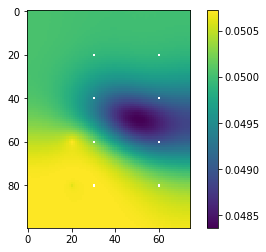

In [94]:
p = plt.imshow(arr)
plt.colorbar(p)

In [88]:
df

flx_drains_19700412  flx_river_l_19700412  \
hds_00_000_000_000         13220.658424          28306.763655   
hds_00_000_001_000         13220.626934          28307.290256   
hds_00_000_002_000         13220.697121          28307.072491   
hds_00_000_003_000         13220.703227          28307.628992   
hds_00_000_004_000         13220.785954          28307.810169   
hds_00_000_005_000         13220.888089          28308.143072   
hds_00_000_006_000         13220.967715          28308.870219   
hds_00_000_007_000         13221.100600          28309.045456   
hds_00_000_008_000         13221.177107          28310.095584   
hds_00_000_009_000         13221.330353          28310.616314   
hds_00_000_010_000         13221.486563          28311.514594   
hds_00_000_011_000         13221.643471          28312.370525   
hds_00_000_012_000         13221.830622          28313.202274   
hds_00_000_013_000         13222.017248          28314.245536   
hds_00_000_014_000         13222.201207          28315.451873   
hds_00_000_015_000         13222.389948          28316.658243   
hds_00_000_016_000         13222.642168          28317.507917   
hds_00_000_017_000         13222.859556          28318.713685   
hds_00_000_018_000         13223.073285          28320.114477   
hds_00_000_019_000         13223.295318          28321.413662   
hds_00_000_020_000         13223.556854          28322.660549   
hds_00_000_021_000         13223.794997          28324.082643   
hds_00_000_022_000         13224.032600          28325.467499   
hds_00_000_023_000         13224.287861          28327.023525   
hds_00_000_024_000         13224.508903          28328.745057   
hds_00_000_025_000         13224.760705          28330.386786   
hds_00_000_026_000         13225.029311          28331.533887   
hds_00_000_027_000         13225.264381          28333.323970   
hds_00_000_028_000         13225.505093          28334.771319   
hds_00_000_029_000         13225.751601          28336.379518   
...                                 ...                   ...   
hds_00_099_045_000         12998.437740          27418.105663   
hds_00_099_046_000         12990.188363          27386.951299   
hds_00_099_047_000         12982.363464          27356.057898   
hds_00_099_048_000         12974.918584          27325.784624   
hds_00_099_049_000         12967.723361          27296.001085   
hds_00_099_050_000         12960.573341          27266.906416   
hds_00_099_051_000         12953.584506          27240.780520   
hds_00_099_052_000         12947.317381          27212.783386   
hds_00_099_053_000         12941.016047          27187.253812   
hds_00_099_054_000         12934.903600          27162.037371   
hds_00_099_055_000         12929.240679          27139.091920   
hds_00_099_056_000         12924.020403          27115.883541   
hds_00_099_057_000         12918.953738          27094.844807   
hds_00_099_058_000         12914.067002          27075.922290   
hds_00_099_059_000         12909.933045          27056.885993   
hds_00_099_060_000         12905.781576          27039.525088   
hds_00_099_061_000         12902.202598          27022.134463   
hds_00_099_062_000         12898.754327          27007.945348   
hds_00_099_063_000         12895.620462          26994.064853   
hds_00_099_064_000         12892.712870          26983.763040   
hds_00_099_065_000         12890.192192          26972.935732   
hds_00_099_066_000         12888.231106          26964.437392   
hds_00_099_067_000         12886.492480          26955.981798   
hds_00_099_068_000         12884.768368          26949.936997   
hds_00_099_069_000         12883.514437          26943.726020   
hds_00_099_070_000         12882.147070          26939.505042   
hds_00_099_071_000         12881.119246          26934.803506   
hds_00_099_072_000         12880.071588          26933.798189   
hds_00_099_073_000         12879.453222          26932.052990   
hds_00_099_074_000         12879.340743          26929.

In [50]:
df_removed = sc.get_removed_obs_importance()

2017-12-04 15:20:02.361996 starting: calculating importance of observations
2017-12-04 15:20:02.367724 starting: calculating importance of observations by removing: ['hds_00_020_030_000']

2017-12-04 15:20:02.426164 starting: calculating importance of observations by removing: ['hds_00_020_060_000']

2017-12-04 15:20:02.475396 starting: calculating importance of observations by removing: ['hds_00_040_030_000']

2017-12-04 15:20:02.523393 starting: calculating importance of observations by removing: ['hds_00_040_060_000']

2017-12-04 15:20:02.563971 starting: calculating importance of observations by removing: ['hds_00_060_030_000']

2017-12-04 15:20:02.603786 starting: calculating importance of observations by removing: ['hds_00_060_060_000']

2017-12-04 15:20:02.647530 starting: calculating importance of observations by removing: ['hds_00_080_030_000']

2017-12-04 15:20:02.687844 starting: calculating importance of observations by removing: ['hds_00_080_060_000']

2017-12-04 15:20:02.

In [51]:
df_removed

flx_drains_19700412  flx_river_l_19700412  \
base                       13331.514003          28795.546514   
hds_00_020_030_000         13355.609912          29208.897155   
hds_00_020_060_000         13332.816107          28971.687864   
hds_00_040_030_000         13369.791432          29017.259172   
hds_00_040_060_000         13343.670479          28797.979733   
hds_00_060_030_000         13348.983032          28953.446699   
hds_00_060_060_000         13413.176469          28976.634518   
hds_00_080_030_000         13389.779269          28999.590408   
hds_00_080_060_000         13944.357268          30964.552717   

                    hds_00_050_050_001  hds_00_080_060_001  
base                          0.052124            0.080586  
hds_00_020_030_000            0.056854            0.080902  
hds_00_020_060_000            0.056980            0.080733  
hds_00_040_030_000            0.059516            0.081972  
hds_00_040_060_000            0.061012            0.081351  
hds_00_060_030_000            0.056014            0.088035  
hds_00_060_060_000            0.062666            0.087469  
hds_00_080_030_000            0.052921            0.099965  
hds_00_080_060_000            0.055864            0.116491

In [75]:
df = sc.forecasts.to_dataframe()


In [78]:
df.loc[:,"flx_river_l_19700412"]

rech0_cn      -3231.518566
rech1_cn       -148.641154
drncond_000     287.776844
rivcond_000    -299.443282
hk0000            0.000000
hk0001            0.000000
hk0002            0.014124
hk0003            0.014124
hk0004            0.014124
hk0005            0.014124
hk0006            0.000000
hk0007            0.000000
hk0008           -0.028248
hk0009            0.070620
hk0010            0.070620
hk0011            0.070620
hk0012            0.042372
hk0013            0.014124
hk0014            0.000000
hk0015           -0.028248
hk0016           -0.056496
hk0017           -0.070620
hk0018            0.197736
hk0019            0.183612
hk0020            0.127116
hk0021            0.112992
hk0022            0.042372
hk0023            0.000000
hk0024           -0.070620
hk0025           -0.098868
                  ...     
hk0078           -1.341782
hk0079           -1.666634
hk0080           -2.372835
hk0081           10.296408
hk0082            0.946309
hk0083            1.341782
h

In [80]:
sc.get_forecast_summary()

percent_reduction      post_var     prior_var
flx_river_l_19700412          14.380552  28795.546514  33632.016128
flx_drains_19700412           36.302700  13331.514003  20929.480606
hds_00_080_060_001            97.065690      0.080586      2.746336
hds_00_050_050_001            98.160010      0.052124      2.832826

In [81]:
obs = sc.pst.observation_data
obs.loc["hds_00_080_030_000","weight"] = 100.0
sc.reset_obscov(pst)

2017-12-04 15:50:43.705375 WARNING: resetting obscov
